In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 5

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [6]:
ϕ_list  = np.load("v_list_5.npy")
ems_list = np.load("e_list_5.npy")

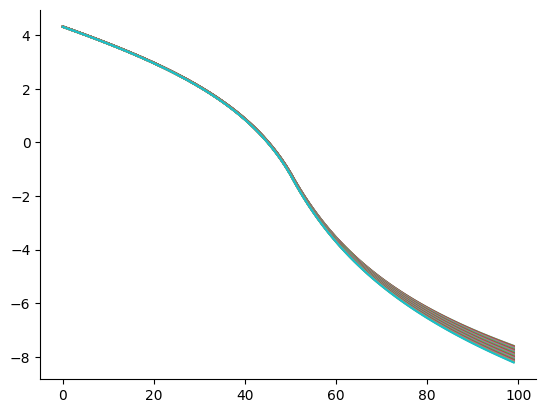

In [7]:
plt.plot(ϕ_list[18])
plt.show()

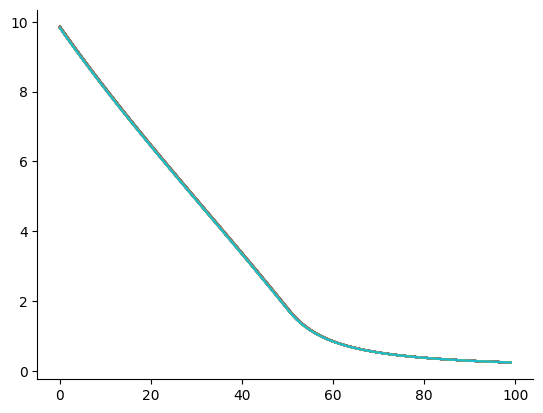

In [12]:
plt.plot(ems_list[18])
# plt.ylim(-6,6)
plt.show()

In [55]:
y1_grid_cap = np.arange(0., 2. + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.001
max_iter = 40_000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
ς = 0.01
Intensity = 1/(np.sqrt(2)*ς)*np.exp(-(y1_mat_cap - 2)**2/(2*ς**2))*(y1_mat_cap <=2) + 1/(np.sqrt(2)*ς)*(y1_mat_cap>2)
# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][:loc_2+1]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 1. + ems_old * 0.
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.036091439334	 rhs error: 0.025180566996
Episode: 2	 lhs error: 0.037983738179	 rhs error: 0.022175306980
Episode: 3	 lhs error: 0.037784718218	 rhs error: 0.021321134270
Episode: 4	 lhs error: 0.037551155440	 rhs error: 0.020558448229
Episode: 5	 lhs error: 0.037319780621	 rhs error: 0.020606282951
Episode: 6	 lhs error: 0.037090932801	 rhs error: 0.020754579071
Episode: 7	 lhs error: 0.036864549045	 rhs error: 0.020901589744
Episode: 8	 lhs error: 0.036640558110	 rhs error: 0.021047332515
Episode: 9	 lhs error: 0.036418893297	 rhs error: 0.021191823794
Episode: 10	 lhs error: 0.036199491477	 rhs error: 0.021335079603
Episode: 11	 lhs error: 0.035982292949	 rhs error: 0.021477115505
Episode: 12	 lhs error: 0.035767241212	 rhs error: 0.021617946641
Episode: 13	 lhs error: 0.035554282756	 rhs error: 0.021757587743
Episode: 14	 lhs error: 0.035343366877	 rhs error: 0.021896053162
Episode: 15	 lhs error: 0.035134445493	 rhs error: 0.022033356880
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.019672405404	 rhs error: 0.032083027876
Episode: 126	 lhs error: 0.019578760527	 rhs error: 0.032141323885
Episode: 127	 lhs error: 0.019485720568	 rhs error: 0.032199193095
Episode: 128	 lhs error: 0.019393280947	 rhs error: 0.032256638861
Episode: 129	 lhs error: 0.019301437122	 rhs error: 0.032313664504
Episode: 130	 lhs error: 0.019210184592	 rhs error: 0.032370273318
Episode: 131	 lhs error: 0.019119518898	 rhs error: 0.032426468564
Episode: 132	 lhs error: 0.019029435619	 rhs error: 0.032482253474
Episode: 133	 lhs error: 0.018939930375	 rhs error: 0.032537631252
Episode: 134	 lhs error: 0.018850998823	 rhs error: 0.032592605072
Episode: 135	 lhs error: 0.018762636662	 rhs error: 0.032647178077
Episode: 136	 lhs error: 0.018674839625	 rhs error: 0.032701353384
Episode: 137	 lhs error: 0.018587603487	 rhs error: 0.032755134082
Episode: 138	 lhs error: 0.018500924056	 rhs error: 0.032808523231
Episode: 139	 lhs error: 0.018414797181	 rhs error: 0.03286152

Episode: 249	 lhs error: 0.011559235075	 rhs error: 0.036867470893
Episode: 250	 lhs error: 0.011515256050	 rhs error: 0.036891237666
Episode: 251	 lhs error: 0.011471529567	 rhs error: 0.036914832206
Episode: 252	 lhs error: 0.011428053975	 rhs error: 0.036938255681
Episode: 253	 lhs error: 0.011384827637	 rhs error: 0.036961509250
Episode: 254	 lhs error: 0.011341848929	 rhs error: 0.036984594064
Episode: 255	 lhs error: 0.011299116236	 rhs error: 0.037007511263
Episode: 256	 lhs error: 0.011256627960	 rhs error: 0.037030261979
Episode: 257	 lhs error: 0.011214382511	 rhs error: 0.037052847336
Episode: 258	 lhs error: 0.011172378312	 rhs error: 0.037075268447
Episode: 259	 lhs error: 0.011130613799	 rhs error: 0.037097526420
Episode: 260	 lhs error: 0.011089087419	 rhs error: 0.037119622351
Episode: 261	 lhs error: 0.011047797630	 rhs error: 0.037141557329
Episode: 262	 lhs error: 0.011006742903	 rhs error: 0.037163332435
Episode: 263	 lhs error: 0.010965921719	 rhs error: 0.03718494

Episode: 373	 lhs error: 0.007616563564	 rhs error: 0.038793040636
Episode: 374	 lhs error: 0.007594361574	 rhs error: 0.038802143561
Episode: 375	 lhs error: 0.007572276807	 rhs error: 0.038811168803
Episode: 376	 lhs error: 0.007550308578	 rhs error: 0.038820116833
Episode: 377	 lhs error: 0.007528456205	 rhs error: 0.038828988119
Episode: 378	 lhs error: 0.007506719012	 rhs error: 0.038837783126
Episode: 379	 lhs error: 0.007485096325	 rhs error: 0.038846502317
Episode: 380	 lhs error: 0.007463587476	 rhs error: 0.038855146150
Episode: 381	 lhs error: 0.007442191803	 rhs error: 0.038863715080
Episode: 382	 lhs error: 0.007420908644	 rhs error: 0.038872209560
Episode: 383	 lhs error: 0.007399737346	 rhs error: 0.038880630040
Episode: 384	 lhs error: 0.007378677257	 rhs error: 0.038888976966
Episode: 385	 lhs error: 0.007357727731	 rhs error: 0.038897250782
Episode: 386	 lhs error: 0.007336888125	 rhs error: 0.038905451928
Episode: 387	 lhs error: 0.007316157801	 rhs error: 0.03891358

Episode: 497	 lhs error: 0.005580536162	 rhs error: 0.039450332429
Episode: 498	 lhs error: 0.005568774526	 rhs error: 0.039452597664
Episode: 499	 lhs error: 0.005557071142	 rhs error: 0.039454825338
Episode: 500	 lhs error: 0.005545425694	 rhs error: 0.039457015662
Episode: 501	 lhs error: 0.005533837869	 rhs error: 0.039459168849
Episode: 502	 lhs error: 0.005522307354	 rhs error: 0.039461285109
Episode: 503	 lhs error: 0.005510833838	 rhs error: 0.039463364649
Episode: 504	 lhs error: 0.005499417013	 rhs error: 0.039465407678
Episode: 505	 lhs error: 0.005488056572	 rhs error: 0.039467414402
Episode: 506	 lhs error: 0.005476752209	 rhs error: 0.039469385026
Episode: 507	 lhs error: 0.005465503622	 rhs error: 0.039471319754
Episode: 508	 lhs error: 0.005454310509	 rhs error: 0.039473218789
Episode: 509	 lhs error: 0.005443172571	 rhs error: 0.039475082331
Episode: 510	 lhs error: 0.005432089508	 rhs error: 0.039476910581
Episode: 511	 lhs error: 0.005421061026	 rhs error: 0.03947870

Episode: 621	 lhs error: 0.004483402184	 rhs error: 0.039500372244
Episode: 622	 lhs error: 0.004476934499	 rhs error: 0.039499272075
Episode: 623	 lhs error: 0.004470497002	 rhs error: 0.039498153105
Episode: 624	 lhs error: 0.004464089538	 rhs error: 0.039497015438
Episode: 625	 lhs error: 0.004457711950	 rhs error: 0.039495859178
Episode: 626	 lhs error: 0.004451364085	 rhs error: 0.039494684425
Episode: 627	 lhs error: 0.004445045790	 rhs error: 0.039493491283
Episode: 628	 lhs error: 0.004438756912	 rhs error: 0.039492279852
Episode: 629	 lhs error: 0.004432497298	 rhs error: 0.039491050233
Episode: 630	 lhs error: 0.004426266798	 rhs error: 0.039489802527
Episode: 631	 lhs error: 0.004420065262	 rhs error: 0.039488536833
Episode: 632	 lhs error: 0.004413892541	 rhs error: 0.039487253251
Episode: 633	 lhs error: 0.004407748486	 rhs error: 0.039485951878
Episode: 634	 lhs error: 0.004401632950	 rhs error: 0.039484632812
Episode: 635	 lhs error: 0.004395545784	 rhs error: 0.03948329

Episode: 745	 lhs error: 0.004015870756	 rhs error: 0.039248005849
Episode: 746	 lhs error: 0.004015718239	 rhs error: 0.039245214343
Episode: 747	 lhs error: 0.004015563756	 rhs error: 0.039242413397
Episode: 748	 lhs error: 0.004015407315	 rhs error: 0.039239603064
Episode: 749	 lhs error: 0.004015248927	 rhs error: 0.039236783395
Episode: 750	 lhs error: 0.004015088601	 rhs error: 0.039233954444
Episode: 751	 lhs error: 0.004014926347	 rhs error: 0.039231116263
Episode: 752	 lhs error: 0.004014762175	 rhs error: 0.039228268904
Episode: 753	 lhs error: 0.004014596093	 rhs error: 0.039225412419
Episode: 754	 lhs error: 0.004014428113	 rhs error: 0.039222546858
Episode: 755	 lhs error: 0.004014258242	 rhs error: 0.039219672273
Episode: 756	 lhs error: 0.004014086491	 rhs error: 0.039216788715
Episode: 757	 lhs error: 0.004013912868	 rhs error: 0.039213896235
Episode: 758	 lhs error: 0.004013737384	 rhs error: 0.039210994883
Episode: 759	 lhs error: 0.004013560046	 rhs error: 0.03920808

Episode: 869	 lhs error: 0.003984596353	 rhs error: 0.038844022795
Episode: 870	 lhs error: 0.003984261818	 rhs error: 0.038840391751
Episode: 871	 lhs error: 0.003983926231	 rhs error: 0.038836756131
Episode: 872	 lhs error: 0.003983589598	 rhs error: 0.038833115963
Episode: 873	 lhs error: 0.003983251924	 rhs error: 0.038829471275
Episode: 874	 lhs error: 0.003982913213	 rhs error: 0.038825822095
Episode: 875	 lhs error: 0.003982573473	 rhs error: 0.038822168451
Episode: 876	 lhs error: 0.003982232707	 rhs error: 0.038818510369
Episode: 877	 lhs error: 0.003981890921	 rhs error: 0.038814847877
Episode: 878	 lhs error: 0.003981548120	 rhs error: 0.038811181002
Episode: 879	 lhs error: 0.003981204310	 rhs error: 0.038807509772
Episode: 880	 lhs error: 0.003980859495	 rhs error: 0.038803834212
Episode: 881	 lhs error: 0.003980513681	 rhs error: 0.038800154351
Episode: 882	 lhs error: 0.003980166874	 rhs error: 0.038796470214
Episode: 883	 lhs error: 0.003979819077	 rhs error: 0.03879278

Episode: 993	 lhs error: 0.003936545301	 rhs error: 0.038366383218
Episode: 994	 lhs error: 0.003936114425	 rhs error: 0.038362360501
Episode: 995	 lhs error: 0.003935683002	 rhs error: 0.038358335795
Episode: 996	 lhs error: 0.003935251033	 rhs error: 0.038354309116
Episode: 997	 lhs error: 0.003934818523	 rhs error: 0.038350280480
Episode: 998	 lhs error: 0.003934385474	 rhs error: 0.038346249900
Episode: 999	 lhs error: 0.003933951889	 rhs error: 0.038342217391
Episode: 1000	 lhs error: 0.003933517771	 rhs error: 0.038338182970
Episode: 1001	 lhs error: 0.003933083123	 rhs error: 0.038334146649
Episode: 1002	 lhs error: 0.003932647948	 rhs error: 0.038330108443
Episode: 1003	 lhs error: 0.003932212248	 rhs error: 0.038326068368
Episode: 1004	 lhs error: 0.003931776027	 rhs error: 0.038322026436
Episode: 1005	 lhs error: 0.003931339287	 rhs error: 0.038317982664
Episode: 1006	 lhs error: 0.003930902031	 rhs error: 0.038313937065
Episode: 1007	 lhs error: 0.003930464262	 rhs error: 0.

Episode: 1117	 lhs error: 0.003879740487	 rhs error: 0.037856434013
Episode: 1118	 lhs error: 0.003879260480	 rhs error: 0.037852259139
Episode: 1119	 lhs error: 0.003878780203	 rhs error: 0.037848083667
Episode: 1120	 lhs error: 0.003878299658	 rhs error: 0.037843907605
Episode: 1121	 lhs error: 0.003877818846	 rhs error: 0.037839730961
Episode: 1122	 lhs error: 0.003877337769	 rhs error: 0.037835553745
Episode: 1123	 lhs error: 0.003876856429	 rhs error: 0.037831375962
Episode: 1124	 lhs error: 0.003876374826	 rhs error: 0.037827197622
Episode: 1125	 lhs error: 0.003875892964	 rhs error: 0.037823018733
Episode: 1126	 lhs error: 0.003875410843	 rhs error: 0.037818839301
Episode: 1127	 lhs error: 0.003874928464	 rhs error: 0.037814659335
Episode: 1128	 lhs error: 0.003874445831	 rhs error: 0.037810478843
Episode: 1129	 lhs error: 0.003873962943	 rhs error: 0.037806297833
Episode: 1130	 lhs error: 0.003873479803	 rhs error: 0.037802116311
Episode: 1131	 lhs error: 0.003872996412	 rhs er

Episode: 1241	 lhs error: 0.003818601662	 rhs error: 0.037336359247
Episode: 1242	 lhs error: 0.003818098520	 rhs error: 0.037332161017
Episode: 1243	 lhs error: 0.003817595260	 rhs error: 0.037327962937
Episode: 1244	 lhs error: 0.003817091884	 rhs error: 0.037323765010
Episode: 1245	 lhs error: 0.003816588392	 rhs error: 0.037319567242
Episode: 1246	 lhs error: 0.003816084786	 rhs error: 0.037315369637
Episode: 1247	 lhs error: 0.003815581067	 rhs error: 0.037311172199
Episode: 1248	 lhs error: 0.003815077234	 rhs error: 0.037306974932
Episode: 1249	 lhs error: 0.003814573290	 rhs error: 0.037302777840
Episode: 1250	 lhs error: 0.003814069235	 rhs error: 0.037298580928
Episode: 1251	 lhs error: 0.003813565070	 rhs error: 0.037294384200
Episode: 1252	 lhs error: 0.003813060796	 rhs error: 0.037290187659
Episode: 1253	 lhs error: 0.003812556414	 rhs error: 0.037285991311
Episode: 1254	 lhs error: 0.003812051923	 rhs error: 0.037281795159
Episode: 1255	 lhs error: 0.003811547327	 rhs er

Episode: 1365	 lhs error: 0.003755560676	 rhs error: 0.036818079502
Episode: 1366	 lhs error: 0.003755048684	 rhs error: 0.036813926952
Episode: 1367	 lhs error: 0.003754536658	 rhs error: 0.036809774950
Episode: 1368	 lhs error: 0.003754024600	 rhs error: 0.036805623499
Episode: 1369	 lhs error: 0.003753512510	 rhs error: 0.036801472600
Episode: 1370	 lhs error: 0.003753000388	 rhs error: 0.036797322257
Episode: 1371	 lhs error: 0.003752488234	 rhs error: 0.036793172471
Episode: 1372	 lhs error: 0.003751976050	 rhs error: 0.036789023244
Episode: 1373	 lhs error: 0.003751463835	 rhs error: 0.036784874579
Episode: 1374	 lhs error: 0.003750951591	 rhs error: 0.036780726478
Episode: 1375	 lhs error: 0.003750439317	 rhs error: 0.036776578944
Episode: 1376	 lhs error: 0.003749927014	 rhs error: 0.036772431977
Episode: 1377	 lhs error: 0.003749414682	 rhs error: 0.036768285581
Episode: 1378	 lhs error: 0.003748902323	 rhs error: 0.036764139758
Episode: 1379	 lhs error: 0.003748389936	 rhs er

Episode: 1489	 lhs error: 0.003691952185	 rhs error: 0.036307952806
Episode: 1490	 lhs error: 0.003691439168	 rhs error: 0.036303882450
Episode: 1491	 lhs error: 0.003690926164	 rhs error: 0.036299812851
Episode: 1492	 lhs error: 0.003690413172	 rhs error: 0.036295744009
Episode: 1493	 lhs error: 0.003689900194	 rhs error: 0.036291675926
Episode: 1494	 lhs error: 0.003689387229	 rhs error: 0.036287608602
Episode: 1495	 lhs error: 0.003688874277	 rhs error: 0.036283542040
Episode: 1496	 lhs error: 0.003688361339	 rhs error: 0.036279476239
Episode: 1497	 lhs error: 0.003687848416	 rhs error: 0.036275411201
Episode: 1498	 lhs error: 0.003687335506	 rhs error: 0.036271346928
Episode: 1499	 lhs error: 0.003686822612	 rhs error: 0.036267283420
Episode: 1500	 lhs error: 0.003686309732	 rhs error: 0.036263220679
Episode: 1501	 lhs error: 0.003685796867	 rhs error: 0.036259158705
Episode: 1502	 lhs error: 0.003685284018	 rhs error: 0.036255097500
Episode: 1503	 lhs error: 0.003684771184	 rhs er

Episode: 1613	 lhs error: 0.003628505321	 rhs error: 0.035809303833
Episode: 1614	 lhs error: 0.003627995538	 rhs error: 0.035805334414
Episode: 1615	 lhs error: 0.003627485793	 rhs error: 0.035801365854
Episode: 1616	 lhs error: 0.003626976084	 rhs error: 0.035797398154
Episode: 1617	 lhs error: 0.003626466413	 rhs error: 0.035793431316
Episode: 1618	 lhs error: 0.003625956780	 rhs error: 0.035789465340
Episode: 1619	 lhs error: 0.003625447185	 rhs error: 0.035785500226
Episode: 1620	 lhs error: 0.003624937628	 rhs error: 0.035781535974
Episode: 1621	 lhs error: 0.003624428109	 rhs error: 0.035777572586
Episode: 1622	 lhs error: 0.003623918628	 rhs error: 0.035773610062
Episode: 1623	 lhs error: 0.003623409186	 rhs error: 0.035769648402
Episode: 1624	 lhs error: 0.003622899783	 rhs error: 0.035765687607
Episode: 1625	 lhs error: 0.003622390418	 rhs error: 0.035761727678
Episode: 1626	 lhs error: 0.003621881091	 rhs error: 0.035757768614
Episode: 1627	 lhs error: 0.003621371804	 rhs er

Episode: 1737	 lhs error: 0.003565615164	 rhs error: 0.035323797779
Episode: 1738	 lhs error: 0.003565110907	 rhs error: 0.035319938303
Episode: 1739	 lhs error: 0.003564606700	 rhs error: 0.035316079734
Episode: 1740	 lhs error: 0.003564102544	 rhs error: 0.035312222072
Episode: 1741	 lhs error: 0.003563598438	 rhs error: 0.035308365317
Episode: 1742	 lhs error: 0.003563094383	 rhs error: 0.035304509469
Episode: 1743	 lhs error: 0.003562590379	 rhs error: 0.035300654529
Episode: 1744	 lhs error: 0.003562086425	 rhs error: 0.035296800497
Episode: 1745	 lhs error: 0.003561582523	 rhs error: 0.035292947373
Episode: 1746	 lhs error: 0.003561078672	 rhs error: 0.035289095157
Episode: 1747	 lhs error: 0.003560574872	 rhs error: 0.035285243850
Episode: 1748	 lhs error: 0.003560071123	 rhs error: 0.035281393451
Episode: 1749	 lhs error: 0.003559567425	 rhs error: 0.035277543961
Episode: 1750	 lhs error: 0.003559063779	 rhs error: 0.035273695381
Episode: 1751	 lhs error: 0.003558560184	 rhs er

Episode: 1861	 lhs error: 0.003503492619	 rhs error: 0.034852190767
Episode: 1862	 lhs error: 0.003502995095	 rhs error: 0.034848444911
Episode: 1863	 lhs error: 0.003502497629	 rhs error: 0.034844699977
Episode: 1864	 lhs error: 0.003502000220	 rhs error: 0.034840955965
Episode: 1865	 lhs error: 0.003501502868	 rhs error: 0.034837212876
Episode: 1866	 lhs error: 0.003501005574	 rhs error: 0.034833470709
Episode: 1867	 lhs error: 0.003500508338	 rhs error: 0.034829729464
Episode: 1868	 lhs error: 0.003500011158	 rhs error: 0.034825989142
Episode: 1869	 lhs error: 0.003499514037	 rhs error: 0.034822249742
Episode: 1870	 lhs error: 0.003499016973	 rhs error: 0.034818511264
Episode: 1871	 lhs error: 0.003498519967	 rhs error: 0.034814773709
Episode: 1872	 lhs error: 0.003498023019	 rhs error: 0.034811037077
Episode: 1873	 lhs error: 0.003497526128	 rhs error: 0.034807301367
Episode: 1874	 lhs error: 0.003497029295	 rhs error: 0.034803566580
Episode: 1875	 lhs error: 0.003496532520	 rhs er

Episode: 1985	 lhs error: 0.003442247137	 rhs error: 0.034394741080
Episode: 1986	 lhs error: 0.003441756959	 rhs error: 0.034391109603
Episode: 1987	 lhs error: 0.003441266841	 rhs error: 0.034387479046
Episode: 1988	 lhs error: 0.003440776784	 rhs error: 0.034383849410
Episode: 1989	 lhs error: 0.003440286787	 rhs error: 0.034380220694
Episode: 1990	 lhs error: 0.003439796851	 rhs error: 0.034376592898
Episode: 1991	 lhs error: 0.003439306976	 rhs error: 0.034372966023
Episode: 1992	 lhs error: 0.003438817162	 rhs error: 0.034369340068
Episode: 1993	 lhs error: 0.003438327409	 rhs error: 0.034365715034
Episode: 1994	 lhs error: 0.003437837716	 rhs error: 0.034362090919
Episode: 1995	 lhs error: 0.003437348085	 rhs error: 0.034358467725
Episode: 1996	 lhs error: 0.003436858514	 rhs error: 0.034354845450
Episode: 1997	 lhs error: 0.003436369004	 rhs error: 0.034351224096
Episode: 1998	 lhs error: 0.003435879555	 rhs error: 0.034347603661
Episode: 1999	 lhs error: 0.003435390167	 rhs er

Episode: 2109	 lhs error: 0.003381932347	 rhs error: 0.033951435197
Episode: 2110	 lhs error: 0.003381449797	 rhs error: 0.033947917269
Episode: 2111	 lhs error: 0.003380967309	 rhs error: 0.033944400252
Episode: 2112	 lhs error: 0.003380484883	 rhs error: 0.033940884144
Episode: 2113	 lhs error: 0.003380002519	 rhs error: 0.033937368946
Episode: 2114	 lhs error: 0.003379520218	 rhs error: 0.033933854657
Episode: 2115	 lhs error: 0.003379037978	 rhs error: 0.033930341277
Episode: 2116	 lhs error: 0.003378555801	 rhs error: 0.033926828806
Episode: 2117	 lhs error: 0.003378073686	 rhs error: 0.033923317245
Episode: 2118	 lhs error: 0.003377591633	 rhs error: 0.033919806592
Episode: 2119	 lhs error: 0.003377109642	 rhs error: 0.033916296848
Episode: 2120	 lhs error: 0.003376627714	 rhs error: 0.033912788013
Episode: 2121	 lhs error: 0.003376145847	 rhs error: 0.033909280086
Episode: 2122	 lhs error: 0.003375664043	 rhs error: 0.033905773068
Episode: 2123	 lhs error: 0.003375182301	 rhs er

Episode: 2233	 lhs error: 0.003322571207	 rhs error: 0.033522112389
Episode: 2234	 lhs error: 0.003322096389	 rhs error: 0.033518706330
Episode: 2235	 lhs error: 0.003321621634	 rhs error: 0.033515301166
Episode: 2236	 lhs error: 0.003321146940	 rhs error: 0.033511896895
Episode: 2237	 lhs error: 0.003320672310	 rhs error: 0.033508493517
Episode: 2238	 lhs error: 0.003320197741	 rhs error: 0.033505091034
Episode: 2239	 lhs error: 0.003319723236	 rhs error: 0.033501689443
Episode: 2240	 lhs error: 0.003319248792	 rhs error: 0.033498288746
Episode: 2241	 lhs error: 0.003318774412	 rhs error: 0.033494888942
Episode: 2242	 lhs error: 0.003318300093	 rhs error: 0.033491490031
Episode: 2243	 lhs error: 0.003317825837	 rhs error: 0.033488092013
Episode: 2244	 lhs error: 0.003317351644	 rhs error: 0.033484694887
Episode: 2245	 lhs error: 0.003316877513	 rhs error: 0.033481298654
Episode: 2246	 lhs error: 0.003316403445	 rhs error: 0.033477903313
Episode: 2247	 lhs error: 0.003315929439	 rhs er

Episode: 2357	 lhs error: 0.003264169870	 rhs error: 0.033106533561
Episode: 2358	 lhs error: 0.003263702789	 rhs error: 0.033103237242
Episode: 2359	 lhs error: 0.003263235770	 rhs error: 0.033099941799
Episode: 2360	 lhs error: 0.003262768813	 rhs error: 0.033096647231
Episode: 2361	 lhs error: 0.003262301918	 rhs error: 0.033093353538
Episode: 2362	 lhs error: 0.003261835086	 rhs error: 0.033090060720
Episode: 2363	 lhs error: 0.003261368316	 rhs error: 0.033086768778
Episode: 2364	 lhs error: 0.003260901608	 rhs error: 0.033083477710
Episode: 2365	 lhs error: 0.003260434963	 rhs error: 0.033080187518
Episode: 2366	 lhs error: 0.003259968379	 rhs error: 0.033076898199
Episode: 2367	 lhs error: 0.003259501858	 rhs error: 0.033073609755
Episode: 2368	 lhs error: 0.003259035399	 rhs error: 0.033070322186
Episode: 2369	 lhs error: 0.003258569003	 rhs error: 0.033067035490
Episode: 2370	 lhs error: 0.003258102668	 rhs error: 0.033063749668
Episode: 2371	 lhs error: 0.003257636396	 rhs er

Episode: 2481	 lhs error: 0.003206725309	 rhs error: 0.032704419315
Episode: 2482	 lhs error: 0.003206265916	 rhs error: 0.032701230383
Episode: 2483	 lhs error: 0.003205806585	 rhs error: 0.032698042308
Episode: 2484	 lhs error: 0.003205347315	 rhs error: 0.032694855088
Episode: 2485	 lhs error: 0.003204888107	 rhs error: 0.032691668725
Episode: 2486	 lhs error: 0.003204428961	 rhs error: 0.032688483217
Episode: 2487	 lhs error: 0.003203969876	 rhs error: 0.032685298565
Episode: 2488	 lhs error: 0.003203510854	 rhs error: 0.032682114768
Episode: 2489	 lhs error: 0.003203051893	 rhs error: 0.032678931826
Episode: 2490	 lhs error: 0.003202592993	 rhs error: 0.032675749739
Episode: 2491	 lhs error: 0.003202134155	 rhs error: 0.032672568507
Episode: 2492	 lhs error: 0.003201675379	 rhs error: 0.032669388130
Episode: 2493	 lhs error: 0.003201216665	 rhs error: 0.032666208607
Episode: 2494	 lhs error: 0.003200758012	 rhs error: 0.032663029939
Episode: 2495	 lhs error: 0.003200299421	 rhs er

Episode: 2605	 lhs error: 0.003150229523	 rhs error: 0.032315470997
Episode: 2606	 lhs error: 0.003149777740	 rhs error: 0.032312387002
Episode: 2607	 lhs error: 0.003149326019	 rhs error: 0.032309303844
Episode: 2608	 lhs error: 0.003148874359	 rhs error: 0.032306221521
Episode: 2609	 lhs error: 0.003148422759	 rhs error: 0.032303140035
Episode: 2610	 lhs error: 0.003147971221	 rhs error: 0.032300059384
Episode: 2611	 lhs error: 0.003147519743	 rhs error: 0.032296979568
Episode: 2612	 lhs error: 0.003147068327	 rhs error: 0.032293900588
Episode: 2613	 lhs error: 0.003146616971	 rhs error: 0.032290822444
Episode: 2614	 lhs error: 0.003146165677	 rhs error: 0.032287745134
Episode: 2615	 lhs error: 0.003145714443	 rhs error: 0.032284668659
Episode: 2616	 lhs error: 0.003145263270	 rhs error: 0.032281593019
Episode: 2617	 lhs error: 0.003144812159	 rhs error: 0.032278518213
Episode: 2618	 lhs error: 0.003144361108	 rhs error: 0.032275444242
Episode: 2619	 lhs error: 0.003143910118	 rhs er

Episode: 2729	 lhs error: 0.003094671842	 rhs error: 0.031939382324
Episode: 2730	 lhs error: 0.003094227577	 rhs error: 0.031936400785
Episode: 2731	 lhs error: 0.003093783372	 rhs error: 0.031933420062
Episode: 2732	 lhs error: 0.003093339228	 rhs error: 0.031930440155
Episode: 2733	 lhs error: 0.003092895144	 rhs error: 0.031927461064
Episode: 2734	 lhs error: 0.003092451120	 rhs error: 0.031924482789
Episode: 2735	 lhs error: 0.003092007156	 rhs error: 0.031921505329
Episode: 2736	 lhs error: 0.003091563252	 rhs error: 0.031918528684
Episode: 2737	 lhs error: 0.003091119409	 rhs error: 0.031915552855
Episode: 2738	 lhs error: 0.003090675626	 rhs error: 0.031912577841
Episode: 2739	 lhs error: 0.003090231903	 rhs error: 0.031909603641
Episode: 2740	 lhs error: 0.003089788240	 rhs error: 0.031906630257
Episode: 2741	 lhs error: 0.003089344637	 rhs error: 0.031903657687
Episode: 2742	 lhs error: 0.003088901094	 rhs error: 0.031900685931
Episode: 2743	 lhs error: 0.003088457612	 rhs er

Episode: 2853	 lhs error: 0.003040040200	 rhs error: 0.031575845778
Episode: 2854	 lhs error: 0.003039603351	 rhs error: 0.031572964220
Episode: 2855	 lhs error: 0.003039166563	 rhs error: 0.031570083458
Episode: 2856	 lhs error: 0.003038729834	 rhs error: 0.031567203493
Episode: 2857	 lhs error: 0.003038293164	 rhs error: 0.031564324324
Episode: 2858	 lhs error: 0.003037856553	 rhs error: 0.031561445950
Episode: 2859	 lhs error: 0.003037420002	 rhs error: 0.031558568373
Episode: 2860	 lhs error: 0.003036983510	 rhs error: 0.031555691590
Episode: 2861	 lhs error: 0.003036547078	 rhs error: 0.031552815603
Episode: 2862	 lhs error: 0.003036110704	 rhs error: 0.031549940412
Episode: 2863	 lhs error: 0.003035674391	 rhs error: 0.031547066015
Episode: 2864	 lhs error: 0.003035238136	 rhs error: 0.031544192413
Episode: 2865	 lhs error: 0.003034801941	 rhs error: 0.031541319606
Episode: 2866	 lhs error: 0.003034365805	 rhs error: 0.031538447594
Episode: 2867	 lhs error: 0.003033929729	 rhs er

Episode: 2977	 lhs error: 0.002986321830	 rhs error: 0.031224556098
Episode: 2978	 lhs error: 0.002985892294	 rhs error: 0.031221772075
Episode: 2979	 lhs error: 0.002985462816	 rhs error: 0.031218988829
Episode: 2980	 lhs error: 0.002985033398	 rhs error: 0.031216206359
Episode: 2981	 lhs error: 0.002984604037	 rhs error: 0.031213424666
Episode: 2982	 lhs error: 0.002984174736	 rhs error: 0.031210643749
Episode: 2983	 lhs error: 0.002983745492	 rhs error: 0.031207863608
Episode: 2984	 lhs error: 0.002983316308	 rhs error: 0.031205084243
Episode: 2985	 lhs error: 0.002982887181	 rhs error: 0.031202305653
Episode: 2986	 lhs error: 0.002982458113	 rhs error: 0.031199527840
Episode: 2987	 lhs error: 0.002982029104	 rhs error: 0.031196750801
Episode: 2988	 lhs error: 0.002981600153	 rhs error: 0.031193974539
Episode: 2989	 lhs error: 0.002981171261	 rhs error: 0.031191199051
Episode: 2990	 lhs error: 0.002980742427	 rhs error: 0.031188424338
Episode: 2991	 lhs error: 0.002980313652	 rhs er

Episode: 3101	 lhs error: 0.002933503650	 rhs error: 0.030885212174
Episode: 3102	 lhs error: 0.002933081320	 rhs error: 0.030882523278
Episode: 3103	 lhs error: 0.002932659048	 rhs error: 0.030879835138
Episode: 3104	 lhs error: 0.002932236834	 rhs error: 0.030877147756
Episode: 3105	 lhs error: 0.002931814677	 rhs error: 0.030874461132
Episode: 3106	 lhs error: 0.002931392578	 rhs error: 0.030871775264
Episode: 3107	 lhs error: 0.002930970536	 rhs error: 0.030869090153
Episode: 3108	 lhs error: 0.002930548552	 rhs error: 0.030866405799
Episode: 3109	 lhs error: 0.002930126626	 rhs error: 0.030863722201
Episode: 3110	 lhs error: 0.002929704758	 rhs error: 0.030861039360
Episode: 3111	 lhs error: 0.002929282947	 rhs error: 0.030858357275
Episode: 3112	 lhs error: 0.002928861193	 rhs error: 0.030855675946
Episode: 3113	 lhs error: 0.002928439497	 rhs error: 0.030852995373
Episode: 3114	 lhs error: 0.002928017859	 rhs error: 0.030850315556
Episode: 3115	 lhs error: 0.002927596279	 rhs er

Episode: 3225	 lhs error: 0.002881572474	 rhs error: 0.030557518034
Episode: 3226	 lhs error: 0.002881157243	 rhs error: 0.030554921899
Episode: 3227	 lhs error: 0.002880742070	 rhs error: 0.030552326503
Episode: 3228	 lhs error: 0.002880326953	 rhs error: 0.030549731845
Episode: 3229	 lhs error: 0.002879911894	 rhs error: 0.030547137926
Episode: 3230	 lhs error: 0.002879496890	 rhs error: 0.030544544744
Episode: 3231	 lhs error: 0.002879081944	 rhs error: 0.030541952301
Episode: 3232	 lhs error: 0.002878667055	 rhs error: 0.030539360595
Episode: 3233	 lhs error: 0.002878252222	 rhs error: 0.030536769628
Episode: 3234	 lhs error: 0.002877837446	 rhs error: 0.030534179397
Episode: 3235	 lhs error: 0.002877422727	 rhs error: 0.030531589905
Episode: 3236	 lhs error: 0.002877008065	 rhs error: 0.030529001149
Episode: 3237	 lhs error: 0.002876593459	 rhs error: 0.030526413130
Episode: 3238	 lhs error: 0.002876178911	 rhs error: 0.030523825849
Episode: 3239	 lhs error: 0.002875764419	 rhs er

Episode: 3349	 lhs error: 0.002830515122	 rhs error: 0.030241183339
Episode: 3350	 lhs error: 0.002830106885	 rhs error: 0.030238677648
Episode: 3351	 lhs error: 0.002829698704	 rhs error: 0.030236172677
Episode: 3352	 lhs error: 0.002829290579	 rhs error: 0.030233668427
Episode: 3353	 lhs error: 0.002828882511	 rhs error: 0.030231164896
Episode: 3354	 lhs error: 0.002828474498	 rhs error: 0.030228662085
Episode: 3355	 lhs error: 0.002828066541	 rhs error: 0.030226159993
Episode: 3356	 lhs error: 0.002827658640	 rhs error: 0.030223658621
Episode: 3357	 lhs error: 0.002827250795	 rhs error: 0.030221157968
Episode: 3358	 lhs error: 0.002826843006	 rhs error: 0.030218658034
Episode: 3359	 lhs error: 0.002826435273	 rhs error: 0.030216158819
Episode: 3360	 lhs error: 0.002826027596	 rhs error: 0.030213660322
Episode: 3361	 lhs error: 0.002825619974	 rhs error: 0.030211162545
Episode: 3362	 lhs error: 0.002825212409	 rhs error: 0.030208665486
Episode: 3363	 lhs error: 0.002824804899	 rhs er

Episode: 3473	 lhs error: 0.002780318490	 rhs error: 0.029935923607
Episode: 3474	 lhs error: 0.002779917141	 rhs error: 0.029933506091
Episode: 3475	 lhs error: 0.002779515848	 rhs error: 0.029931089276
Episode: 3476	 lhs error: 0.002779114610	 rhs error: 0.029928673163
Episode: 3477	 lhs error: 0.002778713427	 rhs error: 0.029926257752
Episode: 3478	 lhs error: 0.002778312299	 rhs error: 0.029923843043
Episode: 3479	 lhs error: 0.002777911226	 rhs error: 0.029921429034
Episode: 3480	 lhs error: 0.002777510209	 rhs error: 0.029919015727
Episode: 3481	 lhs error: 0.002777109246	 rhs error: 0.029916603122
Episode: 3482	 lhs error: 0.002776708338	 rhs error: 0.029914191217
Episode: 3483	 lhs error: 0.002776307486	 rhs error: 0.029911780013
Episode: 3484	 lhs error: 0.002775906688	 rhs error: 0.029909369509
Episode: 3485	 lhs error: 0.002775505946	 rhs error: 0.029906959707
Episode: 3486	 lhs error: 0.002775105259	 rhs error: 0.029904550604
Episode: 3487	 lhs error: 0.002774704627	 rhs er

Episode: 3597	 lhs error: 0.002730969581	 rhs error: 0.029641460283
Episode: 3598	 lhs error: 0.002730575017	 rhs error: 0.029639128718
Episode: 3599	 lhs error: 0.002730180507	 rhs error: 0.029636797837
Episode: 3600	 lhs error: 0.002729786051	 rhs error: 0.029634467640
Episode: 3601	 lhs error: 0.002729391649	 rhs error: 0.029632138127
Episode: 3602	 lhs error: 0.002728997302	 rhs error: 0.029629809298
Episode: 3603	 lhs error: 0.002728603009	 rhs error: 0.029627481153
Episode: 3604	 lhs error: 0.002728208770	 rhs error: 0.029625153692
Episode: 3605	 lhs error: 0.002727814586	 rhs error: 0.029622826913
Episode: 3606	 lhs error: 0.002727420456	 rhs error: 0.029620500818
Episode: 3607	 lhs error: 0.002727026380	 rhs error: 0.029618175407
Episode: 3608	 lhs error: 0.002726632358	 rhs error: 0.029615850678
Episode: 3609	 lhs error: 0.002726238390	 rhs error: 0.029613526632
Episode: 3610	 lhs error: 0.002725844477	 rhs error: 0.029611203268
Episode: 3611	 lhs error: 0.002725450618	 rhs er

Episode: 3721	 lhs error: 0.002682455526	 rhs error: 0.029357520715
Episode: 3722	 lhs error: 0.002682067642	 rhs error: 0.029355272926
Episode: 3723	 lhs error: 0.002681679812	 rhs error: 0.029353025805
Episode: 3724	 lhs error: 0.002681292035	 rhs error: 0.029350779350
Episode: 3725	 lhs error: 0.002680904312	 rhs error: 0.029348533562
Episode: 3726	 lhs error: 0.002680516642	 rhs error: 0.029346288441
Episode: 3727	 lhs error: 0.002680129026	 rhs error: 0.029344043985
Episode: 3728	 lhs error: 0.002679741463	 rhs error: 0.029341800196
Episode: 3729	 lhs error: 0.002679353953	 rhs error: 0.029339557074
Episode: 3730	 lhs error: 0.002678966497	 rhs error: 0.029337314617
Episode: 3731	 lhs error: 0.002678579095	 rhs error: 0.029335072825
Episode: 3732	 lhs error: 0.002678191745	 rhs error: 0.029332831700
Episode: 3733	 lhs error: 0.002677804449	 rhs error: 0.029330591240
Episode: 3734	 lhs error: 0.002677417207	 rhs error: 0.029328351445
Episode: 3735	 lhs error: 0.002677030018	 rhs er

Episode: 3845	 lhs error: 0.002634763592	 rhs error: 0.029083838102
Episode: 3846	 lhs error: 0.002634382287	 rhs error: 0.029081671962
Episode: 3847	 lhs error: 0.002634001034	 rhs error: 0.029079506472
Episode: 3848	 lhs error: 0.002633619835	 rhs error: 0.029077341632
Episode: 3849	 lhs error: 0.002633238688	 rhs error: 0.029075177442
Episode: 3850	 lhs error: 0.002632857593	 rhs error: 0.029073013901
Episode: 3851	 lhs error: 0.002632476551	 rhs error: 0.029070851010
Episode: 3852	 lhs error: 0.002632095562	 rhs error: 0.029068688767
Episode: 3853	 lhs error: 0.002631714625	 rhs error: 0.029066527174
Episode: 3854	 lhs error: 0.002631333741	 rhs error: 0.029064366230
Episode: 3855	 lhs error: 0.002630952910	 rhs error: 0.029062205935
Episode: 3856	 lhs error: 0.002630572131	 rhs error: 0.029060046289
Episode: 3857	 lhs error: 0.002630191405	 rhs error: 0.029057887291
Episode: 3858	 lhs error: 0.002629810731	 rhs error: 0.029055728941
Episode: 3859	 lhs error: 0.002629430110	 rhs er

Episode: 3969	 lhs error: 0.002587881188	 rhs error: 0.028820151402
Episode: 3970	 lhs error: 0.002587506361	 rhs error: 0.028818064829
Episode: 3971	 lhs error: 0.002587131585	 rhs error: 0.028815978889
Episode: 3972	 lhs error: 0.002586756862	 rhs error: 0.028813893583
Episode: 3973	 lhs error: 0.002586382190	 rhs error: 0.028811808909
Episode: 3974	 lhs error: 0.002586007570	 rhs error: 0.028809724869
Episode: 3975	 lhs error: 0.002585633002	 rhs error: 0.028807641461
Episode: 3976	 lhs error: 0.002585258485	 rhs error: 0.028805558686
Episode: 3977	 lhs error: 0.002584884021	 rhs error: 0.028803476543
Episode: 3978	 lhs error: 0.002584509608	 rhs error: 0.028801395033
Episode: 3979	 lhs error: 0.002584135247	 rhs error: 0.028799314155
Episode: 3980	 lhs error: 0.002583760937	 rhs error: 0.028797233909
Episode: 3981	 lhs error: 0.002583386680	 rhs error: 0.028795154296
Episode: 3982	 lhs error: 0.002583012474	 rhs error: 0.028793075314
Episode: 3983	 lhs error: 0.002582638320	 rhs er

Episode: 4093	 lhs error: 0.002541795871	 rhs error: 0.028566205239
Episode: 4094	 lhs error: 0.002541427421	 rhs error: 0.028564196196
Episode: 4095	 lhs error: 0.002541059023	 rhs error: 0.028562187769
Episode: 4096	 lhs error: 0.002540690675	 rhs error: 0.028560179960
Episode: 4097	 lhs error: 0.002540322379	 rhs error: 0.028558172768
Episode: 4098	 lhs error: 0.002539954134	 rhs error: 0.028556166192
Episode: 4099	 lhs error: 0.002539585940	 rhs error: 0.028554160233
Episode: 4100	 lhs error: 0.002539217796	 rhs error: 0.028552154890
Episode: 4101	 lhs error: 0.002538849704	 rhs error: 0.028550150164
Episode: 4102	 lhs error: 0.002538481663	 rhs error: 0.028548146054
Episode: 4103	 lhs error: 0.002538113673	 rhs error: 0.028546142559
Episode: 4104	 lhs error: 0.002537745733	 rhs error: 0.028544139681
Episode: 4105	 lhs error: 0.002537377845	 rhs error: 0.028542137419
Episode: 4106	 lhs error: 0.002537010007	 rhs error: 0.028540135772
Episode: 4107	 lhs error: 0.002536642221	 rhs er

Episode: 4217	 lhs error: 0.002496495342	 rhs error: 0.028321749791
Episode: 4218	 lhs error: 0.002496133172	 rhs error: 0.028319816285
Episode: 4219	 lhs error: 0.002495771052	 rhs error: 0.028317883381
Episode: 4220	 lhs error: 0.002495408982	 rhs error: 0.028315951077
Episode: 4221	 lhs error: 0.002495046963	 rhs error: 0.028314019375
Episode: 4222	 lhs error: 0.002494684994	 rhs error: 0.028312088273
Episode: 4223	 lhs error: 0.002494323075	 rhs error: 0.028310157772
Episode: 4224	 lhs error: 0.002493961206	 rhs error: 0.028308227871
Episode: 4225	 lhs error: 0.002493599388	 rhs error: 0.028306298571
Episode: 4226	 lhs error: 0.002493237620	 rhs error: 0.028304369871
Episode: 4227	 lhs error: 0.002492875902	 rhs error: 0.028302441772
Episode: 4228	 lhs error: 0.002492514234	 rhs error: 0.028300514272
Episode: 4229	 lhs error: 0.002492152616	 rhs error: 0.028298587373
Episode: 4230	 lhs error: 0.002491791048	 rhs error: 0.028296661073
Episode: 4231	 lhs error: 0.002491429531	 rhs er

Episode: 4341	 lhs error: 0.002451967451	 rhs error: 0.028086540691
Episode: 4342	 lhs error: 0.002451611463	 rhs error: 0.028084680774
Episode: 4343	 lhs error: 0.002451255524	 rhs error: 0.028082821442
Episode: 4344	 lhs error: 0.002450899635	 rhs error: 0.028080962696
Episode: 4345	 lhs error: 0.002450543795	 rhs error: 0.028079104536
Episode: 4346	 lhs error: 0.002450188005	 rhs error: 0.028077246961
Episode: 4347	 lhs error: 0.002449832264	 rhs error: 0.028075389971
Episode: 4348	 lhs error: 0.002449476573	 rhs error: 0.028073533565
Episode: 4349	 lhs error: 0.002449120931	 rhs error: 0.028071677745
Episode: 4350	 lhs error: 0.002448765338	 rhs error: 0.028069822510
Episode: 4351	 lhs error: 0.002448409795	 rhs error: 0.028067967859
Episode: 4352	 lhs error: 0.002448054302	 rhs error: 0.028066113793
Episode: 4353	 lhs error: 0.002447698857	 rhs error: 0.028064260311
Episode: 4354	 lhs error: 0.002447343462	 rhs error: 0.028062407414
Episode: 4355	 lhs error: 0.002446988117	 rhs er

Episode: 4465	 lhs error: 0.002408200196	 rhs error: 0.027860338915
Episode: 4466	 lhs error: 0.002407850293	 rhs error: 0.027858550680
Episode: 4467	 lhs error: 0.002407500440	 rhs error: 0.027856763016
Episode: 4468	 lhs error: 0.002407150635	 rhs error: 0.027854975922
Episode: 4469	 lhs error: 0.002406800879	 rhs error: 0.027853189398
Episode: 4470	 lhs error: 0.002406451171	 rhs error: 0.027851403445
Episode: 4471	 lhs error: 0.002406101512	 rhs error: 0.027849618061
Episode: 4472	 lhs error: 0.002405751902	 rhs error: 0.027847833247
Episode: 4473	 lhs error: 0.002405402340	 rhs error: 0.027846049003
Episode: 4474	 lhs error: 0.002405052828	 rhs error: 0.027844265329
Episode: 4475	 lhs error: 0.002404703363	 rhs error: 0.027842482224
Episode: 4476	 lhs error: 0.002404353948	 rhs error: 0.027840699688
Episode: 4477	 lhs error: 0.002404004581	 rhs error: 0.027838917722
Episode: 4478	 lhs error: 0.002403655262	 rhs error: 0.027837136325
Episode: 4479	 lhs error: 0.002403305992	 rhs er

Episode: 4589	 lhs error: 0.002365181721	 rhs error: 0.027642910677
Episode: 4590	 lhs error: 0.002364837809	 rhs error: 0.027641192261
Episode: 4591	 lhs error: 0.002364493946	 rhs error: 0.027639474400
Episode: 4592	 lhs error: 0.002364150130	 rhs error: 0.027637757094
Episode: 4593	 lhs error: 0.002363806362	 rhs error: 0.027636040344
Episode: 4594	 lhs error: 0.002363462642	 rhs error: 0.027634324149
Episode: 4595	 lhs error: 0.002363118970	 rhs error: 0.027632608509
Episode: 4596	 lhs error: 0.002362775346	 rhs error: 0.027630893424
Episode: 4597	 lhs error: 0.002362431770	 rhs error: 0.027629178894
Episode: 4598	 lhs error: 0.002362088242	 rhs error: 0.027627464919
Episode: 4599	 lhs error: 0.002361744762	 rhs error: 0.027625751499
Episode: 4600	 lhs error: 0.002361401329	 rhs error: 0.027624038633
Episode: 4601	 lhs error: 0.002361057944	 rhs error: 0.027622326321
Episode: 4602	 lhs error: 0.002360714608	 rhs error: 0.027620614563
Episode: 4603	 lhs error: 0.002360371319	 rhs er

Episode: 4713	 lhs error: 0.002322900317	 rhs error: 0.027434027327
Episode: 4714	 lhs error: 0.002322562303	 rhs error: 0.027432376905
Episode: 4715	 lhs error: 0.002322224335	 rhs error: 0.027430727024
Episode: 4716	 lhs error: 0.002321886415	 rhs error: 0.027429077684
Episode: 4717	 lhs error: 0.002321548542	 rhs error: 0.027427428885
Episode: 4718	 lhs error: 0.002321210716	 rhs error: 0.027425780627
Episode: 4719	 lhs error: 0.002320872937	 rhs error: 0.027424132909
Episode: 4720	 lhs error: 0.002320535206	 rhs error: 0.027422485732
Episode: 4721	 lhs error: 0.002320197521	 rhs error: 0.027420839095
Episode: 4722	 lhs error: 0.002319859884	 rhs error: 0.027419192998
Episode: 4723	 lhs error: 0.002319522294	 rhs error: 0.027417547441
Episode: 4724	 lhs error: 0.002319184751	 rhs error: 0.027415902425
Episode: 4725	 lhs error: 0.002318847255	 rhs error: 0.027414257948
Episode: 4726	 lhs error: 0.002318509806	 rhs error: 0.027412614011
Episode: 4727	 lhs error: 0.002318172404	 rhs er

Episode: 4837	 lhs error: 0.002281344424	 rhs error: 0.027233465243
Episode: 4838	 lhs error: 0.002281012213	 rhs error: 0.027231881033
Episode: 4839	 lhs error: 0.002280680049	 rhs error: 0.027230297349
Episode: 4840	 lhs error: 0.002280347932	 rhs error: 0.027228714192
Episode: 4841	 lhs error: 0.002280015861	 rhs error: 0.027227131562
Episode: 4842	 lhs error: 0.002279683836	 rhs error: 0.027225549458
Episode: 4843	 lhs error: 0.002279351858	 rhs error: 0.027223967881
Episode: 4844	 lhs error: 0.002279019926	 rhs error: 0.027222386830
Episode: 4845	 lhs error: 0.002278688041	 rhs error: 0.027220806305
Episode: 4846	 lhs error: 0.002278356202	 rhs error: 0.027219226306
Episode: 4847	 lhs error: 0.002278024409	 rhs error: 0.027217646833
Episode: 4848	 lhs error: 0.002277692663	 rhs error: 0.027216067886
Episode: 4849	 lhs error: 0.002277360963	 rhs error: 0.027214489464
Episode: 4850	 lhs error: 0.002277029310	 rhs error: 0.027212911568
Episode: 4851	 lhs error: 0.002276697703	 rhs er

Episode: 4961	 lhs error: 0.002240502623	 rhs error: 0.027041005735
Episode: 4962	 lhs error: 0.002240176126	 rhs error: 0.027039485993
Episode: 4963	 lhs error: 0.002239849674	 rhs error: 0.027037966763
Episode: 4964	 lhs error: 0.002239523268	 rhs error: 0.027036448046
Episode: 4965	 lhs error: 0.002239196908	 rhs error: 0.027034929841
Episode: 4966	 lhs error: 0.002238870593	 rhs error: 0.027033412150
Episode: 4967	 lhs error: 0.002238544324	 rhs error: 0.027031894970
Episode: 4968	 lhs error: 0.002238218100	 rhs error: 0.027030378304
Episode: 4969	 lhs error: 0.002237891923	 rhs error: 0.027028862149
Episode: 4970	 lhs error: 0.002237565791	 rhs error: 0.027027346506
Episode: 4971	 lhs error: 0.002237239704	 rhs error: 0.027025831376
Episode: 4972	 lhs error: 0.002236913664	 rhs error: 0.027024316757
Episode: 4973	 lhs error: 0.002236587668	 rhs error: 0.027022802651
Episode: 4974	 lhs error: 0.002236261719	 rhs error: 0.027021289056
Episode: 4975	 lhs error: 0.002235935815	 rhs er

Episode: 5085	 lhs error: 0.002200363645	 rhs error: 0.026856434944
Episode: 5086	 lhs error: 0.002200042770	 rhs error: 0.026854977963
Episode: 5087	 lhs error: 0.002199721940	 rhs error: 0.026853521482
Episode: 5088	 lhs error: 0.002199401155	 rhs error: 0.026852065501
Episode: 5089	 lhs error: 0.002199080415	 rhs error: 0.026850610018
Episode: 5090	 lhs error: 0.002198759720	 rhs error: 0.026849155034
Episode: 5091	 lhs error: 0.002198439070	 rhs error: 0.026847700549
Episode: 5092	 lhs error: 0.002198118465	 rhs error: 0.026846246563
Episode: 5093	 lhs error: 0.002197797905	 rhs error: 0.026844793076
Episode: 5094	 lhs error: 0.002197477389	 rhs error: 0.026843340087
Episode: 5095	 lhs error: 0.002197156919	 rhs error: 0.026841887596
Episode: 5096	 lhs error: 0.002196836493	 rhs error: 0.026840435604
Episode: 5097	 lhs error: 0.002196516113	 rhs error: 0.026838984110
Episode: 5098	 lhs error: 0.002196195777	 rhs error: 0.026837533115
Episode: 5099	 lhs error: 0.002195875487	 rhs er

Episode: 5209	 lhs error: 0.002160916363	 rhs error: 0.026679543744
Episode: 5210	 lhs error: 0.002160601022	 rhs error: 0.026678147859
Episode: 5211	 lhs error: 0.002160285724	 rhs error: 0.026676752459
Episode: 5212	 lhs error: 0.002159970471	 rhs error: 0.026675357545
Episode: 5213	 lhs error: 0.002159655263	 rhs error: 0.026673963118
Episode: 5214	 lhs error: 0.002159340098	 rhs error: 0.026672569176
Episode: 5215	 lhs error: 0.002159024978	 rhs error: 0.026671175719
Episode: 5216	 lhs error: 0.002158709901	 rhs error: 0.026669782748
Episode: 5217	 lhs error: 0.002158394870	 rhs error: 0.026668390262
Episode: 5218	 lhs error: 0.002158079882	 rhs error: 0.026666998262
Episode: 5219	 lhs error: 0.002157764938	 rhs error: 0.026665606747
Episode: 5220	 lhs error: 0.002157450039	 rhs error: 0.026664215717
Episode: 5221	 lhs error: 0.002157135184	 rhs error: 0.026662825172
Episode: 5222	 lhs error: 0.002156820373	 rhs error: 0.026661435111
Episode: 5223	 lhs error: 0.002156505607	 rhs er

Episode: 5333	 lhs error: 0.002122149795	 rhs error: 0.026510127651
Episode: 5334	 lhs error: 0.002121839898	 rhs error: 0.026508791230
Episode: 5335	 lhs error: 0.002121530046	 rhs error: 0.026507455282
Episode: 5336	 lhs error: 0.002121220237	 rhs error: 0.026506119807
Episode: 5337	 lhs error: 0.002120910471	 rhs error: 0.026504784804
Episode: 5338	 lhs error: 0.002120600749	 rhs error: 0.026503450274
Episode: 5339	 lhs error: 0.002120291070	 rhs error: 0.026502116217
Episode: 5340	 lhs error: 0.002119981435	 rhs error: 0.026500782633
Episode: 5341	 lhs error: 0.002119671844	 rhs error: 0.026499449520
Episode: 5342	 lhs error: 0.002119362296	 rhs error: 0.026498116881
Episode: 5343	 lhs error: 0.002119052792	 rhs error: 0.026496784713
Episode: 5344	 lhs error: 0.002118743331	 rhs error: 0.026495453017
Episode: 5345	 lhs error: 0.002118433913	 rhs error: 0.026494121794
Episode: 5346	 lhs error: 0.002118124539	 rhs error: 0.026492791042
Episode: 5347	 lhs error: 0.002117815209	 rhs er

Episode: 5457	 lhs error: 0.002102983338	 rhs error: 0.026347986728
Episode: 5458	 lhs error: 0.002102959669	 rhs error: 0.026346708177
Episode: 5459	 lhs error: 0.002102935965	 rhs error: 0.026345430086
Episode: 5460	 lhs error: 0.002102912227	 rhs error: 0.026344152456
Episode: 5461	 lhs error: 0.002102888455	 rhs error: 0.026342875285
Episode: 5462	 lhs error: 0.002102864649	 rhs error: 0.026341598575
Episode: 5463	 lhs error: 0.002102840808	 rhs error: 0.026340322325
Episode: 5464	 lhs error: 0.002102816933	 rhs error: 0.026339046534
Episode: 5465	 lhs error: 0.002102793023	 rhs error: 0.026337771203
Episode: 5466	 lhs error: 0.002102769079	 rhs error: 0.026336496332
Episode: 5467	 lhs error: 0.002102745101	 rhs error: 0.026335221920
Episode: 5468	 lhs error: 0.002102721089	 rhs error: 0.026333947967
Episode: 5469	 lhs error: 0.002102697043	 rhs error: 0.026332674474
Episode: 5470	 lhs error: 0.002102672962	 rhs error: 0.026331401440
Episode: 5471	 lhs error: 0.002102648847	 rhs er

Episode: 5581	 lhs error: 0.002099789432	 rhs error: 0.026192925495
Episode: 5582	 lhs error: 0.002099761577	 rhs error: 0.026191703255
Episode: 5583	 lhs error: 0.002099733690	 rhs error: 0.026190481464
Episode: 5584	 lhs error: 0.002099705769	 rhs error: 0.026189260120
Episode: 5585	 lhs error: 0.002099677816	 rhs error: 0.026188039224
Episode: 5586	 lhs error: 0.002099649829	 rhs error: 0.026186818776
Episode: 5587	 lhs error: 0.002099621809	 rhs error: 0.026185598775
Episode: 5588	 lhs error: 0.002099593756	 rhs error: 0.026184379222
Episode: 5589	 lhs error: 0.002099565670	 rhs error: 0.026183160115
Episode: 5590	 lhs error: 0.002099537550	 rhs error: 0.026181941456
Episode: 5591	 lhs error: 0.002099509398	 rhs error: 0.026180723244
Episode: 5592	 lhs error: 0.002099481213	 rhs error: 0.026179505479
Episode: 5593	 lhs error: 0.002099452994	 rhs error: 0.026178288161
Episode: 5594	 lhs error: 0.002099424743	 rhs error: 0.026177071290
Episode: 5595	 lhs error: 0.002099396458	 rhs er

Episode: 5705	 lhs error: 0.002096085664	 rhs error: 0.026044752844
Episode: 5706	 lhs error: 0.002096053771	 rhs error: 0.026043585392
Episode: 5707	 lhs error: 0.002096021847	 rhs error: 0.026042418377
Episode: 5708	 lhs error: 0.002095989891	 rhs error: 0.026041251797
Episode: 5709	 lhs error: 0.002095957903	 rhs error: 0.026040085652
Episode: 5710	 lhs error: 0.002095925883	 rhs error: 0.026038919943
Episode: 5711	 lhs error: 0.002095893831	 rhs error: 0.026037754670
Episode: 5712	 lhs error: 0.002095861747	 rhs error: 0.026036589831
Episode: 5713	 lhs error: 0.002095829631	 rhs error: 0.026035425428
Episode: 5714	 lhs error: 0.002095797483	 rhs error: 0.026034261460
Episode: 5715	 lhs error: 0.002095765304	 rhs error: 0.026033097927
Episode: 5716	 lhs error: 0.002095733092	 rhs error: 0.026031934828
Episode: 5717	 lhs error: 0.002095700848	 rhs error: 0.026030772165
Episode: 5718	 lhs error: 0.002095668573	 rhs error: 0.026029609936
Episode: 5719	 lhs error: 0.002095636266	 rhs er

Episode: 5829	 lhs error: 0.002091890049	 rhs error: 0.025903281954
Episode: 5830	 lhs error: 0.002091854262	 rhs error: 0.025902167801
Episode: 5831	 lhs error: 0.002091818444	 rhs error: 0.025901054072
Episode: 5832	 lhs error: 0.002091782596	 rhs error: 0.025899940767
Episode: 5833	 lhs error: 0.002091746717	 rhs error: 0.025898827886
Episode: 5834	 lhs error: 0.002091710807	 rhs error: 0.025897715428
Episode: 5835	 lhs error: 0.002091674866	 rhs error: 0.025896603394
Episode: 5836	 lhs error: 0.002091638894	 rhs error: 0.025895491783
Episode: 5837	 lhs error: 0.002091602892	 rhs error: 0.025894380595
Episode: 5838	 lhs error: 0.002091566858	 rhs error: 0.025893269830
Episode: 5839	 lhs error: 0.002091530794	 rhs error: 0.025892159489
Episode: 5840	 lhs error: 0.002091494700	 rhs error: 0.025891049571
Episode: 5841	 lhs error: 0.002091458574	 rhs error: 0.025889940075
Episode: 5842	 lhs error: 0.002091422418	 rhs error: 0.025888831003
Episode: 5843	 lhs error: 0.002091386231	 rhs er

Episode: 5953	 lhs error: 0.002087220131	 rhs error: 0.025768330217
Episode: 5954	 lhs error: 0.002087180589	 rhs error: 0.025767267907
Episode: 5955	 lhs error: 0.002087141017	 rhs error: 0.025766206009
Episode: 5956	 lhs error: 0.002087101416	 rhs error: 0.025765144523
Episode: 5957	 lhs error: 0.002087061785	 rhs error: 0.025764083450
Episode: 5958	 lhs error: 0.002087022124	 rhs error: 0.025763022789
Episode: 5959	 lhs error: 0.002086982434	 rhs error: 0.025761962539
Episode: 5960	 lhs error: 0.002086942714	 rhs error: 0.025760902701
Episode: 5961	 lhs error: 0.002086902964	 rhs error: 0.025759843275
Episode: 5962	 lhs error: 0.002086863185	 rhs error: 0.025758784261
Episode: 5963	 lhs error: 0.002086823376	 rhs error: 0.025757725658
Episode: 5964	 lhs error: 0.002086783537	 rhs error: 0.025756667467
Episode: 5965	 lhs error: 0.002086743669	 rhs error: 0.025755609686
Episode: 5966	 lhs error: 0.002086703771	 rhs error: 0.025754552318
Episode: 5967	 lhs error: 0.002086663844	 rhs er

Episode: 6077	 lhs error: 0.002082092989	 rhs error: 0.025639719166
Episode: 6078	 lhs error: 0.002082049828	 rhs error: 0.025638707276
Episode: 6079	 lhs error: 0.002082006639	 rhs error: 0.025637695787
Episode: 6080	 lhs error: 0.002081963421	 rhs error: 0.025636684700
Episode: 6081	 lhs error: 0.002081920174	 rhs error: 0.025635674012
Episode: 6082	 lhs error: 0.002081876898	 rhs error: 0.025634663726
Episode: 6083	 lhs error: 0.002081833594	 rhs error: 0.025633653840
Episode: 6084	 lhs error: 0.002081790262	 rhs error: 0.025632644355
Episode: 6085	 lhs error: 0.002081746900	 rhs error: 0.025631635270
Episode: 6086	 lhs error: 0.002081703511	 rhs error: 0.025630626585
Episode: 6087	 lhs error: 0.002081660092	 rhs error: 0.025629618300
Episode: 6088	 lhs error: 0.002081616645	 rhs error: 0.025628610416
Episode: 6089	 lhs error: 0.002081573170	 rhs error: 0.025627602932
Episode: 6090	 lhs error: 0.002081529666	 rhs error: 0.025626595847
Episode: 6091	 lhs error: 0.002081486133	 rhs er

Episode: 6201	 lhs error: 0.002076525246	 rhs error: 0.025517274440
Episode: 6202	 lhs error: 0.002076478599	 rhs error: 0.025516311581
Episode: 6203	 lhs error: 0.002076431923	 rhs error: 0.025515349112
Episode: 6204	 lhs error: 0.002076385220	 rhs error: 0.025514387033
Episode: 6205	 lhs error: 0.002076338490	 rhs error: 0.025513425344
Episode: 6206	 lhs error: 0.002076291731	 rhs error: 0.025512464044
Episode: 6207	 lhs error: 0.002076244946	 rhs error: 0.025511503133
Episode: 6208	 lhs error: 0.002076198133	 rhs error: 0.025510542613
Episode: 6209	 lhs error: 0.002076151292	 rhs error: 0.025509582481
Episode: 6210	 lhs error: 0.002076104423	 rhs error: 0.025508622739
Episode: 6211	 lhs error: 0.002076057528	 rhs error: 0.025507663385
Episode: 6212	 lhs error: 0.002076010604	 rhs error: 0.025506704421
Episode: 6213	 lhs error: 0.002075963653	 rhs error: 0.025505745846
Episode: 6214	 lhs error: 0.002075916675	 rhs error: 0.025504787660
Episode: 6215	 lhs error: 0.002075869669	 rhs er

Episode: 6325	 lhs error: 0.002070533057	 rhs error: 0.025400825808
Episode: 6326	 lhs error: 0.002070483050	 rhs error: 0.025399910625
Episode: 6327	 lhs error: 0.002070433017	 rhs error: 0.025398995820
Episode: 6328	 lhs error: 0.002070382958	 rhs error: 0.025398081395
Episode: 6329	 lhs error: 0.002070332871	 rhs error: 0.025397167348
Episode: 6330	 lhs error: 0.002070282759	 rhs error: 0.025396253681
Episode: 6331	 lhs error: 0.002070232619	 rhs error: 0.025395340391
Episode: 6332	 lhs error: 0.002070182454	 rhs error: 0.025394427481
Episode: 6333	 lhs error: 0.002070132261	 rhs error: 0.025393514949
Episode: 6334	 lhs error: 0.002070082043	 rhs error: 0.025392602796
Episode: 6335	 lhs error: 0.002070031797	 rhs error: 0.025391691021
Episode: 6336	 lhs error: 0.002069981525	 rhs error: 0.025390779624
Episode: 6337	 lhs error: 0.002069931227	 rhs error: 0.025389868606
Episode: 6338	 lhs error: 0.002069880902	 rhs error: 0.025388957965
Episode: 6339	 lhs error: 0.002069830551	 rhs er

Episode: 6449	 lhs error: 0.002064132045	 rhs error: 0.025290207433
Episode: 6450	 lhs error: 0.002064078803	 rhs error: 0.025289338607
Episode: 6451	 lhs error: 0.002064025535	 rhs error: 0.025288470150
Episode: 6452	 lhs error: 0.002063972242	 rhs error: 0.025287602061
Episode: 6453	 lhs error: 0.002063918924	 rhs error: 0.025286734341
Episode: 6454	 lhs error: 0.002063865580	 rhs error: 0.025285866989
Episode: 6455	 lhs error: 0.002063812210	 rhs error: 0.025285000006
Episode: 6456	 lhs error: 0.002063758815	 rhs error: 0.025284133390
Episode: 6457	 lhs error: 0.002063705394	 rhs error: 0.025283267143
Episode: 6458	 lhs error: 0.002063651947	 rhs error: 0.025282401264
Episode: 6459	 lhs error: 0.002063598475	 rhs error: 0.025281535753
Episode: 6460	 lhs error: 0.002063544978	 rhs error: 0.025280670610
Episode: 6461	 lhs error: 0.002063491455	 rhs error: 0.025279805835
Episode: 6462	 lhs error: 0.002063437906	 rhs error: 0.025278941427
Episode: 6463	 lhs error: 0.002063384332	 rhs er

Episode: 6573	 lhs error: 0.002057336944	 rhs error: 0.025185259210
Episode: 6574	 lhs error: 0.002057280579	 rhs error: 0.025184435486
Episode: 6575	 lhs error: 0.002057224188	 rhs error: 0.025183612120
Episode: 6576	 lhs error: 0.002057167773	 rhs error: 0.025182789114
Episode: 6577	 lhs error: 0.002057111345	 rhs error: 0.025181966466
Episode: 6578	 lhs error: 0.002057054898	 rhs error: 0.025181144177
Episode: 6579	 lhs error: 0.002056998426	 rhs error: 0.025180322246
Episode: 6580	 lhs error: 0.002056941930	 rhs error: 0.025179500674
Episode: 6581	 lhs error: 0.002056885410	 rhs error: 0.025178679460
Episode: 6582	 lhs error: 0.002056828865	 rhs error: 0.025177858604
Episode: 6583	 lhs error: 0.002056772295	 rhs error: 0.025177038105
Episode: 6584	 lhs error: 0.002056715701	 rhs error: 0.025176217965
Episode: 6585	 lhs error: 0.002056659083	 rhs error: 0.025175398182
Episode: 6586	 lhs error: 0.002056602440	 rhs error: 0.025174578757
Episode: 6587	 lhs error: 0.002056545773	 rhs er

Episode: 6697	 lhs error: 0.002050164887	 rhs error: 0.025085821275
Episode: 6698	 lhs error: 0.002050105553	 rhs error: 0.025085041285
Episode: 6699	 lhs error: 0.002050046195	 rhs error: 0.025084261642
Episode: 6700	 lhs error: 0.002049986814	 rhs error: 0.025083482346
Episode: 6701	 lhs error: 0.002049927409	 rhs error: 0.025082703397
Episode: 6702	 lhs error: 0.002049867981	 rhs error: 0.025081924796
Episode: 6703	 lhs error: 0.002049808529	 rhs error: 0.025081146541
Episode: 6704	 lhs error: 0.002049749053	 rhs error: 0.025080368634
Episode: 6705	 lhs error: 0.002049689554	 rhs error: 0.025079591074
Episode: 6706	 lhs error: 0.002049630031	 rhs error: 0.025078813860
Episode: 6707	 lhs error: 0.002049570484	 rhs error: 0.025078036993
Episode: 6708	 lhs error: 0.002049510914	 rhs error: 0.025077260473
Episode: 6709	 lhs error: 0.002049451321	 rhs error: 0.025076484299
Episode: 6710	 lhs error: 0.002049391703	 rhs error: 0.025075708472
Episode: 6711	 lhs error: 0.002049332063	 rhs er

Episode: 6821	 lhs error: 0.002042629458	 rhs error: 0.024991727527
Episode: 6822	 lhs error: 0.002042567248	 rhs error: 0.024990990021
Episode: 6823	 lhs error: 0.002042505015	 rhs error: 0.024990252854
Episode: 6824	 lhs error: 0.002042442760	 rhs error: 0.024989516024
Episode: 6825	 lhs error: 0.002042380481	 rhs error: 0.024988779532
Episode: 6826	 lhs error: 0.002042318180	 rhs error: 0.024988043377
Episode: 6827	 lhs error: 0.002042255857	 rhs error: 0.024987307560
Episode: 6828	 lhs error: 0.002042193510	 rhs error: 0.024986572081
Episode: 6829	 lhs error: 0.002042131141	 rhs error: 0.024985836939
Episode: 6830	 lhs error: 0.002042068749	 rhs error: 0.024985102134
Episode: 6831	 lhs error: 0.002042006335	 rhs error: 0.024984367667
Episode: 6832	 lhs error: 0.002041943898	 rhs error: 0.024983633536
Episode: 6833	 lhs error: 0.002041881438	 rhs error: 0.024982899743
Episode: 6834	 lhs error: 0.002041818956	 rhs error: 0.024982166287
Episode: 6835	 lhs error: 0.002041756450	 rhs er

Episode: 6945	 lhs error: 0.002034744178	 rhs error: 0.024902829762
Episode: 6946	 lhs error: 0.002034679202	 rhs error: 0.024902133573
Episode: 6947	 lhs error: 0.002034614204	 rhs error: 0.024901437712
Episode: 6948	 lhs error: 0.002034549185	 rhs error: 0.024900742180
Episode: 6949	 lhs error: 0.002034484143	 rhs error: 0.024900046976
Episode: 6950	 lhs error: 0.002034419080	 rhs error: 0.024899352100
Episode: 6951	 lhs error: 0.002034353995	 rhs error: 0.024898657553
Episode: 6952	 lhs error: 0.002034288888	 rhs error: 0.024897963333
Episode: 6953	 lhs error: 0.002034223759	 rhs error: 0.024897269442
Episode: 6954	 lhs error: 0.002034158608	 rhs error: 0.024896575879
Episode: 6955	 lhs error: 0.002034093436	 rhs error: 0.024895882643
Episode: 6956	 lhs error: 0.002034028241	 rhs error: 0.024895189736
Episode: 6957	 lhs error: 0.002033963025	 rhs error: 0.024894497156
Episode: 6958	 lhs error: 0.002033897787	 rhs error: 0.024893804904
Episode: 6959	 lhs error: 0.002033832528	 rhs er

Episode: 7069	 lhs error: 0.002026523193	 rhs error: 0.024818983028
Episode: 7070	 lhs error: 0.002026455568	 rhs error: 0.024818326976
Episode: 7071	 lhs error: 0.002026387921	 rhs error: 0.024817671243
Episode: 7072	 lhs error: 0.002026320253	 rhs error: 0.024817015828
Episode: 7073	 lhs error: 0.002026252565	 rhs error: 0.024816360732
Episode: 7074	 lhs error: 0.002026184856	 rhs error: 0.024815705956
Episode: 7075	 lhs error: 0.002026117125	 rhs error: 0.024815051497
Episode: 7076	 lhs error: 0.002026049374	 rhs error: 0.024814397358
Episode: 7077	 lhs error: 0.002025981602	 rhs error: 0.024813743536
Episode: 7078	 lhs error: 0.002025913809	 rhs error: 0.024813090034
Episode: 7079	 lhs error: 0.002025845995	 rhs error: 0.024812436849
Episode: 7080	 lhs error: 0.002025778160	 rhs error: 0.024811783983
Episode: 7081	 lhs error: 0.002025710304	 rhs error: 0.024811131435
Episode: 7082	 lhs error: 0.002025642428	 rhs error: 0.024810479206
Episode: 7083	 lhs error: 0.002025574530	 rhs er

Episode: 7193	 lhs error: 0.002017980101	 rhs error: 0.024740041927
Episode: 7194	 lhs error: 0.002017909932	 rhs error: 0.024739424860
Episode: 7195	 lhs error: 0.002017839744	 rhs error: 0.024738808102
Episode: 7196	 lhs error: 0.002017769536	 rhs error: 0.024738191655
Episode: 7197	 lhs error: 0.002017699307	 rhs error: 0.024737575517
Episode: 7198	 lhs error: 0.002017629059	 rhs error: 0.024736959688
Episode: 7199	 lhs error: 0.002017558790	 rhs error: 0.024736344169
Episode: 7200	 lhs error: 0.002017488502	 rhs error: 0.024735728959
Episode: 7201	 lhs error: 0.002017418193	 rhs error: 0.024735114059
Episode: 7202	 lhs error: 0.002017347865	 rhs error: 0.024734499468
Episode: 7203	 lhs error: 0.002017277516	 rhs error: 0.024733885186
Episode: 7204	 lhs error: 0.002017207148	 rhs error: 0.024733271213
Episode: 7205	 lhs error: 0.002017136759	 rhs error: 0.024732657549
Episode: 7206	 lhs error: 0.002017066351	 rhs error: 0.024732044194
Episode: 7207	 lhs error: 0.002016995922	 rhs er

Episode: 7317	 lhs error: 0.002009128367	 rhs error: 0.024665864698
Episode: 7318	 lhs error: 0.002009055763	 rhs error: 0.024665285473
Episode: 7319	 lhs error: 0.002008983139	 rhs error: 0.024664706550
Episode: 7320	 lhs error: 0.002008910496	 rhs error: 0.024664127926
Episode: 7321	 lhs error: 0.002008837834	 rhs error: 0.024663549604
Episode: 7322	 lhs error: 0.002008765153	 rhs error: 0.024662971581
Episode: 7323	 lhs error: 0.002008692453	 rhs error: 0.024662393859
Episode: 7324	 lhs error: 0.002008619733	 rhs error: 0.024661816437
Episode: 7325	 lhs error: 0.002008546995	 rhs error: 0.024661239315
Episode: 7326	 lhs error: 0.002008474237	 rhs error: 0.024660662493
Episode: 7327	 lhs error: 0.002008401460	 rhs error: 0.024660085972
Episode: 7328	 lhs error: 0.002008328663	 rhs error: 0.024659509750
Episode: 7329	 lhs error: 0.002008255848	 rhs error: 0.024658933828
Episode: 7330	 lhs error: 0.002008183013	 rhs error: 0.024658358205
Episode: 7331	 lhs error: 0.002008110159	 rhs er

Episode: 7441	 lhs error: 0.001999980729	 rhs error: 0.024596310761
Episode: 7442	 lhs error: 0.001999905788	 rhs error: 0.024595768261
Episode: 7443	 lhs error: 0.001999830828	 rhs error: 0.024595226053
Episode: 7444	 lhs error: 0.001999755851	 rhs error: 0.024594684137
Episode: 7445	 lhs error: 0.001999680854	 rhs error: 0.024594142512
Episode: 7446	 lhs error: 0.001999605840	 rhs error: 0.024593601179
Episode: 7447	 lhs error: 0.001999530807	 rhs error: 0.024593060137
Episode: 7448	 lhs error: 0.001999455755	 rhs error: 0.024592519387
Episode: 7449	 lhs error: 0.001999380685	 rhs error: 0.024591978928
Episode: 7450	 lhs error: 0.001999305597	 rhs error: 0.024591438761
Episode: 7451	 lhs error: 0.001999230490	 rhs error: 0.024590898884
Episode: 7452	 lhs error: 0.001999155365	 rhs error: 0.024590359299
Episode: 7453	 lhs error: 0.001999080222	 rhs error: 0.024589820005
Episode: 7454	 lhs error: 0.001999005060	 rhs error: 0.024589281001
Episode: 7455	 lhs error: 0.001998929880	 rhs er

Episode: 7565	 lhs error: 0.001990549341	 rhs error: 0.024531244228
Episode: 7566	 lhs error: 0.001990472161	 rhs error: 0.024530737379
Episode: 7567	 lhs error: 0.001990394964	 rhs error: 0.024530230813
Episode: 7568	 lhs error: 0.001990317748	 rhs error: 0.024529724530
Episode: 7569	 lhs error: 0.001990240515	 rhs error: 0.024529218531
Episode: 7570	 lhs error: 0.001990163265	 rhs error: 0.024528712814
Episode: 7571	 lhs error: 0.001990085996	 rhs error: 0.024528207380
Episode: 7572	 lhs error: 0.001990008710	 rhs error: 0.024527702230
Episode: 7573	 lhs error: 0.001989931407	 rhs error: 0.024527197362
Episode: 7574	 lhs error: 0.001989854086	 rhs error: 0.024526692777
Episode: 7575	 lhs error: 0.001989776747	 rhs error: 0.024526188474
Episode: 7576	 lhs error: 0.001989699390	 rhs error: 0.024525684454
Episode: 7577	 lhs error: 0.001989622017	 rhs error: 0.024525180717
Episode: 7578	 lhs error: 0.001989544625	 rhs error: 0.024524677262
Episode: 7579	 lhs error: 0.001989467216	 rhs er

Episode: 7689	 lhs error: 0.001980846271	 rhs error: 0.024470533855
Episode: 7690	 lhs error: 0.001980766949	 rhs error: 0.024470061611
Episode: 7691	 lhs error: 0.001980687610	 rhs error: 0.024469589642
Episode: 7692	 lhs error: 0.001980608253	 rhs error: 0.024469117948
Episode: 7693	 lhs error: 0.001980528880	 rhs error: 0.024468646528
Episode: 7694	 lhs error: 0.001980449490	 rhs error: 0.024468175384
Episode: 7695	 lhs error: 0.001980370084	 rhs error: 0.024467704513
Episode: 7696	 lhs error: 0.001980290660	 rhs error: 0.024467233918
Episode: 7697	 lhs error: 0.001980211219	 rhs error: 0.024466763597
Episode: 7698	 lhs error: 0.001980131762	 rhs error: 0.024466293550
Episode: 7699	 lhs error: 0.001980052288	 rhs error: 0.024465823777
Episode: 7700	 lhs error: 0.001979972797	 rhs error: 0.024465354279
Episode: 7701	 lhs error: 0.001979893289	 rhs error: 0.024464885055
Episode: 7702	 lhs error: 0.001979813764	 rhs error: 0.024464416106
Episode: 7703	 lhs error: 0.001979734222	 rhs er

Episode: 7813	 lhs error: 0.001970883349	 rhs error: 0.024414051289
Episode: 7814	 lhs error: 0.001970801978	 rhs error: 0.024413612626
Episode: 7815	 lhs error: 0.001970720591	 rhs error: 0.024413174230
Episode: 7816	 lhs error: 0.001970639188	 rhs error: 0.024412736100
Episode: 7817	 lhs error: 0.001970557768	 rhs error: 0.024412298236
Episode: 7818	 lhs error: 0.001970476333	 rhs error: 0.024411860640
Episode: 7819	 lhs error: 0.001970394881	 rhs error: 0.024411423309
Episode: 7820	 lhs error: 0.001970313413	 rhs error: 0.024410986245
Episode: 7821	 lhs error: 0.001970231929	 rhs error: 0.024410549448
Episode: 7822	 lhs error: 0.001970150429	 rhs error: 0.024410112916
Episode: 7823	 lhs error: 0.001970068913	 rhs error: 0.024409676651
Episode: 7824	 lhs error: 0.001969987381	 rhs error: 0.024409240652
Episode: 7825	 lhs error: 0.001969905833	 rhs error: 0.024408804919
Episode: 7826	 lhs error: 0.001969824268	 rhs error: 0.024408369452
Episode: 7827	 lhs error: 0.001969742688	 rhs er

Episode: 7937	 lhs error: 0.001960672020	 rhs error: 0.024361670915
Episode: 7938	 lhs error: 0.001960588691	 rhs error: 0.024361264832
Episode: 7939	 lhs error: 0.001960505347	 rhs error: 0.024360859007
Episode: 7940	 lhs error: 0.001960421987	 rhs error: 0.024360453440
Episode: 7941	 lhs error: 0.001960338613	 rhs error: 0.024360048133
Episode: 7942	 lhs error: 0.001960255222	 rhs error: 0.024359643084
Episode: 7943	 lhs error: 0.001960171816	 rhs error: 0.024359238293
Episode: 7944	 lhs error: 0.001960088395	 rhs error: 0.024358833761
Episode: 7945	 lhs error: 0.001960004959	 rhs error: 0.024358429487
Episode: 7946	 lhs error: 0.001959921507	 rhs error: 0.024358025471
Episode: 7947	 lhs error: 0.001959838039	 rhs error: 0.024357621714
Episode: 7948	 lhs error: 0.001959754557	 rhs error: 0.024357218215
Episode: 7949	 lhs error: 0.001959671059	 rhs error: 0.024356814974
Episode: 7950	 lhs error: 0.001959587545	 rhs error: 0.024356411991
Episode: 7951	 lhs error: 0.001959504016	 rhs er

Episode: 8061	 lhs error: 0.001950223403	 rhs error: 0.024313270022
Episode: 8062	 lhs error: 0.001950138206	 rhs error: 0.024312895540
Episode: 8063	 lhs error: 0.001950052993	 rhs error: 0.024312521309
Episode: 8064	 lhs error: 0.001949967766	 rhs error: 0.024312147328
Episode: 8065	 lhs error: 0.001949882524	 rhs error: 0.024311773598
Episode: 8066	 lhs error: 0.001949797267	 rhs error: 0.024311400119
Episode: 8067	 lhs error: 0.001949711995	 rhs error: 0.024311026891
Episode: 8068	 lhs error: 0.001949626709	 rhs error: 0.024310653914
Episode: 8069	 lhs error: 0.001949541409	 rhs error: 0.024310281187
Episode: 8070	 lhs error: 0.001949456093	 rhs error: 0.024309908710
Episode: 8071	 lhs error: 0.001949370763	 rhs error: 0.024309536484
Episode: 8072	 lhs error: 0.001949285418	 rhs error: 0.024309164508
Episode: 8073	 lhs error: 0.001949200059	 rhs error: 0.024308792783
Episode: 8074	 lhs error: 0.001949114684	 rhs error: 0.024308421308
Episode: 8075	 lhs error: 0.001949029296	 rhs er

Episode: 8185	 lhs error: 0.001939548341	 rhs error: 0.024268728648
Episode: 8186	 lhs error: 0.001939461360	 rhs error: 0.024268384811
Episode: 8187	 lhs error: 0.001939374366	 rhs error: 0.024268041216
Episode: 8188	 lhs error: 0.001939287357	 rhs error: 0.024267697865
Episode: 8189	 lhs error: 0.001939200334	 rhs error: 0.024267354758
Episode: 8190	 lhs error: 0.001939113297	 rhs error: 0.024267011893
Episode: 8191	 lhs error: 0.001939026246	 rhs error: 0.024266669271
Episode: 8192	 lhs error: 0.001938939181	 rhs error: 0.024266326893
Episode: 8193	 lhs error: 0.001938852103	 rhs error: 0.024265984757
Episode: 8194	 lhs error: 0.001938765010	 rhs error: 0.024265642864
Episode: 8195	 lhs error: 0.001938677903	 rhs error: 0.024265301214
Episode: 8196	 lhs error: 0.001938590782	 rhs error: 0.024264959807
Episode: 8197	 lhs error: 0.001938503647	 rhs error: 0.024264618643
Episode: 8198	 lhs error: 0.001938416498	 rhs error: 0.024264277721
Episode: 8199	 lhs error: 0.001938329336	 rhs er

Episode: 8309	 lhs error: 0.001928657393	 rhs error: 0.024227929489
Episode: 8310	 lhs error: 0.001928568713	 rhs error: 0.024227615361
Episode: 8311	 lhs error: 0.001928480020	 rhs error: 0.024227301469
Episode: 8312	 lhs error: 0.001928391314	 rhs error: 0.024226987812
Episode: 8313	 lhs error: 0.001928302594	 rhs error: 0.024226674392
Episode: 8314	 lhs error: 0.001928213861	 rhs error: 0.024226361207
Episode: 8315	 lhs error: 0.001928125115	 rhs error: 0.024226048258
Episode: 8316	 lhs error: 0.001928036355	 rhs error: 0.024225735544
Episode: 8317	 lhs error: 0.001927947582	 rhs error: 0.024225423066
Episode: 8318	 lhs error: 0.001927858795	 rhs error: 0.024225110823
Episode: 8319	 lhs error: 0.001927769996	 rhs error: 0.024224798816
Episode: 8320	 lhs error: 0.001927681183	 rhs error: 0.024224487044
Episode: 8321	 lhs error: 0.001927592356	 rhs error: 0.024224175507
Episode: 8322	 lhs error: 0.001927503517	 rhs error: 0.024223864206
Episode: 8323	 lhs error: 0.001927414664	 rhs er

Episode: 8433	 lhs error: 0.001917560830	 rhs error: 0.024190757943
Episode: 8434	 lhs error: 0.001917470533	 rhs error: 0.024190472612
Episode: 8435	 lhs error: 0.001917380223	 rhs error: 0.024190187509
Episode: 8436	 lhs error: 0.001917289901	 rhs error: 0.024189902635
Episode: 8437	 lhs error: 0.001917199566	 rhs error: 0.024189617989
Episode: 8438	 lhs error: 0.001917109218	 rhs error: 0.024189333572
Episode: 8439	 lhs error: 0.001917018858	 rhs error: 0.024189049383
Episode: 8440	 lhs error: 0.001916928485	 rhs error: 0.024188765422
Episode: 8441	 lhs error: 0.001916838099	 rhs error: 0.024188481690
Episode: 8442	 lhs error: 0.001916747701	 rhs error: 0.024188198185
Episode: 8443	 lhs error: 0.001916657290	 rhs error: 0.024187914909
Episode: 8444	 lhs error: 0.001916566866	 rhs error: 0.024187631861
Episode: 8445	 lhs error: 0.001916476430	 rhs error: 0.024187349041
Episode: 8446	 lhs error: 0.001916385981	 rhs error: 0.024187066449
Episode: 8447	 lhs error: 0.001916295519	 rhs er

Episode: 8557	 lhs error: 0.001906268643	 rhs error: 0.024157102156
Episode: 8558	 lhs error: 0.001906176808	 rhs error: 0.024156844731
Episode: 8559	 lhs error: 0.001906084961	 rhs error: 0.024156587527
Episode: 8560	 lhs error: 0.001905993103	 rhs error: 0.024156330544
Episode: 8561	 lhs error: 0.001905901232	 rhs error: 0.024156073783
Episode: 8562	 lhs error: 0.001905809349	 rhs error: 0.024155817243
Episode: 8563	 lhs error: 0.001905717454	 rhs error: 0.024155560924
Episode: 8564	 lhs error: 0.001905625547	 rhs error: 0.024155304826
Episode: 8565	 lhs error: 0.001905533628	 rhs error: 0.024155048950
Episode: 8566	 lhs error: 0.001905441697	 rhs error: 0.024154793295
Episode: 8567	 lhs error: 0.001905349754	 rhs error: 0.024154537860
Episode: 8568	 lhs error: 0.001905257799	 rhs error: 0.024154282647
Episode: 8569	 lhs error: 0.001905165831	 rhs error: 0.024154027655
Episode: 8570	 lhs error: 0.001905073852	 rhs error: 0.024153772883
Episode: 8571	 lhs error: 0.001904981861	 rhs er

Episode: 8681	 lhs error: 0.001894790551	 rhs error: 0.024126852990
Episode: 8682	 lhs error: 0.001894697256	 rhs error: 0.024126622601
Episode: 8683	 lhs error: 0.001894603950	 rhs error: 0.024126392426
Episode: 8684	 lhs error: 0.001894510632	 rhs error: 0.024126162466
Episode: 8685	 lhs error: 0.001894417302	 rhs error: 0.024125932720
Episode: 8686	 lhs error: 0.001894323961	 rhs error: 0.024125703189
Episode: 8687	 lhs error: 0.001894230609	 rhs error: 0.024125473872
Episode: 8688	 lhs error: 0.001894137245	 rhs error: 0.024125244769
Episode: 8689	 lhs error: 0.001894043870	 rhs error: 0.024125015881
Episode: 8690	 lhs error: 0.001893950483	 rhs error: 0.024124787206
Episode: 8691	 lhs error: 0.001893857085	 rhs error: 0.024124558746
Episode: 8692	 lhs error: 0.001893763676	 rhs error: 0.024124330500
Episode: 8693	 lhs error: 0.001893670255	 rhs error: 0.024124102468
Episode: 8694	 lhs error: 0.001893576823	 rhs error: 0.024123874650
Episode: 8695	 lhs error: 0.001893483379	 rhs er

Episode: 8805	 lhs error: 0.001883136012	 rhs error: 0.024099903946
Episode: 8806	 lhs error: 0.001883041332	 rhs error: 0.024099699745
Episode: 8807	 lhs error: 0.001882946641	 rhs error: 0.024099495752
Episode: 8808	 lhs error: 0.001882851939	 rhs error: 0.024099291966
Episode: 8809	 lhs error: 0.001882757226	 rhs error: 0.024099088388
Episode: 8810	 lhs error: 0.001882662502	 rhs error: 0.024098885018
Episode: 8811	 lhs error: 0.001882567768	 rhs error: 0.024098681855
Episode: 8812	 lhs error: 0.001882473022	 rhs error: 0.024098478900
Episode: 8813	 lhs error: 0.001882378266	 rhs error: 0.024098276152
Episode: 8814	 lhs error: 0.001882283499	 rhs error: 0.024098073612
Episode: 8815	 lhs error: 0.001882188721	 rhs error: 0.024097871279
Episode: 8816	 lhs error: 0.001882093932	 rhs error: 0.024097669153
Episode: 8817	 lhs error: 0.001881999133	 rhs error: 0.024097467235
Episode: 8818	 lhs error: 0.001881904323	 rhs error: 0.024097265523
Episode: 8819	 lhs error: 0.001881809501	 rhs er

Episode: 8929	 lhs error: 0.001871314226	 rhs error: 0.024076151090
Episode: 8930	 lhs error: 0.001871218234	 rhs error: 0.024075972248
Episode: 8931	 lhs error: 0.001871122232	 rhs error: 0.024075793608
Episode: 8932	 lhs error: 0.001871026219	 rhs error: 0.024075615170
Episode: 8933	 lhs error: 0.001870930196	 rhs error: 0.024075436932
Episode: 8934	 lhs error: 0.001870834162	 rhs error: 0.024075258895
Episode: 8935	 lhs error: 0.001870738118	 rhs error: 0.024075081060
Episode: 8936	 lhs error: 0.001870642064	 rhs error: 0.024074903425
Episode: 8937	 lhs error: 0.001870546000	 rhs error: 0.024074725991
Episode: 8938	 lhs error: 0.001870449926	 rhs error: 0.024074548758
Episode: 8939	 lhs error: 0.001870353841	 rhs error: 0.024074371726
Episode: 8940	 lhs error: 0.001870257746	 rhs error: 0.024074194895
Episode: 8941	 lhs error: 0.001870161641	 rhs error: 0.024074018264
Episode: 8942	 lhs error: 0.001870065525	 rhs error: 0.024073841834
Episode: 8943	 lhs error: 0.001869969400	 rhs er

Episode: 9053	 lhs error: 0.001859334142	 rhs error: 0.024055492985
Episode: 9054	 lhs error: 0.001859236909	 rhs error: 0.024055338695
Episode: 9055	 lhs error: 0.001859139666	 rhs error: 0.024055184601
Episode: 9056	 lhs error: 0.001859042414	 rhs error: 0.024055030701
Episode: 9057	 lhs error: 0.001858945151	 rhs error: 0.024054876997
Episode: 9058	 lhs error: 0.001858847879	 rhs error: 0.024054723486
Episode: 9059	 lhs error: 0.001858750598	 rhs error: 0.024054570170
Episode: 9060	 lhs error: 0.001858653306	 rhs error: 0.024054417049
Episode: 9061	 lhs error: 0.001858556005	 rhs error: 0.024054264122
Episode: 9062	 lhs error: 0.001858458694	 rhs error: 0.024054111390
Episode: 9063	 lhs error: 0.001858361374	 rhs error: 0.024053958852
Episode: 9064	 lhs error: 0.001858264043	 rhs error: 0.024053806508
Episode: 9065	 lhs error: 0.001858166703	 rhs error: 0.024053654359
Episode: 9066	 lhs error: 0.001858069354	 rhs error: 0.024053502404
Episode: 9067	 lhs error: 0.001857971995	 rhs er

Episode: 9177	 lhs error: 0.001847204462	 rhs error: 0.024037830645
Episode: 9178	 lhs error: 0.001847106057	 rhs error: 0.024037700119
Episode: 9179	 lhs error: 0.001847007643	 rhs error: 0.024037569783
Episode: 9180	 lhs error: 0.001846909219	 rhs error: 0.024037439634
Episode: 9181	 lhs error: 0.001846810787	 rhs error: 0.024037309674
Episode: 9182	 lhs error: 0.001846712345	 rhs error: 0.024037179902
Episode: 9183	 lhs error: 0.001846613895	 rhs error: 0.024037050318
Episode: 9184	 lhs error: 0.001846515435	 rhs error: 0.024036920923
Episode: 9185	 lhs error: 0.001846416966	 rhs error: 0.024036791716
Episode: 9186	 lhs error: 0.001846318488	 rhs error: 0.024036662697
Episode: 9187	 lhs error: 0.001846220000	 rhs error: 0.024036533866
Episode: 9188	 lhs error: 0.001846121504	 rhs error: 0.024036405223
Episode: 9189	 lhs error: 0.001846022998	 rhs error: 0.024036276768
Episode: 9190	 lhs error: 0.001845924484	 rhs error: 0.024036148502
Episode: 9191	 lhs error: 0.001845825960	 rhs er

Episode: 9301	 lhs error: 0.001834933643	 rhs error: 0.024023067488
Episode: 9302	 lhs error: 0.001834834134	 rhs error: 0.024022959957
Episode: 9303	 lhs error: 0.001834734616	 rhs error: 0.024022852608
Episode: 9304	 lhs error: 0.001834635089	 rhs error: 0.024022745442
Episode: 9305	 lhs error: 0.001834535554	 rhs error: 0.024022638457
Episode: 9306	 lhs error: 0.001834436010	 rhs error: 0.024022531655
Episode: 9307	 lhs error: 0.001834336458	 rhs error: 0.024022425036
Episode: 9308	 lhs error: 0.001834236896	 rhs error: 0.024022318598
Episode: 9309	 lhs error: 0.001834137327	 rhs error: 0.024022212342
Episode: 9310	 lhs error: 0.001834037748	 rhs error: 0.024022106269
Episode: 9311	 lhs error: 0.001833938161	 rhs error: 0.024022000377
Episode: 9312	 lhs error: 0.001833838566	 rhs error: 0.024021894667
Episode: 9313	 lhs error: 0.001833738962	 rhs error: 0.024021789140
Episode: 9314	 lhs error: 0.001833639349	 rhs error: 0.024021683794
Episode: 9315	 lhs error: 0.001833539727	 rhs er

Episode: 9425	 lhs error: 0.001822529911	 rhs error: 0.024011109286
Episode: 9426	 lhs error: 0.001822429362	 rhs error: 0.024011023999
Episode: 9427	 lhs error: 0.001822328806	 rhs error: 0.024010938888
Episode: 9428	 lhs error: 0.001822228241	 rhs error: 0.024010853954
Episode: 9429	 lhs error: 0.001822127668	 rhs error: 0.024010769196
Episode: 9430	 lhs error: 0.001822027087	 rhs error: 0.024010684614
Episode: 9431	 lhs error: 0.001821926498	 rhs error: 0.024010600208
Episode: 9432	 lhs error: 0.001821825901	 rhs error: 0.024010515978
Episode: 9433	 lhs error: 0.001821725296	 rhs error: 0.024010431925
Episode: 9434	 lhs error: 0.001821624683	 rhs error: 0.024010348047
Episode: 9435	 lhs error: 0.001821524061	 rhs error: 0.024010264346
Episode: 9436	 lhs error: 0.001821423432	 rhs error: 0.024010180820
Episode: 9437	 lhs error: 0.001821322794	 rhs error: 0.024010097471
Episode: 9438	 lhs error: 0.001821222149	 rhs error: 0.024010014297
Episode: 9439	 lhs error: 0.001821121495	 rhs er

Episode: 9549	 lhs error: 0.001810001257	 rhs error: 0.024001864120
Episode: 9550	 lhs error: 0.001809899733	 rhs error: 0.024001800345
Episode: 9551	 lhs error: 0.001809798202	 rhs error: 0.024001736740
Episode: 9552	 lhs error: 0.001809696662	 rhs error: 0.024001673306
Episode: 9553	 lhs error: 0.001809595116	 rhs error: 0.024001610042
Episode: 9554	 lhs error: 0.001809493561	 rhs error: 0.024001546948
Episode: 9555	 lhs error: 0.001809391999	 rhs error: 0.024001484025
Episode: 9556	 lhs error: 0.001809290429	 rhs error: 0.024001421273
Episode: 9557	 lhs error: 0.001809188852	 rhs error: 0.024001358690
Episode: 9558	 lhs error: 0.001809087267	 rhs error: 0.024001296278
Episode: 9559	 lhs error: 0.001808985675	 rhs error: 0.024001234036
Episode: 9560	 lhs error: 0.001808884075	 rhs error: 0.024001171964
Episode: 9561	 lhs error: 0.001808782467	 rhs error: 0.024001110062
Episode: 9562	 lhs error: 0.001808680852	 rhs error: 0.024001048331
Episode: 9563	 lhs error: 0.001808579230	 rhs er

Episode: 9673	 lhs error: 0.001797355450	 rhs error: 0.023995242328
Episode: 9674	 lhs error: 0.001797253012	 rhs error: 0.023995199350
Episode: 9675	 lhs error: 0.001797150567	 rhs error: 0.023995156537
Episode: 9676	 lhs error: 0.001797048115	 rhs error: 0.023995113890
Episode: 9677	 lhs error: 0.001796945656	 rhs error: 0.023995071407
Episode: 9678	 lhs error: 0.001796843190	 rhs error: 0.023995029088
Episode: 9679	 lhs error: 0.001796740716	 rhs error: 0.023994986935
Episode: 9680	 lhs error: 0.001796638236	 rhs error: 0.023994944946
Episode: 9681	 lhs error: 0.001796535748	 rhs error: 0.023994903121
Episode: 9682	 lhs error: 0.001796433254	 rhs error: 0.023994861461
Episode: 9683	 lhs error: 0.001796330752	 rhs error: 0.023994819966
Episode: 9684	 lhs error: 0.001796228243	 rhs error: 0.023994778635
Episode: 9685	 lhs error: 0.001796125727	 rhs error: 0.023994737469
Episode: 9686	 lhs error: 0.001796023204	 rhs error: 0.023994696467
Episode: 9687	 lhs error: 0.001795920674	 rhs er

Episode: 9797	 lhs error: 0.001784600038	 rhs error: 0.023991156457
Episode: 9798	 lhs error: 0.001784496746	 rhs error: 0.023991133581
Episode: 9799	 lhs error: 0.001784393448	 rhs error: 0.023991110864
Episode: 9800	 lhs error: 0.001784290143	 rhs error: 0.023991088307
Episode: 9801	 lhs error: 0.001784186831	 rhs error: 0.023991065909
Episode: 9802	 lhs error: 0.001784083513	 rhs error: 0.023991043670
Episode: 9803	 lhs error: 0.001783980188	 rhs error: 0.023991021590
Episode: 9804	 lhs error: 0.001783876857	 rhs error: 0.023990999669
Episode: 9805	 lhs error: 0.001783773519	 rhs error: 0.023990977907
Episode: 9806	 lhs error: 0.001783670174	 rhs error: 0.023990956304
Episode: 9807	 lhs error: 0.001783566823	 rhs error: 0.023990934861
Episode: 9808	 lhs error: 0.001783463465	 rhs error: 0.023990913576
Episode: 9809	 lhs error: 0.001783360100	 rhs error: 0.023990892450
Episode: 9810	 lhs error: 0.001783256729	 rhs error: 0.023990871483
Episode: 9811	 lhs error: 0.001783153351	 rhs er

Episode: 9921	 lhs error: 0.001771742353	 rhs error: 0.023989521221
Episode: 9922	 lhs error: 0.001771638266	 rhs error: 0.023989517768
Episode: 9923	 lhs error: 0.001771534172	 rhs error: 0.023989514468
Episode: 9924	 lhs error: 0.001771430073	 rhs error: 0.023989511322
Episode: 9925	 lhs error: 0.001771325967	 rhs error: 0.023989508330
Episode: 9926	 lhs error: 0.001771221855	 rhs error: 0.023989505491
Episode: 9927	 lhs error: 0.001771117737	 rhs error: 0.023989502806
Episode: 9928	 lhs error: 0.001771013613	 rhs error: 0.023989500276
Episode: 9929	 lhs error: 0.001770909482	 rhs error: 0.023989497898
Episode: 9930	 lhs error: 0.001770805346	 rhs error: 0.023989495675
Episode: 9931	 lhs error: 0.001770701203	 rhs error: 0.023989493605
Episode: 9932	 lhs error: 0.001770597054	 rhs error: 0.023989491688
Episode: 9933	 lhs error: 0.001770492899	 rhs error: 0.023989489925
Episode: 9934	 lhs error: 0.001770388738	 rhs error: 0.023989488315
Episode: 9935	 lhs error: 0.001770284571	 rhs er

Episode: 10041	 lhs error: 0.001759208766	 rhs error: 0.023990193713
Episode: 10042	 lhs error: 0.001759103963	 rhs error: 0.023990208424
Episode: 10043	 lhs error: 0.001758999154	 rhs error: 0.023990223284
Episode: 10044	 lhs error: 0.001758894340	 rhs error: 0.023990238293
Episode: 10045	 lhs error: 0.001758789519	 rhs error: 0.023990253450
Episode: 10046	 lhs error: 0.001758684693	 rhs error: 0.023990268757
Episode: 10047	 lhs error: 0.001758579861	 rhs error: 0.023990284212
Episode: 10048	 lhs error: 0.001758475024	 rhs error: 0.023990299815
Episode: 10049	 lhs error: 0.001758370180	 rhs error: 0.023990315567
Episode: 10050	 lhs error: 0.001758265331	 rhs error: 0.023990331468
Episode: 10051	 lhs error: 0.001758160477	 rhs error: 0.023990347517
Episode: 10052	 lhs error: 0.001758055616	 rhs error: 0.023990363714
Episode: 10053	 lhs error: 0.001757950750	 rhs error: 0.023990380060
Episode: 10054	 lhs error: 0.001757845878	 rhs error: 0.023990396554
Episode: 10055	 lhs error: 0.00175

Episode: 10161	 lhs error: 0.001746592345	 rhs error: 0.023993009854
Episode: 10162	 lhs error: 0.001746486877	 rhs error: 0.023993042125
Episode: 10163	 lhs error: 0.001746381404	 rhs error: 0.023993074540
Episode: 10164	 lhs error: 0.001746275926	 rhs error: 0.023993107099
Episode: 10165	 lhs error: 0.001746170442	 rhs error: 0.023993139801
Episode: 10166	 lhs error: 0.001746064954	 rhs error: 0.023993172648
Episode: 10167	 lhs error: 0.001745959459	 rhs error: 0.023993205638
Episode: 10168	 lhs error: 0.001745853960	 rhs error: 0.023993238771
Episode: 10169	 lhs error: 0.001745748455	 rhs error: 0.023993272048
Episode: 10170	 lhs error: 0.001745642945	 rhs error: 0.023993305469
Episode: 10171	 lhs error: 0.001745537430	 rhs error: 0.023993339033
Episode: 10172	 lhs error: 0.001745431909	 rhs error: 0.023993372741
Episode: 10173	 lhs error: 0.001745326383	 rhs error: 0.023993406592
Episode: 10174	 lhs error: 0.001745220852	 rhs error: 0.023993440586
Episode: 10175	 lhs error: 0.00174

Episode: 10281	 lhs error: 0.001733899186	 rhs error: 0.023997897899
Episode: 10282	 lhs error: 0.001733793104	 rhs error: 0.023997947139
Episode: 10283	 lhs error: 0.001733687017	 rhs error: 0.023997996519
Episode: 10284	 lhs error: 0.001733580925	 rhs error: 0.023998046037
Episode: 10285	 lhs error: 0.001733474829	 rhs error: 0.023998095694
Episode: 10286	 lhs error: 0.001733368727	 rhs error: 0.023998145490
Episode: 10287	 lhs error: 0.001733262620	 rhs error: 0.023998195425
Episode: 10288	 lhs error: 0.001733156509	 rhs error: 0.023998245499
Episode: 10289	 lhs error: 0.001733050393	 rhs error: 0.023998295712
Episode: 10290	 lhs error: 0.001732944272	 rhs error: 0.023998346063
Episode: 10291	 lhs error: 0.001732838146	 rhs error: 0.023998396553
Episode: 10292	 lhs error: 0.001732732015	 rhs error: 0.023998447181
Episode: 10293	 lhs error: 0.001732625879	 rhs error: 0.023998497948
Episode: 10294	 lhs error: 0.001732519738	 rhs error: 0.023998548853
Episode: 10295	 lhs error: 0.00173

Episode: 10401	 lhs error: 0.001721135215	 rhs error: 0.024004787844
Episode: 10402	 lhs error: 0.001721028568	 rhs error: 0.024004853478
Episode: 10403	 lhs error: 0.001720921916	 rhs error: 0.024004919246
Episode: 10404	 lhs error: 0.001720815259	 rhs error: 0.024004985148
Episode: 10405	 lhs error: 0.001720708598	 rhs error: 0.024005051184
Episode: 10406	 lhs error: 0.001720601932	 rhs error: 0.024005117354
Episode: 10407	 lhs error: 0.001720495262	 rhs error: 0.024005183659
Episode: 10408	 lhs error: 0.001720388587	 rhs error: 0.024005250097
Episode: 10409	 lhs error: 0.001720281908	 rhs error: 0.024005316670
Episode: 10410	 lhs error: 0.001720175225	 rhs error: 0.024005383376
Episode: 10411	 lhs error: 0.001720068536	 rhs error: 0.024005450217
Episode: 10412	 lhs error: 0.001719961844	 rhs error: 0.024005517191
Episode: 10413	 lhs error: 0.001719855147	 rhs error: 0.024005584299
Episode: 10414	 lhs error: 0.001719748445	 rhs error: 0.024005651541
Episode: 10415	 lhs error: 0.00171

Episode: 10521	 lhs error: 0.001708306191	 rhs error: 0.024013611396
Episode: 10522	 lhs error: 0.001708199025	 rhs error: 0.024013692861
Episode: 10523	 lhs error: 0.001708091855	 rhs error: 0.024013774455
Episode: 10524	 lhs error: 0.001707984681	 rhs error: 0.024013856179
Episode: 10525	 lhs error: 0.001707877503	 rhs error: 0.024013938033
Episode: 10526	 lhs error: 0.001707770320	 rhs error: 0.024014020016
Episode: 10527	 lhs error: 0.001707663134	 rhs error: 0.024014102128
Episode: 10528	 lhs error: 0.001707555943	 rhs error: 0.024014184370
Episode: 10529	 lhs error: 0.001707448748	 rhs error: 0.024014266742
Episode: 10530	 lhs error: 0.001707341549	 rhs error: 0.024014349242
Episode: 10531	 lhs error: 0.001707234346	 rhs error: 0.024014431872
Episode: 10532	 lhs error: 0.001707127139	 rhs error: 0.024014514632
Episode: 10533	 lhs error: 0.001707019928	 rhs error: 0.024014597520
Episode: 10534	 lhs error: 0.001706912713	 rhs error: 0.024014680538
Episode: 10535	 lhs error: 0.00170

Episode: 10641	 lhs error: 0.001695417708	 rhs error: 0.024024301933
Episode: 10642	 lhs error: 0.001695310070	 rhs error: 0.024024398681
Episode: 10643	 lhs error: 0.001695202428	 rhs error: 0.024024495554
Episode: 10644	 lhs error: 0.001695094782	 rhs error: 0.024024592552
Episode: 10645	 lhs error: 0.001694987132	 rhs error: 0.024024689675
Episode: 10646	 lhs error: 0.001694879479	 rhs error: 0.024024786923
Episode: 10647	 lhs error: 0.001694771821	 rhs error: 0.024024884296
Episode: 10648	 lhs error: 0.001694664161	 rhs error: 0.024024981794
Episode: 10649	 lhs error: 0.001694556496	 rhs error: 0.024025079417
Episode: 10650	 lhs error: 0.001694448828	 rhs error: 0.024025177164
Episode: 10651	 lhs error: 0.001694341156	 rhs error: 0.024025275036
Episode: 10652	 lhs error: 0.001694233480	 rhs error: 0.024025373034
Episode: 10653	 lhs error: 0.001694125800	 rhs error: 0.024025471155
Episode: 10654	 lhs error: 0.001694018117	 rhs error: 0.024025569402
Episode: 10655	 lhs error: 0.00169

Episode: 10761	 lhs error: 0.001682475199	 rhs error: 0.024036794474
Episode: 10762	 lhs error: 0.001682367133	 rhs error: 0.024036905970
Episode: 10763	 lhs error: 0.001682259064	 rhs error: 0.024037017587
Episode: 10764	 lhs error: 0.001682150991	 rhs error: 0.024037129324
Episode: 10765	 lhs error: 0.001682042914	 rhs error: 0.024037241182
Episode: 10766	 lhs error: 0.001681934834	 rhs error: 0.024037353161
Episode: 10767	 lhs error: 0.001681826751	 rhs error: 0.024037465260
Episode: 10768	 lhs error: 0.001681718665	 rhs error: 0.024037577480
Episode: 10769	 lhs error: 0.001681610575	 rhs error: 0.024037689820
Episode: 10770	 lhs error: 0.001681502482	 rhs error: 0.024037802281
Episode: 10771	 lhs error: 0.001681394385	 rhs error: 0.024037914862
Episode: 10772	 lhs error: 0.001681286285	 rhs error: 0.024038027563
Episode: 10773	 lhs error: 0.001681178182	 rhs error: 0.024038140385
Episode: 10774	 lhs error: 0.001681070075	 rhs error: 0.024038253327
Episode: 10775	 lhs error: 0.00168

Episode: 10881	 lhs error: 0.001678949225	 rhs error: 0.024051025640
Episode: 10882	 lhs error: 0.001678930205	 rhs error: 0.024051151363
Episode: 10883	 lhs error: 0.001678911173	 rhs error: 0.024051277202
Episode: 10884	 lhs error: 0.001678892130	 rhs error: 0.024051403158
Episode: 10885	 lhs error: 0.001678873075	 rhs error: 0.024051529230
Episode: 10886	 lhs error: 0.001678854008	 rhs error: 0.024051655418
Episode: 10887	 lhs error: 0.001678834930	 rhs error: 0.024051781722
Episode: 10888	 lhs error: 0.001678815840	 rhs error: 0.024051908143
Episode: 10889	 lhs error: 0.001678796739	 rhs error: 0.024052034680
Episode: 10890	 lhs error: 0.001678777625	 rhs error: 0.024052161333
Episode: 10891	 lhs error: 0.001678758500	 rhs error: 0.024052288102
Episode: 10892	 lhs error: 0.001678739364	 rhs error: 0.024052414987
Episode: 10893	 lhs error: 0.001678720216	 rhs error: 0.024052541988
Episode: 10894	 lhs error: 0.001678701056	 rhs error: 0.024052669105
Episode: 10895	 lhs error: 0.00167

Episode: 11001	 lhs error: 0.001676583832	 rhs error: 0.024066933624
Episode: 11002	 lhs error: 0.001676563420	 rhs error: 0.024067073065
Episode: 11003	 lhs error: 0.001676542997	 rhs error: 0.024067212619
Episode: 11004	 lhs error: 0.001676522562	 rhs error: 0.024067352284
Episode: 11005	 lhs error: 0.001676502116	 rhs error: 0.024067492061
Episode: 11006	 lhs error: 0.001676481658	 rhs error: 0.024067631951
Episode: 11007	 lhs error: 0.001676461188	 rhs error: 0.024067771953
Episode: 11008	 lhs error: 0.001676440707	 rhs error: 0.024067912066
Episode: 11009	 lhs error: 0.001676420215	 rhs error: 0.024068052292
Episode: 11010	 lhs error: 0.001676399711	 rhs error: 0.024068192630
Episode: 11011	 lhs error: 0.001676379195	 rhs error: 0.024068333079
Episode: 11012	 lhs error: 0.001676358668	 rhs error: 0.024068473641
Episode: 11013	 lhs error: 0.001676338130	 rhs error: 0.024068614314
Episode: 11014	 lhs error: 0.001676317580	 rhs error: 0.024068755100
Episode: 11015	 lhs error: 0.00167

Episode: 11121	 lhs error: 0.001674052512	 rhs error: 0.024084458158
Episode: 11122	 lhs error: 0.001674030727	 rhs error: 0.024084610821
Episode: 11123	 lhs error: 0.001674008930	 rhs error: 0.024084763593
Episode: 11124	 lhs error: 0.001673987122	 rhs error: 0.024084916472
Episode: 11125	 lhs error: 0.001673965303	 rhs error: 0.024085069460
Episode: 11126	 lhs error: 0.001673943473	 rhs error: 0.024085222555
Episode: 11127	 lhs error: 0.001673921631	 rhs error: 0.024085375759
Episode: 11128	 lhs error: 0.001673899777	 rhs error: 0.024085529070
Episode: 11129	 lhs error: 0.001673877913	 rhs error: 0.024085682490
Episode: 11130	 lhs error: 0.001673856036	 rhs error: 0.024085836017
Episode: 11131	 lhs error: 0.001673834149	 rhs error: 0.024085989652
Episode: 11132	 lhs error: 0.001673812250	 rhs error: 0.024086143396
Episode: 11133	 lhs error: 0.001673790340	 rhs error: 0.024086297246
Episode: 11134	 lhs error: 0.001673768419	 rhs error: 0.024086451205
Episode: 11135	 lhs error: 0.00167

Episode: 11241	 lhs error: 0.001671357519	 rhs error: 0.024103540478
Episode: 11242	 lhs error: 0.001671334380	 rhs error: 0.024103705880
Episode: 11243	 lhs error: 0.001671311229	 rhs error: 0.024103871386
Episode: 11244	 lhs error: 0.001671288067	 rhs error: 0.024104036997
Episode: 11245	 lhs error: 0.001671264894	 rhs error: 0.024104202711
Episode: 11246	 lhs error: 0.001671241710	 rhs error: 0.024104368530
Episode: 11247	 lhs error: 0.001671218514	 rhs error: 0.024104534452
Episode: 11248	 lhs error: 0.001671195308	 rhs error: 0.024104700479
Episode: 11249	 lhs error: 0.001671172090	 rhs error: 0.024104866609
Episode: 11250	 lhs error: 0.001671148860	 rhs error: 0.024105032844
Episode: 11251	 lhs error: 0.001671125620	 rhs error: 0.024105199182
Episode: 11252	 lhs error: 0.001671102369	 rhs error: 0.024105365624
Episode: 11253	 lhs error: 0.001671079106	 rhs error: 0.024105532170
Episode: 11254	 lhs error: 0.001671055832	 rhs error: 0.024105698820
Episode: 11255	 lhs error: 0.00167

Episode: 11361	 lhs error: 0.001668501144	 rhs error: 0.024124123296
Episode: 11362	 lhs error: 0.001668476669	 rhs error: 0.024124300966
Episode: 11363	 lhs error: 0.001668452184	 rhs error: 0.024124478735
Episode: 11364	 lhs error: 0.001668427687	 rhs error: 0.024124656606
Episode: 11365	 lhs error: 0.001668403179	 rhs error: 0.024124834576
Episode: 11366	 lhs error: 0.001668378660	 rhs error: 0.024125012646
Episode: 11367	 lhs error: 0.001668354131	 rhs error: 0.024125190817
Episode: 11368	 lhs error: 0.001668329590	 rhs error: 0.024125369088
Episode: 11369	 lhs error: 0.001668305038	 rhs error: 0.024125547459
Episode: 11370	 lhs error: 0.001668280475	 rhs error: 0.024125725930
Episode: 11371	 lhs error: 0.001668255901	 rhs error: 0.024125904501
Episode: 11372	 lhs error: 0.001668231316	 rhs error: 0.024126083172
Episode: 11373	 lhs error: 0.001668206720	 rhs error: 0.024126261943
Episode: 11374	 lhs error: 0.001668182113	 rhs error: 0.024126440814
Episode: 11375	 lhs error: 0.00166

Episode: 11481	 lhs error: 0.001665485707	 rhs error: 0.024146150766
Episode: 11482	 lhs error: 0.001665459917	 rhs error: 0.024146340244
Episode: 11483	 lhs error: 0.001665434115	 rhs error: 0.024146529818
Episode: 11484	 lhs error: 0.001665408303	 rhs error: 0.024146719489
Episode: 11485	 lhs error: 0.001665382480	 rhs error: 0.024146909256
Episode: 11486	 lhs error: 0.001665356646	 rhs error: 0.024147099120
Episode: 11487	 lhs error: 0.001665330802	 rhs error: 0.024147289080
Episode: 11488	 lhs error: 0.001665304946	 rhs error: 0.024147479136
Episode: 11489	 lhs error: 0.001665279080	 rhs error: 0.024147669288
Episode: 11490	 lhs error: 0.001665253202	 rhs error: 0.024147859537
Episode: 11491	 lhs error: 0.001665227314	 rhs error: 0.024148049882
Episode: 11492	 lhs error: 0.001665201415	 rhs error: 0.024148240324
Episode: 11493	 lhs error: 0.001665175505	 rhs error: 0.024148430861
Episode: 11494	 lhs error: 0.001665149584	 rhs error: 0.024148621495
Episode: 11495	 lhs error: 0.00166

Episode: 11601	 lhs error: 0.001662313557	 rhs error: 0.024169568456
Episode: 11602	 lhs error: 0.001662286471	 rhs error: 0.024169769294
Episode: 11603	 lhs error: 0.001662259374	 rhs error: 0.024169970225
Episode: 11604	 lhs error: 0.001662232266	 rhs error: 0.024170171249
Episode: 11605	 lhs error: 0.001662205148	 rhs error: 0.024170372365
Episode: 11606	 lhs error: 0.001662178019	 rhs error: 0.024170573575
Episode: 11607	 lhs error: 0.001662150879	 rhs error: 0.024170774877
Episode: 11608	 lhs error: 0.001662123728	 rhs error: 0.024170976271
Episode: 11609	 lhs error: 0.001662096567	 rhs error: 0.024171177758
Episode: 11610	 lhs error: 0.001662069395	 rhs error: 0.024171379338
Episode: 11611	 lhs error: 0.001662042212	 rhs error: 0.024171581011
Episode: 11612	 lhs error: 0.001662015018	 rhs error: 0.024171782776
Episode: 11613	 lhs error: 0.001661987814	 rhs error: 0.024171984633
Episode: 11614	 lhs error: 0.001661960599	 rhs error: 0.024172186583
Episode: 11615	 lhs error: 0.00166

Episode: 11721	 lhs error: 0.001658987070	 rhs error: 0.024194323316
Episode: 11722	 lhs error: 0.001658958708	 rhs error: 0.024194535078
Episode: 11723	 lhs error: 0.001658930335	 rhs error: 0.024194746930
Episode: 11724	 lhs error: 0.001658901951	 rhs error: 0.024194958870
Episode: 11725	 lhs error: 0.001658873557	 rhs error: 0.024195170900
Episode: 11726	 lhs error: 0.001658845153	 rhs error: 0.024195383019
Episode: 11727	 lhs error: 0.001658816738	 rhs error: 0.024195595227
Episode: 11728	 lhs error: 0.001658788312	 rhs error: 0.024195807524
Episode: 11729	 lhs error: 0.001658759876	 rhs error: 0.024196019910
Episode: 11730	 lhs error: 0.001658731429	 rhs error: 0.024196232385
Episode: 11731	 lhs error: 0.001658702972	 rhs error: 0.024196444950
Episode: 11732	 lhs error: 0.001658674504	 rhs error: 0.024196657603
Episode: 11733	 lhs error: 0.001658646025	 rhs error: 0.024196870345
Episode: 11734	 lhs error: 0.001658617536	 rhs error: 0.024197083176
Episode: 11735	 lhs error: 0.00165

Episode: 11841	 lhs error: 0.001655508645	 rhs error: 0.024220363650
Episode: 11842	 lhs error: 0.001655479027	 rhs error: 0.024220585911
Episode: 11843	 lhs error: 0.001655449398	 rhs error: 0.024220808258
Episode: 11844	 lhs error: 0.001655419759	 rhs error: 0.024221030690
Episode: 11845	 lhs error: 0.001655390109	 rhs error: 0.024221253209
Episode: 11846	 lhs error: 0.001655360449	 rhs error: 0.024221475812
Episode: 11847	 lhs error: 0.001655330779	 rhs error: 0.024221698502
Episode: 11848	 lhs error: 0.001655301098	 rhs error: 0.024221921277
Episode: 11849	 lhs error: 0.001655271407	 rhs error: 0.024222144137
Episode: 11850	 lhs error: 0.001655241706	 rhs error: 0.024222367083
Episode: 11851	 lhs error: 0.001655211994	 rhs error: 0.024222590115
Episode: 11852	 lhs error: 0.001655182272	 rhs error: 0.024222813232
Episode: 11853	 lhs error: 0.001655152539	 rhs error: 0.024223036434
Episode: 11854	 lhs error: 0.001655122796	 rhs error: 0.024223259722
Episode: 11855	 lhs error: 0.00165

Episode: 11961	 lhs error: 0.001651880703	 rhs error: 0.024247639087
Episode: 11962	 lhs error: 0.001651849849	 rhs error: 0.024247871433
Episode: 11963	 lhs error: 0.001651818985	 rhs error: 0.024248103860
Episode: 11964	 lhs error: 0.001651788110	 rhs error: 0.024248336371
Episode: 11965	 lhs error: 0.001651757225	 rhs error: 0.024248568963
Episode: 11966	 lhs error: 0.001651726330	 rhs error: 0.024248801638
Episode: 11967	 lhs error: 0.001651695425	 rhs error: 0.024249034395
Episode: 11968	 lhs error: 0.001651664509	 rhs error: 0.024249267234
Episode: 11969	 lhs error: 0.001651633584	 rhs error: 0.024249500155
Episode: 11970	 lhs error: 0.001651602648	 rhs error: 0.024249733158
Episode: 11971	 lhs error: 0.001651571702	 rhs error: 0.024249966244
Episode: 11972	 lhs error: 0.001651540746	 rhs error: 0.024250199411
Episode: 11973	 lhs error: 0.001651509779	 rhs error: 0.024250432661
Episode: 11974	 lhs error: 0.001651478803	 rhs error: 0.024250665992
Episode: 11975	 lhs error: 0.00165

Episode: 12081	 lhs error: 0.001648105683	 rhs error: 0.024276100551
Episode: 12082	 lhs error: 0.001648073614	 rhs error: 0.024276342578
Episode: 12083	 lhs error: 0.001648041534	 rhs error: 0.024276584683
Episode: 12084	 lhs error: 0.001648009444	 rhs error: 0.024276826868
Episode: 12085	 lhs error: 0.001647977345	 rhs error: 0.024277069131
Episode: 12086	 lhs error: 0.001647945235	 rhs error: 0.024277311474
Episode: 12087	 lhs error: 0.001647913115	 rhs error: 0.024277553895
Episode: 12088	 lhs error: 0.001647880986	 rhs error: 0.024277796395
Episode: 12089	 lhs error: 0.001647848846	 rhs error: 0.024278038974
Episode: 12090	 lhs error: 0.001647816696	 rhs error: 0.024278281632
Episode: 12091	 lhs error: 0.001647784536	 rhs error: 0.024278524368
Episode: 12092	 lhs error: 0.001647752366	 rhs error: 0.024278767184
Episode: 12093	 lhs error: 0.001647720186	 rhs error: 0.024279010078
Episode: 12094	 lhs error: 0.001647687996	 rhs error: 0.024279253051
Episode: 12095	 lhs error: 0.00164

Episode: 12201	 lhs error: 0.001644186042	 rhs error: 0.024305700237
Episode: 12202	 lhs error: 0.001644152778	 rhs error: 0.024305951551
Episode: 12203	 lhs error: 0.001644119504	 rhs error: 0.024306202942
Episode: 12204	 lhs error: 0.001644086219	 rhs error: 0.024306454407
Episode: 12205	 lhs error: 0.001644052926	 rhs error: 0.024306705949
Episode: 12206	 lhs error: 0.001644019622	 rhs error: 0.024306957566
Episode: 12207	 lhs error: 0.001643986308	 rhs error: 0.024307209259
Episode: 12208	 lhs error: 0.001643952985	 rhs error: 0.024307461028
Episode: 12209	 lhs error: 0.001643919651	 rhs error: 0.024307712872
Episode: 12210	 lhs error: 0.001643886308	 rhs error: 0.024307964792
Episode: 12211	 lhs error: 0.001643852955	 rhs error: 0.024308216787
Episode: 12212	 lhs error: 0.001643819592	 rhs error: 0.024308468858
Episode: 12213	 lhs error: 0.001643786219	 rhs error: 0.024308721005
Episode: 12214	 lhs error: 0.001643752836	 rhs error: 0.024308973226
Episode: 12215	 lhs error: 0.00164

Episode: 12321	 lhs error: 0.001640124252	 rhs error: 0.024336391580
Episode: 12322	 lhs error: 0.001640089813	 rhs error: 0.024336651799
Episode: 12323	 lhs error: 0.001640055365	 rhs error: 0.024336912091
Episode: 12324	 lhs error: 0.001640020907	 rhs error: 0.024337172455
Episode: 12325	 lhs error: 0.001639986440	 rhs error: 0.024337432892
Episode: 12326	 lhs error: 0.001639951962	 rhs error: 0.024337693402
Episode: 12327	 lhs error: 0.001639917476	 rhs error: 0.024337953984
Episode: 12328	 lhs error: 0.001639882979	 rhs error: 0.024338214639
Episode: 12329	 lhs error: 0.001639848472	 rhs error: 0.024338475366
Episode: 12330	 lhs error: 0.001639813956	 rhs error: 0.024338736166
Episode: 12331	 lhs error: 0.001639779431	 rhs error: 0.024338997038
Episode: 12332	 lhs error: 0.001639744895	 rhs error: 0.024339257982
Episode: 12333	 lhs error: 0.001639710350	 rhs error: 0.024339518999
Episode: 12334	 lhs error: 0.001639675795	 rhs error: 0.024339780088
Episode: 12335	 lhs error: 0.00163

Episode: 12441	 lhs error: 0.001635922797	 rhs error: 0.024368129229
Episode: 12442	 lhs error: 0.001635887205	 rhs error: 0.024368397980
Episode: 12443	 lhs error: 0.001635851604	 rhs error: 0.024368666801
Episode: 12444	 lhs error: 0.001635815993	 rhs error: 0.024368935692
Episode: 12445	 lhs error: 0.001635780372	 rhs error: 0.024369204652
Episode: 12446	 lhs error: 0.001635744742	 rhs error: 0.024369473681
Episode: 12447	 lhs error: 0.001635709103	 rhs error: 0.024369742780
Episode: 12448	 lhs error: 0.001635673454	 rhs error: 0.024370011948
Episode: 12449	 lhs error: 0.001635637795	 rhs error: 0.024370281186
Episode: 12450	 lhs error: 0.001635602127	 rhs error: 0.024370550493
Episode: 12451	 lhs error: 0.001635566450	 rhs error: 0.024370819869
Episode: 12452	 lhs error: 0.001635530763	 rhs error: 0.024371089315
Episode: 12453	 lhs error: 0.001635495066	 rhs error: 0.024371358830
Episode: 12454	 lhs error: 0.001635459360	 rhs error: 0.024371628415
Episode: 12455	 lhs error: 0.00163

Episode: 12561	 lhs error: 0.001631584174	 rhs error: 0.024400869024
Episode: 12562	 lhs error: 0.001631547449	 rhs error: 0.024401145944
Episode: 12563	 lhs error: 0.001631510715	 rhs error: 0.024401422931
Episode: 12564	 lhs error: 0.001631473972	 rhs error: 0.024401699984
Episode: 12565	 lhs error: 0.001631437220	 rhs error: 0.024401977104
Episode: 12566	 lhs error: 0.001631400458	 rhs error: 0.024402254291
Episode: 12567	 lhs error: 0.001631363687	 rhs error: 0.024402531543
Episode: 12568	 lhs error: 0.001631326906	 rhs error: 0.024402808863
Episode: 12569	 lhs error: 0.001631290116	 rhs error: 0.024403086249
Episode: 12570	 lhs error: 0.001631253317	 rhs error: 0.024403363701
Episode: 12571	 lhs error: 0.001631216508	 rhs error: 0.024403641219
Episode: 12572	 lhs error: 0.001631179691	 rhs error: 0.024403918804
Episode: 12573	 lhs error: 0.001631142863	 rhs error: 0.024404196456
Episode: 12574	 lhs error: 0.001631106027	 rhs error: 0.024404474173
Episode: 12575	 lhs error: 0.00163

Episode: 12681	 lhs error: 0.001627110886	 rhs error: 0.024434567965
Episode: 12682	 lhs error: 0.001627073050	 rhs error: 0.024434852701
Episode: 12683	 lhs error: 0.001627035205	 rhs error: 0.024435137500
Episode: 12684	 lhs error: 0.001626997350	 rhs error: 0.024435422363
Episode: 12685	 lhs error: 0.001626959487	 rhs error: 0.024435707290
Episode: 12686	 lhs error: 0.001626921614	 rhs error: 0.024435992280
Episode: 12687	 lhs error: 0.001626883732	 rhs error: 0.024436277334
Episode: 12688	 lhs error: 0.001626845841	 rhs error: 0.024436562452
Episode: 12689	 lhs error: 0.001626807940	 rhs error: 0.024436847633
Episode: 12690	 lhs error: 0.001626770031	 rhs error: 0.024437132877
Episode: 12691	 lhs error: 0.001626732112	 rhs error: 0.024437418185
Episode: 12692	 lhs error: 0.001626694185	 rhs error: 0.024437703556
Episode: 12693	 lhs error: 0.001626656248	 rhs error: 0.024437988991
Episode: 12694	 lhs error: 0.001626618301	 rhs error: 0.024438274489
Episode: 12695	 lhs error: 0.00162

Episode: 12801	 lhs error: 0.001622505447	 rhs error: 0.024469184192
Episode: 12802	 lhs error: 0.001622466521	 rhs error: 0.024469476400
Episode: 12803	 lhs error: 0.001622427585	 rhs error: 0.024469768667
Episode: 12804	 lhs error: 0.001622388640	 rhs error: 0.024470060996
Episode: 12805	 lhs error: 0.001622349686	 rhs error: 0.024470353386
Episode: 12806	 lhs error: 0.001622310724	 rhs error: 0.024470645836
Episode: 12807	 lhs error: 0.001622271752	 rhs error: 0.024470938347
Episode: 12808	 lhs error: 0.001622232771	 rhs error: 0.024471230919
Episode: 12809	 lhs error: 0.001622193781	 rhs error: 0.024471523551
Episode: 12810	 lhs error: 0.001622154782	 rhs error: 0.024471816244
Episode: 12811	 lhs error: 0.001622115775	 rhs error: 0.024472108998
Episode: 12812	 lhs error: 0.001622076758	 rhs error: 0.024472401813
Episode: 12813	 lhs error: 0.001622037732	 rhs error: 0.024472694688
Episode: 12814	 lhs error: 0.001621998698	 rhs error: 0.024472987623
Episode: 12815	 lhs error: 0.00162

Episode: 12921	 lhs error: 0.001617770385	 rhs error: 0.024504676957
Episode: 12922	 lhs error: 0.001617730389	 rhs error: 0.024504976301
Episode: 12923	 lhs error: 0.001617690384	 rhs error: 0.024505275702
Episode: 12924	 lhs error: 0.001617650370	 rhs error: 0.024505575162
Episode: 12925	 lhs error: 0.001617610347	 rhs error: 0.024505874680
Episode: 12926	 lhs error: 0.001617570316	 rhs error: 0.024506174255
Episode: 12927	 lhs error: 0.001617530275	 rhs error: 0.024506473889
Episode: 12928	 lhs error: 0.001617490226	 rhs error: 0.024506773580
Episode: 12929	 lhs error: 0.001617450168	 rhs error: 0.024507073330
Episode: 12930	 lhs error: 0.001617410101	 rhs error: 0.024507373137
Episode: 12931	 lhs error: 0.001617370026	 rhs error: 0.024507673003
Episode: 12932	 lhs error: 0.001617329941	 rhs error: 0.024507972926
Episode: 12933	 lhs error: 0.001617289848	 rhs error: 0.024508272907
Episode: 12934	 lhs error: 0.001617249746	 rhs error: 0.024508572946
Episode: 12935	 lhs error: 0.00161

Episode: 13041	 lhs error: 0.001612908268	 rhs error: 0.024541006600
Episode: 13042	 lhs error: 0.001612867224	 rhs error: 0.024541312754
Episode: 13043	 lhs error: 0.001612826171	 rhs error: 0.024541618963
Episode: 13044	 lhs error: 0.001612785110	 rhs error: 0.024541925228
Episode: 13045	 lhs error: 0.001612744040	 rhs error: 0.024542231548
Episode: 13046	 lhs error: 0.001612702961	 rhs error: 0.024542537923
Episode: 13047	 lhs error: 0.001612661874	 rhs error: 0.024542844354
Episode: 13048	 lhs error: 0.001612620778	 rhs error: 0.024543150840
Episode: 13049	 lhs error: 0.001612579673	 rhs error: 0.024543457381
Episode: 13050	 lhs error: 0.001612538560	 rhs error: 0.024543763977
Episode: 13051	 lhs error: 0.001612497438	 rhs error: 0.024544070629
Episode: 13052	 lhs error: 0.001612456307	 rhs error: 0.024544377336
Episode: 13053	 lhs error: 0.001612415168	 rhs error: 0.024544684098
Episode: 13054	 lhs error: 0.001612374020	 rhs error: 0.024544990915
Episode: 13055	 lhs error: 0.00161

Episode: 13161	 lhs error: 0.001607921684	 rhs error: 0.024578134526
Episode: 13162	 lhs error: 0.001607879614	 rhs error: 0.024578447173
Episode: 13163	 lhs error: 0.001607837535	 rhs error: 0.024578759873
Episode: 13164	 lhs error: 0.001607795447	 rhs error: 0.024579072625
Episode: 13165	 lhs error: 0.001607753351	 rhs error: 0.024579385431
Episode: 13166	 lhs error: 0.001607711247	 rhs error: 0.024579698289
Episode: 13167	 lhs error: 0.001607669134	 rhs error: 0.024580011199
Episode: 13168	 lhs error: 0.001607627013	 rhs error: 0.024580324163
Episode: 13169	 lhs error: 0.001607584883	 rhs error: 0.024580637179
Episode: 13170	 lhs error: 0.001607542745	 rhs error: 0.024580950248
Episode: 13171	 lhs error: 0.001607500598	 rhs error: 0.024581263369
Episode: 13172	 lhs error: 0.001607458443	 rhs error: 0.024581576543
Episode: 13173	 lhs error: 0.001607416279	 rhs error: 0.024581889770
Episode: 13174	 lhs error: 0.001607374107	 rhs error: 0.024582203049
Episode: 13175	 lhs error: 0.00160

Episode: 13281	 lhs error: 0.001602813195	 rhs error: 0.024616023184
Episode: 13282	 lhs error: 0.001602770120	 rhs error: 0.024616342015
Episode: 13283	 lhs error: 0.001602727036	 rhs error: 0.024616660897
Episode: 13284	 lhs error: 0.001602683943	 rhs error: 0.024616979829
Episode: 13285	 lhs error: 0.001602640843	 rhs error: 0.024617298811
Episode: 13286	 lhs error: 0.001602597734	 rhs error: 0.024617617844
Episode: 13287	 lhs error: 0.001602554616	 rhs error: 0.024617936926
Episode: 13288	 lhs error: 0.001602511491	 rhs error: 0.024618256059
Episode: 13289	 lhs error: 0.001602468357	 rhs error: 0.024618575242
Episode: 13290	 lhs error: 0.001602425215	 rhs error: 0.024618894475
Episode: 13291	 lhs error: 0.001602382065	 rhs error: 0.024619213758
Episode: 13292	 lhs error: 0.001602338906	 rhs error: 0.024619533091
Episode: 13293	 lhs error: 0.001602295739	 rhs error: 0.024619852475
Episode: 13294	 lhs error: 0.001602252564	 rhs error: 0.024620171908
Episode: 13295	 lhs error: 0.00160

Episode: 13401	 lhs error: 0.001597585333	 rhs error: 0.024654636060
Episode: 13402	 lhs error: 0.001597541273	 rhs error: 0.024654960776
Episode: 13403	 lhs error: 0.001597497205	 rhs error: 0.024655285540
Episode: 13404	 lhs error: 0.001597453129	 rhs error: 0.024655610352
Episode: 13405	 lhs error: 0.001597409045	 rhs error: 0.024655935211
Episode: 13406	 lhs error: 0.001597364952	 rhs error: 0.024656260119
Episode: 13407	 lhs error: 0.001597320852	 rhs error: 0.024656585074
Episode: 13408	 lhs error: 0.001597276743	 rhs error: 0.024656910077
Episode: 13409	 lhs error: 0.001597232626	 rhs error: 0.024657235127
Episode: 13410	 lhs error: 0.001597188502	 rhs error: 0.024657560225
Episode: 13411	 lhs error: 0.001597144369	 rhs error: 0.024657885371
Episode: 13412	 lhs error: 0.001597100228	 rhs error: 0.024658210564
Episode: 13413	 lhs error: 0.001597056078	 rhs error: 0.024658535805
Episode: 13414	 lhs error: 0.001597011921	 rhs error: 0.024658861094
Episode: 13415	 lhs error: 0.00159

Episode: 13521	 lhs error: 0.001592240614	 rhs error: 0.024693937695
Episode: 13522	 lhs error: 0.001592195591	 rhs error: 0.024694268005
Episode: 13523	 lhs error: 0.001592150560	 rhs error: 0.024694598361
Episode: 13524	 lhs error: 0.001592105521	 rhs error: 0.024694928761
Episode: 13525	 lhs error: 0.001592060474	 rhs error: 0.024695259207
Episode: 13526	 lhs error: 0.001592015419	 rhs error: 0.024695589699
Episode: 13527	 lhs error: 0.001591970356	 rhs error: 0.024695920236
Episode: 13528	 lhs error: 0.001591925285	 rhs error: 0.024696250818
Episode: 13529	 lhs error: 0.001591880206	 rhs error: 0.024696581445
Episode: 13530	 lhs error: 0.001591835120	 rhs error: 0.024696912118
Episode: 13531	 lhs error: 0.001591790025	 rhs error: 0.024697242835
Episode: 13532	 lhs error: 0.001591744923	 rhs error: 0.024697573599
Episode: 13533	 lhs error: 0.001591699812	 rhs error: 0.024697904407
Episode: 13534	 lhs error: 0.001591654694	 rhs error: 0.024698235261
Episode: 13535	 lhs error: 0.00159

Episode: 13641	 lhs error: 0.001586781549	 rhs error: 0.024733893672
Episode: 13642	 lhs error: 0.001586735584	 rhs error: 0.024734229293
Episode: 13643	 lhs error: 0.001586689610	 rhs error: 0.024734564957
Episode: 13644	 lhs error: 0.001586643629	 rhs error: 0.024734900664
Episode: 13645	 lhs error: 0.001586597640	 rhs error: 0.024735236415
Episode: 13646	 lhs error: 0.001586551644	 rhs error: 0.024735572208
Episode: 13647	 lhs error: 0.001586505639	 rhs error: 0.024735908044
Episode: 13648	 lhs error: 0.001586459627	 rhs error: 0.024736243923
Episode: 13649	 lhs error: 0.001586413607	 rhs error: 0.024736579845
Episode: 13650	 lhs error: 0.001586367580	 rhs error: 0.024736915810
Episode: 13651	 lhs error: 0.001586321544	 rhs error: 0.024737251819
Episode: 13652	 lhs error: 0.001586275501	 rhs error: 0.024737587870
Episode: 13653	 lhs error: 0.001586229450	 rhs error: 0.024737923963
Episode: 13654	 lhs error: 0.001586183392	 rhs error: 0.024738260100
Episode: 13655	 lhs error: 0.00158

Episode: 13761	 lhs error: 0.001581210646	 rhs error: 0.024774470557
Episode: 13762	 lhs error: 0.001581163759	 rhs error: 0.024774811215
Episode: 13763	 lhs error: 0.001581116864	 rhs error: 0.024775151913
Episode: 13764	 lhs error: 0.001581069962	 rhs error: 0.024775492652
Episode: 13765	 lhs error: 0.001581023052	 rhs error: 0.024775833432
Episode: 13766	 lhs error: 0.001580976135	 rhs error: 0.024776174252
Episode: 13767	 lhs error: 0.001580929210	 rhs error: 0.024776515114
Episode: 13768	 lhs error: 0.001580882277	 rhs error: 0.024776856016
Episode: 13769	 lhs error: 0.001580835337	 rhs error: 0.024777196958
Episode: 13770	 lhs error: 0.001580788390	 rhs error: 0.024777537942
Episode: 13771	 lhs error: 0.001580741434	 rhs error: 0.024777878966
Episode: 13772	 lhs error: 0.001580694471	 rhs error: 0.024778220031
Episode: 13773	 lhs error: 0.001580647501	 rhs error: 0.024778561137
Episode: 13774	 lhs error: 0.001580600523	 rhs error: 0.024778902283
Episode: 13775	 lhs error: 0.00158

Episode: 13881	 lhs error: 0.001575530410	 rhs error: 0.024815635842
Episode: 13882	 lhs error: 0.001575482622	 rhs error: 0.024815981269
Episode: 13883	 lhs error: 0.001575434827	 rhs error: 0.024816326734
Episode: 13884	 lhs error: 0.001575387025	 rhs error: 0.024816672238
Episode: 13885	 lhs error: 0.001575339215	 rhs error: 0.024817017780
Episode: 13886	 lhs error: 0.001575291397	 rhs error: 0.024817363361
Episode: 13887	 lhs error: 0.001575243573	 rhs error: 0.024817708981
Episode: 13888	 lhs error: 0.001575195741	 rhs error: 0.024818054639
Episode: 13889	 lhs error: 0.001575147901	 rhs error: 0.024818400336
Episode: 13890	 lhs error: 0.001575100054	 rhs error: 0.024818746071
Episode: 13891	 lhs error: 0.001575052200	 rhs error: 0.024819091845
Episode: 13892	 lhs error: 0.001575004338	 rhs error: 0.024819437657
Episode: 13893	 lhs error: 0.001574956469	 rhs error: 0.024819783508
Episode: 13894	 lhs error: 0.001574908593	 rhs error: 0.024820129397
Episode: 13895	 lhs error: 0.00157

Episode: 14001	 lhs error: 0.001569743341	 rhs error: 0.024857357899
Episode: 14002	 lhs error: 0.001569694674	 rhs error: 0.024857707835
Episode: 14003	 lhs error: 0.001569645999	 rhs error: 0.024858057807
Episode: 14004	 lhs error: 0.001569597317	 rhs error: 0.024858407816
Episode: 14005	 lhs error: 0.001569548628	 rhs error: 0.024858757861
Episode: 14006	 lhs error: 0.001569499931	 rhs error: 0.024859107943
Episode: 14007	 lhs error: 0.001569451228	 rhs error: 0.024859458061
Episode: 14008	 lhs error: 0.001569402517	 rhs error: 0.024859808216
Episode: 14009	 lhs error: 0.001569353799	 rhs error: 0.024860158407
Episode: 14010	 lhs error: 0.001569305074	 rhs error: 0.024860508635
Episode: 14011	 lhs error: 0.001569256341	 rhs error: 0.024860858898
Episode: 14012	 lhs error: 0.001569207601	 rhs error: 0.024861209199
Episode: 14013	 lhs error: 0.001569158854	 rhs error: 0.024861559535
Episode: 14014	 lhs error: 0.001569110100	 rhs error: 0.024861909908
Episode: 14015	 lhs error: 0.00156

Episode: 14121	 lhs error: 0.001563851933	 rhs error: 0.024899605954
Episode: 14122	 lhs error: 0.001563802407	 rhs error: 0.024899960147
Episode: 14123	 lhs error: 0.001563752873	 rhs error: 0.024900314373
Episode: 14124	 lhs error: 0.001563703332	 rhs error: 0.024900668634
Episode: 14125	 lhs error: 0.001563653785	 rhs error: 0.024901022930
Episode: 14126	 lhs error: 0.001563604230	 rhs error: 0.024901377260
Episode: 14127	 lhs error: 0.001563554668	 rhs error: 0.024901731624
Episode: 14128	 lhs error: 0.001563505099	 rhs error: 0.024902086023
Episode: 14129	 lhs error: 0.001563455523	 rhs error: 0.024902440456
Episode: 14130	 lhs error: 0.001563405940	 rhs error: 0.024902794923
Episode: 14131	 lhs error: 0.001563356350	 rhs error: 0.024903149424
Episode: 14132	 lhs error: 0.001563306753	 rhs error: 0.024903503960
Episode: 14133	 lhs error: 0.001563257149	 rhs error: 0.024903858530
Episode: 14134	 lhs error: 0.001563207538	 rhs error: 0.024904213134
Episode: 14135	 lhs error: 0.00156

Episode: 14241	 lhs error: 0.001557858670	 rhs error: 0.024942350072
Episode: 14242	 lhs error: 0.001557808306	 rhs error: 0.024942708275
Episode: 14243	 lhs error: 0.001557757934	 rhs error: 0.024943066510
Episode: 14244	 lhs error: 0.001557707555	 rhs error: 0.024943424778
Episode: 14245	 lhs error: 0.001557657170	 rhs error: 0.024943783077
Episode: 14246	 lhs error: 0.001557606777	 rhs error: 0.024944141410
Episode: 14247	 lhs error: 0.001557556378	 rhs error: 0.024944499774
Episode: 14248	 lhs error: 0.001557505972	 rhs error: 0.024944858171
Episode: 14249	 lhs error: 0.001557455559	 rhs error: 0.024945216600
Episode: 14250	 lhs error: 0.001557405139	 rhs error: 0.024945575062
Episode: 14251	 lhs error: 0.001557354712	 rhs error: 0.024945933555
Episode: 14252	 lhs error: 0.001557304278	 rhs error: 0.024946292081
Episode: 14253	 lhs error: 0.001557253837	 rhs error: 0.024946650640
Episode: 14254	 lhs error: 0.001557203390	 rhs error: 0.024947009230
Episode: 14255	 lhs error: 0.00155

Episode: 14361	 lhs error: 0.001551766028	 rhs error: 0.024985561140
Episode: 14362	 lhs error: 0.001551714845	 rhs error: 0.024985923114
Episode: 14363	 lhs error: 0.001551663655	 rhs error: 0.024986285118
Episode: 14364	 lhs error: 0.001551612460	 rhs error: 0.024986647153
Episode: 14365	 lhs error: 0.001551561257	 rhs error: 0.024987009218
Episode: 14366	 lhs error: 0.001551510047	 rhs error: 0.024987371314
Episode: 14367	 lhs error: 0.001551458831	 rhs error: 0.024987733440
Episode: 14368	 lhs error: 0.001551407608	 rhs error: 0.024988095596
Episode: 14369	 lhs error: 0.001551356378	 rhs error: 0.024988457783
Episode: 14370	 lhs error: 0.001551305142	 rhs error: 0.024988820000
Episode: 14371	 lhs error: 0.001551253899	 rhs error: 0.024989182247
Episode: 14372	 lhs error: 0.001551202649	 rhs error: 0.024989544525
Episode: 14373	 lhs error: 0.001551151392	 rhs error: 0.024989906833
Episode: 14374	 lhs error: 0.001551100129	 rhs error: 0.024990269171
Episode: 14375	 lhs error: 0.00155

Episode: 14481	 lhs error: 0.001545576467	 rhs error: 0.025029210856
Episode: 14482	 lhs error: 0.001545524487	 rhs error: 0.025029576368
Episode: 14483	 lhs error: 0.001545472501	 rhs error: 0.025029941909
Episode: 14484	 lhs error: 0.001545420508	 rhs error: 0.025030307479
Episode: 14485	 lhs error: 0.001545368508	 rhs error: 0.025030673077
Episode: 14486	 lhs error: 0.001545316502	 rhs error: 0.025031038704
Episode: 14487	 lhs error: 0.001545264489	 rhs error: 0.025031404359
Episode: 14488	 lhs error: 0.001545212470	 rhs error: 0.025031770043
Episode: 14489	 lhs error: 0.001545160444	 rhs error: 0.025032135755
Episode: 14490	 lhs error: 0.001545108412	 rhs error: 0.025032501495
Episode: 14491	 lhs error: 0.001545056373	 rhs error: 0.025032867264
Episode: 14492	 lhs error: 0.001545004327	 rhs error: 0.025033233061
Episode: 14493	 lhs error: 0.001544952275	 rhs error: 0.025033598887
Episode: 14494	 lhs error: 0.001544900217	 rhs error: 0.025033964741
Episode: 14495	 lhs error: 0.00154

Episode: 14601	 lhs error: 0.001539292440	 rhs error: 0.025073271713
Episode: 14602	 lhs error: 0.001539239683	 rhs error: 0.025073640538
Episode: 14603	 lhs error: 0.001539186920	 rhs error: 0.025074009390
Episode: 14604	 lhs error: 0.001539134150	 rhs error: 0.025074378269
Episode: 14605	 lhs error: 0.001539081374	 rhs error: 0.025074747175
Episode: 14606	 lhs error: 0.001539028592	 rhs error: 0.025075116107
Episode: 14607	 lhs error: 0.001538975803	 rhs error: 0.025075485065
Episode: 14608	 lhs error: 0.001538923008	 rhs error: 0.025075854051
Episode: 14609	 lhs error: 0.001538870206	 rhs error: 0.025076223063
Episode: 14610	 lhs error: 0.001538817398	 rhs error: 0.025076592101
Episode: 14611	 lhs error: 0.001538764584	 rhs error: 0.025076961166
Episode: 14612	 lhs error: 0.001538711763	 rhs error: 0.025077330258
Episode: 14613	 lhs error: 0.001538658936	 rhs error: 0.025077699376
Episode: 14614	 lhs error: 0.001538606102	 rhs error: 0.025078068520
Episode: 14615	 lhs error: 0.00153

Episode: 14721	 lhs error: 0.001532916383	 rhs error: 0.025117716989
Episode: 14722	 lhs error: 0.001532862870	 rhs error: 0.025118088907
Episode: 14723	 lhs error: 0.001532809350	 rhs error: 0.025118460851
Episode: 14724	 lhs error: 0.001532755824	 rhs error: 0.025118832820
Episode: 14725	 lhs error: 0.001532702291	 rhs error: 0.025119204813
Episode: 14726	 lhs error: 0.001532648753	 rhs error: 0.025119576831
Episode: 14727	 lhs error: 0.001532595208	 rhs error: 0.025119948875
Episode: 14728	 lhs error: 0.001532541657	 rhs error: 0.025120320942
Episode: 14729	 lhs error: 0.001532488100	 rhs error: 0.025120693035
Episode: 14730	 lhs error: 0.001532434537	 rhs error: 0.025121065153
Episode: 14731	 lhs error: 0.001532380967	 rhs error: 0.025121437295
Episode: 14732	 lhs error: 0.001532327391	 rhs error: 0.025121809462
Episode: 14733	 lhs error: 0.001532273809	 rhs error: 0.025122181653
Episode: 14734	 lhs error: 0.001532220221	 rhs error: 0.025122553870
Episode: 14735	 lhs error: 0.00153

Episode: 14841	 lhs error: 0.001526450719	 rhs error: 0.025162520727
Episode: 14842	 lhs error: 0.001526396469	 rhs error: 0.025162895527
Episode: 14843	 lhs error: 0.001526342213	 rhs error: 0.025163270349
Episode: 14844	 lhs error: 0.001526287951	 rhs error: 0.025163645194
Episode: 14845	 lhs error: 0.001526233682	 rhs error: 0.025164020063
Episode: 14846	 lhs error: 0.001526179408	 rhs error: 0.025164394954
Episode: 14847	 lhs error: 0.001526125127	 rhs error: 0.025164769869
Episode: 14848	 lhs error: 0.001526070841	 rhs error: 0.025165144806
Episode: 14849	 lhs error: 0.001526016548	 rhs error: 0.025165519767
Episode: 14850	 lhs error: 0.001525962250	 rhs error: 0.025165894751
Episode: 14851	 lhs error: 0.001525907945	 rhs error: 0.025166269758
Episode: 14852	 lhs error: 0.001525853634	 rhs error: 0.025166644787
Episode: 14853	 lhs error: 0.001525799317	 rhs error: 0.025167019840
Episode: 14854	 lhs error: 0.001525744995	 rhs error: 0.025167394916
Episode: 14855	 lhs error: 0.00152

Episode: 14961	 lhs error: 0.001519897857	 rhs error: 0.025207657726
Episode: 14962	 lhs error: 0.001519842890	 rhs error: 0.025208035198
Episode: 14963	 lhs error: 0.001519787918	 rhs error: 0.025208412692
Episode: 14964	 lhs error: 0.001519732939	 rhs error: 0.025208790208
Episode: 14965	 lhs error: 0.001519677955	 rhs error: 0.025209167744
Episode: 14966	 lhs error: 0.001519622964	 rhs error: 0.025209545302
Episode: 14967	 lhs error: 0.001519567968	 rhs error: 0.025209922882
Episode: 14968	 lhs error: 0.001519512966	 rhs error: 0.025210300483
Episode: 14969	 lhs error: 0.001519457958	 rhs error: 0.025210678105
Episode: 14970	 lhs error: 0.001519402944	 rhs error: 0.025211055748
Episode: 14971	 lhs error: 0.001519347924	 rhs error: 0.025211433413
Episode: 14972	 lhs error: 0.001519292899	 rhs error: 0.025211811099
Episode: 14973	 lhs error: 0.001519237867	 rhs error: 0.025212188807
Episode: 14974	 lhs error: 0.001519182830	 rhs error: 0.025212566535
Episode: 14975	 lhs error: 0.00151

Episode: 15081	 lhs error: 0.001513260189	 rhs error: 0.025253103517
Episode: 15082	 lhs error: 0.001513204526	 rhs error: 0.025253483462
Episode: 15083	 lhs error: 0.001513148856	 rhs error: 0.025253863427
Episode: 15084	 lhs error: 0.001513093181	 rhs error: 0.025254243411
Episode: 15085	 lhs error: 0.001513037501	 rhs error: 0.025254623415
Episode: 15086	 lhs error: 0.001512981814	 rhs error: 0.025255003439
Episode: 15087	 lhs error: 0.001512926122	 rhs error: 0.025255383483
Episode: 15088	 lhs error: 0.001512870424	 rhs error: 0.025255763547
Episode: 15089	 lhs error: 0.001512814721	 rhs error: 0.025256143630
Episode: 15090	 lhs error: 0.001512759012	 rhs error: 0.025256523733
Episode: 15091	 lhs error: 0.001512703297	 rhs error: 0.025256903855
Episode: 15092	 lhs error: 0.001512647576	 rhs error: 0.025257283997
Episode: 15093	 lhs error: 0.001512591849	 rhs error: 0.025257664159
Episode: 15094	 lhs error: 0.001512536117	 rhs error: 0.025258044340
Episode: 15095	 lhs error: 0.00151

Episode: 15201	 lhs error: 0.001506540092	 rhs error: 0.025298834353
Episode: 15202	 lhs error: 0.001506483751	 rhs error: 0.025299216576
Episode: 15203	 lhs error: 0.001506427405	 rhs error: 0.025299598817
Episode: 15204	 lhs error: 0.001506371053	 rhs error: 0.025299981076
Episode: 15205	 lhs error: 0.001506314696	 rhs error: 0.025300363353
Episode: 15206	 lhs error: 0.001506258334	 rhs error: 0.025300745648
Episode: 15207	 lhs error: 0.001506201965	 rhs error: 0.025301127961
Episode: 15208	 lhs error: 0.001506145592	 rhs error: 0.025301510293
Episode: 15209	 lhs error: 0.001506089212	 rhs error: 0.025301892642
Episode: 15210	 lhs error: 0.001506032827	 rhs error: 0.025302275010
Episode: 15211	 lhs error: 0.001505976437	 rhs error: 0.025302657396
Episode: 15212	 lhs error: 0.001505920041	 rhs error: 0.025303039800
Episode: 15213	 lhs error: 0.001505863639	 rhs error: 0.025303422221
Episode: 15214	 lhs error: 0.001505807232	 rhs error: 0.025303804661
Episode: 15215	 lhs error: 0.00150

Episode: 15321	 lhs error: 0.001499739924	 rhs error: 0.025344827193
Episode: 15322	 lhs error: 0.001499682926	 rhs error: 0.025345211505
Episode: 15323	 lhs error: 0.001499625923	 rhs error: 0.025345595832
Episode: 15324	 lhs error: 0.001499568914	 rhs error: 0.025345980177
Episode: 15325	 lhs error: 0.001499511900	 rhs error: 0.025346364538
Episode: 15326	 lhs error: 0.001499454881	 rhs error: 0.025346748915
Episode: 15327	 lhs error: 0.001499397856	 rhs error: 0.025347133309
Episode: 15328	 lhs error: 0.001499340826	 rhs error: 0.025347517720
Episode: 15329	 lhs error: 0.001499283790	 rhs error: 0.025347902147
Episode: 15330	 lhs error: 0.001499226749	 rhs error: 0.025348286591
Episode: 15331	 lhs error: 0.001499169703	 rhs error: 0.025348671051
Episode: 15332	 lhs error: 0.001499112651	 rhs error: 0.025349055528
Episode: 15333	 lhs error: 0.001499055594	 rhs error: 0.025349440021
Episode: 15334	 lhs error: 0.001498998532	 rhs error: 0.025349824531
Episode: 15335	 lhs error: 0.00149

Episode: 15441	 lhs error: 0.001492862029	 rhs error: 0.025391059684
Episode: 15442	 lhs error: 0.001492804394	 rhs error: 0.025391445900
Episode: 15443	 lhs error: 0.001492746752	 rhs error: 0.025391832131
Episode: 15444	 lhs error: 0.001492689106	 rhs error: 0.025392218378
Episode: 15445	 lhs error: 0.001492631455	 rhs error: 0.025392604639
Episode: 15446	 lhs error: 0.001492573798	 rhs error: 0.025392990916
Episode: 15447	 lhs error: 0.001492516136	 rhs error: 0.025393377207
Episode: 15448	 lhs error: 0.001492458469	 rhs error: 0.025393763514
Episode: 15449	 lhs error: 0.001492400796	 rhs error: 0.025394149836
Episode: 15450	 lhs error: 0.001492343119	 rhs error: 0.025394536173
Episode: 15451	 lhs error: 0.001492285436	 rhs error: 0.025394922524
Episode: 15452	 lhs error: 0.001492227748	 rhs error: 0.025395308891
Episode: 15453	 lhs error: 0.001492170055	 rhs error: 0.025395695273
Episode: 15454	 lhs error: 0.001492112356	 rhs error: 0.025396081670
Episode: 15455	 lhs error: 0.00149

Episode: 15561	 lhs error: 0.001485908731	 rhs error: 0.025437510143
Episode: 15562	 lhs error: 0.001485850476	 rhs error: 0.025437898087
Episode: 15563	 lhs error: 0.001485792217	 rhs error: 0.025438286044
Episode: 15564	 lhs error: 0.001485733952	 rhs error: 0.025438674014
Episode: 15565	 lhs error: 0.001485675682	 rhs error: 0.025439061999
Episode: 15566	 lhs error: 0.001485617408	 rhs error: 0.025439449996
Episode: 15567	 lhs error: 0.001485559128	 rhs error: 0.025439838008
Episode: 15568	 lhs error: 0.001485500843	 rhs error: 0.025440226033
Episode: 15569	 lhs error: 0.001485442553	 rhs error: 0.025440614072
Episode: 15570	 lhs error: 0.001485384258	 rhs error: 0.025441002124
Episode: 15571	 lhs error: 0.001485325958	 rhs error: 0.025441390190
Episode: 15572	 lhs error: 0.001485267653	 rhs error: 0.025441778270
Episode: 15573	 lhs error: 0.001485209343	 rhs error: 0.025442166363
Episode: 15574	 lhs error: 0.001485151027	 rhs error: 0.025442554469
Episode: 15575	 lhs error: 0.00148

Episode: 15681	 lhs error: 0.001478882334	 rhs error: 0.025484157549
Episode: 15682	 lhs error: 0.001478823480	 rhs error: 0.025484547047
Episode: 15683	 lhs error: 0.001478764621	 rhs error: 0.025484936557
Episode: 15684	 lhs error: 0.001478705757	 rhs error: 0.025485326080
Episode: 15685	 lhs error: 0.001478646888	 rhs error: 0.025485715615
Episode: 15686	 lhs error: 0.001478588015	 rhs error: 0.025486105162
Episode: 15687	 lhs error: 0.001478529136	 rhs error: 0.025486494721
Episode: 15688	 lhs error: 0.001478470253	 rhs error: 0.025486884292
Episode: 15689	 lhs error: 0.001478411364	 rhs error: 0.025487273876
Episode: 15690	 lhs error: 0.001478352471	 rhs error: 0.025487663472
Episode: 15691	 lhs error: 0.001478293573	 rhs error: 0.025488053079
Episode: 15692	 lhs error: 0.001478234670	 rhs error: 0.025488442699
Episode: 15693	 lhs error: 0.001478175762	 rhs error: 0.025488832332
Episode: 15694	 lhs error: 0.001478116849	 rhs error: 0.025489221976
Episode: 15695	 lhs error: 0.00147

Episode: 15801	 lhs error: 0.001471785124	 rhs error: 0.025530981520
Episode: 15802	 lhs error: 0.001471725690	 rhs error: 0.025531372406
Episode: 15803	 lhs error: 0.001471666250	 rhs error: 0.025531763302
Episode: 15804	 lhs error: 0.001471606806	 rhs error: 0.025532154210
Episode: 15805	 lhs error: 0.001471547357	 rhs error: 0.025532545128
Episode: 15806	 lhs error: 0.001471487904	 rhs error: 0.025532936057
Episode: 15807	 lhs error: 0.001471428445	 rhs error: 0.025533326997
Episode: 15808	 lhs error: 0.001471368982	 rhs error: 0.025533717947
Episode: 15809	 lhs error: 0.001471309515	 rhs error: 0.025534108909
Episode: 15810	 lhs error: 0.001471250042	 rhs error: 0.025534499881
Episode: 15811	 lhs error: 0.001471190565	 rhs error: 0.025534890864
Episode: 15812	 lhs error: 0.001471131083	 rhs error: 0.025535281858
Episode: 15813	 lhs error: 0.001471071596	 rhs error: 0.025535672863
Episode: 15814	 lhs error: 0.001471012104	 rhs error: 0.025536063878
Episode: 15815	 lhs error: 0.00147

Episode: 15921	 lhs error: 0.001464619368	 rhs error: 0.025577962303
Episode: 15922	 lhs error: 0.001464559372	 rhs error: 0.025578354414
Episode: 15923	 lhs error: 0.001464499371	 rhs error: 0.025578746535
Episode: 15924	 lhs error: 0.001464439366	 rhs error: 0.025579138665
Episode: 15925	 lhs error: 0.001464379355	 rhs error: 0.025579530805
Episode: 15926	 lhs error: 0.001464319341	 rhs error: 0.025579922954
Episode: 15927	 lhs error: 0.001464259321	 rhs error: 0.025580315113
Episode: 15928	 lhs error: 0.001464199298	 rhs error: 0.025580707281
Episode: 15929	 lhs error: 0.001464139269	 rhs error: 0.025581099458
Episode: 15930	 lhs error: 0.001464079236	 rhs error: 0.025581491646
Episode: 15931	 lhs error: 0.001464019198	 rhs error: 0.025581883842
Episode: 15932	 lhs error: 0.001463959156	 rhs error: 0.025582276048
Episode: 15933	 lhs error: 0.001463899109	 rhs error: 0.025582668264
Episode: 15934	 lhs error: 0.001463839058	 rhs error: 0.025583060489
Episode: 15935	 lhs error: 0.00146

Episode: 16041	 lhs error: 0.001457387312	 rhs error: 0.025625080756
Episode: 16042	 lhs error: 0.001457326773	 rhs error: 0.025625473935
Episode: 16043	 lhs error: 0.001457266229	 rhs error: 0.025625867123
Episode: 16044	 lhs error: 0.001457205680	 rhs error: 0.025626260319
Episode: 16045	 lhs error: 0.001457145128	 rhs error: 0.025626653524
Episode: 16046	 lhs error: 0.001457084570	 rhs error: 0.025627046736
Episode: 16047	 lhs error: 0.001457024009	 rhs error: 0.025627439957
Episode: 16048	 lhs error: 0.001456963443	 rhs error: 0.025627833186
Episode: 16049	 lhs error: 0.001456902872	 rhs error: 0.025628226423
Episode: 16050	 lhs error: 0.001456842297	 rhs error: 0.025628619669
Episode: 16051	 lhs error: 0.001456781718	 rhs error: 0.025629012922
Episode: 16052	 lhs error: 0.001456721134	 rhs error: 0.025629406184
Episode: 16053	 lhs error: 0.001456660546	 rhs error: 0.025629799454
Episode: 16054	 lhs error: 0.001456599953	 rhs error: 0.025630192732
Episode: 16055	 lhs error: 0.00145

Episode: 16161	 lhs error: 0.001453681759	 rhs error: 0.025672318335
Episode: 16162	 lhs error: 0.001453665955	 rhs error: 0.025672712431
Episode: 16163	 lhs error: 0.001453650145	 rhs error: 0.025673106534
Episode: 16164	 lhs error: 0.001453634328	 rhs error: 0.025673500645
Episode: 16165	 lhs error: 0.001453618505	 rhs error: 0.025673894762
Episode: 16166	 lhs error: 0.001453602677	 rhs error: 0.025674288886
Episode: 16167	 lhs error: 0.001453586841	 rhs error: 0.025674683017
Episode: 16168	 lhs error: 0.001453571000	 rhs error: 0.025675077155
Episode: 16169	 lhs error: 0.001453555152	 rhs error: 0.025675471300
Episode: 16170	 lhs error: 0.001453539298	 rhs error: 0.025675865452
Episode: 16171	 lhs error: 0.001453523438	 rhs error: 0.025676259610
Episode: 16172	 lhs error: 0.001453507571	 rhs error: 0.025676653776
Episode: 16173	 lhs error: 0.001453491698	 rhs error: 0.025677047949
Episode: 16174	 lhs error: 0.001453475819	 rhs error: 0.025677442128
Episode: 16175	 lhs error: 0.00145

Episode: 16281	 lhs error: 0.001451740625	 rhs error: 0.025719657081
Episode: 16282	 lhs error: 0.001451724071	 rhs error: 0.025720051947
Episode: 16283	 lhs error: 0.001451707511	 rhs error: 0.025720446818
Episode: 16284	 lhs error: 0.001451690945	 rhs error: 0.025720841695
Episode: 16285	 lhs error: 0.001451674372	 rhs error: 0.025721236577
Episode: 16286	 lhs error: 0.001451657794	 rhs error: 0.025721631466
Episode: 16287	 lhs error: 0.001451641209	 rhs error: 0.025722026360
Episode: 16288	 lhs error: 0.001451624618	 rhs error: 0.025722421260
Episode: 16289	 lhs error: 0.001451608020	 rhs error: 0.025722816166
Episode: 16290	 lhs error: 0.001451591417	 rhs error: 0.025723211077
Episode: 16291	 lhs error: 0.001451574807	 rhs error: 0.025723605994
Episode: 16292	 lhs error: 0.001451558191	 rhs error: 0.025724000917
Episode: 16293	 lhs error: 0.001451541569	 rhs error: 0.025724395846
Episode: 16294	 lhs error: 0.001451524941	 rhs error: 0.025724790780
Episode: 16295	 lhs error: 0.00145

Episode: 16401	 lhs error: 0.001449709821	 rhs error: 0.025767079604
Episode: 16402	 lhs error: 0.001449692523	 rhs error: 0.025767475096
Episode: 16403	 lhs error: 0.001449675219	 rhs error: 0.025767870593
Episode: 16404	 lhs error: 0.001449657908	 rhs error: 0.025768266094
Episode: 16405	 lhs error: 0.001449640591	 rhs error: 0.025768661600
Episode: 16406	 lhs error: 0.001449623268	 rhs error: 0.025769057110
Episode: 16407	 lhs error: 0.001449605939	 rhs error: 0.025769452625
Episode: 16408	 lhs error: 0.001449588603	 rhs error: 0.025769848145
Episode: 16409	 lhs error: 0.001449571262	 rhs error: 0.025770243669
Episode: 16410	 lhs error: 0.001449553914	 rhs error: 0.025770639198
Episode: 16411	 lhs error: 0.001449536560	 rhs error: 0.025771034731
Episode: 16412	 lhs error: 0.001449519200	 rhs error: 0.025771430269
Episode: 16413	 lhs error: 0.001449501834	 rhs error: 0.025771825811
Episode: 16414	 lhs error: 0.001449484461	 rhs error: 0.025772221358
Episode: 16415	 lhs error: 0.00144

Episode: 16521	 lhs error: 0.001447589988	 rhs error: 0.025814569069
Episode: 16522	 lhs error: 0.001447571950	 rhs error: 0.025814965050
Episode: 16523	 lhs error: 0.001447553907	 rhs error: 0.025815361034
Episode: 16524	 lhs error: 0.001447535857	 rhs error: 0.025815757022
Episode: 16525	 lhs error: 0.001447517801	 rhs error: 0.025816153013
Episode: 16526	 lhs error: 0.001447499739	 rhs error: 0.025816549007
Episode: 16527	 lhs error: 0.001447481671	 rhs error: 0.025816945006
Episode: 16528	 lhs error: 0.001447463597	 rhs error: 0.025817341007
Episode: 16529	 lhs error: 0.001447445516	 rhs error: 0.025817737012
Episode: 16530	 lhs error: 0.001447427430	 rhs error: 0.025818133020
Episode: 16531	 lhs error: 0.001447409337	 rhs error: 0.025818529032
Episode: 16532	 lhs error: 0.001447391238	 rhs error: 0.025818925047
Episode: 16533	 lhs error: 0.001447373133	 rhs error: 0.025819321066
Episode: 16534	 lhs error: 0.001447355022	 rhs error: 0.025819717088
Episode: 16535	 lhs error: 0.00144

Episode: 16641	 lhs error: 0.001445381786	 rhs error: 0.025862109186
Episode: 16642	 lhs error: 0.001445363015	 rhs error: 0.025862505522
Episode: 16643	 lhs error: 0.001445344238	 rhs error: 0.025862901860
Episode: 16644	 lhs error: 0.001445325455	 rhs error: 0.025863298200
Episode: 16645	 lhs error: 0.001445306666	 rhs error: 0.025863694543
Episode: 16646	 lhs error: 0.001445287870	 rhs error: 0.025864090889
Episode: 16647	 lhs error: 0.001445269069	 rhs error: 0.025864487237
Episode: 16648	 lhs error: 0.001445250261	 rhs error: 0.025864883587
Episode: 16649	 lhs error: 0.001445231447	 rhs error: 0.025865279939
Episode: 16650	 lhs error: 0.001445212628	 rhs error: 0.025865676294
Episode: 16651	 lhs error: 0.001445193802	 rhs error: 0.025866072651
Episode: 16652	 lhs error: 0.001445174970	 rhs error: 0.025866469010
Episode: 16653	 lhs error: 0.001445156132	 rhs error: 0.025866865372
Episode: 16654	 lhs error: 0.001445137288	 rhs error: 0.025867261736
Episode: 16655	 lhs error: 0.00144

Episode: 16761	 lhs error: 0.001443085902	 rhs error: 0.025909684192
Episode: 16762	 lhs error: 0.001443066403	 rhs error: 0.025910080754
Episode: 16763	 lhs error: 0.001443046898	 rhs error: 0.025910477317
Episode: 16764	 lhs error: 0.001443027387	 rhs error: 0.025910873881
Episode: 16765	 lhs error: 0.001443007870	 rhs error: 0.025911270447
Episode: 16766	 lhs error: 0.001442988348	 rhs error: 0.025911667014
Episode: 16767	 lhs error: 0.001442968819	 rhs error: 0.025912063583
Episode: 16768	 lhs error: 0.001442949284	 rhs error: 0.025912460152
Episode: 16769	 lhs error: 0.001442929743	 rhs error: 0.025912856723
Episode: 16770	 lhs error: 0.001442910195	 rhs error: 0.025913253296
Episode: 16771	 lhs error: 0.001442890642	 rhs error: 0.025913649869
Episode: 16772	 lhs error: 0.001442871083	 rhs error: 0.025914046444
Episode: 16773	 lhs error: 0.001442851518	 rhs error: 0.025914443020
Episode: 16774	 lhs error: 0.001442831947	 rhs error: 0.025914839598
Episode: 16775	 lhs error: 0.00144

Episode: 16881	 lhs error: 0.001440703042	 rhs error: 0.025957278843
Episode: 16882	 lhs error: 0.001440682822	 rhs error: 0.025957675506
Episode: 16883	 lhs error: 0.001440662595	 rhs error: 0.025958072169
Episode: 16884	 lhs error: 0.001440642363	 rhs error: 0.025958468832
Episode: 16885	 lhs error: 0.001440622124	 rhs error: 0.025958865496
Episode: 16886	 lhs error: 0.001440601880	 rhs error: 0.025959262160
Episode: 16887	 lhs error: 0.001440581629	 rhs error: 0.025959658824
Episode: 16888	 lhs error: 0.001440561373	 rhs error: 0.025960055489
Episode: 16889	 lhs error: 0.001440541111	 rhs error: 0.025960452154
Episode: 16890	 lhs error: 0.001440520842	 rhs error: 0.025960848819
Episode: 16891	 lhs error: 0.001440500568	 rhs error: 0.025961245485
Episode: 16892	 lhs error: 0.001440480287	 rhs error: 0.025961642150
Episode: 16893	 lhs error: 0.001440460001	 rhs error: 0.025962038816
Episode: 16894	 lhs error: 0.001440439708	 rhs error: 0.025962435483
Episode: 16895	 lhs error: 0.00144

Episode: 17001	 lhs error: 0.001438233937	 rhs error: 0.026004878397
Episode: 17002	 lhs error: 0.001438213001	 rhs error: 0.026005275040
Episode: 17003	 lhs error: 0.001438192059	 rhs error: 0.026005671683
Episode: 17004	 lhs error: 0.001438171111	 rhs error: 0.026006068324
Episode: 17005	 lhs error: 0.001438150157	 rhs error: 0.026006464966
Episode: 17006	 lhs error: 0.001438129197	 rhs error: 0.026006861606
Episode: 17007	 lhs error: 0.001438108231	 rhs error: 0.026007258246
Episode: 17008	 lhs error: 0.001438087260	 rhs error: 0.026007654885
Episode: 17009	 lhs error: 0.001438066282	 rhs error: 0.026008051523
Episode: 17010	 lhs error: 0.001438045298	 rhs error: 0.026008448161
Episode: 17011	 lhs error: 0.001438024309	 rhs error: 0.026008844798
Episode: 17012	 lhs error: 0.001438003313	 rhs error: 0.026009241434
Episode: 17013	 lhs error: 0.001437982312	 rhs error: 0.026009638069
Episode: 17014	 lhs error: 0.001437961305	 rhs error: 0.026010034704
Episode: 17015	 lhs error: 0.00143

Episode: 17121	 lhs error: 0.001435679336	 rhs error: 0.026052468606
Episode: 17122	 lhs error: 0.001435657691	 rhs error: 0.026052865113
Episode: 17123	 lhs error: 0.001435636040	 rhs error: 0.026053261618
Episode: 17124	 lhs error: 0.001435614382	 rhs error: 0.026053658121
Episode: 17125	 lhs error: 0.001435592719	 rhs error: 0.026054054623
Episode: 17126	 lhs error: 0.001435571051	 rhs error: 0.026054451123
Episode: 17127	 lhs error: 0.001435549376	 rhs error: 0.026054847622
Episode: 17128	 lhs error: 0.001435527695	 rhs error: 0.026055244119
Episode: 17129	 lhs error: 0.001435506008	 rhs error: 0.026055640614
Episode: 17130	 lhs error: 0.001435484316	 rhs error: 0.026056037108
Episode: 17131	 lhs error: 0.001435462618	 rhs error: 0.026056433600
Episode: 17132	 lhs error: 0.001435440914	 rhs error: 0.026056830090
Episode: 17133	 lhs error: 0.001435419203	 rhs error: 0.026057226579
Episode: 17134	 lhs error: 0.001435397487	 rhs error: 0.026057623065
Episode: 17135	 lhs error: 0.00143

Episode: 17241	 lhs error: 0.001433040009	 rhs error: 0.026100035700
Episode: 17242	 lhs error: 0.001433017661	 rhs error: 0.026100431958
Episode: 17243	 lhs error: 0.001432995307	 rhs error: 0.026100828213
Episode: 17244	 lhs error: 0.001432972947	 rhs error: 0.026101224466
Episode: 17245	 lhs error: 0.001432950582	 rhs error: 0.026101620715
Episode: 17246	 lhs error: 0.001432928210	 rhs error: 0.026102016963
Episode: 17247	 lhs error: 0.001432905833	 rhs error: 0.026102413208
Episode: 17248	 lhs error: 0.001432883450	 rhs error: 0.026102809450
Episode: 17249	 lhs error: 0.001432861061	 rhs error: 0.026103205690
Episode: 17250	 lhs error: 0.001432838666	 rhs error: 0.026103601927
Episode: 17251	 lhs error: 0.001432816266	 rhs error: 0.026103998161
Episode: 17252	 lhs error: 0.001432793859	 rhs error: 0.026104394393
Episode: 17253	 lhs error: 0.001432771447	 rhs error: 0.026104790622
Episode: 17254	 lhs error: 0.001432749029	 rhs error: 0.026105186849
Episode: 17255	 lhs error: 0.00143

Episode: 17361	 lhs error: 0.001430316746	 rhs error: 0.026147566379
Episode: 17362	 lhs error: 0.001430293702	 rhs error: 0.026147962278
Episode: 17363	 lhs error: 0.001430270651	 rhs error: 0.026148358174
Episode: 17364	 lhs error: 0.001430247596	 rhs error: 0.026148754067
Episode: 17365	 lhs error: 0.001430224534	 rhs error: 0.026149149956
Episode: 17366	 lhs error: 0.001430201467	 rhs error: 0.026149545842
Episode: 17367	 lhs error: 0.001430178394	 rhs error: 0.026149941725
Episode: 17368	 lhs error: 0.001430155315	 rhs error: 0.026150337603
Episode: 17369	 lhs error: 0.001430132230	 rhs error: 0.026150733479
Episode: 17370	 lhs error: 0.001430109140	 rhs error: 0.026151129351
Episode: 17371	 lhs error: 0.001430086044	 rhs error: 0.026151525219
Episode: 17372	 lhs error: 0.001430062941	 rhs error: 0.026151921084
Episode: 17373	 lhs error: 0.001430039834	 rhs error: 0.026152316945
Episode: 17374	 lhs error: 0.001430016720	 rhs error: 0.026152712803
Episode: 17375	 lhs error: 0.00142

Episode: 17481	 lhs error: 0.001427510353	 rhs error: 0.026195047797
Episode: 17482	 lhs error: 0.001427486619	 rhs error: 0.026195443233
Episode: 17483	 lhs error: 0.001427462880	 rhs error: 0.026195838665
Episode: 17484	 lhs error: 0.001427439135	 rhs error: 0.026196234093
Episode: 17485	 lhs error: 0.001427415384	 rhs error: 0.026196629516
Episode: 17486	 lhs error: 0.001427391628	 rhs error: 0.026197024935
Episode: 17487	 lhs error: 0.001427367866	 rhs error: 0.026197420350
Episode: 17488	 lhs error: 0.001427344098	 rhs error: 0.026197815761
Episode: 17489	 lhs error: 0.001427320324	 rhs error: 0.026198211167
Episode: 17490	 lhs error: 0.001427296545	 rhs error: 0.026198606569
Episode: 17491	 lhs error: 0.001427272760	 rhs error: 0.026199001966
Episode: 17492	 lhs error: 0.001427248970	 rhs error: 0.026199397359
Episode: 17493	 lhs error: 0.001427225173	 rhs error: 0.026199792748
Episode: 17494	 lhs error: 0.001427201371	 rhs error: 0.026200188132
Episode: 17495	 lhs error: 0.00142

Episode: 17601	 lhs error: 0.001424621656	 rhs error: 0.026242467554
Episode: 17602	 lhs error: 0.001424597241	 rhs error: 0.026242862425
Episode: 17603	 lhs error: 0.001424572819	 rhs error: 0.026243257292
Episode: 17604	 lhs error: 0.001424548392	 rhs error: 0.026243652153
Episode: 17605	 lhs error: 0.001424523959	 rhs error: 0.026244047009
Episode: 17606	 lhs error: 0.001424499520	 rhs error: 0.026244441861
Episode: 17607	 lhs error: 0.001424475076	 rhs error: 0.026244836706
Episode: 17608	 lhs error: 0.001424450627	 rhs error: 0.026245231547
Episode: 17609	 lhs error: 0.001424426171	 rhs error: 0.026245626383
Episode: 17610	 lhs error: 0.001424401710	 rhs error: 0.026246021213
Episode: 17611	 lhs error: 0.001424377243	 rhs error: 0.026246416039
Episode: 17612	 lhs error: 0.001424352771	 rhs error: 0.026246810859
Episode: 17613	 lhs error: 0.001424328292	 rhs error: 0.026247205674
Episode: 17614	 lhs error: 0.001424303809	 rhs error: 0.026247600483
Episode: 17615	 lhs error: 0.00142

Episode: 17721	 lhs error: 0.001421651499	 rhs error: 0.026289813684
Episode: 17722	 lhs error: 0.001421626408	 rhs error: 0.026290207893
Episode: 17723	 lhs error: 0.001421601311	 rhs error: 0.026290602096
Episode: 17724	 lhs error: 0.001421576209	 rhs error: 0.026290996293
Episode: 17725	 lhs error: 0.001421551101	 rhs error: 0.026291390485
Episode: 17726	 lhs error: 0.001421525987	 rhs error: 0.026291784670
Episode: 17727	 lhs error: 0.001421500868	 rhs error: 0.026292178849
Episode: 17728	 lhs error: 0.001421475743	 rhs error: 0.026292573023
Episode: 17729	 lhs error: 0.001421450613	 rhs error: 0.026292967190
Episode: 17730	 lhs error: 0.001421425477	 rhs error: 0.026293361351
Episode: 17731	 lhs error: 0.001421400335	 rhs error: 0.026293755507
Episode: 17732	 lhs error: 0.001421375188	 rhs error: 0.026294149656
Episode: 17733	 lhs error: 0.001421350036	 rhs error: 0.026294543800
Episode: 17734	 lhs error: 0.001421324877	 rhs error: 0.026294937937
Episode: 17735	 lhs error: 0.00142

Episode: 17841	 lhs error: 0.001418600739	 rhs error: 0.026337074646
Episode: 17842	 lhs error: 0.001418574980	 rhs error: 0.026337468097
Episode: 17843	 lhs error: 0.001418549215	 rhs error: 0.026337861543
Episode: 17844	 lhs error: 0.001418523445	 rhs error: 0.026338254981
Episode: 17845	 lhs error: 0.001418497669	 rhs error: 0.026338648413
Episode: 17846	 lhs error: 0.001418471887	 rhs error: 0.026339041838
Episode: 17847	 lhs error: 0.001418446101	 rhs error: 0.026339435257
Episode: 17848	 lhs error: 0.001418420308	 rhs error: 0.026339828668
Episode: 17849	 lhs error: 0.001418394510	 rhs error: 0.026340222073
Episode: 17850	 lhs error: 0.001418368707	 rhs error: 0.026340615471
Episode: 17851	 lhs error: 0.001418342898	 rhs error: 0.026341008863
Episode: 17852	 lhs error: 0.001418317083	 rhs error: 0.026341402247
Episode: 17853	 lhs error: 0.001418291263	 rhs error: 0.026341795625
Episode: 17854	 lhs error: 0.001418265438	 rhs error: 0.026342188996
Episode: 17855	 lhs error: 0.00141

Episode: 17961	 lhs error: 0.001415470251	 rhs error: 0.026384239307
Episode: 17962	 lhs error: 0.001415443831	 rhs error: 0.026384631911
Episode: 17963	 lhs error: 0.001415417406	 rhs error: 0.026385024507
Episode: 17964	 lhs error: 0.001415390975	 rhs error: 0.026385417096
Episode: 17965	 lhs error: 0.001415364539	 rhs error: 0.026385809678
Episode: 17966	 lhs error: 0.001415338097	 rhs error: 0.026386202252
Episode: 17967	 lhs error: 0.001415311650	 rhs error: 0.026386594818
Episode: 17968	 lhs error: 0.001415285197	 rhs error: 0.026386987377
Episode: 17969	 lhs error: 0.001415258739	 rhs error: 0.026387379929
Episode: 17970	 lhs error: 0.001415232275	 rhs error: 0.026387772473
Episode: 17971	 lhs error: 0.001415205806	 rhs error: 0.026388165010
Episode: 17972	 lhs error: 0.001415179331	 rhs error: 0.026388557539
Episode: 17973	 lhs error: 0.001415152851	 rhs error: 0.026388950060
Episode: 17974	 lhs error: 0.001415126366	 rhs error: 0.026389342574
Episode: 17975	 lhs error: 0.00141

Episode: 18081	 lhs error: 0.001412260925	 rhs error: 0.026431296941
Episode: 18082	 lhs error: 0.001412233852	 rhs error: 0.026431688609
Episode: 18083	 lhs error: 0.001412206773	 rhs error: 0.026432080269
Episode: 18084	 lhs error: 0.001412179689	 rhs error: 0.026432471920
Episode: 18085	 lhs error: 0.001412152600	 rhs error: 0.026432863564
Episode: 18086	 lhs error: 0.001412125505	 rhs error: 0.026433255199
Episode: 18087	 lhs error: 0.001412098405	 rhs error: 0.026433646826
Episode: 18088	 lhs error: 0.001412071299	 rhs error: 0.026434038445
Episode: 18089	 lhs error: 0.001412044188	 rhs error: 0.026434430056
Episode: 18090	 lhs error: 0.001412017072	 rhs error: 0.026434821658
Episode: 18091	 lhs error: 0.001411989950	 rhs error: 0.026435213253
Episode: 18092	 lhs error: 0.001411962823	 rhs error: 0.026435604839
Episode: 18093	 lhs error: 0.001411935691	 rhs error: 0.026435996416
Episode: 18094	 lhs error: 0.001411908553	 rhs error: 0.026436387986
Episode: 18095	 lhs error: 0.00141

Episode: 18201	 lhs error: 0.001408973664	 rhs error: 0.026478237210
Episode: 18202	 lhs error: 0.001408945945	 rhs error: 0.026478627858
Episode: 18203	 lhs error: 0.001408918221	 rhs error: 0.026479018497
Episode: 18204	 lhs error: 0.001408890491	 rhs error: 0.026479409127
Episode: 18205	 lhs error: 0.001408862757	 rhs error: 0.026479799748
Episode: 18206	 lhs error: 0.001408835017	 rhs error: 0.026480190360
Episode: 18207	 lhs error: 0.001408807271	 rhs error: 0.026480580963
Episode: 18208	 lhs error: 0.001408779520	 rhs error: 0.026480971557
Episode: 18209	 lhs error: 0.001408751764	 rhs error: 0.026481362143
Episode: 18210	 lhs error: 0.001408724003	 rhs error: 0.026481752719
Episode: 18211	 lhs error: 0.001408696236	 rhs error: 0.026482143287
Episode: 18212	 lhs error: 0.001408668464	 rhs error: 0.026482533846
Episode: 18213	 lhs error: 0.001408640686	 rhs error: 0.026482924396
Episode: 18214	 lhs error: 0.001408612903	 rhs error: 0.026483314937
Episode: 18215	 lhs error: 0.00140

Episode: 18321	 lhs error: 0.001405609385	 rhs error: 0.026525050161
Episode: 18322	 lhs error: 0.001405581028	 rhs error: 0.026525439707
Episode: 18323	 lhs error: 0.001405552667	 rhs error: 0.026525829243
Episode: 18324	 lhs error: 0.001405524299	 rhs error: 0.026526218770
Episode: 18325	 lhs error: 0.001405495927	 rhs error: 0.026526608287
Episode: 18326	 lhs error: 0.001405467549	 rhs error: 0.026526997795
Episode: 18327	 lhs error: 0.001405439166	 rhs error: 0.026527387293
Episode: 18328	 lhs error: 0.001405410778	 rhs error: 0.026527776782
Episode: 18329	 lhs error: 0.001405382384	 rhs error: 0.026528166261
Episode: 18330	 lhs error: 0.001405353985	 rhs error: 0.026528555731
Episode: 18331	 lhs error: 0.001405325581	 rhs error: 0.026528945191
Episode: 18332	 lhs error: 0.001405297172	 rhs error: 0.026529334641
Episode: 18333	 lhs error: 0.001405268757	 rhs error: 0.026529724082
Episode: 18334	 lhs error: 0.001405240337	 rhs error: 0.026530113513
Episode: 18335	 lhs error: 0.00140

Episode: 18441	 lhs error: 0.001402169020	 rhs error: 0.026571726211
Episode: 18442	 lhs error: 0.001402140033	 rhs error: 0.026572114577
Episode: 18443	 lhs error: 0.001402111041	 rhs error: 0.026572502933
Episode: 18444	 lhs error: 0.001402082044	 rhs error: 0.026572891278
Episode: 18445	 lhs error: 0.001402053041	 rhs error: 0.026573279613
Episode: 18446	 lhs error: 0.001402024034	 rhs error: 0.026573667939
Episode: 18447	 lhs error: 0.001401995021	 rhs error: 0.026574056253
Episode: 18448	 lhs error: 0.001401966003	 rhs error: 0.026574444558
Episode: 18449	 lhs error: 0.001401936980	 rhs error: 0.026574832853
Episode: 18450	 lhs error: 0.001401907951	 rhs error: 0.026575221137
Episode: 18451	 lhs error: 0.001401878918	 rhs error: 0.026575609411
Episode: 18452	 lhs error: 0.001401849879	 rhs error: 0.026575997675
Episode: 18453	 lhs error: 0.001401820835	 rhs error: 0.026576385929
Episode: 18454	 lhs error: 0.001401791785	 rhs error: 0.026576774172
Episode: 18455	 lhs error: 0.00140

Episode: 18561	 lhs error: 0.001398653510	 rhs error: 0.026618256141
Episode: 18562	 lhs error: 0.001398623901	 rhs error: 0.026618643251
Episode: 18563	 lhs error: 0.001398594287	 rhs error: 0.026619030351
Episode: 18564	 lhs error: 0.001398564668	 rhs error: 0.026619417440
Episode: 18565	 lhs error: 0.001398535043	 rhs error: 0.026619804518
Episode: 18566	 lhs error: 0.001398505414	 rhs error: 0.026620191585
Episode: 18567	 lhs error: 0.001398475779	 rhs error: 0.026620578641
Episode: 18568	 lhs error: 0.001398446139	 rhs error: 0.026620965687
Episode: 18569	 lhs error: 0.001398416494	 rhs error: 0.026621352722
Episode: 18570	 lhs error: 0.001398386844	 rhs error: 0.026621739746
Episode: 18571	 lhs error: 0.001398357188	 rhs error: 0.026622126759
Episode: 18572	 lhs error: 0.001398327528	 rhs error: 0.026622513761
Episode: 18573	 lhs error: 0.001398297863	 rhs error: 0.026622900753
Episode: 18574	 lhs error: 0.001398268192	 rhs error: 0.026623287734
Episode: 18575	 lhs error: 0.00139

Episode: 18681	 lhs error: 0.001395063810	 rhs error: 0.026664631084
Episode: 18682	 lhs error: 0.001395033587	 rhs error: 0.026665016866
Episode: 18683	 lhs error: 0.001395003359	 rhs error: 0.026665402638
Episode: 18684	 lhs error: 0.001394973125	 rhs error: 0.026665788397
Episode: 18685	 lhs error: 0.001394942887	 rhs error: 0.026666174146
Episode: 18686	 lhs error: 0.001394912643	 rhs error: 0.026666559883
Episode: 18687	 lhs error: 0.001394882395	 rhs error: 0.026666945608
Episode: 18688	 lhs error: 0.001394852141	 rhs error: 0.026667331323
Episode: 18689	 lhs error: 0.001394821883	 rhs error: 0.026667717025
Episode: 18690	 lhs error: 0.001394791619	 rhs error: 0.026668102717
Episode: 18691	 lhs error: 0.001394761350	 rhs error: 0.026668488397
Episode: 18692	 lhs error: 0.001394731076	 rhs error: 0.026668874066
Episode: 18693	 lhs error: 0.001394700797	 rhs error: 0.026669259723
Episode: 18694	 lhs error: 0.001394670513	 rhs error: 0.026669645369
Episode: 18695	 lhs error: 0.00139

Episode: 18801	 lhs error: 0.001391400886	 rhs error: 0.026710842518
Episode: 18802	 lhs error: 0.001391370057	 rhs error: 0.026711226903
Episode: 18803	 lhs error: 0.001391339222	 rhs error: 0.026711611276
Episode: 18804	 lhs error: 0.001391308383	 rhs error: 0.026711995637
Episode: 18805	 lhs error: 0.001391277539	 rhs error: 0.026712379987
Episode: 18806	 lhs error: 0.001391246689	 rhs error: 0.026712764324
Episode: 18807	 lhs error: 0.001391215835	 rhs error: 0.026713148649
Episode: 18808	 lhs error: 0.001391184976	 rhs error: 0.026713532963
Episode: 18809	 lhs error: 0.001391154111	 rhs error: 0.026713917264
Episode: 18810	 lhs error: 0.001391123242	 rhs error: 0.026714301554
Episode: 18811	 lhs error: 0.001391092367	 rhs error: 0.026714685831
Episode: 18812	 lhs error: 0.001391061488	 rhs error: 0.026715070097
Episode: 18813	 lhs error: 0.001391030604	 rhs error: 0.026715454350
Episode: 18814	 lhs error: 0.001390999714	 rhs error: 0.026715838592
Episode: 18815	 lhs error: 0.00139

Episode: 18921	 lhs error: 0.001387665713	 rhs error: 0.026756882256
Episode: 18922	 lhs error: 0.001387634286	 rhs error: 0.026757265177
Episode: 18923	 lhs error: 0.001387602854	 rhs error: 0.026757648085
Episode: 18924	 lhs error: 0.001387571417	 rhs error: 0.026758030981
Episode: 18925	 lhs error: 0.001387539974	 rhs error: 0.026758413864
Episode: 18926	 lhs error: 0.001387508527	 rhs error: 0.026758796735
Episode: 18927	 lhs error: 0.001387477076	 rhs error: 0.026759179594
Episode: 18928	 lhs error: 0.001387445619	 rhs error: 0.026759562440
Episode: 18929	 lhs error: 0.001387414157	 rhs error: 0.026759945273
Episode: 18930	 lhs error: 0.001387382690	 rhs error: 0.026760328094
Episode: 18931	 lhs error: 0.001387351218	 rhs error: 0.026760710902
Episode: 18932	 lhs error: 0.001387319742	 rhs error: 0.026761093698
Episode: 18933	 lhs error: 0.001387288260	 rhs error: 0.026761476481
Episode: 18934	 lhs error: 0.001387256773	 rhs error: 0.026761859252
Episode: 18935	 lhs error: 0.00138

Episode: 19041	 lhs error: 0.001383859277	 rhs error: 0.026802742438
Episode: 19042	 lhs error: 0.001383827260	 rhs error: 0.026803123831
Episode: 19043	 lhs error: 0.001383795239	 rhs error: 0.026803505210
Episode: 19044	 lhs error: 0.001383763212	 rhs error: 0.026803886576
Episode: 19045	 lhs error: 0.001383731180	 rhs error: 0.026804267930
Episode: 19046	 lhs error: 0.001383699144	 rhs error: 0.026804649270
Episode: 19047	 lhs error: 0.001383667103	 rhs error: 0.026805030597
Episode: 19048	 lhs error: 0.001383635057	 rhs error: 0.026805411912
Episode: 19049	 lhs error: 0.001383603006	 rhs error: 0.026805793213
Episode: 19050	 lhs error: 0.001383570950	 rhs error: 0.026806174501
Episode: 19051	 lhs error: 0.001383538889	 rhs error: 0.026806555776
Episode: 19052	 lhs error: 0.001383506823	 rhs error: 0.026806937039
Episode: 19053	 lhs error: 0.001383474753	 rhs error: 0.026807318288
Episode: 19054	 lhs error: 0.001383442677	 rhs error: 0.026807699524
Episode: 19055	 lhs error: 0.00138

Episode: 19161	 lhs error: 0.001379982574	 rhs error: 0.026848415522
Episode: 19162	 lhs error: 0.001379949976	 rhs error: 0.026848795324
Episode: 19163	 lhs error: 0.001379917373	 rhs error: 0.026849175113
Episode: 19164	 lhs error: 0.001379884765	 rhs error: 0.026849554888
Episode: 19165	 lhs error: 0.001379852152	 rhs error: 0.026849934650
Episode: 19166	 lhs error: 0.001379819535	 rhs error: 0.026850314399
Episode: 19167	 lhs error: 0.001379786912	 rhs error: 0.026850694133
Episode: 19168	 lhs error: 0.001379754285	 rhs error: 0.026851073855
Episode: 19169	 lhs error: 0.001379721653	 rhs error: 0.026851453563
Episode: 19170	 lhs error: 0.001379689016	 rhs error: 0.026851833257
Episode: 19171	 lhs error: 0.001379656375	 rhs error: 0.026852212938
Episode: 19172	 lhs error: 0.001379623729	 rhs error: 0.026852592605
Episode: 19173	 lhs error: 0.001379591078	 rhs error: 0.026852972258
Episode: 19174	 lhs error: 0.001379558422	 rhs error: 0.026853351899
Episode: 19175	 lhs error: 0.00137

Episode: 19281	 lhs error: 0.001376036607	 rhs error: 0.026893894274
Episode: 19282	 lhs error: 0.001376003436	 rhs error: 0.026894272427
Episode: 19283	 lhs error: 0.001375970260	 rhs error: 0.026894650566
Episode: 19284	 lhs error: 0.001375937079	 rhs error: 0.026895028692
Episode: 19285	 lhs error: 0.001375903894	 rhs error: 0.026895406803
Episode: 19286	 lhs error: 0.001375870703	 rhs error: 0.026895784901
Episode: 19287	 lhs error: 0.001375837508	 rhs error: 0.026896162984
Episode: 19288	 lhs error: 0.001375804309	 rhs error: 0.026896541054
Episode: 19289	 lhs error: 0.001375771104	 rhs error: 0.026896919109
Episode: 19290	 lhs error: 0.001375737895	 rhs error: 0.026897297151
Episode: 19291	 lhs error: 0.001375704681	 rhs error: 0.026897675178
Episode: 19292	 lhs error: 0.001375671463	 rhs error: 0.026898053192
Episode: 19293	 lhs error: 0.001375638239	 rhs error: 0.026898431191
Episode: 19294	 lhs error: 0.001375605011	 rhs error: 0.026898809176
Episode: 19295	 lhs error: 0.00137

Episode: 19401	 lhs error: 0.001372022388	 rhs error: 0.026939171762
Episode: 19402	 lhs error: 0.001371988652	 rhs error: 0.026939548210
Episode: 19403	 lhs error: 0.001371954911	 rhs error: 0.026939924644
Episode: 19404	 lhs error: 0.001371921167	 rhs error: 0.026940301063
Episode: 19405	 lhs error: 0.001371887417	 rhs error: 0.026940677468
Episode: 19406	 lhs error: 0.001371853662	 rhs error: 0.026941053858
Episode: 19407	 lhs error: 0.001371819903	 rhs error: 0.026941430233
Episode: 19408	 lhs error: 0.001371786140	 rhs error: 0.026941806595
Episode: 19409	 lhs error: 0.001371752371	 rhs error: 0.026942182941
Episode: 19410	 lhs error: 0.001371718598	 rhs error: 0.026942559274
Episode: 19411	 lhs error: 0.001371684820	 rhs error: 0.026942935592
Episode: 19412	 lhs error: 0.001371651038	 rhs error: 0.026943311895
Episode: 19413	 lhs error: 0.001371617251	 rhs error: 0.026943688184
Episode: 19414	 lhs error: 0.001371583459	 rhs error: 0.026944064458
Episode: 19415	 lhs error: 0.00137

Episode: 19521	 lhs error: 0.001367940936	 rhs error: 0.026984241350
Episode: 19522	 lhs error: 0.001367906644	 rhs error: 0.026984616039
Episode: 19523	 lhs error: 0.001367872348	 rhs error: 0.026984990712
Episode: 19524	 lhs error: 0.001367838047	 rhs error: 0.026985365371
Episode: 19525	 lhs error: 0.001367803742	 rhs error: 0.026985740014
Episode: 19526	 lhs error: 0.001367769432	 rhs error: 0.026986114643
Episode: 19527	 lhs error: 0.001367735117	 rhs error: 0.026986489257
Episode: 19528	 lhs error: 0.001367700798	 rhs error: 0.026986863856
Episode: 19529	 lhs error: 0.001367666474	 rhs error: 0.026987238440
Episode: 19530	 lhs error: 0.001367632145	 rhs error: 0.026987613009
Episode: 19531	 lhs error: 0.001367597812	 rhs error: 0.026987987564
Episode: 19532	 lhs error: 0.001367563475	 rhs error: 0.026988362103
Episode: 19533	 lhs error: 0.001367529132	 rhs error: 0.026988736627
Episode: 19534	 lhs error: 0.001367494786	 rhs error: 0.026989111137
Episode: 19535	 lhs error: 0.00136

Episode: 19641	 lhs error: 0.001363793279	 rhs error: 0.027029096684
Episode: 19642	 lhs error: 0.001363758440	 rhs error: 0.027029469561
Episode: 19643	 lhs error: 0.001363723596	 rhs error: 0.027029842423
Episode: 19644	 lhs error: 0.001363688748	 rhs error: 0.027030215269
Episode: 19645	 lhs error: 0.001363653895	 rhs error: 0.027030588100
Episode: 19646	 lhs error: 0.001363619038	 rhs error: 0.027030960916
Episode: 19647	 lhs error: 0.001363584176	 rhs error: 0.027031333717
Episode: 19648	 lhs error: 0.001363549310	 rhs error: 0.027031706502
Episode: 19649	 lhs error: 0.001363514439	 rhs error: 0.027032079272
Episode: 19650	 lhs error: 0.001363479564	 rhs error: 0.027032452026
Episode: 19651	 lhs error: 0.001363444684	 rhs error: 0.027032824765
Episode: 19652	 lhs error: 0.001363409800	 rhs error: 0.027033197489
Episode: 19653	 lhs error: 0.001363374911	 rhs error: 0.027033570197
Episode: 19654	 lhs error: 0.001363340018	 rhs error: 0.027033942891
Episode: 19655	 lhs error: 0.00136

Episode: 19761	 lhs error: 0.001359580448	 rhs error: 0.027073731690
Episode: 19762	 lhs error: 0.001359545070	 rhs error: 0.027074102706
Episode: 19763	 lhs error: 0.001359509688	 rhs error: 0.027074473706
Episode: 19764	 lhs error: 0.001359474301	 rhs error: 0.027074844691
Episode: 19765	 lhs error: 0.001359438910	 rhs error: 0.027075215660
Episode: 19766	 lhs error: 0.001359403515	 rhs error: 0.027075586614
Episode: 19767	 lhs error: 0.001359368115	 rhs error: 0.027075957551
Episode: 19768	 lhs error: 0.001359332710	 rhs error: 0.027076328473
Episode: 19769	 lhs error: 0.001359297301	 rhs error: 0.027076699379
Episode: 19770	 lhs error: 0.001359261888	 rhs error: 0.027077070270
Episode: 19771	 lhs error: 0.001359226470	 rhs error: 0.027077441144
Episode: 19772	 lhs error: 0.001359191048	 rhs error: 0.027077812003
Episode: 19773	 lhs error: 0.001359155621	 rhs error: 0.027078182847
Episode: 19774	 lhs error: 0.001359120190	 rhs error: 0.027078553674
Episode: 19775	 lhs error: 0.00135

Episode: 19881	 lhs error: 0.001355303484	 rhs error: 0.027118140563
Episode: 19882	 lhs error: 0.001355267576	 rhs error: 0.027118509671
Episode: 19883	 lhs error: 0.001355231664	 rhs error: 0.027118878763
Episode: 19884	 lhs error: 0.001355195748	 rhs error: 0.027119247839
Episode: 19885	 lhs error: 0.001355159827	 rhs error: 0.027119616899
Episode: 19886	 lhs error: 0.001355123901	 rhs error: 0.027119985942
Episode: 19887	 lhs error: 0.001355087971	 rhs error: 0.027120354970
Episode: 19888	 lhs error: 0.001355052037	 rhs error: 0.027120723981
Episode: 19889	 lhs error: 0.001355016099	 rhs error: 0.027121092977
Episode: 19890	 lhs error: 0.001354980156	 rhs error: 0.027121461956
Episode: 19891	 lhs error: 0.001354944208	 rhs error: 0.027121830919
Episode: 19892	 lhs error: 0.001354908257	 rhs error: 0.027122199866
Episode: 19893	 lhs error: 0.001354872301	 rhs error: 0.027122568797
Episode: 19894	 lhs error: 0.001354836340	 rhs error: 0.027122937712
Episode: 19895	 lhs error: 0.00135

Episode: 20001	 lhs error: 0.001350963431	 rhs error: 0.027162317762
Episode: 20002	 lhs error: 0.001350927002	 rhs error: 0.027162684917
Episode: 20003	 lhs error: 0.001350890568	 rhs error: 0.027163052055
Episode: 20004	 lhs error: 0.001350854131	 rhs error: 0.027163419177
Episode: 20005	 lhs error: 0.001350817688	 rhs error: 0.027163786283
Episode: 20006	 lhs error: 0.001350781242	 rhs error: 0.027164153372
Episode: 20007	 lhs error: 0.001350744791	 rhs error: 0.027164520445
Episode: 20008	 lhs error: 0.001350708336	 rhs error: 0.027164887501
Episode: 20009	 lhs error: 0.001350671877	 rhs error: 0.027165254540
Episode: 20010	 lhs error: 0.001350635413	 rhs error: 0.027165621563
Episode: 20011	 lhs error: 0.001350598945	 rhs error: 0.027165988570
Episode: 20012	 lhs error: 0.001350562473	 rhs error: 0.027166355560
Episode: 20013	 lhs error: 0.001350525996	 rhs error: 0.027166722534
Episode: 20014	 lhs error: 0.001350489515	 rhs error: 0.027167089491
Episode: 20015	 lhs error: 0.00135

Episode: 20120	 lhs error: 0.001346598276	 rhs error: 0.027205892826
Episode: 20121	 lhs error: 0.001346561338	 rhs error: 0.027206258002
Episode: 20122	 lhs error: 0.001346524396	 rhs error: 0.027206623161
Episode: 20123	 lhs error: 0.001346487450	 rhs error: 0.027206988303
Episode: 20124	 lhs error: 0.001346450500	 rhs error: 0.027207353428
Episode: 20125	 lhs error: 0.001346413546	 rhs error: 0.027207718536
Episode: 20126	 lhs error: 0.001346376587	 rhs error: 0.027208083628
Episode: 20127	 lhs error: 0.001346339624	 rhs error: 0.027208448702
Episode: 20128	 lhs error: 0.001346302657	 rhs error: 0.027208813760
Episode: 20129	 lhs error: 0.001346265685	 rhs error: 0.027209178801
Episode: 20130	 lhs error: 0.001346228710	 rhs error: 0.027209543826
Episode: 20131	 lhs error: 0.001346191730	 rhs error: 0.027209908833
Episode: 20132	 lhs error: 0.001346154746	 rhs error: 0.027210273824
Episode: 20133	 lhs error: 0.001346117757	 rhs error: 0.027210638797
Episode: 20134	 lhs error: 0.00134

Episode: 20240	 lhs error: 0.001342135701	 rhs error: 0.027249593108
Episode: 20241	 lhs error: 0.001342098259	 rhs error: 0.027249956247
Episode: 20242	 lhs error: 0.001342060814	 rhs error: 0.027250319369
Episode: 20243	 lhs error: 0.001342023364	 rhs error: 0.027250682473
Episode: 20244	 lhs error: 0.001341985910	 rhs error: 0.027251045561
Episode: 20245	 lhs error: 0.001341948452	 rhs error: 0.027251408631
Episode: 20246	 lhs error: 0.001341910990	 rhs error: 0.027251771684
Episode: 20247	 lhs error: 0.001341873524	 rhs error: 0.027252134720
Episode: 20248	 lhs error: 0.001341836053	 rhs error: 0.027252497739
Episode: 20249	 lhs error: 0.001341798578	 rhs error: 0.027252860740
Episode: 20250	 lhs error: 0.001341761100	 rhs error: 0.027253223725
Episode: 20251	 lhs error: 0.001341723617	 rhs error: 0.027253586692
Episode: 20252	 lhs error: 0.001341686129	 rhs error: 0.027253949642
Episode: 20253	 lhs error: 0.001341648638	 rhs error: 0.027254312575
Episode: 20254	 lhs error: 0.00134

Episode: 20360	 lhs error: 0.001337613189	 rhs error: 0.027293046640
Episode: 20361	 lhs error: 0.001337575253	 rhs error: 0.027293407703
Episode: 20362	 lhs error: 0.001337537312	 rhs error: 0.027293768748
Episode: 20363	 lhs error: 0.001337499368	 rhs error: 0.027294129776
Episode: 20364	 lhs error: 0.001337461419	 rhs error: 0.027294490787
Episode: 20365	 lhs error: 0.001337423466	 rhs error: 0.027294851780
Episode: 20366	 lhs error: 0.001337385509	 rhs error: 0.027295212756
Episode: 20367	 lhs error: 0.001337347549	 rhs error: 0.027295573714
Episode: 20368	 lhs error: 0.001337309584	 rhs error: 0.027295934655
Episode: 20369	 lhs error: 0.001337271614	 rhs error: 0.027296295579
Episode: 20370	 lhs error: 0.001337233641	 rhs error: 0.027296656485
Episode: 20371	 lhs error: 0.001337195664	 rhs error: 0.027297017373
Episode: 20372	 lhs error: 0.001337157683	 rhs error: 0.027297378244
Episode: 20373	 lhs error: 0.001337119697	 rhs error: 0.027297739097
Episode: 20374	 lhs error: 0.00133

Episode: 20480	 lhs error: 0.001333031803	 rhs error: 0.027336248860
Episode: 20481	 lhs error: 0.001332993380	 rhs error: 0.027336607810
Episode: 20482	 lhs error: 0.001332954953	 rhs error: 0.027336966743
Episode: 20483	 lhs error: 0.001332916523	 rhs error: 0.027337325658
Episode: 20484	 lhs error: 0.001332878088	 rhs error: 0.027337684555
Episode: 20485	 lhs error: 0.001332839650	 rhs error: 0.027338043434
Episode: 20486	 lhs error: 0.001332801207	 rhs error: 0.027338402295
Episode: 20487	 lhs error: 0.001332762760	 rhs error: 0.027338761139
Episode: 20488	 lhs error: 0.001332724309	 rhs error: 0.027339119965
Episode: 20489	 lhs error: 0.001332685855	 rhs error: 0.027339478773
Episode: 20490	 lhs error: 0.001332647396	 rhs error: 0.027339837564
Episode: 20491	 lhs error: 0.001332608933	 rhs error: 0.027340196336
Episode: 20492	 lhs error: 0.001332570467	 rhs error: 0.027340555091
Episode: 20493	 lhs error: 0.001332531996	 rhs error: 0.027340913828
Episode: 20494	 lhs error: 0.00133

Episode: 20600	 lhs error: 0.001328392605	 rhs error: 0.027379195438
Episode: 20601	 lhs error: 0.001328353705	 rhs error: 0.027379552240
Episode: 20602	 lhs error: 0.001328314801	 rhs error: 0.027379909024
Episode: 20603	 lhs error: 0.001328275894	 rhs error: 0.027380265791
Episode: 20604	 lhs error: 0.001328236982	 rhs error: 0.027380622539
Episode: 20605	 lhs error: 0.001328198066	 rhs error: 0.027380979269
Episode: 20606	 lhs error: 0.001328159147	 rhs error: 0.027381335981
Episode: 20607	 lhs error: 0.001328120223	 rhs error: 0.027381692675
Episode: 20608	 lhs error: 0.001328081296	 rhs error: 0.027382049351
Episode: 20609	 lhs error: 0.001328042365	 rhs error: 0.027382406009
Episode: 20610	 lhs error: 0.001328003429	 rhs error: 0.027382762649
Episode: 20611	 lhs error: 0.001327964490	 rhs error: 0.027383119271
Episode: 20612	 lhs error: 0.001327925547	 rhs error: 0.027383475875
Episode: 20613	 lhs error: 0.001327886600	 rhs error: 0.027383832461
Episode: 20614	 lhs error: 0.00132

Episode: 20720	 lhs error: 0.001323696664	 rhs error: 0.027421882264
Episode: 20721	 lhs error: 0.001323657296	 rhs error: 0.027422236885
Episode: 20722	 lhs error: 0.001323617924	 rhs error: 0.027422591487
Episode: 20723	 lhs error: 0.001323578548	 rhs error: 0.027422946072
Episode: 20724	 lhs error: 0.001323539168	 rhs error: 0.027423300638
Episode: 20725	 lhs error: 0.001323499784	 rhs error: 0.027423655186
Episode: 20726	 lhs error: 0.001323460397	 rhs error: 0.027424009716
Episode: 20727	 lhs error: 0.001323421005	 rhs error: 0.027424364227
Episode: 20728	 lhs error: 0.001323381610	 rhs error: 0.027424718720
Episode: 20729	 lhs error: 0.001323342211	 rhs error: 0.027425073194
Episode: 20730	 lhs error: 0.001323302808	 rhs error: 0.027425427651
Episode: 20731	 lhs error: 0.001323263401	 rhs error: 0.027425782089
Episode: 20732	 lhs error: 0.001323223990	 rhs error: 0.027426136508
Episode: 20733	 lhs error: 0.001323184576	 rhs error: 0.027426490909
Episode: 20734	 lhs error: 0.00132

Episode: 20840	 lhs error: 0.001318945048	 rhs error: 0.027464305445
Episode: 20841	 lhs error: 0.001318905221	 rhs error: 0.027464657853
Episode: 20842	 lhs error: 0.001318865389	 rhs error: 0.027465010243
Episode: 20843	 lhs error: 0.001318825554	 rhs error: 0.027465362614
Episode: 20844	 lhs error: 0.001318785715	 rhs error: 0.027465714967
Episode: 20845	 lhs error: 0.001318745872	 rhs error: 0.027466067301
Episode: 20846	 lhs error: 0.001318706025	 rhs error: 0.027466419616
Episode: 20847	 lhs error: 0.001318666175	 rhs error: 0.027466771913
Episode: 20848	 lhs error: 0.001318626321	 rhs error: 0.027467124192
Episode: 20849	 lhs error: 0.001318586463	 rhs error: 0.027467476451
Episode: 20850	 lhs error: 0.001318546601	 rhs error: 0.027467828693
Episode: 20851	 lhs error: 0.001318506735	 rhs error: 0.027468180915
Episode: 20852	 lhs error: 0.001318466866	 rhs error: 0.027468533119
Episode: 20853	 lhs error: 0.001318426993	 rhs error: 0.027468885304
Episode: 20854	 lhs error: 0.00131

Episode: 20960	 lhs error: 0.001314138829	 rhs error: 0.027506461299
Episode: 20961	 lhs error: 0.001314098551	 rhs error: 0.027506811465
Episode: 20962	 lhs error: 0.001314058269	 rhs error: 0.027507161612
Episode: 20963	 lhs error: 0.001314017984	 rhs error: 0.027507511740
Episode: 20964	 lhs error: 0.001313977694	 rhs error: 0.027507861849
Episode: 20965	 lhs error: 0.001313937401	 rhs error: 0.027508211940
Episode: 20966	 lhs error: 0.001313897104	 rhs error: 0.027508562011
Episode: 20967	 lhs error: 0.001313856804	 rhs error: 0.027508912064
Episode: 20968	 lhs error: 0.001313816500	 rhs error: 0.027509262098
Episode: 20969	 lhs error: 0.001313776192	 rhs error: 0.027509612114
Episode: 20970	 lhs error: 0.001313735880	 rhs error: 0.027509962110
Episode: 20971	 lhs error: 0.001313695565	 rhs error: 0.027510312087
Episode: 20972	 lhs error: 0.001313655246	 rhs error: 0.027510662046
Episode: 20973	 lhs error: 0.001313614923	 rhs error: 0.027511011986
Episode: 20974	 lhs error: 0.00131

Episode: 21080	 lhs error: 0.001309279079	 rhs error: 0.027548346348
Episode: 21081	 lhs error: 0.001309238359	 rhs error: 0.027548694243
Episode: 21082	 lhs error: 0.001309197636	 rhs error: 0.027549042119
Episode: 21083	 lhs error: 0.001309156909	 rhs error: 0.027549389976
Episode: 21084	 lhs error: 0.001309116178	 rhs error: 0.027549737814
Episode: 21085	 lhs error: 0.001309075444	 rhs error: 0.027550085633
Episode: 21086	 lhs error: 0.001309034706	 rhs error: 0.027550433433
Episode: 21087	 lhs error: 0.001308993964	 rhs error: 0.027550781213
Episode: 21088	 lhs error: 0.001308953219	 rhs error: 0.027551128975
Episode: 21089	 lhs error: 0.001308912470	 rhs error: 0.027551476718
Episode: 21090	 lhs error: 0.001308871717	 rhs error: 0.027551824441
Episode: 21091	 lhs error: 0.001308830961	 rhs error: 0.027552172146
Episode: 21092	 lhs error: 0.001308790201	 rhs error: 0.027552519831
Episode: 21093	 lhs error: 0.001308749438	 rhs error: 0.027552867497
Episode: 21094	 lhs error: 0.00130

Episode: 21200	 lhs error: 0.001304366871	 rhs error: 0.027589957312
Episode: 21201	 lhs error: 0.001304325719	 rhs error: 0.027590302910
Episode: 21202	 lhs error: 0.001304284563	 rhs error: 0.027590648488
Episode: 21203	 lhs error: 0.001304243403	 rhs error: 0.027590994048
Episode: 21204	 lhs error: 0.001304202240	 rhs error: 0.027591339588
Episode: 21205	 lhs error: 0.001304161073	 rhs error: 0.027591685108
Episode: 21206	 lhs error: 0.001304119903	 rhs error: 0.027592030610
Episode: 21207	 lhs error: 0.001304078729	 rhs error: 0.027592376092
Episode: 21208	 lhs error: 0.001304037552	 rhs error: 0.027592721555
Episode: 21209	 lhs error: 0.001303996371	 rhs error: 0.027593066998
Episode: 21210	 lhs error: 0.001303955186	 rhs error: 0.027593412423
Episode: 21211	 lhs error: 0.001303913998	 rhs error: 0.027593757828
Episode: 21212	 lhs error: 0.001303872807	 rhs error: 0.027594103214
Episode: 21213	 lhs error: 0.001303831611	 rhs error: 0.027594448580
Episode: 21214	 lhs error: 0.00130

Episode: 21320	 lhs error: 0.001300466663	 rhs error: 0.027631291104
Episode: 21321	 lhs error: 0.001300452870	 rhs error: 0.027631634380
Episode: 21322	 lhs error: 0.001300439073	 rhs error: 0.027631977636
Episode: 21323	 lhs error: 0.001300425272	 rhs error: 0.027632320872
Episode: 21324	 lhs error: 0.001300411466	 rhs error: 0.027632664089
Episode: 21325	 lhs error: 0.001300397657	 rhs error: 0.027633007287
Episode: 21326	 lhs error: 0.001300383843	 rhs error: 0.027633350465
Episode: 21327	 lhs error: 0.001300370026	 rhs error: 0.027633693624
Episode: 21328	 lhs error: 0.001300356204	 rhs error: 0.027634036763
Episode: 21329	 lhs error: 0.001300342379	 rhs error: 0.027634379883
Episode: 21330	 lhs error: 0.001300328549	 rhs error: 0.027634722983
Episode: 21331	 lhs error: 0.001300314716	 rhs error: 0.027635066064
Episode: 21332	 lhs error: 0.001300300878	 rhs error: 0.027635409126
Episode: 21333	 lhs error: 0.001300287036	 rhs error: 0.027635752168
Episode: 21334	 lhs error: 0.00130

Episode: 21440	 lhs error: 0.001298782586	 rhs error: 0.027672344824
Episode: 21441	 lhs error: 0.001298768308	 rhs error: 0.027672685754
Episode: 21442	 lhs error: 0.001298754025	 rhs error: 0.027673026664
Episode: 21443	 lhs error: 0.001298739738	 rhs error: 0.027673367555
Episode: 21444	 lhs error: 0.001298725448	 rhs error: 0.027673708426
Episode: 21445	 lhs error: 0.001298711153	 rhs error: 0.027674049277
Episode: 21446	 lhs error: 0.001298696855	 rhs error: 0.027674390108
Episode: 21447	 lhs error: 0.001298682552	 rhs error: 0.027674730920
Episode: 21448	 lhs error: 0.001298668245	 rhs error: 0.027675071713
Episode: 21449	 lhs error: 0.001298653934	 rhs error: 0.027675412485
Episode: 21450	 lhs error: 0.001298639619	 rhs error: 0.027675753239
Episode: 21451	 lhs error: 0.001298625300	 rhs error: 0.027676093972
Episode: 21452	 lhs error: 0.001298610977	 rhs error: 0.027676434686
Episode: 21453	 lhs error: 0.001298596650	 rhs error: 0.027676775380
Episode: 21454	 lhs error: 0.00129

Episode: 21560	 lhs error: 0.001297040381	 rhs error: 0.027713115754
Episode: 21561	 lhs error: 0.001297025619	 rhs error: 0.027713454316
Episode: 21562	 lhs error: 0.001297010853	 rhs error: 0.027713792859
Episode: 21563	 lhs error: 0.001296996083	 rhs error: 0.027714131381
Episode: 21564	 lhs error: 0.001296981309	 rhs error: 0.027714469884
Episode: 21565	 lhs error: 0.001296966531	 rhs error: 0.027714808367
Episode: 21566	 lhs error: 0.001296951749	 rhs error: 0.027715146830
Episode: 21567	 lhs error: 0.001296936963	 rhs error: 0.027715485274
Episode: 21568	 lhs error: 0.001296922173	 rhs error: 0.027715823698
Episode: 21569	 lhs error: 0.001296907379	 rhs error: 0.027716162101
Episode: 21570	 lhs error: 0.001296892581	 rhs error: 0.027716500485
Episode: 21571	 lhs error: 0.001296877779	 rhs error: 0.027716838849
Episode: 21572	 lhs error: 0.001296862973	 rhs error: 0.027717177194
Episode: 21573	 lhs error: 0.001296848162	 rhs error: 0.027717515518
Episode: 21574	 lhs error: 0.00129

Episode: 21680	 lhs error: 0.001295240290	 rhs error: 0.027753601352
Episode: 21681	 lhs error: 0.001295225047	 rhs error: 0.027753937526
Episode: 21682	 lhs error: 0.001295209800	 rhs error: 0.027754273680
Episode: 21683	 lhs error: 0.001295194548	 rhs error: 0.027754609815
Episode: 21684	 lhs error: 0.001295179293	 rhs error: 0.027754945929
Episode: 21685	 lhs error: 0.001295164034	 rhs error: 0.027755282024
Episode: 21686	 lhs error: 0.001295148771	 rhs error: 0.027755618098
Episode: 21687	 lhs error: 0.001295133503	 rhs error: 0.027755954153
Episode: 21688	 lhs error: 0.001295118232	 rhs error: 0.027756290187
Episode: 21689	 lhs error: 0.001295102957	 rhs error: 0.027756626202
Episode: 21690	 lhs error: 0.001295087678	 rhs error: 0.027756962196
Episode: 21691	 lhs error: 0.001295072394	 rhs error: 0.027757298171
Episode: 21692	 lhs error: 0.001295057107	 rhs error: 0.027757634126
Episode: 21693	 lhs error: 0.001295041816	 rhs error: 0.027757970060
Episode: 21694	 lhs error: 0.00129

Episode: 21800	 lhs error: 0.001293382570	 rhs error: 0.027793799248
Episode: 21801	 lhs error: 0.001293366848	 rhs error: 0.027794133015
Episode: 21802	 lhs error: 0.001293351122	 rhs error: 0.027794466762
Episode: 21803	 lhs error: 0.001293335391	 rhs error: 0.027794800490
Episode: 21804	 lhs error: 0.001293319657	 rhs error: 0.027795134197
Episode: 21805	 lhs error: 0.001293303919	 rhs error: 0.027795467883
Episode: 21806	 lhs error: 0.001293288176	 rhs error: 0.027795801550
Episode: 21807	 lhs error: 0.001293272430	 rhs error: 0.027796135197
Episode: 21808	 lhs error: 0.001293256680	 rhs error: 0.027796468823
Episode: 21809	 lhs error: 0.001293240926	 rhs error: 0.027796802430
Episode: 21810	 lhs error: 0.001293225168	 rhs error: 0.027797136016
Episode: 21811	 lhs error: 0.001293209405	 rhs error: 0.027797469582
Episode: 21812	 lhs error: 0.001293193639	 rhs error: 0.027797803128
Episode: 21813	 lhs error: 0.001293177869	 rhs error: 0.027798136653
Episode: 21814	 lhs error: 0.00129

Episode: 21920	 lhs error: 0.001291467492	 rhs error: 0.027833707238
Episode: 21921	 lhs error: 0.001291451293	 rhs error: 0.027834038581
Episode: 21922	 lhs error: 0.001291435090	 rhs error: 0.027834369903
Episode: 21923	 lhs error: 0.001291418883	 rhs error: 0.027834701205
Episode: 21924	 lhs error: 0.001291402672	 rhs error: 0.027835032487
Episode: 21925	 lhs error: 0.001291386457	 rhs error: 0.027835363749
Episode: 21926	 lhs error: 0.001291370238	 rhs error: 0.027835694990
Episode: 21927	 lhs error: 0.001291354015	 rhs error: 0.027836026211
Episode: 21928	 lhs error: 0.001291337788	 rhs error: 0.027836357412
Episode: 21929	 lhs error: 0.001291321557	 rhs error: 0.027836688592
Episode: 21930	 lhs error: 0.001291305322	 rhs error: 0.027837019753
Episode: 21931	 lhs error: 0.001291289083	 rhs error: 0.027837350893
Episode: 21932	 lhs error: 0.001291272841	 rhs error: 0.027837682012
Episode: 21933	 lhs error: 0.001291256594	 rhs error: 0.027838013111
Episode: 21934	 lhs error: 0.00129

Episode: 22040	 lhs error: 0.001289495340	 rhs error: 0.027873323279
Episode: 22041	 lhs error: 0.001289478667	 rhs error: 0.027873652181
Episode: 22042	 lhs error: 0.001289461989	 rhs error: 0.027873981062
Episode: 22043	 lhs error: 0.001289445308	 rhs error: 0.027874309923
Episode: 22044	 lhs error: 0.001289428622	 rhs error: 0.027874638764
Episode: 22045	 lhs error: 0.001289411933	 rhs error: 0.027874967584
Episode: 22046	 lhs error: 0.001289395240	 rhs error: 0.027875296383
Episode: 22047	 lhs error: 0.001289378543	 rhs error: 0.027875625163
Episode: 22048	 lhs error: 0.001289361842	 rhs error: 0.027875953921
Episode: 22049	 lhs error: 0.001289345136	 rhs error: 0.027876282660
Episode: 22050	 lhs error: 0.001289328427	 rhs error: 0.027876611378
Episode: 22051	 lhs error: 0.001289311714	 rhs error: 0.027876940075
Episode: 22052	 lhs error: 0.001289294997	 rhs error: 0.027877268752
Episode: 22053	 lhs error: 0.001289278276	 rhs error: 0.027877597409
Episode: 22054	 lhs error: 0.00128

Episode: 22160	 lhs error: 0.001287466412	 rhs error: 0.027912645486
Episode: 22161	 lhs error: 0.001287449267	 rhs error: 0.027912971932
Episode: 22162	 lhs error: 0.001287432117	 rhs error: 0.027913298357
Episode: 22163	 lhs error: 0.001287414964	 rhs error: 0.027913624761
Episode: 22164	 lhs error: 0.001287397807	 rhs error: 0.027913951145
Episode: 22165	 lhs error: 0.001287380646	 rhs error: 0.027914277508
Episode: 22166	 lhs error: 0.001287363481	 rhs error: 0.027914603851
Episode: 22167	 lhs error: 0.001287346312	 rhs error: 0.027914930174
Episode: 22168	 lhs error: 0.001287329139	 rhs error: 0.027915256476
Episode: 22169	 lhs error: 0.001287311962	 rhs error: 0.027915582757
Episode: 22170	 lhs error: 0.001287294781	 rhs error: 0.027915909018
Episode: 22171	 lhs error: 0.001287277597	 rhs error: 0.027916235258
Episode: 22172	 lhs error: 0.001287260408	 rhs error: 0.027916561478
Episode: 22173	 lhs error: 0.001287243216	 rhs error: 0.027916887677
Episode: 22174	 lhs error: 0.00128

Episode: 22280	 lhs error: 0.001285381018	 rhs error: 0.027951672123
Episode: 22281	 lhs error: 0.001285363403	 rhs error: 0.027951996099
Episode: 22282	 lhs error: 0.001285345784	 rhs error: 0.027952320054
Episode: 22283	 lhs error: 0.001285328162	 rhs error: 0.027952643988
Episode: 22284	 lhs error: 0.001285310536	 rhs error: 0.027952967902
Episode: 22285	 lhs error: 0.001285292906	 rhs error: 0.027953291795
Episode: 22286	 lhs error: 0.001285275271	 rhs error: 0.027953615667
Episode: 22287	 lhs error: 0.001285257634	 rhs error: 0.027953939519
Episode: 22288	 lhs error: 0.001285239992	 rhs error: 0.027954263350
Episode: 22289	 lhs error: 0.001285222346	 rhs error: 0.027954587160
Episode: 22290	 lhs error: 0.001285204696	 rhs error: 0.027954910950
Episode: 22291	 lhs error: 0.001285187042	 rhs error: 0.027955234720
Episode: 22292	 lhs error: 0.001285169385	 rhs error: 0.027955558468
Episode: 22293	 lhs error: 0.001285151723	 rhs error: 0.027955882196
Episode: 22294	 lhs error: 0.00128

Episode: 22400	 lhs error: 0.001283239481	 rhs error: 0.027990401603
Episode: 22401	 lhs error: 0.001283221400	 rhs error: 0.027990723096
Episode: 22402	 lhs error: 0.001283203315	 rhs error: 0.027991044569
Episode: 22403	 lhs error: 0.001283185226	 rhs error: 0.027991366020
Episode: 22404	 lhs error: 0.001283167134	 rhs error: 0.027991687451
Episode: 22405	 lhs error: 0.001283149037	 rhs error: 0.027992008861
Episode: 22406	 lhs error: 0.001283130937	 rhs error: 0.027992330251
Episode: 22407	 lhs error: 0.001283112832	 rhs error: 0.027992651619
Episode: 22408	 lhs error: 0.001283094724	 rhs error: 0.027992972967
Episode: 22409	 lhs error: 0.001283076612	 rhs error: 0.027993294294
Episode: 22410	 lhs error: 0.001283058496	 rhs error: 0.027993615600
Episode: 22411	 lhs error: 0.001283040376	 rhs error: 0.027993936886
Episode: 22412	 lhs error: 0.001283022253	 rhs error: 0.027994258151
Episode: 22413	 lhs error: 0.001283004125	 rhs error: 0.027994579395
Episode: 22414	 lhs error: 0.00128

Episode: 22520	 lhs error: 0.001281042138	 rhs error: 0.028028832482
Episode: 22521	 lhs error: 0.001281023594	 rhs error: 0.028029151481
Episode: 22522	 lhs error: 0.001281005045	 rhs error: 0.028029470460
Episode: 22523	 lhs error: 0.001280986493	 rhs error: 0.028029789417
Episode: 22524	 lhs error: 0.001280967937	 rhs error: 0.028030108353
Episode: 22525	 lhs error: 0.001280949376	 rhs error: 0.028030427269
Episode: 22526	 lhs error: 0.001280930813	 rhs error: 0.028030746164
Episode: 22527	 lhs error: 0.001280912245	 rhs error: 0.028031065038
Episode: 22528	 lhs error: 0.001280893673	 rhs error: 0.028031383891
Episode: 22529	 lhs error: 0.001280875098	 rhs error: 0.028031702724
Episode: 22530	 lhs error: 0.001280856518	 rhs error: 0.028032021535
Episode: 22531	 lhs error: 0.001280837935	 rhs error: 0.028032340326
Episode: 22532	 lhs error: 0.001280819348	 rhs error: 0.028032659096
Episode: 22533	 lhs error: 0.001280800757	 rhs error: 0.028032977845
Episode: 22534	 lhs error: 0.00128

Episode: 22640	 lhs error: 0.001278789337	 rhs error: 0.028066963454
Episode: 22641	 lhs error: 0.001278770332	 rhs error: 0.028067279948
Episode: 22642	 lhs error: 0.001278751323	 rhs error: 0.028067596422
Episode: 22643	 lhs error: 0.001278732310	 rhs error: 0.028067912875
Episode: 22644	 lhs error: 0.001278713293	 rhs error: 0.028068229307
Episode: 22645	 lhs error: 0.001278694272	 rhs error: 0.028068545718
Episode: 22646	 lhs error: 0.001278675248	 rhs error: 0.028068862108
Episode: 22647	 lhs error: 0.001278656219	 rhs error: 0.028069178477
Episode: 22648	 lhs error: 0.001278637187	 rhs error: 0.028069494826
Episode: 22649	 lhs error: 0.001278618151	 rhs error: 0.028069811153
Episode: 22650	 lhs error: 0.001278599112	 rhs error: 0.028070127459
Episode: 22651	 lhs error: 0.001278580068	 rhs error: 0.028070443745
Episode: 22652	 lhs error: 0.001278561021	 rhs error: 0.028070760010
Episode: 22653	 lhs error: 0.001278541969	 rhs error: 0.028071076253
Episode: 22654	 lhs error: 0.00127

Episode: 22760	 lhs error: 0.001276481438	 rhs error: 0.028104793345
Episode: 22761	 lhs error: 0.001276461975	 rhs error: 0.028105107326
Episode: 22762	 lhs error: 0.001276442508	 rhs error: 0.028105421286
Episode: 22763	 lhs error: 0.001276423038	 rhs error: 0.028105735225
Episode: 22764	 lhs error: 0.001276403563	 rhs error: 0.028106049144
Episode: 22765	 lhs error: 0.001276384085	 rhs error: 0.028106363041
Episode: 22766	 lhs error: 0.001276364603	 rhs error: 0.028106676917
Episode: 22767	 lhs error: 0.001276345118	 rhs error: 0.028106990772
Episode: 22768	 lhs error: 0.001276325628	 rhs error: 0.028107304607
Episode: 22769	 lhs error: 0.001276306135	 rhs error: 0.028107618420
Episode: 22770	 lhs error: 0.001276286638	 rhs error: 0.028107932212
Episode: 22771	 lhs error: 0.001276267136	 rhs error: 0.028108245983
Episode: 22772	 lhs error: 0.001276247632	 rhs error: 0.028108559734
Episode: 22773	 lhs error: 0.001276228123	 rhs error: 0.028108873463
Episode: 22774	 lhs error: 0.00127

Episode: 22880	 lhs error: 0.001274118812	 rhs error: 0.028142321114
Episode: 22881	 lhs error: 0.001274098895	 rhs error: 0.028142632573
Episode: 22882	 lhs error: 0.001274078973	 rhs error: 0.028142944012
Episode: 22883	 lhs error: 0.001274059049	 rhs error: 0.028143255429
Episode: 22884	 lhs error: 0.001274039120	 rhs error: 0.028143566825
Episode: 22885	 lhs error: 0.001274019187	 rhs error: 0.028143878201
Episode: 22886	 lhs error: 0.001273999251	 rhs error: 0.028144189555
Episode: 22887	 lhs error: 0.001273979311	 rhs error: 0.028144500888
Episode: 22888	 lhs error: 0.001273959367	 rhs error: 0.028144812200
Episode: 22889	 lhs error: 0.001273939420	 rhs error: 0.028145123491
Episode: 22890	 lhs error: 0.001273919468	 rhs error: 0.028145434761
Episode: 22891	 lhs error: 0.001273899513	 rhs error: 0.028145746010
Episode: 22892	 lhs error: 0.001273879554	 rhs error: 0.028146057238
Episode: 22893	 lhs error: 0.001273859591	 rhs error: 0.028146368445
Episode: 22894	 lhs error: 0.00127

Episode: 23000	 lhs error: 0.001271701843	 rhs error: 0.028179545844
Episode: 23001	 lhs error: 0.001271681474	 rhs error: 0.028179854775
Episode: 23002	 lhs error: 0.001271661102	 rhs error: 0.028180163684
Episode: 23003	 lhs error: 0.001271640725	 rhs error: 0.028180472572
Episode: 23004	 lhs error: 0.001271620346	 rhs error: 0.028180781440
Episode: 23005	 lhs error: 0.001271599962	 rhs error: 0.028181090286
Episode: 23006	 lhs error: 0.001271579575	 rhs error: 0.028181399111
Episode: 23007	 lhs error: 0.001271559184	 rhs error: 0.028181707915
Episode: 23008	 lhs error: 0.001271538789	 rhs error: 0.028182016698
Episode: 23009	 lhs error: 0.001271518390	 rhs error: 0.028182325460
Episode: 23010	 lhs error: 0.001271497988	 rhs error: 0.028182634200
Episode: 23011	 lhs error: 0.001271477582	 rhs error: 0.028182942920
Episode: 23012	 lhs error: 0.001271457172	 rhs error: 0.028183251618
Episode: 23013	 lhs error: 0.001271436758	 rhs error: 0.028183560296
Episode: 23014	 lhs error: 0.00127

Episode: 23120	 lhs error: 0.001269230924	 rhs error: 0.028216466740
Episode: 23121	 lhs error: 0.001269210107	 rhs error: 0.028216773136
Episode: 23122	 lhs error: 0.001269189287	 rhs error: 0.028217079510
Episode: 23123	 lhs error: 0.001269168463	 rhs error: 0.028217385864
Episode: 23124	 lhs error: 0.001269147635	 rhs error: 0.028217692196
Episode: 23125	 lhs error: 0.001269126804	 rhs error: 0.028217998507
Episode: 23126	 lhs error: 0.001269105969	 rhs error: 0.028218304797
Episode: 23127	 lhs error: 0.001269085130	 rhs error: 0.028218611066
Episode: 23128	 lhs error: 0.001269064287	 rhs error: 0.028218917313
Episode: 23129	 lhs error: 0.001269043441	 rhs error: 0.028219223540
Episode: 23130	 lhs error: 0.001269022591	 rhs error: 0.028219529745
Episode: 23131	 lhs error: 0.001269001737	 rhs error: 0.028219835929
Episode: 23132	 lhs error: 0.001268980880	 rhs error: 0.028220142092
Episode: 23133	 lhs error: 0.001268960019	 rhs error: 0.028220448234
Episode: 23134	 lhs error: 0.00126

Episode: 23240	 lhs error: 0.001266706459	 rhs error: 0.028253083126
Episode: 23241	 lhs error: 0.001266685198	 rhs error: 0.028253386981
Episode: 23242	 lhs error: 0.001266663934	 rhs error: 0.028253690816
Episode: 23243	 lhs error: 0.001266642665	 rhs error: 0.028253994629
Episode: 23244	 lhs error: 0.001266621393	 rhs error: 0.028254298421
Episode: 23245	 lhs error: 0.001266600117	 rhs error: 0.028254602191
Episode: 23246	 lhs error: 0.001266578838	 rhs error: 0.028254905941
Episode: 23247	 lhs error: 0.001266557555	 rhs error: 0.028255209669
Episode: 23248	 lhs error: 0.001266536268	 rhs error: 0.028255513377
Episode: 23249	 lhs error: 0.001266514977	 rhs error: 0.028255817063
Episode: 23250	 lhs error: 0.001266493683	 rhs error: 0.028256120727
Episode: 23251	 lhs error: 0.001266472385	 rhs error: 0.028256424371
Episode: 23252	 lhs error: 0.001266451084	 rhs error: 0.028256727994
Episode: 23253	 lhs error: 0.001266429779	 rhs error: 0.028257031595
Episode: 23254	 lhs error: 0.00126

Episode: 23360	 lhs error: 0.001264128866	 rhs error: 0.028289394438
Episode: 23361	 lhs error: 0.001264107164	 rhs error: 0.028289695749
Episode: 23362	 lhs error: 0.001264085458	 rhs error: 0.028289997039
Episode: 23363	 lhs error: 0.001264063749	 rhs error: 0.028290298308
Episode: 23364	 lhs error: 0.001264042036	 rhs error: 0.028290599555
Episode: 23365	 lhs error: 0.001264020319	 rhs error: 0.028290900781
Episode: 23366	 lhs error: 0.001263998599	 rhs error: 0.028291201987
Episode: 23367	 lhs error: 0.001263976875	 rhs error: 0.028291503170
Episode: 23368	 lhs error: 0.001263955147	 rhs error: 0.028291804333
Episode: 23369	 lhs error: 0.001263933416	 rhs error: 0.028292105475
Episode: 23370	 lhs error: 0.001263911681	 rhs error: 0.028292406595
Episode: 23371	 lhs error: 0.001263889943	 rhs error: 0.028292707694
Episode: 23372	 lhs error: 0.001263868200	 rhs error: 0.028293008772
Episode: 23373	 lhs error: 0.001263846454	 rhs error: 0.028293309828
Episode: 23374	 lhs error: 0.00126

Episode: 23480	 lhs error: 0.001261498568	 rhs error: 0.028325400224
Episode: 23481	 lhs error: 0.001261476428	 rhs error: 0.028325698988
Episode: 23482	 lhs error: 0.001261454285	 rhs error: 0.028325997730
Episode: 23483	 lhs error: 0.001261432139	 rhs error: 0.028326296451
Episode: 23484	 lhs error: 0.001261409988	 rhs error: 0.028326595151
Episode: 23485	 lhs error: 0.001261387834	 rhs error: 0.028326893829
Episode: 23486	 lhs error: 0.001261365677	 rhs error: 0.028327192487
Episode: 23487	 lhs error: 0.001261343516	 rhs error: 0.028327491123
Episode: 23488	 lhs error: 0.001261321351	 rhs error: 0.028327789738
Episode: 23489	 lhs error: 0.001261299183	 rhs error: 0.028328088331
Episode: 23490	 lhs error: 0.001261277011	 rhs error: 0.028328386904
Episode: 23491	 lhs error: 0.001261254835	 rhs error: 0.028328685455
Episode: 23492	 lhs error: 0.001261232656	 rhs error: 0.028328983985
Episode: 23493	 lhs error: 0.001261210473	 rhs error: 0.028329282493
Episode: 23494	 lhs error: 0.00126

Episode: 23600	 lhs error: 0.001258816000	 rhs error: 0.028361100139
Episode: 23601	 lhs error: 0.001258793427	 rhs error: 0.028361396353
Episode: 23602	 lhs error: 0.001258770851	 rhs error: 0.028361692545
Episode: 23603	 lhs error: 0.001258748270	 rhs error: 0.028361988716
Episode: 23604	 lhs error: 0.001258725686	 rhs error: 0.028362284866
Episode: 23605	 lhs error: 0.001258703099	 rhs error: 0.028362580994
Episode: 23606	 lhs error: 0.001258680508	 rhs error: 0.028362877101
Episode: 23607	 lhs error: 0.001258657913	 rhs error: 0.028363173187
Episode: 23608	 lhs error: 0.001258635315	 rhs error: 0.028363469252
Episode: 23609	 lhs error: 0.001258612713	 rhs error: 0.028363765295
Episode: 23610	 lhs error: 0.001258590107	 rhs error: 0.028364061317
Episode: 23611	 lhs error: 0.001258567499	 rhs error: 0.028364357318
Episode: 23612	 lhs error: 0.001258544886	 rhs error: 0.028364653298
Episode: 23613	 lhs error: 0.001258522270	 rhs error: 0.028364949256
Episode: 23614	 lhs error: 0.00125

Episode: 23720	 lhs error: 0.001256081609	 rhs error: 0.028396493941
Episode: 23721	 lhs error: 0.001256058606	 rhs error: 0.028396787603
Episode: 23722	 lhs error: 0.001256035599	 rhs error: 0.028397081244
Episode: 23723	 lhs error: 0.001256012589	 rhs error: 0.028397374863
Episode: 23724	 lhs error: 0.001255989575	 rhs error: 0.028397668461
Episode: 23725	 lhs error: 0.001255966558	 rhs error: 0.028397962038
Episode: 23726	 lhs error: 0.001255943537	 rhs error: 0.028398255593
Episode: 23727	 lhs error: 0.001255920513	 rhs error: 0.028398549127
Episode: 23728	 lhs error: 0.001255897485	 rhs error: 0.028398842640
Episode: 23729	 lhs error: 0.001255874453	 rhs error: 0.028399136132
Episode: 23730	 lhs error: 0.001255851418	 rhs error: 0.028399429602
Episode: 23731	 lhs error: 0.001255828379	 rhs error: 0.028399723051
Episode: 23732	 lhs error: 0.001255805337	 rhs error: 0.028400016479
Episode: 23733	 lhs error: 0.001255782291	 rhs error: 0.028400309886
Episode: 23734	 lhs error: 0.00125

Episode: 23840	 lhs error: 0.001253295848	 rhs error: 0.028431581488
Episode: 23841	 lhs error: 0.001253272418	 rhs error: 0.028431872597
Episode: 23842	 lhs error: 0.001253248985	 rhs error: 0.028432163685
Episode: 23843	 lhs error: 0.001253225549	 rhs error: 0.028432454752
Episode: 23844	 lhs error: 0.001253202110	 rhs error: 0.028432745798
Episode: 23845	 lhs error: 0.001253178666	 rhs error: 0.028433036822
Episode: 23846	 lhs error: 0.001253155219	 rhs error: 0.028433327825
Episode: 23847	 lhs error: 0.001253131769	 rhs error: 0.028433618807
Episode: 23848	 lhs error: 0.001253108315	 rhs error: 0.028433909767
Episode: 23849	 lhs error: 0.001253084857	 rhs error: 0.028434200706
Episode: 23850	 lhs error: 0.001253061396	 rhs error: 0.028434491624
Episode: 23851	 lhs error: 0.001253037932	 rhs error: 0.028434782521
Episode: 23852	 lhs error: 0.001253014464	 rhs error: 0.028435073396
Episode: 23853	 lhs error: 0.001252990992	 rhs error: 0.028435364250
Episode: 23854	 lhs error: 0.00125

Episode: 23960	 lhs error: 0.001250459180	 rhs error: 0.028466362734
Episode: 23961	 lhs error: 0.001250435328	 rhs error: 0.028466651291
Episode: 23962	 lhs error: 0.001250411473	 rhs error: 0.028466939826
Episode: 23963	 lhs error: 0.001250387615	 rhs error: 0.028467228341
Episode: 23964	 lhs error: 0.001250363753	 rhs error: 0.028467516834
Episode: 23965	 lhs error: 0.001250339887	 rhs error: 0.028467805306
Episode: 23966	 lhs error: 0.001250316018	 rhs error: 0.028468093756
Episode: 23967	 lhs error: 0.001250292146	 rhs error: 0.028468382186
Episode: 23968	 lhs error: 0.001250268270	 rhs error: 0.028468670594
Episode: 23969	 lhs error: 0.001250244390	 rhs error: 0.028468958980
Episode: 23970	 lhs error: 0.001250220507	 rhs error: 0.028469247346
Episode: 23971	 lhs error: 0.001250196621	 rhs error: 0.028469535690
Episode: 23972	 lhs error: 0.001250172731	 rhs error: 0.028469824013
Episode: 23973	 lhs error: 0.001250148837	 rhs error: 0.028470112315
Episode: 23974	 lhs error: 0.00125

Episode: 24080	 lhs error: 0.001247572077	 rhs error: 0.028500837727
Episode: 24081	 lhs error: 0.001247547807	 rhs error: 0.028501123732
Episode: 24082	 lhs error: 0.001247523534	 rhs error: 0.028501409716
Episode: 24083	 lhs error: 0.001247499257	 rhs error: 0.028501695679
Episode: 24084	 lhs error: 0.001247474977	 rhs error: 0.028501981620
Episode: 24085	 lhs error: 0.001247450693	 rhs error: 0.028502267540
Episode: 24086	 lhs error: 0.001247426406	 rhs error: 0.028502553439
Episode: 24087	 lhs error: 0.001247402116	 rhs error: 0.028502839317
Episode: 24088	 lhs error: 0.001247377822	 rhs error: 0.028503125174
Episode: 24089	 lhs error: 0.001247353524	 rhs error: 0.028503411009
Episode: 24090	 lhs error: 0.001247329223	 rhs error: 0.028503696823
Episode: 24091	 lhs error: 0.001247304919	 rhs error: 0.028503982615
Episode: 24092	 lhs error: 0.001247280611	 rhs error: 0.028504268387
Episode: 24093	 lhs error: 0.001247256300	 rhs error: 0.028504554137
Episode: 24094	 lhs error: 0.00124

Episode: 24200	 lhs error: 0.001244635020	 rhs error: 0.028535006604
Episode: 24201	 lhs error: 0.001244610336	 rhs error: 0.028535290060
Episode: 24202	 lhs error: 0.001244585649	 rhs error: 0.028535573493
Episode: 24203	 lhs error: 0.001244560958	 rhs error: 0.028535856906
Episode: 24204	 lhs error: 0.001244536263	 rhs error: 0.028536140297
Episode: 24205	 lhs error: 0.001244511566	 rhs error: 0.028536423668
Episode: 24206	 lhs error: 0.001244486864	 rhs error: 0.028536707017
Episode: 24207	 lhs error: 0.001244462160	 rhs error: 0.028536990344
Episode: 24208	 lhs error: 0.001244437452	 rhs error: 0.028537273651
Episode: 24209	 lhs error: 0.001244412740	 rhs error: 0.028537556936
Episode: 24210	 lhs error: 0.001244388026	 rhs error: 0.028537840200
Episode: 24211	 lhs error: 0.001244363307	 rhs error: 0.028538123442
Episode: 24212	 lhs error: 0.001244338586	 rhs error: 0.028538406664
Episode: 24213	 lhs error: 0.001244313860	 rhs error: 0.028538689864
Episode: 24214	 lhs error: 0.00124

Episode: 24320	 lhs error: 0.001241648498	 rhs error: 0.028568869592
Episode: 24321	 lhs error: 0.001241623404	 rhs error: 0.028569150499
Episode: 24322	 lhs error: 0.001241598306	 rhs error: 0.028569431385
Episode: 24323	 lhs error: 0.001241573205	 rhs error: 0.028569712250
Episode: 24324	 lhs error: 0.001241548101	 rhs error: 0.028569993094
Episode: 24325	 lhs error: 0.001241522993	 rhs error: 0.028570273916
Episode: 24326	 lhs error: 0.001241497882	 rhs error: 0.028570554717
Episode: 24327	 lhs error: 0.001241472768	 rhs error: 0.028570835497
Episode: 24328	 lhs error: 0.001241447650	 rhs error: 0.028571116256
Episode: 24329	 lhs error: 0.001241422528	 rhs error: 0.028571396993
Episode: 24330	 lhs error: 0.001241397404	 rhs error: 0.028571677709
Episode: 24331	 lhs error: 0.001241372275	 rhs error: 0.028571958404
Episode: 24332	 lhs error: 0.001241347144	 rhs error: 0.028572239078
Episode: 24333	 lhs error: 0.001241322009	 rhs error: 0.028572519731
Episode: 24334	 lhs error: 0.00124

Episode: 24440	 lhs error: 0.001238613007	 rhs error: 0.028602426999
Episode: 24441	 lhs error: 0.001238587507	 rhs error: 0.028602705361
Episode: 24442	 lhs error: 0.001238562004	 rhs error: 0.028602983702
Episode: 24443	 lhs error: 0.001238536497	 rhs error: 0.028603262022
Episode: 24444	 lhs error: 0.001238510986	 rhs error: 0.028603540320
Episode: 24445	 lhs error: 0.001238485473	 rhs error: 0.028603818598
Episode: 24446	 lhs error: 0.001238459956	 rhs error: 0.028604096854
Episode: 24447	 lhs error: 0.001238434436	 rhs error: 0.028604375089
Episode: 24448	 lhs error: 0.001238408912	 rhs error: 0.028604653303
Episode: 24449	 lhs error: 0.001238383385	 rhs error: 0.028604931496
Episode: 24450	 lhs error: 0.001238357855	 rhs error: 0.028605209667
Episode: 24451	 lhs error: 0.001238332321	 rhs error: 0.028605487817
Episode: 24452	 lhs error: 0.001238306784	 rhs error: 0.028605765947
Episode: 24453	 lhs error: 0.001238281244	 rhs error: 0.028606044054
Episode: 24454	 lhs error: 0.00123

Episode: 24560	 lhs error: 0.001235529052	 rhs error: 0.028635679214
Episode: 24561	 lhs error: 0.001235503150	 rhs error: 0.028635955035
Episode: 24562	 lhs error: 0.001235477245	 rhs error: 0.028636230834
Episode: 24563	 lhs error: 0.001235451336	 rhs error: 0.028636506613
Episode: 24564	 lhs error: 0.001235425425	 rhs error: 0.028636782370
Episode: 24565	 lhs error: 0.001235399510	 rhs error: 0.028637058107
Episode: 24566	 lhs error: 0.001235373591	 rhs error: 0.028637333822
Episode: 24567	 lhs error: 0.001235347669	 rhs error: 0.028637609515
Episode: 24568	 lhs error: 0.001235321744	 rhs error: 0.028637885188
Episode: 24569	 lhs error: 0.001235295816	 rhs error: 0.028638160840
Episode: 24570	 lhs error: 0.001235269884	 rhs error: 0.028638436470
Episode: 24571	 lhs error: 0.001235243949	 rhs error: 0.028638712079
Episode: 24572	 lhs error: 0.001235218011	 rhs error: 0.028638987667
Episode: 24573	 lhs error: 0.001235192069	 rhs error: 0.028639263234
Episode: 24574	 lhs error: 0.00123

Episode: 24680	 lhs error: 0.001232397145	 rhs error: 0.028668626707
Episode: 24681	 lhs error: 0.001232370846	 rhs error: 0.028668899990
Episode: 24682	 lhs error: 0.001232344543	 rhs error: 0.028669173253
Episode: 24683	 lhs error: 0.001232318237	 rhs error: 0.028669446494
Episode: 24684	 lhs error: 0.001232291928	 rhs error: 0.028669719715
Episode: 24685	 lhs error: 0.001232265616	 rhs error: 0.028669992914
Episode: 24686	 lhs error: 0.001232239300	 rhs error: 0.028670266092
Episode: 24687	 lhs error: 0.001232212981	 rhs error: 0.028670539249
Episode: 24688	 lhs error: 0.001232186659	 rhs error: 0.028670812385
Episode: 24689	 lhs error: 0.001232160333	 rhs error: 0.028671085499
Episode: 24690	 lhs error: 0.001232134004	 rhs error: 0.028671358593
Episode: 24691	 lhs error: 0.001232107672	 rhs error: 0.028671631665
Episode: 24692	 lhs error: 0.001232081337	 rhs error: 0.028671904717
Episode: 24693	 lhs error: 0.001232054998	 rhs error: 0.028672177747
Episode: 24694	 lhs error: 0.00123

Episode: 24800	 lhs error: 0.001229217804	 rhs error: 0.028701270021
Episode: 24801	 lhs error: 0.001229191112	 rhs error: 0.028701540772
Episode: 24802	 lhs error: 0.001229164416	 rhs error: 0.028701811502
Episode: 24803	 lhs error: 0.001229137718	 rhs error: 0.028702082212
Episode: 24804	 lhs error: 0.001229111016	 rhs error: 0.028702352900
Episode: 24805	 lhs error: 0.001229084310	 rhs error: 0.028702623567
Episode: 24806	 lhs error: 0.001229057601	 rhs error: 0.028702894213
Episode: 24807	 lhs error: 0.001229030890	 rhs error: 0.028703164837
Episode: 24808	 lhs error: 0.001229004175	 rhs error: 0.028703435441
Episode: 24809	 lhs error: 0.001228977456	 rhs error: 0.028703706024
Episode: 24810	 lhs error: 0.001228950735	 rhs error: 0.028703976586
Episode: 24811	 lhs error: 0.001228924010	 rhs error: 0.028704247126
Episode: 24812	 lhs error: 0.001228897282	 rhs error: 0.028704517646
Episode: 24813	 lhs error: 0.001228870550	 rhs error: 0.028704788144
Episode: 24814	 lhs error: 0.00122

Episode: 24920	 lhs error: 0.001225991556	 rhs error: 0.028733609772
Episode: 24921	 lhs error: 0.001225964475	 rhs error: 0.028733877997
Episode: 24922	 lhs error: 0.001225937391	 rhs error: 0.028734146200
Episode: 24923	 lhs error: 0.001225910304	 rhs error: 0.028734414383
Episode: 24924	 lhs error: 0.001225883213	 rhs error: 0.028734682544
Episode: 24925	 lhs error: 0.001225856119	 rhs error: 0.028734950684
Episode: 24926	 lhs error: 0.001225829022	 rhs error: 0.028735218804
Episode: 24927	 lhs error: 0.001225801922	 rhs error: 0.028735486902
Episode: 24928	 lhs error: 0.001225774818	 rhs error: 0.028735754979
Episode: 24929	 lhs error: 0.001225747712	 rhs error: 0.028736023035
Episode: 24930	 lhs error: 0.001225720602	 rhs error: 0.028736291070
Episode: 24931	 lhs error: 0.001225693488	 rhs error: 0.028736559084
Episode: 24932	 lhs error: 0.001225666372	 rhs error: 0.028736827078
Episode: 24933	 lhs error: 0.001225639253	 rhs error: 0.028737095050
Episode: 24934	 lhs error: 0.00122

Episode: 25040	 lhs error: 0.001222718934	 rhs error: 0.028765646648
Episode: 25041	 lhs error: 0.001222691469	 rhs error: 0.028765912352
Episode: 25042	 lhs error: 0.001222664000	 rhs error: 0.028766178034
Episode: 25043	 lhs error: 0.001222636528	 rhs error: 0.028766443696
Episode: 25044	 lhs error: 0.001222609054	 rhs error: 0.028766709337
Episode: 25045	 lhs error: 0.001222581576	 rhs error: 0.028766974956
Episode: 25046	 lhs error: 0.001222554095	 rhs error: 0.028767240555
Episode: 25047	 lhs error: 0.001222526611	 rhs error: 0.028767506133
Episode: 25048	 lhs error: 0.001222499123	 rhs error: 0.028767771689
Episode: 25049	 lhs error: 0.001222471632	 rhs error: 0.028768037225
Episode: 25050	 lhs error: 0.001222444139	 rhs error: 0.028768302740
Episode: 25051	 lhs error: 0.001222416642	 rhs error: 0.028768568233
Episode: 25052	 lhs error: 0.001222389141	 rhs error: 0.028768833706
Episode: 25053	 lhs error: 0.001222361638	 rhs error: 0.028769099158
Episode: 25054	 lhs error: 0.00122

Episode: 25160	 lhs error: 0.001219400475	 rhs error: 0.028797381403
Episode: 25161	 lhs error: 0.001219372630	 rhs error: 0.028797644592
Episode: 25162	 lhs error: 0.001219344782	 rhs error: 0.028797907760
Episode: 25163	 lhs error: 0.001219316931	 rhs error: 0.028798170907
Episode: 25164	 lhs error: 0.001219289076	 rhs error: 0.028798434034
Episode: 25165	 lhs error: 0.001219261219	 rhs error: 0.028798697139
Episode: 25166	 lhs error: 0.001219233358	 rhs error: 0.028798960224
Episode: 25167	 lhs error: 0.001219205495	 rhs error: 0.028799223288
Episode: 25168	 lhs error: 0.001219177628	 rhs error: 0.028799486330
Episode: 25169	 lhs error: 0.001219149758	 rhs error: 0.028799749352
Episode: 25170	 lhs error: 0.001219121885	 rhs error: 0.028800012353
Episode: 25171	 lhs error: 0.001219094008	 rhs error: 0.028800275333
Episode: 25172	 lhs error: 0.001219066129	 rhs error: 0.028800538292
Episode: 25173	 lhs error: 0.001219038247	 rhs error: 0.028800801230
Episode: 25174	 lhs error: 0.00121

Episode: 25280	 lhs error: 0.001216036725	 rhs error: 0.028828814854
Episode: 25281	 lhs error: 0.001216008505	 rhs error: 0.028829075536
Episode: 25282	 lhs error: 0.001215980282	 rhs error: 0.028829336197
Episode: 25283	 lhs error: 0.001215952056	 rhs error: 0.028829596837
Episode: 25284	 lhs error: 0.001215923827	 rhs error: 0.028829857457
Episode: 25285	 lhs error: 0.001215895594	 rhs error: 0.028830118055
Episode: 25286	 lhs error: 0.001215867359	 rhs error: 0.028830378633
Episode: 25287	 lhs error: 0.001215839120	 rhs error: 0.028830639190
Episode: 25288	 lhs error: 0.001215810878	 rhs error: 0.028830899726
Episode: 25289	 lhs error: 0.001215782633	 rhs error: 0.028831160241
Episode: 25290	 lhs error: 0.001215754386	 rhs error: 0.028831420735
Episode: 25291	 lhs error: 0.001215726134	 rhs error: 0.028831681208
Episode: 25292	 lhs error: 0.001215697880	 rhs error: 0.028831941661
Episode: 25293	 lhs error: 0.001215669623	 rhs error: 0.028832202093
Episode: 25294	 lhs error: 0.00121

Episode: 25400	 lhs error: 0.001212628235	 rhs error: 0.028859947884
Episode: 25401	 lhs error: 0.001212599645	 rhs error: 0.028860206066
Episode: 25402	 lhs error: 0.001212571052	 rhs error: 0.028860464228
Episode: 25403	 lhs error: 0.001212542455	 rhs error: 0.028860722369
Episode: 25404	 lhs error: 0.001212513855	 rhs error: 0.028860980489
Episode: 25405	 lhs error: 0.001212485252	 rhs error: 0.028861238588
Episode: 25406	 lhs error: 0.001212456647	 rhs error: 0.028861496666
Episode: 25407	 lhs error: 0.001212428038	 rhs error: 0.028861754724
Episode: 25408	 lhs error: 0.001212399426	 rhs error: 0.028862012761
Episode: 25409	 lhs error: 0.001212370811	 rhs error: 0.028862270777
Episode: 25410	 lhs error: 0.001212342193	 rhs error: 0.028862528772
Episode: 25411	 lhs error: 0.001212313571	 rhs error: 0.028862786746
Episode: 25412	 lhs error: 0.001212284947	 rhs error: 0.028863044700
Episode: 25413	 lhs error: 0.001212256320	 rhs error: 0.028863302633
Episode: 25414	 lhs error: 0.00121

Episode: 25520	 lhs error: 0.001209175562	 rhs error: 0.028890781435
Episode: 25521	 lhs error: 0.001209146606	 rhs error: 0.028891037125
Episode: 25522	 lhs error: 0.001209117647	 rhs error: 0.028891292796
Episode: 25523	 lhs error: 0.001209088684	 rhs error: 0.028891548445
Episode: 25524	 lhs error: 0.001209059719	 rhs error: 0.028891804073
Episode: 25525	 lhs error: 0.001209030750	 rhs error: 0.028892059681
Episode: 25526	 lhs error: 0.001209001779	 rhs error: 0.028892315269
Episode: 25527	 lhs error: 0.001208972804	 rhs error: 0.028892570835
Episode: 25528	 lhs error: 0.001208943827	 rhs error: 0.028892826381
Episode: 25529	 lhs error: 0.001208914846	 rhs error: 0.028893081906
Episode: 25530	 lhs error: 0.001208885863	 rhs error: 0.028893337410
Episode: 25531	 lhs error: 0.001208856876	 rhs error: 0.028893592894
Episode: 25532	 lhs error: 0.001208827886	 rhs error: 0.028893848356
Episode: 25533	 lhs error: 0.001208798894	 rhs error: 0.028894103798
Episode: 25534	 lhs error: 0.00120

Episode: 25640	 lhs error: 0.001205679267	 rhs error: 0.028921316505
Episode: 25641	 lhs error: 0.001205649950	 rhs error: 0.028921569713
Episode: 25642	 lhs error: 0.001205620630	 rhs error: 0.028921822900
Episode: 25643	 lhs error: 0.001205591306	 rhs error: 0.028922076066
Episode: 25644	 lhs error: 0.001205561980	 rhs error: 0.028922329212
Episode: 25645	 lhs error: 0.001205532650	 rhs error: 0.028922582338
Episode: 25646	 lhs error: 0.001205503318	 rhs error: 0.028922835442
Episode: 25647	 lhs error: 0.001205473983	 rhs error: 0.028923088526
Episode: 25648	 lhs error: 0.001205444644	 rhs error: 0.028923341589
Episode: 25649	 lhs error: 0.001205415303	 rhs error: 0.028923594632
Episode: 25650	 lhs error: 0.001205385958	 rhs error: 0.028923847654
Episode: 25651	 lhs error: 0.001205356611	 rhs error: 0.028924100655
Episode: 25652	 lhs error: 0.001205327261	 rhs error: 0.028924353636
Episode: 25653	 lhs error: 0.001205297907	 rhs error: 0.028924606596
Episode: 25654	 lhs error: 0.00120

Episode: 25760	 lhs error: 0.001202139918	 rhs error: 0.028951554150
Episode: 25761	 lhs error: 0.001202110244	 rhs error: 0.028951804884
Episode: 25762	 lhs error: 0.001202080567	 rhs error: 0.028952055597
Episode: 25763	 lhs error: 0.001202050888	 rhs error: 0.028952306290
Episode: 25764	 lhs error: 0.001202021205	 rhs error: 0.028952556962
Episode: 25765	 lhs error: 0.001201991519	 rhs error: 0.028952807613
Episode: 25766	 lhs error: 0.001201961831	 rhs error: 0.028953058244
Episode: 25767	 lhs error: 0.001201932139	 rhs error: 0.028953308855
Episode: 25768	 lhs error: 0.001201902445	 rhs error: 0.028953559445
Episode: 25769	 lhs error: 0.001201872747	 rhs error: 0.028953810014
Episode: 25770	 lhs error: 0.001201843047	 rhs error: 0.028954060563
Episode: 25771	 lhs error: 0.001201813344	 rhs error: 0.028954311091
Episode: 25772	 lhs error: 0.001201783637	 rhs error: 0.028954561598
Episode: 25773	 lhs error: 0.001201753928	 rhs error: 0.028954812085
Episode: 25774	 lhs error: 0.00120

Episode: 25880	 lhs error: 0.001198558086	 rhs error: 0.028981495478
Episode: 25881	 lhs error: 0.001198528061	 rhs error: 0.028981743747
Episode: 25882	 lhs error: 0.001198498032	 rhs error: 0.028981991996
Episode: 25883	 lhs error: 0.001198468001	 rhs error: 0.028982240224
Episode: 25884	 lhs error: 0.001198437967	 rhs error: 0.028982488432
Episode: 25885	 lhs error: 0.001198407930	 rhs error: 0.028982736620
Episode: 25886	 lhs error: 0.001198377890	 rhs error: 0.028982984786
Episode: 25887	 lhs error: 0.001198347847	 rhs error: 0.028983232933
Episode: 25888	 lhs error: 0.001198317801	 rhs error: 0.028983481059
Episode: 25889	 lhs error: 0.001198287752	 rhs error: 0.028983729164
Episode: 25890	 lhs error: 0.001198257701	 rhs error: 0.028983977249
Episode: 25891	 lhs error: 0.001198227646	 rhs error: 0.028984225313
Episode: 25892	 lhs error: 0.001198197588	 rhs error: 0.028984473357
Episode: 25893	 lhs error: 0.001198167528	 rhs error: 0.028984721381
Episode: 25894	 lhs error: 0.00119

Episode: 26000	 lhs error: 0.001194934348	 rhs error: 0.029011141648
Episode: 26001	 lhs error: 0.001194903975	 rhs error: 0.029011387463
Episode: 26002	 lhs error: 0.001194873600	 rhs error: 0.029011633257
Episode: 26003	 lhs error: 0.001194843222	 rhs error: 0.029011879031
Episode: 26004	 lhs error: 0.001194812841	 rhs error: 0.029012124784
Episode: 26005	 lhs error: 0.001194782458	 rhs error: 0.029012370518
Episode: 26006	 lhs error: 0.001194752071	 rhs error: 0.029012616230
Episode: 26007	 lhs error: 0.001194721682	 rhs error: 0.029012861922
Episode: 26008	 lhs error: 0.001194691289	 rhs error: 0.029013107594
Episode: 26009	 lhs error: 0.001194660894	 rhs error: 0.029013353246
Episode: 26010	 lhs error: 0.001194630496	 rhs error: 0.029013598877
Episode: 26011	 lhs error: 0.001194600095	 rhs error: 0.029013844487
Episode: 26012	 lhs error: 0.001194569691	 rhs error: 0.029014090078
Episode: 26013	 lhs error: 0.001194539285	 rhs error: 0.029014335647
Episode: 26014	 lhs error: 0.00119

Episode: 26120	 lhs error: 0.001191269284	 rhs error: 0.029040493869
Episode: 26121	 lhs error: 0.001191238570	 rhs error: 0.029040737239
Episode: 26122	 lhs error: 0.001191207853	 rhs error: 0.029040980589
Episode: 26123	 lhs error: 0.001191177133	 rhs error: 0.029041223919
Episode: 26124	 lhs error: 0.001191146410	 rhs error: 0.029041467229
Episode: 26125	 lhs error: 0.001191115685	 rhs error: 0.029041710518
Episode: 26126	 lhs error: 0.001191084956	 rhs error: 0.029041953786
Episode: 26127	 lhs error: 0.001191054225	 rhs error: 0.029042197035
Episode: 26128	 lhs error: 0.001191023491	 rhs error: 0.029042440263
Episode: 26129	 lhs error: 0.001190992755	 rhs error: 0.029042683471
Episode: 26130	 lhs error: 0.001190962015	 rhs error: 0.029042926658
Episode: 26131	 lhs error: 0.001190931273	 rhs error: 0.029043169825
Episode: 26132	 lhs error: 0.001190900527	 rhs error: 0.029043412972
Episode: 26133	 lhs error: 0.001190869779	 rhs error: 0.029043656098
Episode: 26134	 lhs error: 0.00119

Episode: 26240	 lhs error: 0.001187563480	 rhs error: 0.029069553396
Episode: 26241	 lhs error: 0.001187532429	 rhs error: 0.029069794333
Episode: 26242	 lhs error: 0.001187501375	 rhs error: 0.029070035249
Episode: 26243	 lhs error: 0.001187470318	 rhs error: 0.029070276146
Episode: 26244	 lhs error: 0.001187439258	 rhs error: 0.029070517022
Episode: 26245	 lhs error: 0.001187408196	 rhs error: 0.029070757877
Episode: 26246	 lhs error: 0.001187377131	 rhs error: 0.029070998713
Episode: 26247	 lhs error: 0.001187346063	 rhs error: 0.029071239528
Episode: 26248	 lhs error: 0.001187314992	 rhs error: 0.029071480323
Episode: 26249	 lhs error: 0.001187283919	 rhs error: 0.029071721098
Episode: 26250	 lhs error: 0.001187252842	 rhs error: 0.029071961852
Episode: 26251	 lhs error: 0.001187221763	 rhs error: 0.029072202587
Episode: 26252	 lhs error: 0.001187190682	 rhs error: 0.029072443301
Episode: 26253	 lhs error: 0.001187159597	 rhs error: 0.029072683995
Episode: 26254	 lhs error: 0.00118

Episode: 26360	 lhs error: 0.001184103442	 rhs error: 0.029098321531
Episode: 26361	 lhs error: 0.001184091008	 rhs error: 0.029098560045
Episode: 26362	 lhs error: 0.001184078570	 rhs error: 0.029098798538
Episode: 26363	 lhs error: 0.001184066129	 rhs error: 0.029099037012
Episode: 26364	 lhs error: 0.001184053686	 rhs error: 0.029099275466
Episode: 26365	 lhs error: 0.001184041240	 rhs error: 0.029099513899
Episode: 26366	 lhs error: 0.001184028790	 rhs error: 0.029099752312
Episode: 26367	 lhs error: 0.001184016338	 rhs error: 0.029099990705
Episode: 26368	 lhs error: 0.001184003883	 rhs error: 0.029100229078
Episode: 26369	 lhs error: 0.001183991425	 rhs error: 0.029100467431
Episode: 26370	 lhs error: 0.001183978965	 rhs error: 0.029100705764
Episode: 26371	 lhs error: 0.001183966501	 rhs error: 0.029100944076
Episode: 26372	 lhs error: 0.001183954034	 rhs error: 0.029101182369
Episode: 26373	 lhs error: 0.001183941565	 rhs error: 0.029101420641
Episode: 26374	 lhs error: 0.00118

Episode: 26480	 lhs error: 0.001182590583	 rhs error: 0.029126799616
Episode: 26481	 lhs error: 0.001182577801	 rhs error: 0.029127035718
Episode: 26482	 lhs error: 0.001182565016	 rhs error: 0.029127271801
Episode: 26483	 lhs error: 0.001182552227	 rhs error: 0.029127507864
Episode: 26484	 lhs error: 0.001182539436	 rhs error: 0.029127743906
Episode: 26485	 lhs error: 0.001182526642	 rhs error: 0.029127979928
Episode: 26486	 lhs error: 0.001182513846	 rhs error: 0.029128215931
Episode: 26487	 lhs error: 0.001182501046	 rhs error: 0.029128451913
Episode: 26488	 lhs error: 0.001182488243	 rhs error: 0.029128687876
Episode: 26489	 lhs error: 0.001182475438	 rhs error: 0.029128923818
Episode: 26490	 lhs error: 0.001182462629	 rhs error: 0.029129159740
Episode: 26491	 lhs error: 0.001182449818	 rhs error: 0.029129395642
Episode: 26492	 lhs error: 0.001182437004	 rhs error: 0.029129631525
Episode: 26493	 lhs error: 0.001182424187	 rhs error: 0.029129867387
Episode: 26494	 lhs error: 0.00118

Episode: 26600	 lhs error: 0.001181036056	 rhs error: 0.029154989036
Episode: 26601	 lhs error: 0.001181022927	 rhs error: 0.029155222739
Episode: 26602	 lhs error: 0.001181009795	 rhs error: 0.029155456423
Episode: 26603	 lhs error: 0.001180996660	 rhs error: 0.029155690086
Episode: 26604	 lhs error: 0.001180983522	 rhs error: 0.029155923729
Episode: 26605	 lhs error: 0.001180970381	 rhs error: 0.029156157352
Episode: 26606	 lhs error: 0.001180957238	 rhs error: 0.029156390955
Episode: 26607	 lhs error: 0.001180944091	 rhs error: 0.029156624539
Episode: 26608	 lhs error: 0.001180930942	 rhs error: 0.029156858102
Episode: 26609	 lhs error: 0.001180917790	 rhs error: 0.029157091646
Episode: 26610	 lhs error: 0.001180904635	 rhs error: 0.029157325169
Episode: 26611	 lhs error: 0.001180891477	 rhs error: 0.029157558673
Episode: 26612	 lhs error: 0.001180878316	 rhs error: 0.029157792157
Episode: 26613	 lhs error: 0.001180865152	 rhs error: 0.029158025620
Episode: 26614	 lhs error: 0.00118

Episode: 26720	 lhs error: 0.001179439971	 rhs error: 0.029182891217
Episode: 26721	 lhs error: 0.001179426496	 rhs error: 0.029183122533
Episode: 26722	 lhs error: 0.001179413018	 rhs error: 0.029183353828
Episode: 26723	 lhs error: 0.001179399537	 rhs error: 0.029183585104
Episode: 26724	 lhs error: 0.001179386053	 rhs error: 0.029183816360
Episode: 26725	 lhs error: 0.001179372567	 rhs error: 0.029184047596
Episode: 26726	 lhs error: 0.001179359078	 rhs error: 0.029184278812
Episode: 26727	 lhs error: 0.001179345585	 rhs error: 0.029184510009
Episode: 26728	 lhs error: 0.001179332090	 rhs error: 0.029184741185
Episode: 26729	 lhs error: 0.001179318592	 rhs error: 0.029184972342
Episode: 26730	 lhs error: 0.001179305091	 rhs error: 0.029185203479
Episode: 26731	 lhs error: 0.001179291587	 rhs error: 0.029185434596
Episode: 26732	 lhs error: 0.001179278081	 rhs error: 0.029185665693
Episode: 26733	 lhs error: 0.001179264571	 rhs error: 0.029185896771
Episode: 26734	 lhs error: 0.00117

Episode: 26840	 lhs error: 0.001177802446	 rhs error: 0.029210507620
Episode: 26841	 lhs error: 0.001177788626	 rhs error: 0.029210736561
Episode: 26842	 lhs error: 0.001177774803	 rhs error: 0.029210965481
Episode: 26843	 lhs error: 0.001177760978	 rhs error: 0.029211194382
Episode: 26844	 lhs error: 0.001177747149	 rhs error: 0.029211423263
Episode: 26845	 lhs error: 0.001177733318	 rhs error: 0.029211652124
Episode: 26846	 lhs error: 0.001177719484	 rhs error: 0.029211880966
Episode: 26847	 lhs error: 0.001177705647	 rhs error: 0.029212109787
Episode: 26848	 lhs error: 0.001177691807	 rhs error: 0.029212338589
Episode: 26849	 lhs error: 0.001177677964	 rhs error: 0.029212567372
Episode: 26850	 lhs error: 0.001177664119	 rhs error: 0.029212796134
Episode: 26851	 lhs error: 0.001177650270	 rhs error: 0.029213024877
Episode: 26852	 lhs error: 0.001177636419	 rhs error: 0.029213253600
Episode: 26853	 lhs error: 0.001177622565	 rhs error: 0.029213482304
Episode: 26854	 lhs error: 0.00117

Episode: 26960	 lhs error: 0.001176123609	 rhs error: 0.029237839744
Episode: 26961	 lhs error: 0.001176109445	 rhs error: 0.029238066321
Episode: 26962	 lhs error: 0.001176095279	 rhs error: 0.029238292879
Episode: 26963	 lhs error: 0.001176081110	 rhs error: 0.029238519418
Episode: 26964	 lhs error: 0.001176066938	 rhs error: 0.029238745936
Episode: 26965	 lhs error: 0.001176052763	 rhs error: 0.029238972436
Episode: 26966	 lhs error: 0.001176038585	 rhs error: 0.029239198915
Episode: 26967	 lhs error: 0.001176024404	 rhs error: 0.029239425375
Episode: 26968	 lhs error: 0.001176010221	 rhs error: 0.029239651815
Episode: 26969	 lhs error: 0.001175996034	 rhs error: 0.029239878236
Episode: 26970	 lhs error: 0.001175981845	 rhs error: 0.029240104637
Episode: 26971	 lhs error: 0.001175967653	 rhs error: 0.029240331018
Episode: 26972	 lhs error: 0.001175953458	 rhs error: 0.029240557379
Episode: 26973	 lhs error: 0.001175939261	 rhs error: 0.029240783722
Episode: 26974	 lhs error: 0.00117

Episode: 27080	 lhs error: 0.001174403597	 rhs error: 0.029264889120
Episode: 27081	 lhs error: 0.001174389090	 rhs error: 0.029265113348
Episode: 27082	 lhs error: 0.001174374582	 rhs error: 0.029265337556
Episode: 27083	 lhs error: 0.001174360070	 rhs error: 0.029265561745
Episode: 27084	 lhs error: 0.001174345555	 rhs error: 0.029265785914
Episode: 27085	 lhs error: 0.001174331038	 rhs error: 0.029266010064
Episode: 27086	 lhs error: 0.001174316518	 rhs error: 0.029266234195
Episode: 27087	 lhs error: 0.001174301995	 rhs error: 0.029266458305
Episode: 27088	 lhs error: 0.001174287469	 rhs error: 0.029266682397
Episode: 27089	 lhs error: 0.001174272940	 rhs error: 0.029266906468
Episode: 27090	 lhs error: 0.001174258408	 rhs error: 0.029267130521
Episode: 27091	 lhs error: 0.001174243874	 rhs error: 0.029267354553
Episode: 27092	 lhs error: 0.001174229336	 rhs error: 0.029267578566
Episode: 27093	 lhs error: 0.001174214796	 rhs error: 0.029267802560
Episode: 27094	 lhs error: 0.00117

Episode: 27200	 lhs error: 0.001172642554	 rhs error: 0.029291657314
Episode: 27201	 lhs error: 0.001172627706	 rhs error: 0.029291879205
Episode: 27202	 lhs error: 0.001172612856	 rhs error: 0.029292101077
Episode: 27203	 lhs error: 0.001172598003	 rhs error: 0.029292322930
Episode: 27204	 lhs error: 0.001172583147	 rhs error: 0.029292544763
Episode: 27205	 lhs error: 0.001172568289	 rhs error: 0.029292766577
Episode: 27206	 lhs error: 0.001172553427	 rhs error: 0.029292988371
Episode: 27207	 lhs error: 0.001172538563	 rhs error: 0.029293210146
Episode: 27208	 lhs error: 0.001172523696	 rhs error: 0.029293431901
Episode: 27209	 lhs error: 0.001172508826	 rhs error: 0.029293653637
Episode: 27210	 lhs error: 0.001172493953	 rhs error: 0.029293875354
Episode: 27211	 lhs error: 0.001172479077	 rhs error: 0.029294097051
Episode: 27212	 lhs error: 0.001172464199	 rhs error: 0.029294318729
Episode: 27213	 lhs error: 0.001172449317	 rhs error: 0.029294540388
Episode: 27214	 lhs error: 0.00117

Episode: 27320	 lhs error: 0.001170840634	 rhs error: 0.029318145921
Episode: 27321	 lhs error: 0.001170825446	 rhs error: 0.029318365489
Episode: 27322	 lhs error: 0.001170810257	 rhs error: 0.029318585038
Episode: 27323	 lhs error: 0.001170795064	 rhs error: 0.029318804568
Episode: 27324	 lhs error: 0.001170779868	 rhs error: 0.029319024078
Episode: 27325	 lhs error: 0.001170764669	 rhs error: 0.029319243570
Episode: 27326	 lhs error: 0.001170749468	 rhs error: 0.029319463041
Episode: 27327	 lhs error: 0.001170734263	 rhs error: 0.029319682494
Episode: 27328	 lhs error: 0.001170719056	 rhs error: 0.029319901927
Episode: 27329	 lhs error: 0.001170703846	 rhs error: 0.029320121341
Episode: 27330	 lhs error: 0.001170688634	 rhs error: 0.029320340736
Episode: 27331	 lhs error: 0.001170673418	 rhs error: 0.029320560111
Episode: 27332	 lhs error: 0.001170658200	 rhs error: 0.029320779467
Episode: 27333	 lhs error: 0.001170642979	 rhs error: 0.029320998804
Episode: 27334	 lhs error: 0.00117

Episode: 27440	 lhs error: 0.001168997999	 rhs error: 0.029344356568
Episode: 27441	 lhs error: 0.001168982473	 rhs error: 0.029344573827
Episode: 27442	 lhs error: 0.001168966944	 rhs error: 0.029344791066
Episode: 27443	 lhs error: 0.001168951413	 rhs error: 0.029345008287
Episode: 27444	 lhs error: 0.001168935878	 rhs error: 0.029345225488
Episode: 27445	 lhs error: 0.001168920341	 rhs error: 0.029345442670
Episode: 27446	 lhs error: 0.001168904801	 rhs error: 0.029345659833
Episode: 27447	 lhs error: 0.001168889258	 rhs error: 0.029345876977
Episode: 27448	 lhs error: 0.001168873713	 rhs error: 0.029346094102
Episode: 27449	 lhs error: 0.001168858164	 rhs error: 0.029346311207
Episode: 27450	 lhs error: 0.001168842613	 rhs error: 0.029346528293
Episode: 27451	 lhs error: 0.001168827059	 rhs error: 0.029346745360
Episode: 27452	 lhs error: 0.001168811502	 rhs error: 0.029346962408
Episode: 27453	 lhs error: 0.001168795943	 rhs error: 0.029347179437
Episode: 27454	 lhs error: 0.00116

Episode: 27560	 lhs error: 0.001167114818	 rhs error: 0.029370290907
Episode: 27561	 lhs error: 0.001167098955	 rhs error: 0.029370505871
Episode: 27562	 lhs error: 0.001167083090	 rhs error: 0.029370720815
Episode: 27563	 lhs error: 0.001167067221	 rhs error: 0.029370935740
Episode: 27564	 lhs error: 0.001167051350	 rhs error: 0.029371150646
Episode: 27565	 lhs error: 0.001167035475	 rhs error: 0.029371365533
Episode: 27566	 lhs error: 0.001167019598	 rhs error: 0.029371580401
Episode: 27567	 lhs error: 0.001167003719	 rhs error: 0.029371795250
Episode: 27568	 lhs error: 0.001166987836	 rhs error: 0.029372010080
Episode: 27569	 lhs error: 0.001166971950	 rhs error: 0.029372224891
Episode: 27570	 lhs error: 0.001166956062	 rhs error: 0.029372439683
Episode: 27571	 lhs error: 0.001166940171	 rhs error: 0.029372654455
Episode: 27572	 lhs error: 0.001166924277	 rhs error: 0.029372869209
Episode: 27573	 lhs error: 0.001166908381	 rhs error: 0.029373083943
Episode: 27574	 lhs error: 0.00116

Episode: 27680	 lhs error: 0.001165191271	 rhs error: 0.029395950620
Episode: 27681	 lhs error: 0.001165175073	 rhs error: 0.029396163302
Episode: 27682	 lhs error: 0.001165158871	 rhs error: 0.029396375964
Episode: 27683	 lhs error: 0.001165142667	 rhs error: 0.029396588608
Episode: 27684	 lhs error: 0.001165126460	 rhs error: 0.029396801233
Episode: 27685	 lhs error: 0.001165110250	 rhs error: 0.029397013840
Episode: 27686	 lhs error: 0.001165094038	 rhs error: 0.029397226427
Episode: 27687	 lhs error: 0.001165077822	 rhs error: 0.029397438995
Episode: 27688	 lhs error: 0.001165061604	 rhs error: 0.029397651544
Episode: 27689	 lhs error: 0.001165045383	 rhs error: 0.029397864075
Episode: 27690	 lhs error: 0.001165029159	 rhs error: 0.029398076586
Episode: 27691	 lhs error: 0.001165012933	 rhs error: 0.029398289078
Episode: 27692	 lhs error: 0.001164996703	 rhs error: 0.029398501552
Episode: 27693	 lhs error: 0.001164980471	 rhs error: 0.029398714006
Episode: 27694	 lhs error: 0.00116

Episode: 27800	 lhs error: 0.001163227543	 rhs error: 0.029421337410
Episode: 27801	 lhs error: 0.001163211011	 rhs error: 0.029421547825
Episode: 27802	 lhs error: 0.001163194475	 rhs error: 0.029421758221
Episode: 27803	 lhs error: 0.001163177937	 rhs error: 0.029421968598
Episode: 27804	 lhs error: 0.001163161396	 rhs error: 0.029422178956
Episode: 27805	 lhs error: 0.001163144852	 rhs error: 0.029422389296
Episode: 27806	 lhs error: 0.001163128306	 rhs error: 0.029422599616
Episode: 27807	 lhs error: 0.001163111756	 rhs error: 0.029422809918
Episode: 27808	 lhs error: 0.001163095204	 rhs error: 0.029423020201
Episode: 27809	 lhs error: 0.001163078649	 rhs error: 0.029423230465
Episode: 27810	 lhs error: 0.001163062092	 rhs error: 0.029423440711
Episode: 27811	 lhs error: 0.001163045531	 rhs error: 0.029423650937
Episode: 27812	 lhs error: 0.001163028968	 rhs error: 0.029423861145
Episode: 27813	 lhs error: 0.001163012402	 rhs error: 0.029424071334
Episode: 27814	 lhs error: 0.00116

Episode: 27920	 lhs error: 0.001161223828	 rhs error: 0.029446453008
Episode: 27921	 lhs error: 0.001161206963	 rhs error: 0.029446661170
Episode: 27922	 lhs error: 0.001161190096	 rhs error: 0.029446869314
Episode: 27923	 lhs error: 0.001161173225	 rhs error: 0.029447077438
Episode: 27924	 lhs error: 0.001161156351	 rhs error: 0.029447285544
Episode: 27925	 lhs error: 0.001161139475	 rhs error: 0.029447493632
Episode: 27926	 lhs error: 0.001161122596	 rhs error: 0.029447701700
Episode: 27927	 lhs error: 0.001161105715	 rhs error: 0.029447909750
Episode: 27928	 lhs error: 0.001161088830	 rhs error: 0.029448117782
Episode: 27929	 lhs error: 0.001161071943	 rhs error: 0.029448325794
Episode: 27930	 lhs error: 0.001161055053	 rhs error: 0.029448533788
Episode: 27931	 lhs error: 0.001161038161	 rhs error: 0.029448741763
Episode: 27932	 lhs error: 0.001161021265	 rhs error: 0.029448949719
Episode: 27933	 lhs error: 0.001161004367	 rhs error: 0.029449157657
Episode: 27934	 lhs error: 0.00116

Episode: 28040	 lhs error: 0.001159180328	 rhs error: 0.029471299164
Episode: 28041	 lhs error: 0.001159163132	 rhs error: 0.029471505089
Episode: 28042	 lhs error: 0.001159145934	 rhs error: 0.029471710994
Episode: 28043	 lhs error: 0.001159128733	 rhs error: 0.029471916881
Episode: 28044	 lhs error: 0.001159111529	 rhs error: 0.029472122750
Episode: 28045	 lhs error: 0.001159094322	 rhs error: 0.029472328600
Episode: 28046	 lhs error: 0.001159077113	 rhs error: 0.029472534431
Episode: 28047	 lhs error: 0.001159059900	 rhs error: 0.029472740244
Episode: 28048	 lhs error: 0.001159042685	 rhs error: 0.029472946038
Episode: 28049	 lhs error: 0.001159025468	 rhs error: 0.029473151814
Episode: 28050	 lhs error: 0.001159008247	 rhs error: 0.029473357571
Episode: 28051	 lhs error: 0.001158991024	 rhs error: 0.029473563309
Episode: 28052	 lhs error: 0.001158973798	 rhs error: 0.029473769029
Episode: 28053	 lhs error: 0.001158956569	 rhs error: 0.029473974730
Episode: 28054	 lhs error: 0.00115

Episode: 28160	 lhs error: 0.001157097252	 rhs error: 0.029495877652
Episode: 28161	 lhs error: 0.001157079727	 rhs error: 0.029496081353
Episode: 28162	 lhs error: 0.001157062200	 rhs error: 0.029496285036
Episode: 28163	 lhs error: 0.001157044670	 rhs error: 0.029496488700
Episode: 28164	 lhs error: 0.001157027137	 rhs error: 0.029496692346
Episode: 28165	 lhs error: 0.001157009602	 rhs error: 0.029496895974
Episode: 28166	 lhs error: 0.001156992063	 rhs error: 0.029497099582
Episode: 28167	 lhs error: 0.001156974522	 rhs error: 0.029497303173
Episode: 28168	 lhs error: 0.001156956979	 rhs error: 0.029497506745
Episode: 28169	 lhs error: 0.001156939432	 rhs error: 0.029497710298
Episode: 28170	 lhs error: 0.001156921883	 rhs error: 0.029497913833
Episode: 28171	 lhs error: 0.001156904331	 rhs error: 0.029498117350
Episode: 28172	 lhs error: 0.001156886776	 rhs error: 0.029498320848
Episode: 28173	 lhs error: 0.001156869219	 rhs error: 0.029498524328
Episode: 28174	 lhs error: 0.00115

Episode: 28280	 lhs error: 0.001154974817	 rhs error: 0.029520190264
Episode: 28281	 lhs error: 0.001154956965	 rhs error: 0.029520391757
Episode: 28282	 lhs error: 0.001154939110	 rhs error: 0.029520593232
Episode: 28283	 lhs error: 0.001154921253	 rhs error: 0.029520794688
Episode: 28284	 lhs error: 0.001154903393	 rhs error: 0.029520996127
Episode: 28285	 lhs error: 0.001154885531	 rhs error: 0.029521197546
Episode: 28286	 lhs error: 0.001154867665	 rhs error: 0.029521398948
Episode: 28287	 lhs error: 0.001154849798	 rhs error: 0.029521600331
Episode: 28288	 lhs error: 0.001154831927	 rhs error: 0.029521801696
Episode: 28289	 lhs error: 0.001154814053	 rhs error: 0.029522003042
Episode: 28290	 lhs error: 0.001154796177	 rhs error: 0.029522204370
Episode: 28291	 lhs error: 0.001154778299	 rhs error: 0.029522405680
Episode: 28292	 lhs error: 0.001154760417	 rhs error: 0.029522606972
Episode: 28293	 lhs error: 0.001154742532	 rhs error: 0.029522808245
Episode: 28294	 lhs error: 0.00115

Episode: 28400	 lhs error: 0.001152813246	 rhs error: 0.029544238811
Episode: 28401	 lhs error: 0.001152795069	 rhs error: 0.029544438111
Episode: 28402	 lhs error: 0.001152776889	 rhs error: 0.029544637393
Episode: 28403	 lhs error: 0.001152758707	 rhs error: 0.029544836657
Episode: 28404	 lhs error: 0.001152740522	 rhs error: 0.029545035903
Episode: 28405	 lhs error: 0.001152722334	 rhs error: 0.029545235130
Episode: 28406	 lhs error: 0.001152704144	 rhs error: 0.029545434339
Episode: 28407	 lhs error: 0.001152685951	 rhs error: 0.029545633530
Episode: 28408	 lhs error: 0.001152667755	 rhs error: 0.029545832703
Episode: 28409	 lhs error: 0.001152649557	 rhs error: 0.029546031858
Episode: 28410	 lhs error: 0.001152631355	 rhs error: 0.029546230994
Episode: 28411	 lhs error: 0.001152613151	 rhs error: 0.029546430112
Episode: 28412	 lhs error: 0.001152594945	 rhs error: 0.029546629212
Episode: 28413	 lhs error: 0.001152576736	 rhs error: 0.029546828294
Episode: 28414	 lhs error: 0.00115

Episode: 28520	 lhs error: 0.001150612770	 rhs error: 0.029568025121
Episode: 28521	 lhs error: 0.001150594270	 rhs error: 0.029568222244
Episode: 28522	 lhs error: 0.001150575768	 rhs error: 0.029568419349
Episode: 28523	 lhs error: 0.001150557262	 rhs error: 0.029568616435
Episode: 28524	 lhs error: 0.001150538754	 rhs error: 0.029568813504
Episode: 28525	 lhs error: 0.001150520243	 rhs error: 0.029569010554
Episode: 28526	 lhs error: 0.001150501730	 rhs error: 0.029569207586
Episode: 28527	 lhs error: 0.001150483213	 rhs error: 0.029569404600
Episode: 28528	 lhs error: 0.001150464695	 rhs error: 0.029569601597
Episode: 28529	 lhs error: 0.001150446173	 rhs error: 0.029569798575
Episode: 28530	 lhs error: 0.001150427649	 rhs error: 0.029569995535
Episode: 28531	 lhs error: 0.001150409122	 rhs error: 0.029570192477
Episode: 28532	 lhs error: 0.001150390592	 rhs error: 0.029570389400
Episode: 28533	 lhs error: 0.001150372060	 rhs error: 0.029570586306
Episode: 28534	 lhs error: 0.00115

Episode: 28640	 lhs error: 0.001148373629	 rhs error: 0.029591551041
Episode: 28641	 lhs error: 0.001148354807	 rhs error: 0.029591746001
Episode: 28642	 lhs error: 0.001148335984	 rhs error: 0.029591940944
Episode: 28643	 lhs error: 0.001148317157	 rhs error: 0.029592135869
Episode: 28644	 lhs error: 0.001148298328	 rhs error: 0.029592330775
Episode: 28645	 lhs error: 0.001148279496	 rhs error: 0.029592525664
Episode: 28646	 lhs error: 0.001148260661	 rhs error: 0.029592720535
Episode: 28647	 lhs error: 0.001148241824	 rhs error: 0.029592915388
Episode: 28648	 lhs error: 0.001148222984	 rhs error: 0.029593110223
Episode: 28649	 lhs error: 0.001148204141	 rhs error: 0.029593305039
Episode: 28650	 lhs error: 0.001148185296	 rhs error: 0.029593499838
Episode: 28651	 lhs error: 0.001148166448	 rhs error: 0.029593694620
Episode: 28652	 lhs error: 0.001148147597	 rhs error: 0.029593889383
Episode: 28653	 lhs error: 0.001148128744	 rhs error: 0.029594084128
Episode: 28654	 lhs error: 0.00114

Episode: 28760	 lhs error: 0.001146096066	 rhs error: 0.029614818429
Episode: 28761	 lhs error: 0.001146076925	 rhs error: 0.029615011243
Episode: 28762	 lhs error: 0.001146057782	 rhs error: 0.029615204039
Episode: 28763	 lhs error: 0.001146038637	 rhs error: 0.029615396818
Episode: 28764	 lhs error: 0.001146019488	 rhs error: 0.029615589578
Episode: 28765	 lhs error: 0.001146000337	 rhs error: 0.029615782321
Episode: 28766	 lhs error: 0.001145981184	 rhs error: 0.029615975046
Episode: 28767	 lhs error: 0.001145962027	 rhs error: 0.029616167753
Episode: 28768	 lhs error: 0.001145942868	 rhs error: 0.029616360442
Episode: 28769	 lhs error: 0.001145923707	 rhs error: 0.029616553113
Episode: 28770	 lhs error: 0.001145904542	 rhs error: 0.029616745767
Episode: 28771	 lhs error: 0.001145885376	 rhs error: 0.029616938403
Episode: 28772	 lhs error: 0.001145866206	 rhs error: 0.029617131021
Episode: 28773	 lhs error: 0.001145847034	 rhs error: 0.029617323621
Episode: 28774	 lhs error: 0.00114

Episode: 28880	 lhs error: 0.001143780333	 rhs error: 0.029637829161
Episode: 28881	 lhs error: 0.001143760876	 rhs error: 0.029638019844
Episode: 28882	 lhs error: 0.001143741416	 rhs error: 0.029638210509
Episode: 28883	 lhs error: 0.001143721953	 rhs error: 0.029638401157
Episode: 28884	 lhs error: 0.001143702488	 rhs error: 0.029638591787
Episode: 28885	 lhs error: 0.001143683020	 rhs error: 0.029638782399
Episode: 28886	 lhs error: 0.001143663549	 rhs error: 0.029638972994
Episode: 28887	 lhs error: 0.001143644076	 rhs error: 0.029639163571
Episode: 28888	 lhs error: 0.001143624600	 rhs error: 0.029639354130
Episode: 28889	 lhs error: 0.001143605122	 rhs error: 0.029639544672
Episode: 28890	 lhs error: 0.001143585641	 rhs error: 0.029639735196
Episode: 28891	 lhs error: 0.001143566157	 rhs error: 0.029639925702
Episode: 28892	 lhs error: 0.001143546671	 rhs error: 0.029640116190
Episode: 28893	 lhs error: 0.001143527181	 rhs error: 0.029640306661
Episode: 28894	 lhs error: 0.00114

Episode: 29000	 lhs error: 0.001141426689	 rhs error: 0.029660585123
Episode: 29001	 lhs error: 0.001141406917	 rhs error: 0.029660773691
Episode: 29002	 lhs error: 0.001141387142	 rhs error: 0.029660962242
Episode: 29003	 lhs error: 0.001141367365	 rhs error: 0.029661150775
Episode: 29004	 lhs error: 0.001141347585	 rhs error: 0.029661339290
Episode: 29005	 lhs error: 0.001141327802	 rhs error: 0.029661527788
Episode: 29006	 lhs error: 0.001141308017	 rhs error: 0.029661716268
Episode: 29007	 lhs error: 0.001141288228	 rhs error: 0.029661904730
Episode: 29008	 lhs error: 0.001141268438	 rhs error: 0.029662093175
Episode: 29009	 lhs error: 0.001141248645	 rhs error: 0.029662281603
Episode: 29010	 lhs error: 0.001141228849	 rhs error: 0.029662470013
Episode: 29011	 lhs error: 0.001141209051	 rhs error: 0.029662658405
Episode: 29012	 lhs error: 0.001141189250	 rhs error: 0.029662846780
Episode: 29013	 lhs error: 0.001141169446	 rhs error: 0.029663035138
Episode: 29014	 lhs error: 0.00114

Episode: 29120	 lhs error: 0.001139035398	 rhs error: 0.029683088216
Episode: 29121	 lhs error: 0.001139015314	 rhs error: 0.029683274685
Episode: 29122	 lhs error: 0.001138995226	 rhs error: 0.029683461136
Episode: 29123	 lhs error: 0.001138975136	 rhs error: 0.029683647570
Episode: 29124	 lhs error: 0.001138955043	 rhs error: 0.029683833987
Episode: 29125	 lhs error: 0.001138934948	 rhs error: 0.029684020386
Episode: 29126	 lhs error: 0.001138914850	 rhs error: 0.029684206767
Episode: 29127	 lhs error: 0.001138894750	 rhs error: 0.029684393131
Episode: 29128	 lhs error: 0.001138874647	 rhs error: 0.029684579478
Episode: 29129	 lhs error: 0.001138854542	 rhs error: 0.029684765808
Episode: 29130	 lhs error: 0.001138834433	 rhs error: 0.029684952119
Episode: 29131	 lhs error: 0.001138814323	 rhs error: 0.029685138414
Episode: 29132	 lhs error: 0.001138794209	 rhs error: 0.029685324691
Episode: 29133	 lhs error: 0.001138774093	 rhs error: 0.029685510951
Episode: 29134	 lhs error: 0.00113

Episode: 29240	 lhs error: 0.001136606732	 rhs error: 0.029705340350
Episode: 29241	 lhs error: 0.001136586337	 rhs error: 0.029705524735
Episode: 29242	 lhs error: 0.001136565939	 rhs error: 0.029705709104
Episode: 29243	 lhs error: 0.001136545539	 rhs error: 0.029705893455
Episode: 29244	 lhs error: 0.001136525136	 rhs error: 0.029706077788
Episode: 29245	 lhs error: 0.001136504730	 rhs error: 0.029706262104
Episode: 29246	 lhs error: 0.001136484322	 rhs error: 0.029706446403
Episode: 29247	 lhs error: 0.001136463912	 rhs error: 0.029706630685
Episode: 29248	 lhs error: 0.001136443499	 rhs error: 0.029706814950
Episode: 29249	 lhs error: 0.001136423083	 rhs error: 0.029706999197
Episode: 29250	 lhs error: 0.001136402665	 rhs error: 0.029707183427
Episode: 29251	 lhs error: 0.001136382244	 rhs error: 0.029707367639
Episode: 29252	 lhs error: 0.001136361820	 rhs error: 0.029707551835
Episode: 29253	 lhs error: 0.001136341394	 rhs error: 0.029707736013
Episode: 29254	 lhs error: 0.00113

Episode: 29360	 lhs error: 0.001134140967	 rhs error: 0.029727343446
Episode: 29361	 lhs error: 0.001134120264	 rhs error: 0.029727525764
Episode: 29362	 lhs error: 0.001134099558	 rhs error: 0.029727708065
Episode: 29363	 lhs error: 0.001134078850	 rhs error: 0.029727890349
Episode: 29364	 lhs error: 0.001134058139	 rhs error: 0.029728072616
Episode: 29365	 lhs error: 0.001134037426	 rhs error: 0.029728254865
Episode: 29366	 lhs error: 0.001134016710	 rhs error: 0.029728437098
Episode: 29367	 lhs error: 0.001133995991	 rhs error: 0.029728619313
Episode: 29368	 lhs error: 0.001133975271	 rhs error: 0.029728801511
Episode: 29369	 lhs error: 0.001133954547	 rhs error: 0.029728983692
Episode: 29370	 lhs error: 0.001133933821	 rhs error: 0.029729165856
Episode: 29371	 lhs error: 0.001133913092	 rhs error: 0.029729348003
Episode: 29372	 lhs error: 0.001133892361	 rhs error: 0.029729530132
Episode: 29373	 lhs error: 0.001133871627	 rhs error: 0.029729712245
Episode: 29374	 lhs error: 0.00113

Episode: 29480	 lhs error: 0.001131638387	 rhs error: 0.029749099433
Episode: 29481	 lhs error: 0.001131617378	 rhs error: 0.029749279700
Episode: 29482	 lhs error: 0.001131596367	 rhs error: 0.029749459950
Episode: 29483	 lhs error: 0.001131575353	 rhs error: 0.029749640183
Episode: 29484	 lhs error: 0.001131554337	 rhs error: 0.029749820399
Episode: 29485	 lhs error: 0.001131533318	 rhs error: 0.029750000598
Episode: 29486	 lhs error: 0.001131512296	 rhs error: 0.029750180780
Episode: 29487	 lhs error: 0.001131491272	 rhs error: 0.029750360945
Episode: 29488	 lhs error: 0.001131470246	 rhs error: 0.029750541093
Episode: 29489	 lhs error: 0.001131449217	 rhs error: 0.029750721224
Episode: 29490	 lhs error: 0.001131428186	 rhs error: 0.029750901338
Episode: 29491	 lhs error: 0.001131407151	 rhs error: 0.029751081435
Episode: 29492	 lhs error: 0.001131386115	 rhs error: 0.029751261515
Episode: 29493	 lhs error: 0.001131365076	 rhs error: 0.029751441578
Episode: 29494	 lhs error: 0.00113

Episode: 29600	 lhs error: 0.001129099280	 rhs error: 0.029770610250
Episode: 29601	 lhs error: 0.001129077968	 rhs error: 0.029770788482
Episode: 29602	 lhs error: 0.001129056654	 rhs error: 0.029770966697
Episode: 29603	 lhs error: 0.001129035337	 rhs error: 0.029771144896
Episode: 29604	 lhs error: 0.001129014018	 rhs error: 0.029771323077
Episode: 29605	 lhs error: 0.001128992696	 rhs error: 0.029771501242
Episode: 29606	 lhs error: 0.001128971372	 rhs error: 0.029771679390
Episode: 29607	 lhs error: 0.001128950045	 rhs error: 0.029771857521
Episode: 29608	 lhs error: 0.001128928715	 rhs error: 0.029772035635
Episode: 29609	 lhs error: 0.001128907383	 rhs error: 0.029772213732
Episode: 29610	 lhs error: 0.001128886049	 rhs error: 0.029772391812
Episode: 29611	 lhs error: 0.001128864712	 rhs error: 0.029772569875
Episode: 29612	 lhs error: 0.001128843372	 rhs error: 0.029772747922
Episode: 29613	 lhs error: 0.001128822030	 rhs error: 0.029772925952
Episode: 29614	 lhs error: 0.00112

Episode: 29720	 lhs error: 0.001126523943	 rhs error: 0.029791877842
Episode: 29721	 lhs error: 0.001126502330	 rhs error: 0.029792054056
Episode: 29722	 lhs error: 0.001126480715	 rhs error: 0.029792230253
Episode: 29723	 lhs error: 0.001126459098	 rhs error: 0.029792406433
Episode: 29724	 lhs error: 0.001126437478	 rhs error: 0.029792582596
Episode: 29725	 lhs error: 0.001126415855	 rhs error: 0.029792758742
Episode: 29726	 lhs error: 0.001126394230	 rhs error: 0.029792934872
Episode: 29727	 lhs error: 0.001126372603	 rhs error: 0.029793110985
Episode: 29728	 lhs error: 0.001126350973	 rhs error: 0.029793287082
Episode: 29729	 lhs error: 0.001126329340	 rhs error: 0.029793463161
Episode: 29730	 lhs error: 0.001126307705	 rhs error: 0.029793639224
Episode: 29731	 lhs error: 0.001126286068	 rhs error: 0.029793815270
Episode: 29732	 lhs error: 0.001126264428	 rhs error: 0.029793991299
Episode: 29733	 lhs error: 0.001126242785	 rhs error: 0.029794167312
Episode: 29734	 lhs error: 0.00112

Episode: 29840	 lhs error: 0.001123912674	 rhs error: 0.029812904163
Episode: 29841	 lhs error: 0.001123890764	 rhs error: 0.029813078374
Episode: 29842	 lhs error: 0.001123868851	 rhs error: 0.029813252568
Episode: 29843	 lhs error: 0.001123846935	 rhs error: 0.029813426746
Episode: 29844	 lhs error: 0.001123825017	 rhs error: 0.029813600908
Episode: 29845	 lhs error: 0.001123803096	 rhs error: 0.029813775052
Episode: 29846	 lhs error: 0.001123781173	 rhs error: 0.029813949180
Episode: 29847	 lhs error: 0.001123759248	 rhs error: 0.029814123292
Episode: 29848	 lhs error: 0.001123737320	 rhs error: 0.029814297387
Episode: 29849	 lhs error: 0.001123715389	 rhs error: 0.029814471465
Episode: 29850	 lhs error: 0.001123693456	 rhs error: 0.029814645527
Episode: 29851	 lhs error: 0.001123671521	 rhs error: 0.029814819572
Episode: 29852	 lhs error: 0.001123649583	 rhs error: 0.029814993600
Episode: 29853	 lhs error: 0.001123627643	 rhs error: 0.029815167612
Episode: 29854	 lhs error: 0.00112

Episode: 29960	 lhs error: 0.001121265781	 rhs error: 0.029833691169
Episode: 29961	 lhs error: 0.001121243575	 rhs error: 0.029833863394
Episode: 29962	 lhs error: 0.001121221366	 rhs error: 0.029834035602
Episode: 29963	 lhs error: 0.001121199155	 rhs error: 0.029834207795
Episode: 29964	 lhs error: 0.001121176941	 rhs error: 0.029834379970
Episode: 29965	 lhs error: 0.001121154726	 rhs error: 0.029834552129
Episode: 29966	 lhs error: 0.001121132507	 rhs error: 0.029834724272
Episode: 29967	 lhs error: 0.001121110286	 rhs error: 0.029834896398
Episode: 29968	 lhs error: 0.001121088063	 rhs error: 0.029835068508
Episode: 29969	 lhs error: 0.001121065837	 rhs error: 0.029835240602
Episode: 29970	 lhs error: 0.001121043608	 rhs error: 0.029835412678
Episode: 29971	 lhs error: 0.001121021378	 rhs error: 0.029835584739
Episode: 29972	 lhs error: 0.001120999145	 rhs error: 0.029835756783
Episode: 29973	 lhs error: 0.001120976909	 rhs error: 0.029835928810
Episode: 29974	 lhs error: 0.00112

Episode: 30080	 lhs error: 0.001118583574	 rhs error: 0.029854240824
Episode: 30081	 lhs error: 0.001118561075	 rhs error: 0.029854411079
Episode: 30082	 lhs error: 0.001118538574	 rhs error: 0.029854581318
Episode: 30083	 lhs error: 0.001118516070	 rhs error: 0.029854751541
Episode: 30084	 lhs error: 0.001118493563	 rhs error: 0.029854921747
Episode: 30085	 lhs error: 0.001118471054	 rhs error: 0.029855091937
Episode: 30086	 lhs error: 0.001118448543	 rhs error: 0.029855262111
Episode: 30087	 lhs error: 0.001118426029	 rhs error: 0.029855432269
Episode: 30088	 lhs error: 0.001118403513	 rhs error: 0.029855602410
Episode: 30089	 lhs error: 0.001118380994	 rhs error: 0.029855772534
Episode: 30090	 lhs error: 0.001118358473	 rhs error: 0.029855942643
Episode: 30091	 lhs error: 0.001118335949	 rhs error: 0.029856112735
Episode: 30092	 lhs error: 0.001118313424	 rhs error: 0.029856282811
Episode: 30093	 lhs error: 0.001118290895	 rhs error: 0.029856452870
Episode: 30094	 lhs error: 0.00111

Episode: 30200	 lhs error: 0.001115866371	 rhs error: 0.029874555095
Episode: 30201	 lhs error: 0.001115843581	 rhs error: 0.029874723397
Episode: 30202	 lhs error: 0.001115820789	 rhs error: 0.029874891683
Episode: 30203	 lhs error: 0.001115797995	 rhs error: 0.029875059953
Episode: 30204	 lhs error: 0.001115775198	 rhs error: 0.029875228206
Episode: 30205	 lhs error: 0.001115752399	 rhs error: 0.029875396444
Episode: 30206	 lhs error: 0.001115729597	 rhs error: 0.029875564665
Episode: 30207	 lhs error: 0.001115706794	 rhs error: 0.029875732870
Episode: 30208	 lhs error: 0.001115683987	 rhs error: 0.029875901058
Episode: 30209	 lhs error: 0.001115661178	 rhs error: 0.029876069231
Episode: 30210	 lhs error: 0.001115638367	 rhs error: 0.029876237387
Episode: 30211	 lhs error: 0.001115615554	 rhs error: 0.029876405527
Episode: 30212	 lhs error: 0.001115592738	 rhs error: 0.029876573651
Episode: 30213	 lhs error: 0.001115569919	 rhs error: 0.029876741759
Episode: 30214	 lhs error: 0.00111

Episode: 30320	 lhs error: 0.001113114492	 rhs error: 0.029894635952
Episode: 30321	 lhs error: 0.001113091414	 rhs error: 0.029894802318
Episode: 30322	 lhs error: 0.001113068335	 rhs error: 0.029894968667
Episode: 30323	 lhs error: 0.001113045253	 rhs error: 0.029895135000
Episode: 30324	 lhs error: 0.001113022169	 rhs error: 0.029895301317
Episode: 30325	 lhs error: 0.001112999082	 rhs error: 0.029895467619
Episode: 30326	 lhs error: 0.001112975993	 rhs error: 0.029895633904
Episode: 30327	 lhs error: 0.001112952902	 rhs error: 0.029895800173
Episode: 30328	 lhs error: 0.001112929808	 rhs error: 0.029895966425
Episode: 30329	 lhs error: 0.001112906712	 rhs error: 0.029896132662
Episode: 30330	 lhs error: 0.001112883613	 rhs error: 0.029896298883
Episode: 30331	 lhs error: 0.001112860512	 rhs error: 0.029896465088
Episode: 30332	 lhs error: 0.001112837409	 rhs error: 0.029896631276
Episode: 30333	 lhs error: 0.001112814303	 rhs error: 0.029896797449
Episode: 30334	 lhs error: 0.00111

Episode: 30440	 lhs error: 0.001110328263	 rhs error: 0.029914485370
Episode: 30441	 lhs error: 0.001110304901	 rhs error: 0.029914649815
Episode: 30442	 lhs error: 0.001110281537	 rhs error: 0.029914814244
Episode: 30443	 lhs error: 0.001110258170	 rhs error: 0.029914978658
Episode: 30444	 lhs error: 0.001110234801	 rhs error: 0.029915143055
Episode: 30445	 lhs error: 0.001110211430	 rhs error: 0.029915307436
Episode: 30446	 lhs error: 0.001110188056	 rhs error: 0.029915471801
Episode: 30447	 lhs error: 0.001110164680	 rhs error: 0.029915636151
Episode: 30448	 lhs error: 0.001110141301	 rhs error: 0.029915800484
Episode: 30449	 lhs error: 0.001110117921	 rhs error: 0.029915964802
Episode: 30450	 lhs error: 0.001110094537	 rhs error: 0.029916129103
Episode: 30451	 lhs error: 0.001110071152	 rhs error: 0.029916293389
Episode: 30452	 lhs error: 0.001110047764	 rhs error: 0.029916457659
Episode: 30453	 lhs error: 0.001110024374	 rhs error: 0.029916621913
Episode: 30454	 lhs error: 0.00111

Episode: 30560	 lhs error: 0.001107508017	 rhs error: 0.029934105324
Episode: 30561	 lhs error: 0.001107484373	 rhs error: 0.029934267865
Episode: 30562	 lhs error: 0.001107460727	 rhs error: 0.029934430391
Episode: 30563	 lhs error: 0.001107437078	 rhs error: 0.029934592900
Episode: 30564	 lhs error: 0.001107413427	 rhs error: 0.029934755394
Episode: 30565	 lhs error: 0.001107389774	 rhs error: 0.029934917872
Episode: 30566	 lhs error: 0.001107366118	 rhs error: 0.029935080334
Episode: 30567	 lhs error: 0.001107342460	 rhs error: 0.029935242780
Episode: 30568	 lhs error: 0.001107318800	 rhs error: 0.029935405211
Episode: 30569	 lhs error: 0.001107295137	 rhs error: 0.029935567625
Episode: 30570	 lhs error: 0.001107271472	 rhs error: 0.029935730024
Episode: 30571	 lhs error: 0.001107247804	 rhs error: 0.029935892408
Episode: 30572	 lhs error: 0.001107224135	 rhs error: 0.029936054775
Episode: 30573	 lhs error: 0.001107200463	 rhs error: 0.029936217127
Episode: 30574	 lhs error: 0.00110

Episode: 30680	 lhs error: 0.001104654090	 rhs error: 0.029953497791
Episode: 30681	 lhs error: 0.001104630166	 rhs error: 0.029953658444
Episode: 30682	 lhs error: 0.001104606241	 rhs error: 0.029953819082
Episode: 30683	 lhs error: 0.001104582313	 rhs error: 0.029953979705
Episode: 30684	 lhs error: 0.001104558383	 rhs error: 0.029954140311
Episode: 30685	 lhs error: 0.001104534450	 rhs error: 0.029954300902
Episode: 30686	 lhs error: 0.001104510515	 rhs error: 0.029954461478
Episode: 30687	 lhs error: 0.001104486578	 rhs error: 0.029954622038
Episode: 30688	 lhs error: 0.001104462639	 rhs error: 0.029954782582
Episode: 30689	 lhs error: 0.001104438697	 rhs error: 0.029954943110
Episode: 30690	 lhs error: 0.001104414753	 rhs error: 0.029955103623
Episode: 30691	 lhs error: 0.001104390806	 rhs error: 0.029955264120
Episode: 30692	 lhs error: 0.001104366858	 rhs error: 0.029955424602
Episode: 30693	 lhs error: 0.001104342906	 rhs error: 0.029955585067
Episode: 30694	 lhs error: 0.00110

Episode: 30800	 lhs error: 0.001101766821	 rhs error: 0.029972664747
Episode: 30801	 lhs error: 0.001101742621	 rhs error: 0.029972823530
Episode: 30802	 lhs error: 0.001101718419	 rhs error: 0.029972982297
Episode: 30803	 lhs error: 0.001101694215	 rhs error: 0.029973141049
Episode: 30804	 lhs error: 0.001101670008	 rhs error: 0.029973299785
Episode: 30805	 lhs error: 0.001101645799	 rhs error: 0.029973458506
Episode: 30806	 lhs error: 0.001101621588	 rhs error: 0.029973617211
Episode: 30807	 lhs error: 0.001101597375	 rhs error: 0.029973775901
Episode: 30808	 lhs error: 0.001101573159	 rhs error: 0.029973934575
Episode: 30809	 lhs error: 0.001101548941	 rhs error: 0.029974093234
Episode: 30810	 lhs error: 0.001101524720	 rhs error: 0.029974251877
Episode: 30811	 lhs error: 0.001101500498	 rhs error: 0.029974410504
Episode: 30812	 lhs error: 0.001101476273	 rhs error: 0.029974569116
Episode: 30813	 lhs error: 0.001101452046	 rhs error: 0.029974727713
Episode: 30814	 lhs error: 0.00110

Episode: 30920	 lhs error: 0.001098846555	 rhs error: 0.029991608173
Episode: 30921	 lhs error: 0.001098822081	 rhs error: 0.029991765101
Episode: 30922	 lhs error: 0.001098797606	 rhs error: 0.029991922014
Episode: 30923	 lhs error: 0.001098773128	 rhs error: 0.029992078911
Episode: 30924	 lhs error: 0.001098748648	 rhs error: 0.029992235794
Episode: 30925	 lhs error: 0.001098724166	 rhs error: 0.029992392660
Episode: 30926	 lhs error: 0.001098699682	 rhs error: 0.029992549512
Episode: 30927	 lhs error: 0.001098675195	 rhs error: 0.029992706348
Episode: 30928	 lhs error: 0.001098650706	 rhs error: 0.029992863168
Episode: 30929	 lhs error: 0.001098626214	 rhs error: 0.029993019974
Episode: 30930	 lhs error: 0.001098601721	 rhs error: 0.029993176763
Episode: 30931	 lhs error: 0.001098577225	 rhs error: 0.029993333538
Episode: 30932	 lhs error: 0.001098552727	 rhs error: 0.029993490297
Episode: 30933	 lhs error: 0.001098528226	 rhs error: 0.029993647041
Episode: 30934	 lhs error: 0.00109

Episode: 31040	 lhs error: 0.001095893641	 rhs error: 0.030010330044
Episode: 31041	 lhs error: 0.001095868897	 rhs error: 0.030010485134
Episode: 31042	 lhs error: 0.001095844152	 rhs error: 0.030010640209
Episode: 31043	 lhs error: 0.001095819403	 rhs error: 0.030010795269
Episode: 31044	 lhs error: 0.001095794653	 rhs error: 0.030010950313
Episode: 31045	 lhs error: 0.001095769900	 rhs error: 0.030011105343
Episode: 31046	 lhs error: 0.001095745145	 rhs error: 0.030011260357
Episode: 31047	 lhs error: 0.001095720388	 rhs error: 0.030011415356
Episode: 31048	 lhs error: 0.001095695628	 rhs error: 0.030011570339
Episode: 31049	 lhs error: 0.001095670867	 rhs error: 0.030011725308
Episode: 31050	 lhs error: 0.001095646102	 rhs error: 0.030011880261
Episode: 31051	 lhs error: 0.001095621336	 rhs error: 0.030012035199
Episode: 31052	 lhs error: 0.001095596568	 rhs error: 0.030012190121
Episode: 31053	 lhs error: 0.001095571797	 rhs error: 0.030012345029
Episode: 31054	 lhs error: 0.00109

Episode: 31160	 lhs error: 0.001092908433	 rhs error: 0.030028832336
Episode: 31161	 lhs error: 0.001092883422	 rhs error: 0.030028985605
Episode: 31162	 lhs error: 0.001092858408	 rhs error: 0.030029138859
Episode: 31163	 lhs error: 0.001092833392	 rhs error: 0.030029292097
Episode: 31164	 lhs error: 0.001092808374	 rhs error: 0.030029445321
Episode: 31165	 lhs error: 0.001092783354	 rhs error: 0.030029598529
Episode: 31166	 lhs error: 0.001092758332	 rhs error: 0.030029751722
Episode: 31167	 lhs error: 0.001092733307	 rhs error: 0.030029904901
Episode: 31168	 lhs error: 0.001092708280	 rhs error: 0.030030058064
Episode: 31169	 lhs error: 0.001092683251	 rhs error: 0.030030211212
Episode: 31170	 lhs error: 0.001092658219	 rhs error: 0.030030364344
Episode: 31171	 lhs error: 0.001092633186	 rhs error: 0.030030517462
Episode: 31172	 lhs error: 0.001092608150	 rhs error: 0.030030670565
Episode: 31173	 lhs error: 0.001092583112	 rhs error: 0.030030823652
Episode: 31174	 lhs error: 0.00109

Episode: 31280	 lhs error: 0.001090213857	 rhs error: 0.030047117026
Episode: 31281	 lhs error: 0.001090202420	 rhs error: 0.030047268490
Episode: 31282	 lhs error: 0.001090190980	 rhs error: 0.030047419938
Episode: 31283	 lhs error: 0.001090179539	 rhs error: 0.030047571372
Episode: 31284	 lhs error: 0.001090168095	 rhs error: 0.030047722791
Episode: 31285	 lhs error: 0.001090156649	 rhs error: 0.030047874195
Episode: 31286	 lhs error: 0.001090145200	 rhs error: 0.030048025584
Episode: 31287	 lhs error: 0.001090133750	 rhs error: 0.030048176958
Episode: 31288	 lhs error: 0.001090122297	 rhs error: 0.030048328316
Episode: 31289	 lhs error: 0.001090110842	 rhs error: 0.030048479660
Episode: 31290	 lhs error: 0.001090099385	 rhs error: 0.030048630989
Episode: 31291	 lhs error: 0.001090087925	 rhs error: 0.030048782303
Episode: 31292	 lhs error: 0.001090076464	 rhs error: 0.030048933603
Episode: 31293	 lhs error: 0.001090065000	 rhs error: 0.030049084887
Episode: 31294	 lhs error: 0.00109

Episode: 31400	 lhs error: 0.001088825577	 rhs error: 0.030065186085
Episode: 31401	 lhs error: 0.001088813875	 rhs error: 0.030065335760
Episode: 31402	 lhs error: 0.001088802170	 rhs error: 0.030065485420
Episode: 31403	 lhs error: 0.001088790462	 rhs error: 0.030065635065
Episode: 31404	 lhs error: 0.001088778753	 rhs error: 0.030065784696
Episode: 31405	 lhs error: 0.001088767041	 rhs error: 0.030065934312
Episode: 31406	 lhs error: 0.001088755327	 rhs error: 0.030066083913
Episode: 31407	 lhs error: 0.001088743611	 rhs error: 0.030066233499
Episode: 31408	 lhs error: 0.001088731893	 rhs error: 0.030066383070
Episode: 31409	 lhs error: 0.001088720172	 rhs error: 0.030066532626
Episode: 31410	 lhs error: 0.001088708450	 rhs error: 0.030066682168
Episode: 31411	 lhs error: 0.001088696725	 rhs error: 0.030066831695
Episode: 31412	 lhs error: 0.001088684997	 rhs error: 0.030066981207
Episode: 31413	 lhs error: 0.001088673268	 rhs error: 0.030067130704
Episode: 31414	 lhs error: 0.00108

Episode: 31520	 lhs error: 0.001087405456	 rhs error: 0.030083041482
Episode: 31521	 lhs error: 0.001087393488	 rhs error: 0.030083189385
Episode: 31522	 lhs error: 0.001087381518	 rhs error: 0.030083337273
Episode: 31523	 lhs error: 0.001087369545	 rhs error: 0.030083485147
Episode: 31524	 lhs error: 0.001087357571	 rhs error: 0.030083633006
Episode: 31525	 lhs error: 0.001087345594	 rhs error: 0.030083780850
Episode: 31526	 lhs error: 0.001087333615	 rhs error: 0.030083928679
Episode: 31527	 lhs error: 0.001087321634	 rhs error: 0.030084076494
Episode: 31528	 lhs error: 0.001087309650	 rhs error: 0.030084224294
Episode: 31529	 lhs error: 0.001087297665	 rhs error: 0.030084372079
Episode: 31530	 lhs error: 0.001087285677	 rhs error: 0.030084519850
Episode: 31531	 lhs error: 0.001087273687	 rhs error: 0.030084667605
Episode: 31532	 lhs error: 0.001087261695	 rhs error: 0.030084815347
Episode: 31533	 lhs error: 0.001087249700	 rhs error: 0.030084963073
Episode: 31534	 lhs error: 0.00108

Episode: 31640	 lhs error: 0.001085953549	 rhs error: 0.030100685186
Episode: 31641	 lhs error: 0.001085941316	 rhs error: 0.030100831333
Episode: 31642	 lhs error: 0.001085929082	 rhs error: 0.030100977466
Episode: 31643	 lhs error: 0.001085916845	 rhs error: 0.030101123583
Episode: 31644	 lhs error: 0.001085904605	 rhs error: 0.030101269687
Episode: 31645	 lhs error: 0.001085892364	 rhs error: 0.030101415775
Episode: 31646	 lhs error: 0.001085880120	 rhs error: 0.030101561850
Episode: 31647	 lhs error: 0.001085867875	 rhs error: 0.030101707909
Episode: 31648	 lhs error: 0.001085855626	 rhs error: 0.030101853954
Episode: 31649	 lhs error: 0.001085843376	 rhs error: 0.030101999985
Episode: 31650	 lhs error: 0.001085831124	 rhs error: 0.030102146001
Episode: 31651	 lhs error: 0.001085818869	 rhs error: 0.030102292002
Episode: 31652	 lhs error: 0.001085806612	 rhs error: 0.030102437989
Episode: 31653	 lhs error: 0.001085794354	 rhs error: 0.030102583961
Episode: 31654	 lhs error: 0.00108

Episode: 31760	 lhs error: 0.001084469919	 rhs error: 0.030118119159
Episode: 31761	 lhs error: 0.001084457423	 rhs error: 0.030118263566
Episode: 31762	 lhs error: 0.001084444924	 rhs error: 0.030118407959
Episode: 31763	 lhs error: 0.001084432423	 rhs error: 0.030118552338
Episode: 31764	 lhs error: 0.001084419919	 rhs error: 0.030118696702
Episode: 31765	 lhs error: 0.001084407414	 rhs error: 0.030118841052
Episode: 31766	 lhs error: 0.001084394906	 rhs error: 0.030118985387
Episode: 31767	 lhs error: 0.001084382396	 rhs error: 0.030119129708
Episode: 31768	 lhs error: 0.001084369884	 rhs error: 0.030119274014
Episode: 31769	 lhs error: 0.001084357370	 rhs error: 0.030119418306
Episode: 31770	 lhs error: 0.001084344854	 rhs error: 0.030119562584
Episode: 31771	 lhs error: 0.001084332335	 rhs error: 0.030119706847
Episode: 31772	 lhs error: 0.001084319814	 rhs error: 0.030119851096
Episode: 31773	 lhs error: 0.001084307291	 rhs error: 0.030119995330
Episode: 31774	 lhs error: 0.00108

Episode: 31880	 lhs error: 0.001082954635	 rhs error: 0.030135345359
Episode: 31881	 lhs error: 0.001082941875	 rhs error: 0.030135488043
Episode: 31882	 lhs error: 0.001082929112	 rhs error: 0.030135630713
Episode: 31883	 lhs error: 0.001082916348	 rhs error: 0.030135773369
Episode: 31884	 lhs error: 0.001082903581	 rhs error: 0.030135916010
Episode: 31885	 lhs error: 0.001082890812	 rhs error: 0.030136058637
Episode: 31886	 lhs error: 0.001082878042	 rhs error: 0.030136201250
Episode: 31887	 lhs error: 0.001082865268	 rhs error: 0.030136343848
Episode: 31888	 lhs error: 0.001082852492	 rhs error: 0.030136486433
Episode: 31889	 lhs error: 0.001082839715	 rhs error: 0.030136629002
Episode: 31890	 lhs error: 0.001082826935	 rhs error: 0.030136771558
Episode: 31891	 lhs error: 0.001082814153	 rhs error: 0.030136914099
Episode: 31892	 lhs error: 0.001082801369	 rhs error: 0.030137056627
Episode: 31893	 lhs error: 0.001082788582	 rhs error: 0.030137199139
Episode: 31894	 lhs error: 0.00108

Episode: 32000	 lhs error: 0.001081407771	 rhs error: 0.030152365741
Episode: 32001	 lhs error: 0.001081394748	 rhs error: 0.030152506718
Episode: 32002	 lhs error: 0.001081381723	 rhs error: 0.030152647681
Episode: 32003	 lhs error: 0.001081368696	 rhs error: 0.030152788630
Episode: 32004	 lhs error: 0.001081355666	 rhs error: 0.030152929565
Episode: 32005	 lhs error: 0.001081342635	 rhs error: 0.030153070486
Episode: 32006	 lhs error: 0.001081329601	 rhs error: 0.030153211392
Episode: 32007	 lhs error: 0.001081316565	 rhs error: 0.030153352285
Episode: 32008	 lhs error: 0.001081303526	 rhs error: 0.030153493163
Episode: 32009	 lhs error: 0.001081290486	 rhs error: 0.030153634027
Episode: 32010	 lhs error: 0.001081277443	 rhs error: 0.030153774877
Episode: 32011	 lhs error: 0.001081264398	 rhs error: 0.030153915713
Episode: 32012	 lhs error: 0.001081251351	 rhs error: 0.030154056534
Episode: 32013	 lhs error: 0.001081238302	 rhs error: 0.030154197342
Episode: 32014	 lhs error: 0.00108

Episode: 32120	 lhs error: 0.001079829408	 rhs error: 0.030169182254
Episode: 32121	 lhs error: 0.001079816123	 rhs error: 0.030169321541
Episode: 32122	 lhs error: 0.001079802836	 rhs error: 0.030169460813
Episode: 32123	 lhs error: 0.001079789546	 rhs error: 0.030169600072
Episode: 32124	 lhs error: 0.001079776255	 rhs error: 0.030169739316
Episode: 32125	 lhs error: 0.001079762961	 rhs error: 0.030169878547
Episode: 32126	 lhs error: 0.001079749665	 rhs error: 0.030170017763
Episode: 32127	 lhs error: 0.001079736366	 rhs error: 0.030170156966
Episode: 32128	 lhs error: 0.001079723066	 rhs error: 0.030170296154
Episode: 32129	 lhs error: 0.001079709763	 rhs error: 0.030170435329
Episode: 32130	 lhs error: 0.001079696459	 rhs error: 0.030170574489
Episode: 32131	 lhs error: 0.001079683152	 rhs error: 0.030170713635
Episode: 32132	 lhs error: 0.001079669843	 rhs error: 0.030170852768
Episode: 32133	 lhs error: 0.001079656531	 rhs error: 0.030170991886
Episode: 32134	 lhs error: 0.00107

Episode: 32240	 lhs error: 0.001078219632	 rhs error: 0.030185796843
Episode: 32241	 lhs error: 0.001078206085	 rhs error: 0.030185934455
Episode: 32242	 lhs error: 0.001078192537	 rhs error: 0.030186072053
Episode: 32243	 lhs error: 0.001078178986	 rhs error: 0.030186209637
Episode: 32244	 lhs error: 0.001078165433	 rhs error: 0.030186347208
Episode: 32245	 lhs error: 0.001078151877	 rhs error: 0.030186484764
Episode: 32246	 lhs error: 0.001078138320	 rhs error: 0.030186622307
Episode: 32247	 lhs error: 0.001078124760	 rhs error: 0.030186759835
Episode: 32248	 lhs error: 0.001078111199	 rhs error: 0.030186897350
Episode: 32249	 lhs error: 0.001078097635	 rhs error: 0.030187034851
Episode: 32250	 lhs error: 0.001078084069	 rhs error: 0.030187172338
Episode: 32251	 lhs error: 0.001078070501	 rhs error: 0.030187309811
Episode: 32252	 lhs error: 0.001078056930	 rhs error: 0.030187447271
Episode: 32253	 lhs error: 0.001078043357	 rhs error: 0.030187584716
Episode: 32254	 lhs error: 0.00107

Episode: 32360	 lhs error: 0.001076578535	 rhs error: 0.030202211445
Episode: 32361	 lhs error: 0.001076564727	 rhs error: 0.030202347398
Episode: 32362	 lhs error: 0.001076550918	 rhs error: 0.030202483338
Episode: 32363	 lhs error: 0.001076537107	 rhs error: 0.030202619264
Episode: 32364	 lhs error: 0.001076523293	 rhs error: 0.030202755176
Episode: 32365	 lhs error: 0.001076509477	 rhs error: 0.030202891075
Episode: 32366	 lhs error: 0.001076495659	 rhs error: 0.030203026960
Episode: 32367	 lhs error: 0.001076481839	 rhs error: 0.030203162831
Episode: 32368	 lhs error: 0.001076468017	 rhs error: 0.030203298688
Episode: 32369	 lhs error: 0.001076454192	 rhs error: 0.030203434532
Episode: 32370	 lhs error: 0.001076440366	 rhs error: 0.030203570362
Episode: 32371	 lhs error: 0.001076426537	 rhs error: 0.030203706178
Episode: 32372	 lhs error: 0.001076412706	 rhs error: 0.030203841980
Episode: 32373	 lhs error: 0.001076398873	 rhs error: 0.030203977769
Episode: 32374	 lhs error: 0.00107

Episode: 32480	 lhs error: 0.001074906214	 rhs error: 0.030218427991
Episode: 32481	 lhs error: 0.001074892147	 rhs error: 0.030218562303
Episode: 32482	 lhs error: 0.001074878078	 rhs error: 0.030218696600
Episode: 32483	 lhs error: 0.001074864007	 rhs error: 0.030218830884
Episode: 32484	 lhs error: 0.001074849934	 rhs error: 0.030218965154
Episode: 32485	 lhs error: 0.001074835858	 rhs error: 0.030219099411
Episode: 32486	 lhs error: 0.001074821780	 rhs error: 0.030219233654
Episode: 32487	 lhs error: 0.001074807700	 rhs error: 0.030219367884
Episode: 32488	 lhs error: 0.001074793618	 rhs error: 0.030219502100
Episode: 32489	 lhs error: 0.001074779534	 rhs error: 0.030219636302
Episode: 32490	 lhs error: 0.001074765448	 rhs error: 0.030219770491
Episode: 32491	 lhs error: 0.001074751359	 rhs error: 0.030219904666
Episode: 32492	 lhs error: 0.001074737269	 rhs error: 0.030220038827
Episode: 32493	 lhs error: 0.001074723176	 rhs error: 0.030220172975
Episode: 32494	 lhs error: 0.00107

Episode: 32600	 lhs error: 0.001073202773	 rhs error: 0.030234448408
Episode: 32601	 lhs error: 0.001073188448	 rhs error: 0.030234581093
Episode: 32602	 lhs error: 0.001073174120	 rhs error: 0.030234713764
Episode: 32603	 lhs error: 0.001073159790	 rhs error: 0.030234846422
Episode: 32604	 lhs error: 0.001073145457	 rhs error: 0.030234979067
Episode: 32605	 lhs error: 0.001073131123	 rhs error: 0.030235111697
Episode: 32606	 lhs error: 0.001073116787	 rhs error: 0.030235244315
Episode: 32607	 lhs error: 0.001073102448	 rhs error: 0.030235376919
Episode: 32608	 lhs error: 0.001073088107	 rhs error: 0.030235509509
Episode: 32609	 lhs error: 0.001073073764	 rhs error: 0.030235642086
Episode: 32610	 lhs error: 0.001073059419	 rhs error: 0.030235774650
Episode: 32611	 lhs error: 0.001073045071	 rhs error: 0.030235907200
Episode: 32612	 lhs error: 0.001073030722	 rhs error: 0.030236039736
Episode: 32613	 lhs error: 0.001073016370	 rhs error: 0.030236172260
Episode: 32614	 lhs error: 0.00107

Episode: 32720	 lhs error: 0.001071468322	 rhs error: 0.030250274613
Episode: 32721	 lhs error: 0.001071453738	 rhs error: 0.030250405687
Episode: 32722	 lhs error: 0.001071439152	 rhs error: 0.030250536748
Episode: 32723	 lhs error: 0.001071424564	 rhs error: 0.030250667796
Episode: 32724	 lhs error: 0.001071409974	 rhs error: 0.030250798831
Episode: 32725	 lhs error: 0.001071395382	 rhs error: 0.030250929852
Episode: 32726	 lhs error: 0.001071380787	 rhs error: 0.030251060859
Episode: 32727	 lhs error: 0.001071366191	 rhs error: 0.030251191854
Episode: 32728	 lhs error: 0.001071351592	 rhs error: 0.030251322835
Episode: 32729	 lhs error: 0.001071336991	 rhs error: 0.030251453802
Episode: 32730	 lhs error: 0.001071322388	 rhs error: 0.030251584757
Episode: 32731	 lhs error: 0.001071307783	 rhs error: 0.030251715698
Episode: 32732	 lhs error: 0.001071293176	 rhs error: 0.030251846625
Episode: 32733	 lhs error: 0.001071278566	 rhs error: 0.030251977540
Episode: 32734	 lhs error: 0.00107

Episode: 32840	 lhs error: 0.001069702974	 rhs error: 0.030265908517
Episode: 32841	 lhs error: 0.001069688133	 rhs error: 0.030266037997
Episode: 32842	 lhs error: 0.001069673290	 rhs error: 0.030266167464
Episode: 32843	 lhs error: 0.001069658445	 rhs error: 0.030266296917
Episode: 32844	 lhs error: 0.001069643598	 rhs error: 0.030266426358
Episode: 32845	 lhs error: 0.001069628749	 rhs error: 0.030266555785
Episode: 32846	 lhs error: 0.001069613898	 rhs error: 0.030266685198
Episode: 32847	 lhs error: 0.001069599044	 rhs error: 0.030266814599
Episode: 32848	 lhs error: 0.001069584189	 rhs error: 0.030266943987
Episode: 32849	 lhs error: 0.001069569331	 rhs error: 0.030267073361
Episode: 32850	 lhs error: 0.001069554471	 rhs error: 0.030267202722
Episode: 32851	 lhs error: 0.001069539609	 rhs error: 0.030267332070
Episode: 32852	 lhs error: 0.001069524745	 rhs error: 0.030267461404
Episode: 32853	 lhs error: 0.001069509878	 rhs error: 0.030267590726
Episode: 32854	 lhs error: 0.00106

Episode: 32960	 lhs error: 0.001067906849	 rhs error: 0.030281352024
Episode: 32961	 lhs error: 0.001067891753	 rhs error: 0.030281479925
Episode: 32962	 lhs error: 0.001067876654	 rhs error: 0.030281607813
Episode: 32963	 lhs error: 0.001067861553	 rhs error: 0.030281735688
Episode: 32964	 lhs error: 0.001067846450	 rhs error: 0.030281863550
Episode: 32965	 lhs error: 0.001067831345	 rhs error: 0.030281991399
Episode: 32966	 lhs error: 0.001067816237	 rhs error: 0.030282119235
Episode: 32967	 lhs error: 0.001067801128	 rhs error: 0.030282247058
Episode: 32968	 lhs error: 0.001067786016	 rhs error: 0.030282374867
Episode: 32969	 lhs error: 0.001067770903	 rhs error: 0.030282502664
Episode: 32970	 lhs error: 0.001067755787	 rhs error: 0.030282630448
Episode: 32971	 lhs error: 0.001067740669	 rhs error: 0.030282758218
Episode: 32972	 lhs error: 0.001067725549	 rhs error: 0.030282885975
Episode: 32973	 lhs error: 0.001067710427	 rhs error: 0.030283013720
Episode: 32974	 lhs error: 0.00106

Episode: 33080	 lhs error: 0.001066080073	 rhs error: 0.030296607028
Episode: 33081	 lhs error: 0.001066064722	 rhs error: 0.030296733366
Episode: 33082	 lhs error: 0.001066049368	 rhs error: 0.030296859692
Episode: 33083	 lhs error: 0.001066034012	 rhs error: 0.030296986004
Episode: 33084	 lhs error: 0.001066018654	 rhs error: 0.030297112304
Episode: 33085	 lhs error: 0.001066003294	 rhs error: 0.030297238590
Episode: 33086	 lhs error: 0.001065987932	 rhs error: 0.030297364864
Episode: 33087	 lhs error: 0.001065972568	 rhs error: 0.030297491124
Episode: 33088	 lhs error: 0.001065957202	 rhs error: 0.030297617372
Episode: 33089	 lhs error: 0.001065941833	 rhs error: 0.030297743607
Episode: 33090	 lhs error: 0.001065926462	 rhs error: 0.030297869829
Episode: 33091	 lhs error: 0.001065911090	 rhs error: 0.030297996038
Episode: 33092	 lhs error: 0.001065895715	 rhs error: 0.030298122233
Episode: 33093	 lhs error: 0.001065880338	 rhs error: 0.030298248416
Episode: 33094	 lhs error: 0.00106

Episode: 33200	 lhs error: 0.001064222776	 rhs error: 0.030311675417
Episode: 33201	 lhs error: 0.001064207171	 rhs error: 0.030311800208
Episode: 33202	 lhs error: 0.001064191564	 rhs error: 0.030311924987
Episode: 33203	 lhs error: 0.001064175954	 rhs error: 0.030312049752
Episode: 33204	 lhs error: 0.001064160343	 rhs error: 0.030312174505
Episode: 33205	 lhs error: 0.001064144729	 rhs error: 0.030312299245
Episode: 33206	 lhs error: 0.001064129113	 rhs error: 0.030312423972
Episode: 33207	 lhs error: 0.001064113495	 rhs error: 0.030312548686
Episode: 33208	 lhs error: 0.001064097875	 rhs error: 0.030312673387
Episode: 33209	 lhs error: 0.001064082252	 rhs error: 0.030312798076
Episode: 33210	 lhs error: 0.001064066628	 rhs error: 0.030312922752
Episode: 33211	 lhs error: 0.001064051002	 rhs error: 0.030313047415
Episode: 33212	 lhs error: 0.001064035373	 rhs error: 0.030313172065
Episode: 33213	 lhs error: 0.001064019743	 rhs error: 0.030313296702
Episode: 33214	 lhs error: 0.00106

Episode: 33320	 lhs error: 0.001062335094	 rhs error: 0.030326559070
Episode: 33321	 lhs error: 0.001062319236	 rhs error: 0.030326682329
Episode: 33322	 lhs error: 0.001062303376	 rhs error: 0.030326805576
Episode: 33323	 lhs error: 0.001062287514	 rhs error: 0.030326928811
Episode: 33324	 lhs error: 0.001062271650	 rhs error: 0.030327052032
Episode: 33325	 lhs error: 0.001062255784	 rhs error: 0.030327175241
Episode: 33326	 lhs error: 0.001062239915	 rhs error: 0.030327298437
Episode: 33327	 lhs error: 0.001062224045	 rhs error: 0.030327421620
Episode: 33328	 lhs error: 0.001062208172	 rhs error: 0.030327544791
Episode: 33329	 lhs error: 0.001062192297	 rhs error: 0.030327667949
Episode: 33330	 lhs error: 0.001062176420	 rhs error: 0.030327791094
Episode: 33331	 lhs error: 0.001062160541	 rhs error: 0.030327914227
Episode: 33332	 lhs error: 0.001062144660	 rhs error: 0.030328037347
Episode: 33333	 lhs error: 0.001062128777	 rhs error: 0.030328160454
Episode: 33334	 lhs error: 0.00106

Episode: 33440	 lhs error: 0.001060417168	 rhs error: 0.030341259856
Episode: 33441	 lhs error: 0.001060401059	 rhs error: 0.030341381599
Episode: 33442	 lhs error: 0.001060384947	 rhs error: 0.030341503330
Episode: 33443	 lhs error: 0.001060368834	 rhs error: 0.030341625049
Episode: 33444	 lhs error: 0.001060352718	 rhs error: 0.030341746755
Episode: 33445	 lhs error: 0.001060336600	 rhs error: 0.030341868448
Episode: 33446	 lhs error: 0.001060320480	 rhs error: 0.030341990128
Episode: 33447	 lhs error: 0.001060304359	 rhs error: 0.030342111797
Episode: 33448	 lhs error: 0.001060288234	 rhs error: 0.030342233452
Episode: 33449	 lhs error: 0.001060272108	 rhs error: 0.030342355095
Episode: 33450	 lhs error: 0.001060255980	 rhs error: 0.030342476725
Episode: 33451	 lhs error: 0.001060239850	 rhs error: 0.030342598343
Episode: 33452	 lhs error: 0.001060223717	 rhs error: 0.030342719949
Episode: 33453	 lhs error: 0.001060207583	 rhs error: 0.030342841541
Episode: 33454	 lhs error: 0.00106

Episode: 33560	 lhs error: 0.001058469143	 rhs error: 0.030355779636
Episode: 33561	 lhs error: 0.001058452784	 rhs error: 0.030355899879
Episode: 33562	 lhs error: 0.001058436422	 rhs error: 0.030356020109
Episode: 33563	 lhs error: 0.001058420058	 rhs error: 0.030356140327
Episode: 33564	 lhs error: 0.001058403692	 rhs error: 0.030356260533
Episode: 33565	 lhs error: 0.001058387325	 rhs error: 0.030356380726
Episode: 33566	 lhs error: 0.001058370955	 rhs error: 0.030356500907
Episode: 33567	 lhs error: 0.001058354583	 rhs error: 0.030356621075
Episode: 33568	 lhs error: 0.001058338209	 rhs error: 0.030356741231
Episode: 33569	 lhs error: 0.001058321832	 rhs error: 0.030356861374
Episode: 33570	 lhs error: 0.001058305454	 rhs error: 0.030356981505
Episode: 33571	 lhs error: 0.001058289074	 rhs error: 0.030357101624
Episode: 33572	 lhs error: 0.001058272691	 rhs error: 0.030357221730
Episode: 33573	 lhs error: 0.001058256306	 rhs error: 0.030357341824
Episode: 33574	 lhs error: 0.00105

Episode: 33680	 lhs error: 0.001056491171	 rhs error: 0.030370120261
Episode: 33681	 lhs error: 0.001056474563	 rhs error: 0.030370239019
Episode: 33682	 lhs error: 0.001056457952	 rhs error: 0.030370357764
Episode: 33683	 lhs error: 0.001056441339	 rhs error: 0.030370476498
Episode: 33684	 lhs error: 0.001056424725	 rhs error: 0.030370595218
Episode: 33685	 lhs error: 0.001056408108	 rhs error: 0.030370713927
Episode: 33686	 lhs error: 0.001056391489	 rhs error: 0.030370832623
Episode: 33687	 lhs error: 0.001056374868	 rhs error: 0.030370951307
Episode: 33688	 lhs error: 0.001056358245	 rhs error: 0.030371069978
Episode: 33689	 lhs error: 0.001056341620	 rhs error: 0.030371188638
Episode: 33690	 lhs error: 0.001056324993	 rhs error: 0.030371307284
Episode: 33691	 lhs error: 0.001056308364	 rhs error: 0.030371425919
Episode: 33692	 lhs error: 0.001056291733	 rhs error: 0.030371544541
Episode: 33693	 lhs error: 0.001056275099	 rhs error: 0.030371663151
Episode: 33694	 lhs error: 0.00105

Episode: 33800	 lhs error: 0.001054483407	 rhs error: 0.030384283574
Episode: 33801	 lhs error: 0.001054466551	 rhs error: 0.030384400862
Episode: 33802	 lhs error: 0.001054449693	 rhs error: 0.030384518137
Episode: 33803	 lhs error: 0.001054432833	 rhs error: 0.030384635401
Episode: 33804	 lhs error: 0.001054415971	 rhs error: 0.030384752652
Episode: 33805	 lhs error: 0.001054399106	 rhs error: 0.030384869891
Episode: 33806	 lhs error: 0.001054382240	 rhs error: 0.030384987118
Episode: 33807	 lhs error: 0.001054365371	 rhs error: 0.030385104333
Episode: 33808	 lhs error: 0.001054348501	 rhs error: 0.030385221535
Episode: 33809	 lhs error: 0.001054331628	 rhs error: 0.030385338726
Episode: 33810	 lhs error: 0.001054314754	 rhs error: 0.030385455904
Episode: 33811	 lhs error: 0.001054297877	 rhs error: 0.030385573070
Episode: 33812	 lhs error: 0.001054280998	 rhs error: 0.030385690224
Episode: 33813	 lhs error: 0.001054264118	 rhs error: 0.030385807365
Episode: 33814	 lhs error: 0.00105

Episode: 33920	 lhs error: 0.001052446012	 rhs error: 0.030398271406
Episode: 33921	 lhs error: 0.001052428910	 rhs error: 0.030398387239
Episode: 33922	 lhs error: 0.001052411805	 rhs error: 0.030398503060
Episode: 33923	 lhs error: 0.001052394699	 rhs error: 0.030398618869
Episode: 33924	 lhs error: 0.001052377591	 rhs error: 0.030398734666
Episode: 33925	 lhs error: 0.001052360480	 rhs error: 0.030398850451
Episode: 33926	 lhs error: 0.001052343368	 rhs error: 0.030398966224
Episode: 33927	 lhs error: 0.001052326253	 rhs error: 0.030399081984
Episode: 33928	 lhs error: 0.001052309136	 rhs error: 0.030399197733
Episode: 33929	 lhs error: 0.001052292018	 rhs error: 0.030399313470
Episode: 33930	 lhs error: 0.001052274897	 rhs error: 0.030399429195
Episode: 33931	 lhs error: 0.001052257774	 rhs error: 0.030399544907
Episode: 33932	 lhs error: 0.001052240650	 rhs error: 0.030399660608
Episode: 33933	 lhs error: 0.001052223522	 rhs error: 0.030399776296
Episode: 33934	 lhs error: 0.00105

Episode: 34040	 lhs error: 0.001050379152	 rhs error: 0.030412085579
Episode: 34041	 lhs error: 0.001050361805	 rhs error: 0.030412199972
Episode: 34042	 lhs error: 0.001050344455	 rhs error: 0.030412314354
Episode: 34043	 lhs error: 0.001050327104	 rhs error: 0.030412428724
Episode: 34044	 lhs error: 0.001050309751	 rhs error: 0.030412543082
Episode: 34045	 lhs error: 0.001050292395	 rhs error: 0.030412657427
Episode: 34046	 lhs error: 0.001050275038	 rhs error: 0.030412771761
Episode: 34047	 lhs error: 0.001050257679	 rhs error: 0.030412886083
Episode: 34048	 lhs error: 0.001050240317	 rhs error: 0.030413000394
Episode: 34049	 lhs error: 0.001050222954	 rhs error: 0.030413114692
Episode: 34050	 lhs error: 0.001050205589	 rhs error: 0.030413228978
Episode: 34051	 lhs error: 0.001050188221	 rhs error: 0.030413343252
Episode: 34052	 lhs error: 0.001050170852	 rhs error: 0.030413457515
Episode: 34053	 lhs error: 0.001050153480	 rhs error: 0.030413571765
Episode: 34054	 lhs error: 0.00105

Episode: 34160	 lhs error: 0.001048282996	 rhs error: 0.030425727905
Episode: 34161	 lhs error: 0.001048265405	 rhs error: 0.030425840874
Episode: 34162	 lhs error: 0.001048247813	 rhs error: 0.030425953831
Episode: 34163	 lhs error: 0.001048230218	 rhs error: 0.030426066777
Episode: 34164	 lhs error: 0.001048212621	 rhs error: 0.030426179710
Episode: 34165	 lhs error: 0.001048195023	 rhs error: 0.030426292632
Episode: 34166	 lhs error: 0.001048177422	 rhs error: 0.030426405542
Episode: 34167	 lhs error: 0.001048159819	 rhs error: 0.030426518441
Episode: 34168	 lhs error: 0.001048142215	 rhs error: 0.030426631327
Episode: 34169	 lhs error: 0.001048124608	 rhs error: 0.030426744202
Episode: 34170	 lhs error: 0.001048106999	 rhs error: 0.030426857065
Episode: 34171	 lhs error: 0.001048089388	 rhs error: 0.030426969916
Episode: 34172	 lhs error: 0.001048071775	 rhs error: 0.030427082755
Episode: 34173	 lhs error: 0.001048054161	 rhs error: 0.030427195583
Episode: 34174	 lhs error: 0.00104

Episode: 34280	 lhs error: 0.001046157719	 rhs error: 0.030439200185
Episode: 34281	 lhs error: 0.001046139886	 rhs error: 0.030439311745
Episode: 34282	 lhs error: 0.001046122052	 rhs error: 0.030439423293
Episode: 34283	 lhs error: 0.001046104215	 rhs error: 0.030439534829
Episode: 34284	 lhs error: 0.001046086377	 rhs error: 0.030439646354
Episode: 34285	 lhs error: 0.001046068536	 rhs error: 0.030439757867
Episode: 34286	 lhs error: 0.001046050693	 rhs error: 0.030439869368
Episode: 34287	 lhs error: 0.001046032849	 rhs error: 0.030439980857
Episode: 34288	 lhs error: 0.001046015002	 rhs error: 0.030440092335
Episode: 34289	 lhs error: 0.001045997154	 rhs error: 0.030440203801
Episode: 34290	 lhs error: 0.001045979303	 rhs error: 0.030440315256
Episode: 34291	 lhs error: 0.001045961451	 rhs error: 0.030440426699
Episode: 34292	 lhs error: 0.001045943596	 rhs error: 0.030440538130
Episode: 34293	 lhs error: 0.001045925740	 rhs error: 0.030440649549
Episode: 34294	 lhs error: 0.00104

Episode: 34400	 lhs error: 0.001044003500	 rhs error: 0.030452504211
Episode: 34401	 lhs error: 0.001043985427	 rhs error: 0.030452614376
Episode: 34402	 lhs error: 0.001043967352	 rhs error: 0.030452724529
Episode: 34403	 lhs error: 0.001043949275	 rhs error: 0.030452834671
Episode: 34404	 lhs error: 0.001043931196	 rhs error: 0.030452944802
Episode: 34405	 lhs error: 0.001043913115	 rhs error: 0.030453054920
Episode: 34406	 lhs error: 0.001043895033	 rhs error: 0.030453165028
Episode: 34407	 lhs error: 0.001043876948	 rhs error: 0.030453275123
Episode: 34408	 lhs error: 0.001043858860	 rhs error: 0.030453385207
Episode: 34409	 lhs error: 0.001043840772	 rhs error: 0.030453495280
Episode: 34410	 lhs error: 0.001043822681	 rhs error: 0.030453605341
Episode: 34411	 lhs error: 0.001043804588	 rhs error: 0.030453715390
Episode: 34412	 lhs error: 0.001043786493	 rhs error: 0.030453825428
Episode: 34413	 lhs error: 0.001043768396	 rhs error: 0.030453935455
Episode: 34414	 lhs error: 0.00104

Episode: 34520	 lhs error: 0.001041820523	 rhs error: 0.030465641762
Episode: 34521	 lhs error: 0.001041802211	 rhs error: 0.030465750547
Episode: 34522	 lhs error: 0.001041783897	 rhs error: 0.030465859321
Episode: 34523	 lhs error: 0.001041765582	 rhs error: 0.030465968083
Episode: 34524	 lhs error: 0.001041747264	 rhs error: 0.030466076834
Episode: 34525	 lhs error: 0.001041728944	 rhs error: 0.030466185573
Episode: 34526	 lhs error: 0.001041710623	 rhs error: 0.030466294301
Episode: 34527	 lhs error: 0.001041692299	 rhs error: 0.030466403018
Episode: 34528	 lhs error: 0.001041673973	 rhs error: 0.030466511723
Episode: 34529	 lhs error: 0.001041655645	 rhs error: 0.030466620417
Episode: 34530	 lhs error: 0.001041637316	 rhs error: 0.030466729099
Episode: 34531	 lhs error: 0.001041618984	 rhs error: 0.030466837770
Episode: 34532	 lhs error: 0.001041600651	 rhs error: 0.030466946429
Episode: 34533	 lhs error: 0.001041582315	 rhs error: 0.030467055077
Episode: 34534	 lhs error: 0.00104

Episode: 34640	 lhs error: 0.001039608976	 rhs error: 0.030478614607
Episode: 34641	 lhs error: 0.001039590427	 rhs error: 0.030478722027
Episode: 34642	 lhs error: 0.001039571876	 rhs error: 0.030478829436
Episode: 34643	 lhs error: 0.001039553323	 rhs error: 0.030478936833
Episode: 34644	 lhs error: 0.001039534768	 rhs error: 0.030479044219
Episode: 34645	 lhs error: 0.001039516211	 rhs error: 0.030479151594
Episode: 34646	 lhs error: 0.001039497652	 rhs error: 0.030479258957
Episode: 34647	 lhs error: 0.001039479091	 rhs error: 0.030479366310
Episode: 34648	 lhs error: 0.001039460528	 rhs error: 0.030479473650
Episode: 34649	 lhs error: 0.001039441964	 rhs error: 0.030479580980
Episode: 34650	 lhs error: 0.001039423397	 rhs error: 0.030479688298
Episode: 34651	 lhs error: 0.001039404828	 rhs error: 0.030479795605
Episode: 34652	 lhs error: 0.001039386257	 rhs error: 0.030479902901
Episode: 34653	 lhs error: 0.001039367685	 rhs error: 0.030480010185
Episode: 34654	 lhs error: 0.00103

Episode: 34760	 lhs error: 0.001037369051	 rhs error: 0.030491424505
Episode: 34761	 lhs error: 0.001037350266	 rhs error: 0.030491530574
Episode: 34762	 lhs error: 0.001037331480	 rhs error: 0.030491636632
Episode: 34763	 lhs error: 0.001037312691	 rhs error: 0.030491742679
Episode: 34764	 lhs error: 0.001037293900	 rhs error: 0.030491848715
Episode: 34765	 lhs error: 0.001037275108	 rhs error: 0.030491954740
Episode: 34766	 lhs error: 0.001037256313	 rhs error: 0.030492060753
Episode: 34767	 lhs error: 0.001037237517	 rhs error: 0.030492166756
Episode: 34768	 lhs error: 0.001037218719	 rhs error: 0.030492272747
Episode: 34769	 lhs error: 0.001037199918	 rhs error: 0.030492378727
Episode: 34770	 lhs error: 0.001037181116	 rhs error: 0.030492484696
Episode: 34771	 lhs error: 0.001037162312	 rhs error: 0.030492590653
Episode: 34772	 lhs error: 0.001037143505	 rhs error: 0.030492696600
Episode: 34773	 lhs error: 0.001037124697	 rhs error: 0.030492802535
Episode: 34774	 lhs error: 0.00103

Episode: 34880	 lhs error: 0.001035100945	 rhs error: 0.030504073201
Episode: 34881	 lhs error: 0.001035081926	 rhs error: 0.030504177934
Episode: 34882	 lhs error: 0.001035062905	 rhs error: 0.030504282657
Episode: 34883	 lhs error: 0.001035043883	 rhs error: 0.030504387368
Episode: 34884	 lhs error: 0.001035024858	 rhs error: 0.030504492068
Episode: 34885	 lhs error: 0.001035005832	 rhs error: 0.030504596757
Episode: 34886	 lhs error: 0.001034986803	 rhs error: 0.030504701435
Episode: 34887	 lhs error: 0.001034967773	 rhs error: 0.030504806102
Episode: 34888	 lhs error: 0.001034948741	 rhs error: 0.030504910758
Episode: 34889	 lhs error: 0.001034929706	 rhs error: 0.030505015403
Episode: 34890	 lhs error: 0.001034910670	 rhs error: 0.030505120037
Episode: 34891	 lhs error: 0.001034891632	 rhs error: 0.030505224660
Episode: 34892	 lhs error: 0.001034872592	 rhs error: 0.030505329271
Episode: 34893	 lhs error: 0.001034853550	 rhs error: 0.030505433872
Episode: 34894	 lhs error: 0.00103

Episode: 35000	 lhs error: 0.001032804858	 rhs error: 0.030516562432
Episode: 35001	 lhs error: 0.001032785607	 rhs error: 0.030516665843
Episode: 35002	 lhs error: 0.001032766354	 rhs error: 0.030516769244
Episode: 35003	 lhs error: 0.001032747099	 rhs error: 0.030516872634
Episode: 35004	 lhs error: 0.001032727842	 rhs error: 0.030516976013
Episode: 35005	 lhs error: 0.001032708583	 rhs error: 0.030517079381
Episode: 35006	 lhs error: 0.001032689323	 rhs error: 0.030517182738
Episode: 35007	 lhs error: 0.001032670060	 rhs error: 0.030517286084
Episode: 35008	 lhs error: 0.001032650796	 rhs error: 0.030517389419
Episode: 35009	 lhs error: 0.001032631529	 rhs error: 0.030517492744
Episode: 35010	 lhs error: 0.001032612261	 rhs error: 0.030517596057
Episode: 35011	 lhs error: 0.001032592990	 rhs error: 0.030517699359
Episode: 35012	 lhs error: 0.001032573718	 rhs error: 0.030517802650
Episode: 35013	 lhs error: 0.001032554444	 rhs error: 0.030517905931
Episode: 35014	 lhs error: 0.00103

Episode: 35120	 lhs error: 0.001030480995	 rhs error: 0.030528893920
Episode: 35121	 lhs error: 0.001030461513	 rhs error: 0.030528996025
Episode: 35122	 lhs error: 0.001030442029	 rhs error: 0.030529098118
Episode: 35123	 lhs error: 0.001030422544	 rhs error: 0.030529200201
Episode: 35124	 lhs error: 0.001030403057	 rhs error: 0.030529302273
Episode: 35125	 lhs error: 0.001030383567	 rhs error: 0.030529404334
Episode: 35126	 lhs error: 0.001030364076	 rhs error: 0.030529506385
Episode: 35127	 lhs error: 0.001030344583	 rhs error: 0.030529608424
Episode: 35128	 lhs error: 0.001030325088	 rhs error: 0.030529710453
Episode: 35129	 lhs error: 0.001030305591	 rhs error: 0.030529812471
Episode: 35130	 lhs error: 0.001030286092	 rhs error: 0.030529914478
Episode: 35131	 lhs error: 0.001030266591	 rhs error: 0.030530016474
Episode: 35132	 lhs error: 0.001030247089	 rhs error: 0.030530118459
Episode: 35133	 lhs error: 0.001030227584	 rhs error: 0.030530220434
Episode: 35134	 lhs error: 0.00103

Episode: 35240	 lhs error: 0.001028129564	 rhs error: 0.030541069379
Episode: 35241	 lhs error: 0.001028109853	 rhs error: 0.030541170190
Episode: 35242	 lhs error: 0.001028090141	 rhs error: 0.030541270991
Episode: 35243	 lhs error: 0.001028070427	 rhs error: 0.030541371781
Episode: 35244	 lhs error: 0.001028050711	 rhs error: 0.030541472560
Episode: 35245	 lhs error: 0.001028030992	 rhs error: 0.030541573329
Episode: 35246	 lhs error: 0.001028011272	 rhs error: 0.030541674086
Episode: 35247	 lhs error: 0.001027991550	 rhs error: 0.030541774834
Episode: 35248	 lhs error: 0.001027971827	 rhs error: 0.030541875570
Episode: 35249	 lhs error: 0.001027952101	 rhs error: 0.030541976296
Episode: 35250	 lhs error: 0.001027932373	 rhs error: 0.030542077011
Episode: 35251	 lhs error: 0.001027912644	 rhs error: 0.030542177715
Episode: 35252	 lhs error: 0.001027892913	 rhs error: 0.030542278408
Episode: 35253	 lhs error: 0.001027873179	 rhs error: 0.030542379091
Episode: 35254	 lhs error: 0.00102

Episode: 35360	 lhs error: 0.001025750778	 rhs error: 0.030553090508
Episode: 35361	 lhs error: 0.001025730840	 rhs error: 0.030553190040
Episode: 35362	 lhs error: 0.001025710901	 rhs error: 0.030553289562
Episode: 35363	 lhs error: 0.001025690959	 rhs error: 0.030553389073
Episode: 35364	 lhs error: 0.001025671016	 rhs error: 0.030553488574
Episode: 35365	 lhs error: 0.001025651071	 rhs error: 0.030553588064
Episode: 35366	 lhs error: 0.001025631124	 rhs error: 0.030553687543
Episode: 35367	 lhs error: 0.001025611175	 rhs error: 0.030553787012
Episode: 35368	 lhs error: 0.001025591225	 rhs error: 0.030553886470
Episode: 35369	 lhs error: 0.001025571272	 rhs error: 0.030553985918
Episode: 35370	 lhs error: 0.001025551318	 rhs error: 0.030554085355
Episode: 35371	 lhs error: 0.001025531361	 rhs error: 0.030554184782
Episode: 35372	 lhs error: 0.001025511403	 rhs error: 0.030554284198
Episode: 35373	 lhs error: 0.001025491443	 rhs error: 0.030554383603
Episode: 35374	 lhs error: 0.00102

Episode: 35480	 lhs error: 0.001023344853	 rhs error: 0.030564958996
Episode: 35481	 lhs error: 0.001023324690	 rhs error: 0.030565057263
Episode: 35482	 lhs error: 0.001023304526	 rhs error: 0.030565155520
Episode: 35483	 lhs error: 0.001023284359	 rhs error: 0.030565253767
Episode: 35484	 lhs error: 0.001023264191	 rhs error: 0.030565352003
Episode: 35485	 lhs error: 0.001023244020	 rhs error: 0.030565450228
Episode: 35486	 lhs error: 0.001023223848	 rhs error: 0.030565548443
Episode: 35487	 lhs error: 0.001023203674	 rhs error: 0.030565646648
Episode: 35488	 lhs error: 0.001023183498	 rhs error: 0.030565744842
Episode: 35489	 lhs error: 0.001023163321	 rhs error: 0.030565843026
Episode: 35490	 lhs error: 0.001023143141	 rhs error: 0.030565941199
Episode: 35491	 lhs error: 0.001023122960	 rhs error: 0.030566039361
Episode: 35492	 lhs error: 0.001023102776	 rhs error: 0.030566137514
Episode: 35493	 lhs error: 0.001023082591	 rhs error: 0.030566235655
Episode: 35494	 lhs error: 0.00102

Episode: 35600	 lhs error: 0.001020912009	 rhs error: 0.030576676519
Episode: 35601	 lhs error: 0.001020891623	 rhs error: 0.030576773535
Episode: 35602	 lhs error: 0.001020871235	 rhs error: 0.030576870541
Episode: 35603	 lhs error: 0.001020850845	 rhs error: 0.030576967537
Episode: 35604	 lhs error: 0.001020830453	 rhs error: 0.030577064522
Episode: 35605	 lhs error: 0.001020810059	 rhs error: 0.030577161497
Episode: 35606	 lhs error: 0.001020789664	 rhs error: 0.030577258462
Episode: 35607	 lhs error: 0.001020769267	 rhs error: 0.030577355416
Episode: 35608	 lhs error: 0.001020748868	 rhs error: 0.030577452360
Episode: 35609	 lhs error: 0.001020728467	 rhs error: 0.030577549294
Episode: 35610	 lhs error: 0.001020708064	 rhs error: 0.030577646217
Episode: 35611	 lhs error: 0.001020687659	 rhs error: 0.030577743130
Episode: 35612	 lhs error: 0.001020667253	 rhs error: 0.030577840032
Episode: 35613	 lhs error: 0.001020646844	 rhs error: 0.030577936924
Episode: 35614	 lhs error: 0.00102

Episode: 35720	 lhs error: 0.001018452470	 rhs error: 0.030588244741
Episode: 35721	 lhs error: 0.001018431862	 rhs error: 0.030588340521
Episode: 35722	 lhs error: 0.001018411253	 rhs error: 0.030588436290
Episode: 35723	 lhs error: 0.001018390641	 rhs error: 0.030588532048
Episode: 35724	 lhs error: 0.001018370028	 rhs error: 0.030588627797
Episode: 35725	 lhs error: 0.001018349413	 rhs error: 0.030588723535
Episode: 35726	 lhs error: 0.001018328796	 rhs error: 0.030588819263
Episode: 35727	 lhs error: 0.001018308177	 rhs error: 0.030588914981
Episode: 35728	 lhs error: 0.001018287557	 rhs error: 0.030589010688
Episode: 35729	 lhs error: 0.001018266935	 rhs error: 0.030589106385
Episode: 35730	 lhs error: 0.001018246310	 rhs error: 0.030589202073
Episode: 35731	 lhs error: 0.001018225684	 rhs error: 0.030589297749
Episode: 35732	 lhs error: 0.001018205056	 rhs error: 0.030589393416
Episode: 35733	 lhs error: 0.001018184427	 rhs error: 0.030589489072
Episode: 35734	 lhs error: 0.00101

Episode: 35840	 lhs error: 0.001015966462	 rhs error: 0.030599665316
Episode: 35841	 lhs error: 0.001015945635	 rhs error: 0.030599759872
Episode: 35842	 lhs error: 0.001015924806	 rhs error: 0.030599854417
Episode: 35843	 lhs error: 0.001015903975	 rhs error: 0.030599948953
Episode: 35844	 lhs error: 0.001015883142	 rhs error: 0.030600043478
Episode: 35845	 lhs error: 0.001015862307	 rhs error: 0.030600137993
Episode: 35846	 lhs error: 0.001015841471	 rhs error: 0.030600232498
Episode: 35847	 lhs error: 0.001015820633	 rhs error: 0.030600326993
Episode: 35848	 lhs error: 0.001015799793	 rhs error: 0.030600421478
Episode: 35849	 lhs error: 0.001015778951	 rhs error: 0.030600515953
Episode: 35850	 lhs error: 0.001015758108	 rhs error: 0.030600610417
Episode: 35851	 lhs error: 0.001015737262	 rhs error: 0.030600704872
Episode: 35852	 lhs error: 0.001015716415	 rhs error: 0.030600799316
Episode: 35853	 lhs error: 0.001015695566	 rhs error: 0.030600893750
Episode: 35854	 lhs error: 0.00101

Episode: 35960	 lhs error: 0.001013454218	 rhs error: 0.030610939882
Episode: 35961	 lhs error: 0.001013433172	 rhs error: 0.030611033228
Episode: 35962	 lhs error: 0.001013412126	 rhs error: 0.030611126564
Episode: 35963	 lhs error: 0.001013391077	 rhs error: 0.030611219890
Episode: 35964	 lhs error: 0.001013370027	 rhs error: 0.030611313205
Episode: 35965	 lhs error: 0.001013348975	 rhs error: 0.030611406511
Episode: 35966	 lhs error: 0.001013327920	 rhs error: 0.030611499807
Episode: 35967	 lhs error: 0.001013306865	 rhs error: 0.030611593093
Episode: 35968	 lhs error: 0.001013285807	 rhs error: 0.030611686368
Episode: 35969	 lhs error: 0.001013264748	 rhs error: 0.030611779634
Episode: 35970	 lhs error: 0.001013243687	 rhs error: 0.030611872890
Episode: 35971	 lhs error: 0.001013222623	 rhs error: 0.030611966135
Episode: 35972	 lhs error: 0.001013201559	 rhs error: 0.030612059371
Episode: 35973	 lhs error: 0.001013180492	 rhs error: 0.030612152597
Episode: 35974	 lhs error: 0.00101

Episode: 36080	 lhs error: 0.001011560535	 rhs error: 0.030622070068
Episode: 36081	 lhs error: 0.001011549879	 rhs error: 0.030622162217
Episode: 36082	 lhs error: 0.001011539221	 rhs error: 0.030622254357
Episode: 36083	 lhs error: 0.001011528562	 rhs error: 0.030622346486
Episode: 36084	 lhs error: 0.001011517900	 rhs error: 0.030622438606
Episode: 36085	 lhs error: 0.001011507237	 rhs error: 0.030622530716
Episode: 36086	 lhs error: 0.001011496572	 rhs error: 0.030622622816
Episode: 36087	 lhs error: 0.001011485905	 rhs error: 0.030622714906
Episode: 36088	 lhs error: 0.001011475236	 rhs error: 0.030622806986
Episode: 36089	 lhs error: 0.001011464566	 rhs error: 0.030622899056
Episode: 36090	 lhs error: 0.001011453894	 rhs error: 0.030622991117
Episode: 36091	 lhs error: 0.001011443220	 rhs error: 0.030623083167
Episode: 36092	 lhs error: 0.001011432544	 rhs error: 0.030623175207
Episode: 36093	 lhs error: 0.001011421866	 rhs error: 0.030623267238
Episode: 36094	 lhs error: 0.00101

Episode: 36200	 lhs error: 0.001010269171	 rhs error: 0.030633057488
Episode: 36201	 lhs error: 0.001010258303	 rhs error: 0.030633148454
Episode: 36202	 lhs error: 0.001010247433	 rhs error: 0.030633239411
Episode: 36203	 lhs error: 0.001010236561	 rhs error: 0.030633330358
Episode: 36204	 lhs error: 0.001010225687	 rhs error: 0.030633421295
Episode: 36205	 lhs error: 0.001010214812	 rhs error: 0.030633512222
Episode: 36206	 lhs error: 0.001010203935	 rhs error: 0.030633603140
Episode: 36207	 lhs error: 0.001010193056	 rhs error: 0.030633694048
Episode: 36208	 lhs error: 0.001010182176	 rhs error: 0.030633784945
Episode: 36209	 lhs error: 0.001010171294	 rhs error: 0.030633875834
Episode: 36210	 lhs error: 0.001010160409	 rhs error: 0.030633966712
Episode: 36211	 lhs error: 0.001010149523	 rhs error: 0.030634057581
Episode: 36212	 lhs error: 0.001010138636	 rhs error: 0.030634148439
Episode: 36213	 lhs error: 0.001010127746	 rhs error: 0.030634239288
Episode: 36214	 lhs error: 0.00101

Episode: 36320	 lhs error: 0.001008952383	 rhs error: 0.030643903745
Episode: 36321	 lhs error: 0.001008941303	 rhs error: 0.030643993542
Episode: 36322	 lhs error: 0.001008930221	 rhs error: 0.030644083329
Episode: 36323	 lhs error: 0.001008919137	 rhs error: 0.030644173106
Episode: 36324	 lhs error: 0.001008908052	 rhs error: 0.030644262874
Episode: 36325	 lhs error: 0.001008896966	 rhs error: 0.030644352632
Episode: 36326	 lhs error: 0.001008885876	 rhs error: 0.030644442381
Episode: 36327	 lhs error: 0.001008874786	 rhs error: 0.030644532119
Episode: 36328	 lhs error: 0.001008863694	 rhs error: 0.030644621849
Episode: 36329	 lhs error: 0.001008852599	 rhs error: 0.030644711568
Episode: 36330	 lhs error: 0.001008841504	 rhs error: 0.030644801278
Episode: 36331	 lhs error: 0.001008830406	 rhs error: 0.030644890978
Episode: 36332	 lhs error: 0.001008819307	 rhs error: 0.030644980668
Episode: 36333	 lhs error: 0.001008808206	 rhs error: 0.030645070349
Episode: 36334	 lhs error: 0.00100

Episode: 36440	 lhs error: 0.001007610203	 rhs error: 0.030654610429
Episode: 36441	 lhs error: 0.001007598912	 rhs error: 0.030654699070
Episode: 36442	 lhs error: 0.001007587619	 rhs error: 0.030654787701
Episode: 36443	 lhs error: 0.001007576324	 rhs error: 0.030654876322
Episode: 36444	 lhs error: 0.001007565027	 rhs error: 0.030654964934
Episode: 36445	 lhs error: 0.001007553729	 rhs error: 0.030655053536
Episode: 36446	 lhs error: 0.001007542429	 rhs error: 0.030655142128
Episode: 36447	 lhs error: 0.001007531126	 rhs error: 0.030655230711
Episode: 36448	 lhs error: 0.001007519823	 rhs error: 0.030655319285
Episode: 36449	 lhs error: 0.001007508518	 rhs error: 0.030655407848
Episode: 36450	 lhs error: 0.001007497210	 rhs error: 0.030655496403
Episode: 36451	 lhs error: 0.001007485901	 rhs error: 0.030655584947
Episode: 36452	 lhs error: 0.001007474591	 rhs error: 0.030655673482
Episode: 36453	 lhs error: 0.001007463278	 rhs error: 0.030655762008
Episode: 36454	 lhs error: 0.00100

Episode: 36560	 lhs error: 0.001006242670	 rhs error: 0.030665179119
Episode: 36561	 lhs error: 0.001006231167	 rhs error: 0.030665266616
Episode: 36562	 lhs error: 0.001006219663	 rhs error: 0.030665354104
Episode: 36563	 lhs error: 0.001006208157	 rhs error: 0.030665441582
Episode: 36564	 lhs error: 0.001006196649	 rhs error: 0.030665529051
Episode: 36565	 lhs error: 0.001006185140	 rhs error: 0.030665616510
Episode: 36566	 lhs error: 0.001006173628	 rhs error: 0.030665703960
Episode: 36567	 lhs error: 0.001006162115	 rhs error: 0.030665791400
Episode: 36568	 lhs error: 0.001006150600	 rhs error: 0.030665878831
Episode: 36569	 lhs error: 0.001006139084	 rhs error: 0.030665966252
Episode: 36570	 lhs error: 0.001006127565	 rhs error: 0.030666053664
Episode: 36571	 lhs error: 0.001006116045	 rhs error: 0.030666141066
Episode: 36572	 lhs error: 0.001006104523	 rhs error: 0.030666228459
Episode: 36573	 lhs error: 0.001006093000	 rhs error: 0.030666315842
Episode: 36574	 lhs error: 0.00100

Episode: 36680	 lhs error: 0.001004849822	 rhs error: 0.030675611379
Episode: 36681	 lhs error: 0.001004838109	 rhs error: 0.030675697746
Episode: 36682	 lhs error: 0.001004826394	 rhs error: 0.030675784103
Episode: 36683	 lhs error: 0.001004814677	 rhs error: 0.030675870451
Episode: 36684	 lhs error: 0.001004802959	 rhs error: 0.030675956790
Episode: 36685	 lhs error: 0.001004791238	 rhs error: 0.030676043119
Episode: 36686	 lhs error: 0.001004779516	 rhs error: 0.030676129439
Episode: 36687	 lhs error: 0.001004767793	 rhs error: 0.030676215749
Episode: 36688	 lhs error: 0.001004756067	 rhs error: 0.030676302050
Episode: 36689	 lhs error: 0.001004744340	 rhs error: 0.030676388342
Episode: 36690	 lhs error: 0.001004732611	 rhs error: 0.030676474625
Episode: 36691	 lhs error: 0.001004720880	 rhs error: 0.030676560898
Episode: 36692	 lhs error: 0.001004709147	 rhs error: 0.030676647161
Episode: 36693	 lhs error: 0.001004697413	 rhs error: 0.030676733416
Episode: 36694	 lhs error: 0.00100

Episode: 36800	 lhs error: 0.001003431707	 rhs error: 0.030685908762
Episode: 36801	 lhs error: 0.001003419783	 rhs error: 0.030685994011
Episode: 36802	 lhs error: 0.001003407858	 rhs error: 0.030686079251
Episode: 36803	 lhs error: 0.001003395931	 rhs error: 0.030686164481
Episode: 36804	 lhs error: 0.001003384002	 rhs error: 0.030686249703
Episode: 36805	 lhs error: 0.001003372071	 rhs error: 0.030686334915
Episode: 36806	 lhs error: 0.001003360139	 rhs error: 0.030686420118
Episode: 36807	 lhs error: 0.001003348205	 rhs error: 0.030686505312
Episode: 36808	 lhs error: 0.001003336269	 rhs error: 0.030686590496
Episode: 36809	 lhs error: 0.001003324331	 rhs error: 0.030686675671
Episode: 36810	 lhs error: 0.001003312392	 rhs error: 0.030686760837
Episode: 36811	 lhs error: 0.001003300451	 rhs error: 0.030686845994
Episode: 36812	 lhs error: 0.001003288507	 rhs error: 0.030686931141
Episode: 36813	 lhs error: 0.001003276563	 rhs error: 0.030687016279
Episode: 36814	 lhs error: 0.00100

Episode: 36920	 lhs error: 0.001001988373	 rhs error: 0.030696072806
Episode: 36921	 lhs error: 0.001001976240	 rhs error: 0.030696156951
Episode: 36922	 lhs error: 0.001001964104	 rhs error: 0.030696241086
Episode: 36923	 lhs error: 0.001001951967	 rhs error: 0.030696325212
Episode: 36924	 lhs error: 0.001001939828	 rhs error: 0.030696409329
Episode: 36925	 lhs error: 0.001001927688	 rhs error: 0.030696493437
Episode: 36926	 lhs error: 0.001001915545	 rhs error: 0.030696577536
Episode: 36927	 lhs error: 0.001001903401	 rhs error: 0.030696661625
Episode: 36928	 lhs error: 0.001001891256	 rhs error: 0.030696745706
Episode: 36929	 lhs error: 0.001001879108	 rhs error: 0.030696829777
Episode: 36930	 lhs error: 0.001001866959	 rhs error: 0.030696913839
Episode: 36931	 lhs error: 0.001001854808	 rhs error: 0.030696997892
Episode: 36932	 lhs error: 0.001001842655	 rhs error: 0.030697081936
Episode: 36933	 lhs error: 0.001001830500	 rhs error: 0.030697165971
Episode: 36934	 lhs error: 0.00100

Episode: 37040	 lhs error: 0.001000519874	 rhs error: 0.030706105040
Episode: 37041	 lhs error: 0.001000507531	 rhs error: 0.030706188092
Episode: 37042	 lhs error: 0.001000495186	 rhs error: 0.030706271136
Episode: 37043	 lhs error: 0.001000482840	 rhs error: 0.030706354170
Episode: 37044	 lhs error: 0.001000470492	 rhs error: 0.030706437195
Episode: 37045	 lhs error: 0.001000458142	 rhs error: 0.030706520212
Episode: 37046	 lhs error: 0.001000445790	 rhs error: 0.030706603219
Episode: 37047	 lhs error: 0.001000433436	 rhs error: 0.030706686217
Episode: 37048	 lhs error: 0.001000421081	 rhs error: 0.030706769206
Episode: 37049	 lhs error: 0.001000408724	 rhs error: 0.030706852186
Episode: 37050	 lhs error: 0.001000396365	 rhs error: 0.030706935157
Episode: 37051	 lhs error: 0.001000384005	 rhs error: 0.030707018119
Episode: 37052	 lhs error: 0.001000371642	 rhs error: 0.030707101072
Episode: 37053	 lhs error: 0.001000359278	 rhs error: 0.030707184016
Episode: 37054	 lhs error: 0.00100

Episode: 37160	 lhs error: 0.000999026269	 rhs error: 0.030716006977
Episode: 37161	 lhs error: 0.000999013716	 rhs error: 0.030716088950
Episode: 37162	 lhs error: 0.000999001163	 rhs error: 0.030716170914
Episode: 37163	 lhs error: 0.000998988607	 rhs error: 0.030716252869
Episode: 37164	 lhs error: 0.000998976050	 rhs error: 0.030716334815
Episode: 37165	 lhs error: 0.000998963491	 rhs error: 0.030716416752
Episode: 37166	 lhs error: 0.000998950930	 rhs error: 0.030716498680
Episode: 37167	 lhs error: 0.000998938368	 rhs error: 0.030716580600
Episode: 37168	 lhs error: 0.000998925804	 rhs error: 0.030716662510
Episode: 37169	 lhs error: 0.000998913237	 rhs error: 0.030716744412
Episode: 37170	 lhs error: 0.000998900670	 rhs error: 0.030716826304
Episode: 37171	 lhs error: 0.000998888101	 rhs error: 0.030716908188
Episode: 37172	 lhs error: 0.000998875529	 rhs error: 0.030716990062
Episode: 37173	 lhs error: 0.000998862956	 rhs error: 0.030717071928
Episode: 37174	 lhs error: 0.00099

Episode: 37280	 lhs error: 0.000997507618	 rhs error: 0.030725780119
Episode: 37281	 lhs error: 0.000997494857	 rhs error: 0.030725861025
Episode: 37282	 lhs error: 0.000997482095	 rhs error: 0.030725941922
Episode: 37283	 lhs error: 0.000997469331	 rhs error: 0.030726022810
Episode: 37284	 lhs error: 0.000997456566	 rhs error: 0.030726103689
Episode: 37285	 lhs error: 0.000997443798	 rhs error: 0.030726184560
Episode: 37286	 lhs error: 0.000997431029	 rhs error: 0.030726265422
Episode: 37287	 lhs error: 0.000997418258	 rhs error: 0.030726346275
Episode: 37288	 lhs error: 0.000997405485	 rhs error: 0.030726427119
Episode: 37289	 lhs error: 0.000997392711	 rhs error: 0.030726507954
Episode: 37290	 lhs error: 0.000997379935	 rhs error: 0.030726588780
Episode: 37291	 lhs error: 0.000997367157	 rhs error: 0.030726669598
Episode: 37292	 lhs error: 0.000997354378	 rhs error: 0.030726750407
Episode: 37293	 lhs error: 0.000997341596	 rhs error: 0.030726831207
Episode: 37294	 lhs error: 0.00099

Episode: 37400	 lhs error: 0.000995963988	 rhs error: 0.030735425954
Episode: 37401	 lhs error: 0.000995951020	 rhs error: 0.030735505805
Episode: 37402	 lhs error: 0.000995938050	 rhs error: 0.030735585648
Episode: 37403	 lhs error: 0.000995925078	 rhs error: 0.030735665482
Episode: 37404	 lhs error: 0.000995912105	 rhs error: 0.030735745307
Episode: 37405	 lhs error: 0.000995899130	 rhs error: 0.030735825123
Episode: 37406	 lhs error: 0.000995886152	 rhs error: 0.030735904931
Episode: 37407	 lhs error: 0.000995873174	 rhs error: 0.030735984729
Episode: 37408	 lhs error: 0.000995860193	 rhs error: 0.030736064520
Episode: 37409	 lhs error: 0.000995847211	 rhs error: 0.030736144301
Episode: 37410	 lhs error: 0.000995834227	 rhs error: 0.030736224074
Episode: 37411	 lhs error: 0.000995821242	 rhs error: 0.030736303837
Episode: 37412	 lhs error: 0.000995808254	 rhs error: 0.030736383593
Episode: 37413	 lhs error: 0.000995795265	 rhs error: 0.030736463339
Episode: 37414	 lhs error: 0.00099

Episode: 37520	 lhs error: 0.000994395451	 rhs error: 0.030744945959
Episode: 37521	 lhs error: 0.000994382275	 rhs error: 0.030745024768
Episode: 37522	 lhs error: 0.000994369098	 rhs error: 0.030745103568
Episode: 37523	 lhs error: 0.000994355919	 rhs error: 0.030745182359
Episode: 37524	 lhs error: 0.000994342738	 rhs error: 0.030745261142
Episode: 37525	 lhs error: 0.000994329556	 rhs error: 0.030745339917
Episode: 37526	 lhs error: 0.000994316371	 rhs error: 0.030745418682
Episode: 37527	 lhs error: 0.000994303186	 rhs error: 0.030745497439
Episode: 37528	 lhs error: 0.000994289998	 rhs error: 0.030745576188
Episode: 37529	 lhs error: 0.000994276808	 rhs error: 0.030745654927
Episode: 37530	 lhs error: 0.000994263617	 rhs error: 0.030745733659
Episode: 37531	 lhs error: 0.000994250425	 rhs error: 0.030745812381
Episode: 37532	 lhs error: 0.000994237230	 rhs error: 0.030745891095
Episode: 37533	 lhs error: 0.000994224034	 rhs error: 0.030745969800
Episode: 37534	 lhs error: 0.00099

Episode: 37640	 lhs error: 0.000992802079	 rhs error: 0.030754341596
Episode: 37641	 lhs error: 0.000992788697	 rhs error: 0.030754419374
Episode: 37642	 lhs error: 0.000992775313	 rhs error: 0.030754497144
Episode: 37643	 lhs error: 0.000992761927	 rhs error: 0.030754574906
Episode: 37644	 lhs error: 0.000992748540	 rhs error: 0.030754652659
Episode: 37645	 lhs error: 0.000992735151	 rhs error: 0.030754730403
Episode: 37646	 lhs error: 0.000992721760	 rhs error: 0.030754808139
Episode: 37647	 lhs error: 0.000992708368	 rhs error: 0.030754885866
Episode: 37648	 lhs error: 0.000992694974	 rhs error: 0.030754963585
Episode: 37649	 lhs error: 0.000992681578	 rhs error: 0.030755041296
Episode: 37650	 lhs error: 0.000992668180	 rhs error: 0.030755118997
Episode: 37651	 lhs error: 0.000992654781	 rhs error: 0.030755196691
Episode: 37652	 lhs error: 0.000992641379	 rhs error: 0.030755274375
Episode: 37653	 lhs error: 0.000992627976	 rhs error: 0.030755352051
Episode: 37654	 lhs error: 0.00099

Episode: 37760	 lhs error: 0.000991183952	 rhs error: 0.030763614316
Episode: 37761	 lhs error: 0.000991170364	 rhs error: 0.030763691076
Episode: 37762	 lhs error: 0.000991156774	 rhs error: 0.030763767828
Episode: 37763	 lhs error: 0.000991143182	 rhs error: 0.030763844571
Episode: 37764	 lhs error: 0.000991129589	 rhs error: 0.030763921306
Episode: 37765	 lhs error: 0.000991115994	 rhs error: 0.030763998033
Episode: 37766	 lhs error: 0.000991102397	 rhs error: 0.030764074751
Episode: 37767	 lhs error: 0.000991088799	 rhs error: 0.030764151461
Episode: 37768	 lhs error: 0.000991075199	 rhs error: 0.030764228162
Episode: 37769	 lhs error: 0.000991061597	 rhs error: 0.030764304855
Episode: 37770	 lhs error: 0.000991047993	 rhs error: 0.030764381539
Episode: 37771	 lhs error: 0.000991034388	 rhs error: 0.030764458215
Episode: 37772	 lhs error: 0.000991020781	 rhs error: 0.030764534883
Episode: 37773	 lhs error: 0.000991007172	 rhs error: 0.030764611542
Episode: 37774	 lhs error: 0.00099

Episode: 37880	 lhs error: 0.000989541151	 rhs error: 0.030772765556
Episode: 37881	 lhs error: 0.000989527358	 rhs error: 0.030772841310
Episode: 37882	 lhs error: 0.000989513563	 rhs error: 0.030772917055
Episode: 37883	 lhs error: 0.000989499766	 rhs error: 0.030772992793
Episode: 37884	 lhs error: 0.000989485967	 rhs error: 0.030773068522
Episode: 37885	 lhs error: 0.000989472167	 rhs error: 0.030773144242
Episode: 37886	 lhs error: 0.000989458365	 rhs error: 0.030773219954
Episode: 37887	 lhs error: 0.000989444561	 rhs error: 0.030773295658
Episode: 37888	 lhs error: 0.000989430756	 rhs error: 0.030773371354
Episode: 37889	 lhs error: 0.000989416949	 rhs error: 0.030773447041
Episode: 37890	 lhs error: 0.000989403140	 rhs error: 0.030773522720
Episode: 37891	 lhs error: 0.000989389329	 rhs error: 0.030773598391
Episode: 37892	 lhs error: 0.000989375517	 rhs error: 0.030773674053
Episode: 37893	 lhs error: 0.000989361703	 rhs error: 0.030773749707
Episode: 37894	 lhs error: 0.00098

Episode: 38000	 lhs error: 0.000987873763	 rhs error: 0.030781796741
Episode: 38001	 lhs error: 0.000987859765	 rhs error: 0.030781871500
Episode: 38002	 lhs error: 0.000987845765	 rhs error: 0.030781946251
Episode: 38003	 lhs error: 0.000987831764	 rhs error: 0.030782020994
Episode: 38004	 lhs error: 0.000987817761	 rhs error: 0.030782095729
Episode: 38005	 lhs error: 0.000987803756	 rhs error: 0.030782170456
Episode: 38006	 lhs error: 0.000987789750	 rhs error: 0.030782245174
Episode: 38007	 lhs error: 0.000987775742	 rhs error: 0.030782319884
Episode: 38008	 lhs error: 0.000987761732	 rhs error: 0.030782394586
Episode: 38009	 lhs error: 0.000987747720	 rhs error: 0.030782469279
Episode: 38010	 lhs error: 0.000987733707	 rhs error: 0.030782543965
Episode: 38011	 lhs error: 0.000987719692	 rhs error: 0.030782618642
Episode: 38012	 lhs error: 0.000987705675	 rhs error: 0.030782693311
Episode: 38013	 lhs error: 0.000987691657	 rhs error: 0.030782767971
Episode: 38014	 lhs error: 0.00098

Episode: 38120	 lhs error: 0.000986181878	 rhs error: 0.030790709282
Episode: 38121	 lhs error: 0.000986167676	 rhs error: 0.030790783059
Episode: 38122	 lhs error: 0.000986153472	 rhs error: 0.030790856828
Episode: 38123	 lhs error: 0.000986139267	 rhs error: 0.030790930588
Episode: 38124	 lhs error: 0.000986125060	 rhs error: 0.030791004340
Episode: 38125	 lhs error: 0.000986110852	 rhs error: 0.030791078084
Episode: 38126	 lhs error: 0.000986096641	 rhs error: 0.030791151820
Episode: 38127	 lhs error: 0.000986082430	 rhs error: 0.030791225548
Episode: 38128	 lhs error: 0.000986068216	 rhs error: 0.030791299268
Episode: 38129	 lhs error: 0.000986054001	 rhs error: 0.030791372979
Episode: 38130	 lhs error: 0.000986039784	 rhs error: 0.030791446683
Episode: 38131	 lhs error: 0.000986025566	 rhs error: 0.030791520378
Episode: 38132	 lhs error: 0.000986011345	 rhs error: 0.030791594065
Episode: 38133	 lhs error: 0.000985997124	 rhs error: 0.030791667744
Episode: 38134	 lhs error: 0.00098

Episode: 38240	 lhs error: 0.000984465589	 rhs error: 0.030799504580
Episode: 38241	 lhs error: 0.000984451184	 rhs error: 0.030799577385
Episode: 38242	 lhs error: 0.000984436777	 rhs error: 0.030799650183
Episode: 38243	 lhs error: 0.000984422370	 rhs error: 0.030799722972
Episode: 38244	 lhs error: 0.000984407960	 rhs error: 0.030799795754
Episode: 38245	 lhs error: 0.000984393548	 rhs error: 0.030799868527
Episode: 38246	 lhs error: 0.000984379135	 rhs error: 0.030799941292
Episode: 38247	 lhs error: 0.000984364721	 rhs error: 0.030800014049
Episode: 38248	 lhs error: 0.000984350304	 rhs error: 0.030800086798
Episode: 38249	 lhs error: 0.000984335886	 rhs error: 0.030800159540
Episode: 38250	 lhs error: 0.000984321466	 rhs error: 0.030800232273
Episode: 38251	 lhs error: 0.000984307044	 rhs error: 0.030800304998
Episode: 38252	 lhs error: 0.000984292621	 rhs error: 0.030800377715
Episode: 38253	 lhs error: 0.000984278197	 rhs error: 0.030800450424
Episode: 38254	 lhs error: 0.00098

Episode: 38360	 lhs error: 0.000982724994	 rhs error: 0.030808184020
Episode: 38361	 lhs error: 0.000982710388	 rhs error: 0.030808255866
Episode: 38362	 lhs error: 0.000982695779	 rhs error: 0.030808327703
Episode: 38363	 lhs error: 0.000982681168	 rhs error: 0.030808399533
Episode: 38364	 lhs error: 0.000982666556	 rhs error: 0.030808471355
Episode: 38365	 lhs error: 0.000982651943	 rhs error: 0.030808543169
Episode: 38366	 lhs error: 0.000982637328	 rhs error: 0.030808614975
Episode: 38367	 lhs error: 0.000982622711	 rhs error: 0.030808686773
Episode: 38368	 lhs error: 0.000982608092	 rhs error: 0.030808758564
Episode: 38369	 lhs error: 0.000982593472	 rhs error: 0.030808830346
Episode: 38370	 lhs error: 0.000982578851	 rhs error: 0.030808902120
Episode: 38371	 lhs error: 0.000982564226	 rhs error: 0.030808973886
Episode: 38372	 lhs error: 0.000982549601	 rhs error: 0.030809045645
Episode: 38373	 lhs error: 0.000982534974	 rhs error: 0.030809117395
Episode: 38374	 lhs error: 0.00098

Episode: 38480	 lhs error: 0.000980960194	 rhs error: 0.030816748976
Episode: 38481	 lhs error: 0.000980945387	 rhs error: 0.030816819873
Episode: 38482	 lhs error: 0.000980930577	 rhs error: 0.030816890763
Episode: 38483	 lhs error: 0.000980915765	 rhs error: 0.030816961645
Episode: 38484	 lhs error: 0.000980900952	 rhs error: 0.030817032519
Episode: 38485	 lhs error: 0.000980886138	 rhs error: 0.030817103385
Episode: 38486	 lhs error: 0.000980871321	 rhs error: 0.030817174243
Episode: 38487	 lhs error: 0.000980856503	 rhs error: 0.030817245093
Episode: 38488	 lhs error: 0.000980841683	 rhs error: 0.030817315936
Episode: 38489	 lhs error: 0.000980826862	 rhs error: 0.030817386770
Episode: 38490	 lhs error: 0.000980812039	 rhs error: 0.030817457597
Episode: 38491	 lhs error: 0.000980797214	 rhs error: 0.030817528416
Episode: 38492	 lhs error: 0.000980782387	 rhs error: 0.030817599227
Episode: 38493	 lhs error: 0.000980767559	 rhs error: 0.030817670030
Episode: 38494	 lhs error: 0.00098

Episode: 38600	 lhs error: 0.000979171295	 rhs error: 0.030825200808
Episode: 38601	 lhs error: 0.000979156287	 rhs error: 0.030825270769
Episode: 38602	 lhs error: 0.000979141277	 rhs error: 0.030825340722
Episode: 38603	 lhs error: 0.000979126265	 rhs error: 0.030825410667
Episode: 38604	 lhs error: 0.000979111252	 rhs error: 0.030825480604
Episode: 38605	 lhs error: 0.000979096237	 rhs error: 0.030825550533
Episode: 38606	 lhs error: 0.000979081220	 rhs error: 0.030825620455
Episode: 38607	 lhs error: 0.000979066202	 rhs error: 0.030825690369
Episode: 38608	 lhs error: 0.000979051181	 rhs error: 0.030825760275
Episode: 38609	 lhs error: 0.000979036160	 rhs error: 0.030825830173
Episode: 38610	 lhs error: 0.000979021136	 rhs error: 0.030825900064
Episode: 38611	 lhs error: 0.000979006111	 rhs error: 0.030825969947
Episode: 38612	 lhs error: 0.000978991084	 rhs error: 0.030826039822
Episode: 38613	 lhs error: 0.000978976056	 rhs error: 0.030826109689
Episode: 38614	 lhs error: 0.00097

Episode: 38720	 lhs error: 0.000977358406	 rhs error: 0.030833540866
Episode: 38721	 lhs error: 0.000977343198	 rhs error: 0.030833609901
Episode: 38722	 lhs error: 0.000977327989	 rhs error: 0.030833678928
Episode: 38723	 lhs error: 0.000977312777	 rhs error: 0.030833747947
Episode: 38724	 lhs error: 0.000977297564	 rhs error: 0.030833816959
Episode: 38725	 lhs error: 0.000977282350	 rhs error: 0.030833885963
Episode: 38726	 lhs error: 0.000977267134	 rhs error: 0.030833954959
Episode: 38727	 lhs error: 0.000977251916	 rhs error: 0.030834023948
Episode: 38728	 lhs error: 0.000977236696	 rhs error: 0.030834092929
Episode: 38729	 lhs error: 0.000977221476	 rhs error: 0.030834161902
Episode: 38730	 lhs error: 0.000977206253	 rhs error: 0.030834230868
Episode: 38731	 lhs error: 0.000977191028	 rhs error: 0.030834299826
Episode: 38732	 lhs error: 0.000977175802	 rhs error: 0.030834368776
Episode: 38733	 lhs error: 0.000977160574	 rhs error: 0.030834437719
Episode: 38734	 lhs error: 0.00097

Episode: 38840	 lhs error: 0.000975521638	 rhs error: 0.030841770485
Episode: 38841	 lhs error: 0.000975506232	 rhs error: 0.030841838605
Episode: 38842	 lhs error: 0.000975490823	 rhs error: 0.030841906717
Episode: 38843	 lhs error: 0.000975475414	 rhs error: 0.030841974822
Episode: 38844	 lhs error: 0.000975460002	 rhs error: 0.030842042919
Episode: 38845	 lhs error: 0.000975444589	 rhs error: 0.030842111008
Episode: 38846	 lhs error: 0.000975429174	 rhs error: 0.030842179090
Episode: 38847	 lhs error: 0.000975413758	 rhs error: 0.030842247165
Episode: 38848	 lhs error: 0.000975398340	 rhs error: 0.030842315232
Episode: 38849	 lhs error: 0.000975382921	 rhs error: 0.030842383291
Episode: 38850	 lhs error: 0.000975367499	 rhs error: 0.030842451343
Episode: 38851	 lhs error: 0.000975352077	 rhs error: 0.030842519387
Episode: 38852	 lhs error: 0.000975336652	 rhs error: 0.030842587424
Episode: 38853	 lhs error: 0.000975321226	 rhs error: 0.030842655453
Episode: 38854	 lhs error: 0.00097

Episode: 38960	 lhs error: 0.000973661106	 rhs error: 0.030849890987
Episode: 38961	 lhs error: 0.000973645502	 rhs error: 0.030849958203
Episode: 38962	 lhs error: 0.000973629897	 rhs error: 0.030850025412
Episode: 38963	 lhs error: 0.000973614290	 rhs error: 0.030850092613
Episode: 38964	 lhs error: 0.000973598681	 rhs error: 0.030850159806
Episode: 38965	 lhs error: 0.000973583070	 rhs error: 0.030850226993
Episode: 38966	 lhs error: 0.000973567458	 rhs error: 0.030850294171
Episode: 38967	 lhs error: 0.000973551844	 rhs error: 0.030850361342
Episode: 38968	 lhs error: 0.000973536229	 rhs error: 0.030850428506
Episode: 38969	 lhs error: 0.000973520612	 rhs error: 0.030850495662
Episode: 38970	 lhs error: 0.000973504994	 rhs error: 0.030850562811
Episode: 38971	 lhs error: 0.000973489373	 rhs error: 0.030850629952
Episode: 38972	 lhs error: 0.000973473751	 rhs error: 0.030850697086
Episode: 38973	 lhs error: 0.000973458127	 rhs error: 0.030850764213
Episode: 38974	 lhs error: 0.00097

Episode: 39080	 lhs error: 0.000971776932	 rhs error: 0.030857903683
Episode: 39081	 lhs error: 0.000971761131	 rhs error: 0.030857970006
Episode: 39082	 lhs error: 0.000971745329	 rhs error: 0.030858036322
Episode: 39083	 lhs error: 0.000971729526	 rhs error: 0.030858102630
Episode: 39084	 lhs error: 0.000971713720	 rhs error: 0.030858168931
Episode: 39085	 lhs error: 0.000971697913	 rhs error: 0.030858235225
Episode: 39086	 lhs error: 0.000971682104	 rhs error: 0.030858301511
Episode: 39087	 lhs error: 0.000971666294	 rhs error: 0.030858367790
Episode: 39088	 lhs error: 0.000971650482	 rhs error: 0.030858434061
Episode: 39089	 lhs error: 0.000971634669	 rhs error: 0.030858500325
Episode: 39090	 lhs error: 0.000971618854	 rhs error: 0.030858566582
Episode: 39091	 lhs error: 0.000971603037	 rhs error: 0.030858632831
Episode: 39092	 lhs error: 0.000971587219	 rhs error: 0.030858699073
Episode: 39093	 lhs error: 0.000971571398	 rhs error: 0.030858765308
Episode: 39094	 lhs error: 0.00097

Episode: 39200	 lhs error: 0.000969869236	 rhs error: 0.030865809871
Episode: 39201	 lhs error: 0.000969853240	 rhs error: 0.030865875312
Episode: 39202	 lhs error: 0.000969837243	 rhs error: 0.030865940746
Episode: 39203	 lhs error: 0.000969821244	 rhs error: 0.030866006172
Episode: 39204	 lhs error: 0.000969805243	 rhs error: 0.030866071591
Episode: 39205	 lhs error: 0.000969789240	 rhs error: 0.030866137003
Episode: 39206	 lhs error: 0.000969773236	 rhs error: 0.030866202407
Episode: 39207	 lhs error: 0.000969757231	 rhs error: 0.030866267805
Episode: 39208	 lhs error: 0.000969741223	 rhs error: 0.030866333195
Episode: 39209	 lhs error: 0.000969725215	 rhs error: 0.030866398577
Episode: 39210	 lhs error: 0.000969709204	 rhs error: 0.030866463952
Episode: 39211	 lhs error: 0.000969693192	 rhs error: 0.030866529320
Episode: 39212	 lhs error: 0.000969677178	 rhs error: 0.030866594681
Episode: 39213	 lhs error: 0.000969661162	 rhs error: 0.030866660035
Episode: 39214	 lhs error: 0.00096

Episode: 39320	 lhs error: 0.000967938146	 rhs error: 0.030873610836
Episode: 39321	 lhs error: 0.000967921956	 rhs error: 0.030873675405
Episode: 39322	 lhs error: 0.000967905764	 rhs error: 0.030873739968
Episode: 39323	 lhs error: 0.000967889570	 rhs error: 0.030873804523
Episode: 39324	 lhs error: 0.000967873375	 rhs error: 0.030873869071
Episode: 39325	 lhs error: 0.000967857178	 rhs error: 0.030873933611
Episode: 39326	 lhs error: 0.000967840980	 rhs error: 0.030873998145
Episode: 39327	 lhs error: 0.000967824780	 rhs error: 0.030874062671
Episode: 39328	 lhs error: 0.000967808578	 rhs error: 0.030874127190
Episode: 39329	 lhs error: 0.000967792374	 rhs error: 0.030874191702
Episode: 39330	 lhs error: 0.000967776170	 rhs error: 0.030874256206
Episode: 39331	 lhs error: 0.000967759963	 rhs error: 0.030874320704
Episode: 39332	 lhs error: 0.000967743756	 rhs error: 0.030874385194
Episode: 39333	 lhs error: 0.000967727546	 rhs error: 0.030874449677
Episode: 39334	 lhs error: 0.00096

Episode: 39440	 lhs error: 0.000965983791	 rhs error: 0.030881307850
Episode: 39441	 lhs error: 0.000965967408	 rhs error: 0.030881371559
Episode: 39442	 lhs error: 0.000965951022	 rhs error: 0.030881435260
Episode: 39443	 lhs error: 0.000965934635	 rhs error: 0.030881498955
Episode: 39444	 lhs error: 0.000965918247	 rhs error: 0.030881562642
Episode: 39445	 lhs error: 0.000965901857	 rhs error: 0.030881626322
Episode: 39446	 lhs error: 0.000965885465	 rhs error: 0.030881689995
Episode: 39447	 lhs error: 0.000965869071	 rhs error: 0.030881753661
Episode: 39448	 lhs error: 0.000965852676	 rhs error: 0.030881817320
Episode: 39449	 lhs error: 0.000965836280	 rhs error: 0.030881880971
Episode: 39450	 lhs error: 0.000965819882	 rhs error: 0.030881944616
Episode: 39451	 lhs error: 0.000965803482	 rhs error: 0.030882008253
Episode: 39452	 lhs error: 0.000965787081	 rhs error: 0.030882071883
Episode: 39453	 lhs error: 0.000965770677	 rhs error: 0.030882135506
Episode: 39454	 lhs error: 0.00096

Episode: 39560	 lhs error: 0.000964006303	 rhs error: 0.030888902175
Episode: 39561	 lhs error: 0.000963989727	 rhs error: 0.030888965033
Episode: 39562	 lhs error: 0.000963973150	 rhs error: 0.030889027884
Episode: 39563	 lhs error: 0.000963956571	 rhs error: 0.030889090728
Episode: 39564	 lhs error: 0.000963939990	 rhs error: 0.030889153565
Episode: 39565	 lhs error: 0.000963923408	 rhs error: 0.030889216395
Episode: 39566	 lhs error: 0.000963906824	 rhs error: 0.030889279218
Episode: 39567	 lhs error: 0.000963890238	 rhs error: 0.030889342034
Episode: 39568	 lhs error: 0.000963873651	 rhs error: 0.030889404843
Episode: 39569	 lhs error: 0.000963857063	 rhs error: 0.030889467645
Episode: 39570	 lhs error: 0.000963840473	 rhs error: 0.030889530440
Episode: 39571	 lhs error: 0.000963823880	 rhs error: 0.030889593227
Episode: 39572	 lhs error: 0.000963807287	 rhs error: 0.030889656008
Episode: 39573	 lhs error: 0.000963790692	 rhs error: 0.030889718782
Episode: 39574	 lhs error: 0.00096

Episode: 39680	 lhs error: 0.000962005819	 rhs error: 0.030896395058
Episode: 39681	 lhs error: 0.000961989052	 rhs error: 0.030896457076
Episode: 39682	 lhs error: 0.000961972284	 rhs error: 0.030896519087
Episode: 39683	 lhs error: 0.000961955513	 rhs error: 0.030896581091
Episode: 39684	 lhs error: 0.000961938742	 rhs error: 0.030896643088
Episode: 39685	 lhs error: 0.000961921968	 rhs error: 0.030896705079
Episode: 39686	 lhs error: 0.000961905194	 rhs error: 0.030896767062
Episode: 39687	 lhs error: 0.000961888417	 rhs error: 0.030896829038
Episode: 39688	 lhs error: 0.000961871639	 rhs error: 0.030896891007
Episode: 39689	 lhs error: 0.000961854860	 rhs error: 0.030896952970
Episode: 39690	 lhs error: 0.000961838079	 rhs error: 0.030897014925
Episode: 39691	 lhs error: 0.000961821295	 rhs error: 0.030897076873
Episode: 39692	 lhs error: 0.000961804511	 rhs error: 0.030897138815
Episode: 39693	 lhs error: 0.000961787725	 rhs error: 0.030897200749
Episode: 39694	 lhs error: 0.00096

Episode: 39800	 lhs error: 0.000959982478	 rhs error: 0.030903787735
Episode: 39801	 lhs error: 0.000959965521	 rhs error: 0.030903848923
Episode: 39802	 lhs error: 0.000959948562	 rhs error: 0.030903910104
Episode: 39803	 lhs error: 0.000959931603	 rhs error: 0.030903971279
Episode: 39804	 lhs error: 0.000959914641	 rhs error: 0.030904032446
Episode: 39805	 lhs error: 0.000959897678	 rhs error: 0.030904093607
Episode: 39806	 lhs error: 0.000959880713	 rhs error: 0.030904154761
Episode: 39807	 lhs error: 0.000959863747	 rhs error: 0.030904215907
Episode: 39808	 lhs error: 0.000959846779	 rhs error: 0.030904277047
Episode: 39809	 lhs error: 0.000959829810	 rhs error: 0.030904338180
Episode: 39810	 lhs error: 0.000959812839	 rhs error: 0.030904399307
Episode: 39811	 lhs error: 0.000959795866	 rhs error: 0.030904460426
Episode: 39812	 lhs error: 0.000959778892	 rhs error: 0.030904521539
Episode: 39813	 lhs error: 0.000959761916	 rhs error: 0.030904582644
Episode: 39814	 lhs error: 0.00095

Episode: 39919	 lhs error: 0.000957953566	 rhs error: 0.030911021054
Episode: 39920	 lhs error: 0.000957936422	 rhs error: 0.030911081429
Episode: 39921	 lhs error: 0.000957919277	 rhs error: 0.030911141797
Episode: 39922	 lhs error: 0.000957902129	 rhs error: 0.030911202159
Episode: 39923	 lhs error: 0.000957884980	 rhs error: 0.030911262514
Episode: 39924	 lhs error: 0.000957867831	 rhs error: 0.030911322862
Episode: 39925	 lhs error: 0.000957850679	 rhs error: 0.030911383203
Episode: 39926	 lhs error: 0.000957833525	 rhs error: 0.030911443537
Episode: 39927	 lhs error: 0.000957816371	 rhs error: 0.030911503865
Episode: 39928	 lhs error: 0.000957799214	 rhs error: 0.030911564186
Episode: 39929	 lhs error: 0.000957782056	 rhs error: 0.030911624500
Episode: 39930	 lhs error: 0.000957764897	 rhs error: 0.030911684807
Episode: 39931	 lhs error: 0.000957747735	 rhs error: 0.030911745108
Episode: 39932	 lhs error: 0.000957730573	 rhs error: 0.030911805401
Episode: 39933	 lhs error: 0.00095

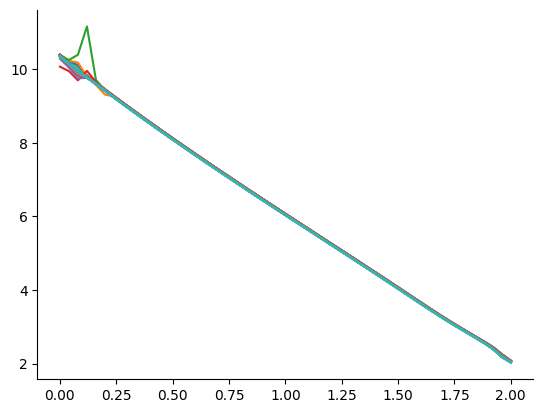

In [82]:
plt.plot(y1_grid_cap, ems)
plt.show()

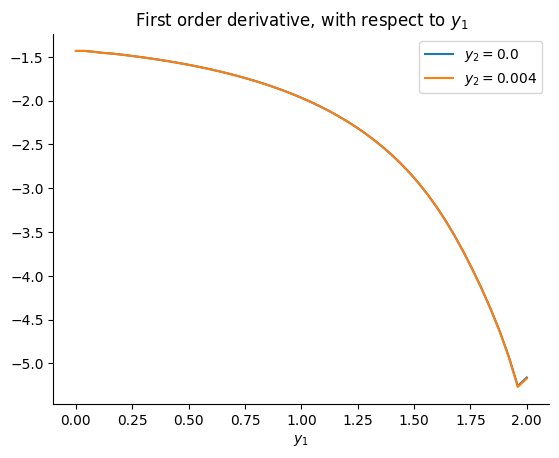

In [83]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

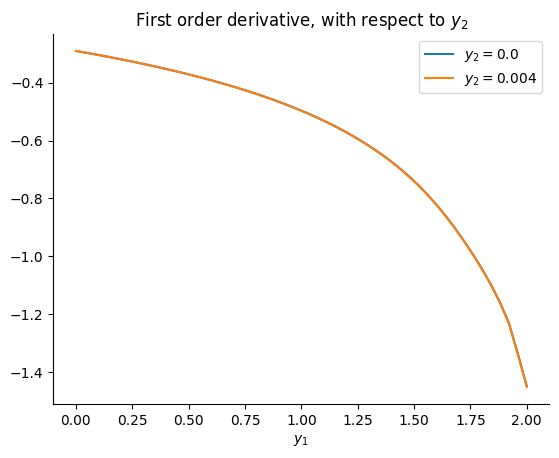

In [84]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

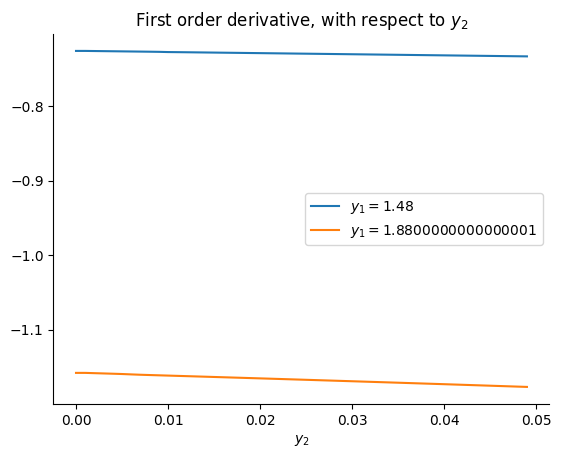

In [85]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

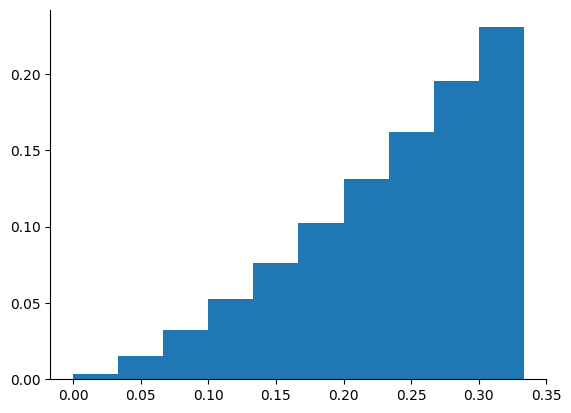

In [86]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

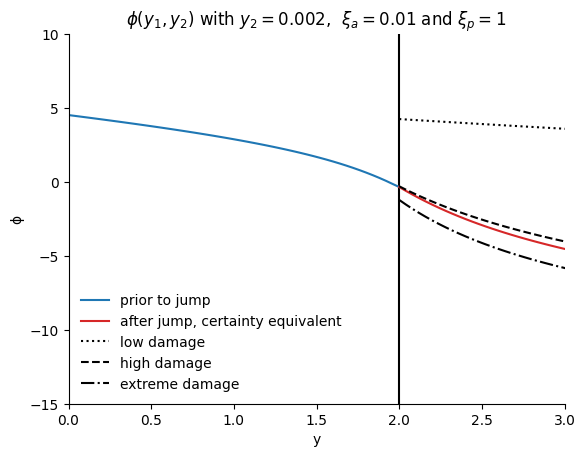

In [87]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

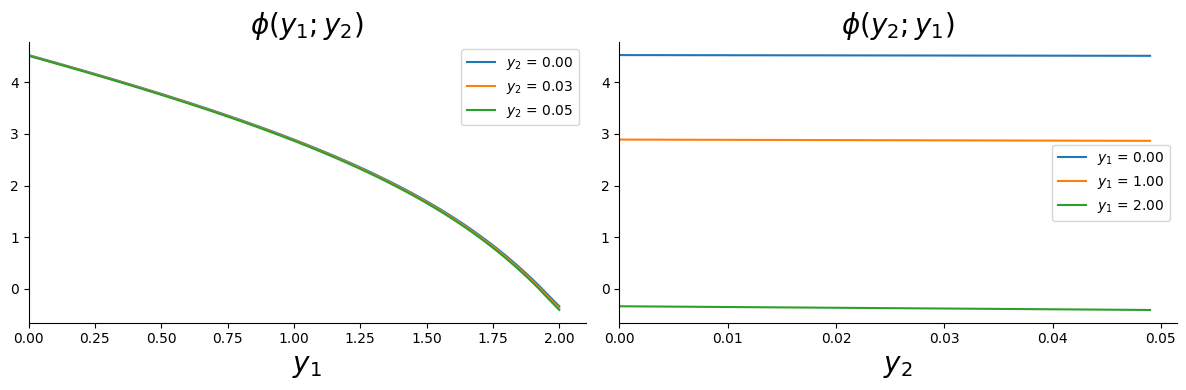

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

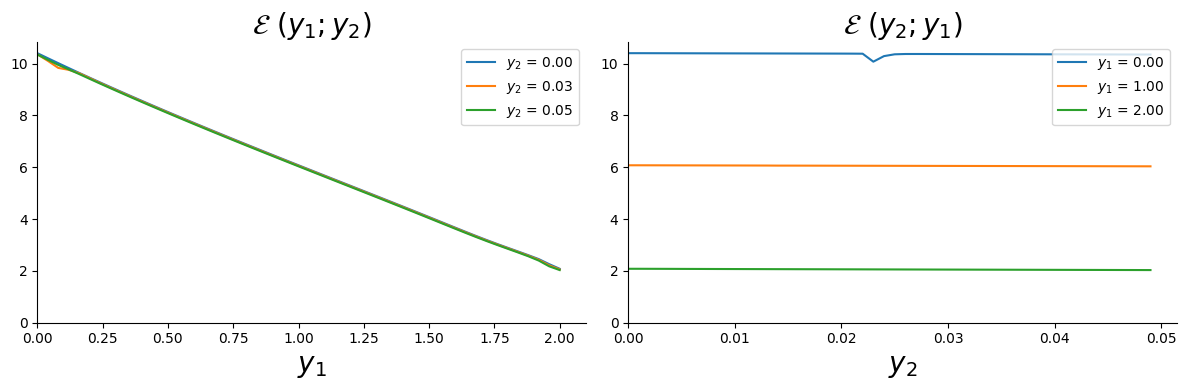

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [90]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [91]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [92]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [93]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [94]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

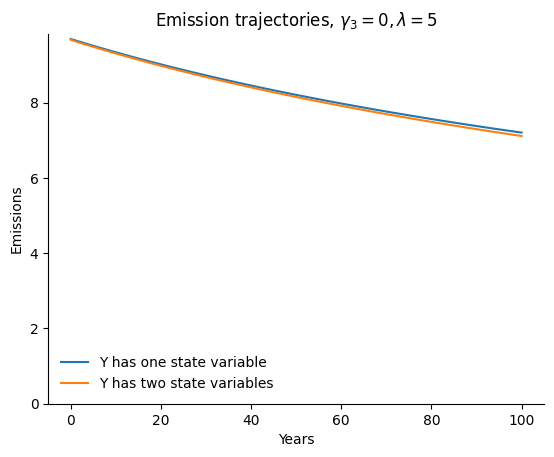

In [95]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [96]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=100
                                                 )

In [97]:
y1t_prejump

array([1.1       , 1.11050833, 1.12098429, 1.13138302, 1.14170483,
       1.15195029, 1.16211998, 1.17221448, 1.1822344 , 1.19218031,
       1.20205274, 1.21185223, 1.22157931, 1.23123452, 1.24081838,
       1.25033141, 1.25977401, 1.26914671, 1.27845002, 1.28768447,
       1.29685051, 1.30594864, 1.31497937, 1.32394318, 1.33284051,
       1.34167174, 1.35043736, 1.35913786, 1.36777373, 1.37634519,
       1.38485271, 1.39329676, 1.40167782, 1.40999631, 1.41825254,
       1.42644696, 1.43458004, 1.44265224, 1.45066391, 1.4586153 ,
       1.46650685, 1.47433901, 1.48211223, 1.48982688, 1.49748315,
       1.5050815 , 1.51262237, 1.52010619, 1.52753339, 1.53490427,
       1.54221926, 1.54947877, 1.55668322, 1.56383304, 1.57092863,
       1.57797039, 1.58495873, 1.59189406, 1.59877678, 1.60560728,
       1.61238623, 1.61911408, 1.6257912 , 1.632418  , 1.63899484,
       1.64552211, 1.65200086, 1.65843158, 1.66481463, 1.67115034,
       1.67743908, 1.68368119, 1.6898777 , 1.6960294 , 1.70213

In [98]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}_old", "wb"))

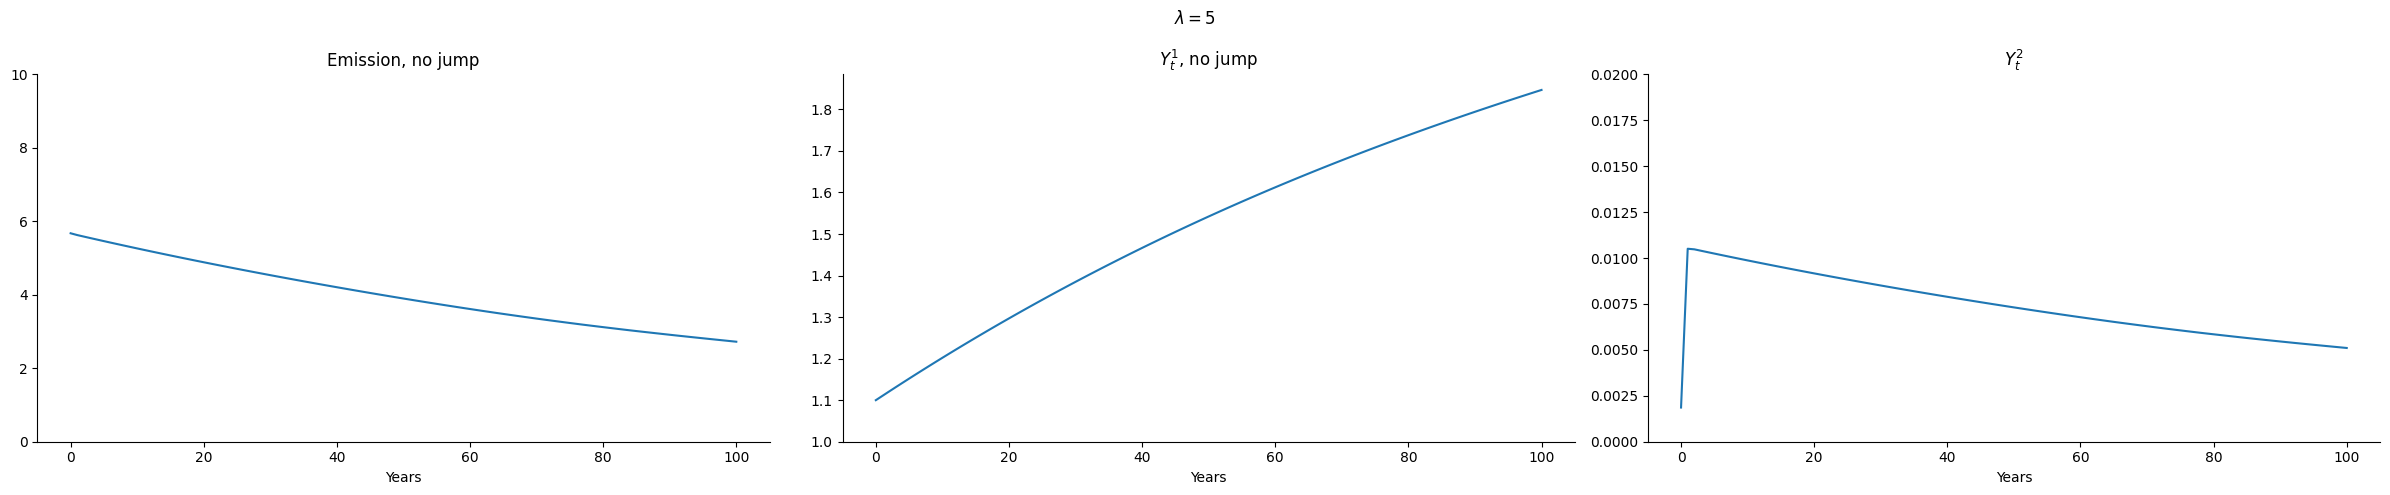

In [99]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [100]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [101]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.010508326205678747,
 0.049,
 array([1.1       , 1.11050833, 1.12098429, 1.13138302, 1.14170483,
        1.15195029, 1.16211998, 1.17221448, 1.1822344 , 1.19218031,
        1.20205274, 1.21185223, 1.22157931, 1.23123452, 1.24081838,
        1.25033141, 1.25977401, 1.26914671, 1.27845002, 1.28768447,
        1.29685051, 1.30594864, 1.31497937, 1.32394318, 1.33284051,
        1.34167174, 1.35043736, 1.35913786, 1.36777373, 1.37634519,
        1.38485271, 1.39329676, 1.40167782, 1.40999631, 1.41825254,
        1.42644696, 1.43458004, 1.44265224, 1.45066391, 1.4586153 ,
        1.46650685, 1.47433901, 1.48211223, 1.48982688, 1.49748315,
        1.5050815 , 1.51262237, 1.52010619, 1.52753339, 1.53490427,
        1.54221926, 1.54947877, 1.55668322, 1.56383304, 1.57092863,
        1.57797039, 1.58495873, 1.59189406, 1.59877678, 1.60560728,
        1.61238623, 1.61911408, 1.6257912 , 1.632418  , 1.63899484,
        1.64552211, 1.65200086, 1.65843158, 1.66481463, 1.67115034,
        1.6774390

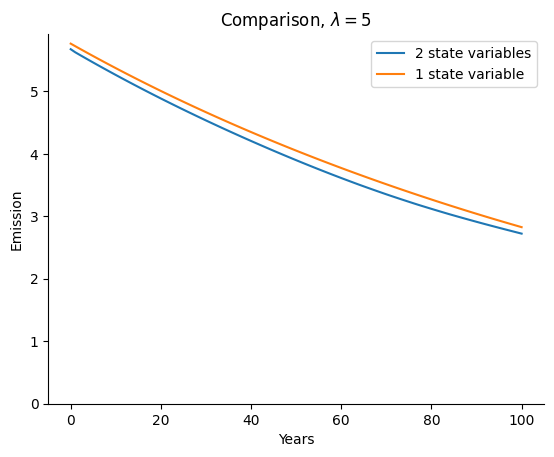

In [104]:
et_1state = np.load("et_1state_old.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [77]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [78]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [79]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=101)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

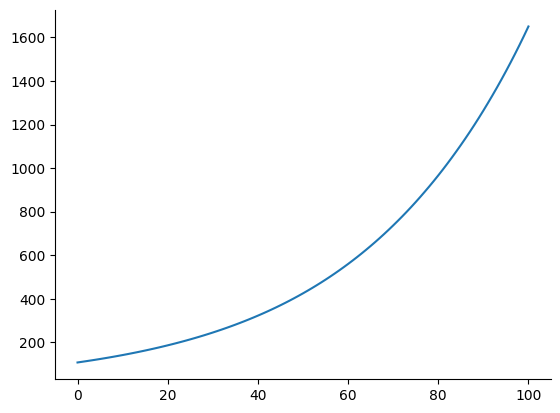

In [80]:
plt.plot(scc)
plt.show()